The script provides the code for the paper of co-crystal discovery and is separated into the following parts:


1. Importing the datasets from CSD and ZINC 15 (all the features are implemented and no feature engineering is required).
2. A deep neural network for one class classification was built using Pytorch library. The deepSVDD architecture was adapted from '**Deep One-Class Classification**, Ruff et al,Proceedings of the 35th International Conference on Machine Learning, 393-4402, 2018,80. The Attention-based autoencoder implemented was adapted from '**Set Transformer: A Framework for Attention-based Permutation-Invariant Neural Networks**, Lee et al, Proceedings of the 36th International Conference on Machine Learning, 3744-3753,2019.
3. The evaluation of the network is performed with k-fold cross validation on measuring the True Positive Rate.
4. The trained model is used for scoring the labeled and unlabeled data.
5. The molecular pairs are visualized.



# Import the relevant datasets

In [4]:
# Import the basic libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
from scipy.spatial.distance import squareform
from matplotlib import cm
import itertools
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dictionary assinign to each combination of the unlabelled dataset the smiles of the molecular pairs
dictionary = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/dictionary.csv')
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict1= {key:value for key, value in zip(k1, v1)}
print(dict1['comb1'])

['O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34' 'c1cc2c3cccc4ccc5ccc(c1)c2c5c34']


In [ ]:
# Dictionary where each smiles is associated with its ZINC Identifier
zinc_smiles=pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/zinc_smiles.csv')
v2= zinc_smiles.Identifier.str.strip()
k2=zinc_smiles['smiles'].values
zinc_dict= {key:value for key, value in zip(k2, v2)}

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 987 kB 2.8 MB/s 
     |████████████████████████████████| 59 kB 4.5 MB/s 
     |████████████████████████████████| 98 kB 4.7 MB/s 
     |████████████████████████████████| 269 kB 13.9 MB/s 
     |████████████████████████████████| 95 kB 3.7 MB/s 
     |████████████████████████████████| 90 kB 5.8 MB/s 
     |████████████████████████████████| 90 kB 7.1 MB/s 
     |████████████████████████████████| 155 kB 16.9 MB/s 
     |████████████████████████████████| 47 kB 4.2 MB/s 
     |████████████████████████████████| 77 kB 4.1 MB/s 
     |████████████████████████████████| 1.3 MB 17.3 MB/s 
     |████████████████████████████████| 100 kB 8.2 MB/s 


In [ ]:
# Import the dataset which contains all the molecules that constitute the first coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot

link1='hhttps://drive.google.com/open?id=1GXCi-JWtsPjFWe25E_jUNYS1iYUZXiGz' 
fluff, id = link1.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('coformers1.csv') 
dataset1=pd.read_csv('coformers1.csv') 
print(dataset1.shape)

1GXCi-JWtsPjFWe25E_jUNYS1iYUZXiGz
(1722, 1859)


In [ ]:
# Import the dataset which contains all the molecules that constitute the second coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot

link2='https://drive.google.com/open?id=1B9vUBhctWnJIC__-vYNPAIEJ9Y-H7vkj'
fluff, id = link2.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('coformers2.csv') 
dataset2=pd.read_csv('coformers2.csv')
print(dataset2.shape)

1B9vUBhctWnJIC__-vYNPAIEJ9Y-H7vkj
(1722, 1859)


In [ ]:
df1=dataset1.iloc[:,2:]
df1 = df1.fillna(df1.mean())
df2=dataset2.iloc[:,2:]
df2 = df2.fillna(df2.mean())
df1=df1.dropna(axis=1)
df2=df2[df1.columns.values]

In [ ]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset11, dataset22):

  return pd.concat([pd.concat([dataset1['Identifier'], dataset11, dataset22], axis=1), pd.concat([dataset1['Identifier'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])


In [ ]:
# Standarize the dataset
# Standarize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()


df_concat = pd.concat([df1, df2])
df_concat = df_concat.drop_duplicates(keep='first')
numerical_cols = df_concat.columns[:]
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)

numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1_scaled,df2_scaled)
df

Identifier        MW       AMW  ...  Neoplastic-50  Infective-80  Infective-50
0        WOVMEB  0.012474  0.041630  ...       0.000000      0.000000      0.000000
1        PIWKEL  0.070361  0.134320  ...       0.000000      1.000000      0.000000
2        OTIHIJ  0.164308  0.066597  ...       0.000000      0.000000      0.000000
3        DABLOJ  0.005860  0.051978  ...       0.000000      0.000000      0.000000
4        PIGJUK  0.095382  0.159366  ...       0.000000      0.000000      0.000000
...         ...       ...       ...  ...            ...           ...           ...
1717    AFOTIB_  0.007336  0.048022  ...       0.000000      0.000000      0.000000
1718    CIQNIC_  0.007336  0.048022  ...       0.000000      0.000000      0.000000
1719    DIVZUG_  0.007336  0.048022  ...       0.000000      0.000000      0.000000
1720    PIQTOB_  0.007336  0.048022  ...       0.029208      0.193697      0.033051
1721    RAWXEU_  0.002560  0.075504  ...       0.000000      0.000000      0.000000

[3444 rows x 3715 columns]

In [ ]:
labelled = pd.concat([df1_scaled, df2_scaled], axis=1)
labelled

MW       AMW        Sv  ...  Neoplastic-50  Infective-80  Infective-50
0     0.012474  0.041630  0.016615  ...            0.0           0.0           0.0
1     0.070361  0.134320  0.061649  ...            0.0           1.0           0.0
2     0.164308  0.066597  0.183830  ...            0.0           0.0           0.0
3     0.005860  0.051978  0.003116  ...            0.0           0.0           0.0
4     0.095382  0.159366  0.074476  ...            0.0           0.0           0.0
...        ...       ...       ...  ...            ...           ...           ...
1717  0.448668  0.128111  0.396388  ...            0.0           0.0           0.0
1718  0.392224  0.053445  0.444098  ...            0.0           0.0           0.0
1719  0.469412  0.098218  0.456237  ...            0.0           0.0           0.0
1720  0.088929  0.078963  0.195722  ...            0.0           0.0           0.0
1721  0.191153  0.257637  0.111682  ...            0.0           0.0           0.0

[1722 rows x 3714 columns]

In [ ]:
# Generate the unknown dataset (unlabelled)

# Read the Zinc dataset of purcasable molecules with their dragon descriptors
unlabeled = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data_test/unlabelled_dragon (5).csv')

val = unlabeled['NAME'].values
length = len(val)
print(length)
unlabeled=unlabeled.loc[:, (unlabeled != 0).any(axis=0)]


pairs = [[val[i],val[j]] for i in range(length) for j in range(length) if i!=j ]

# Remove the duplicate structures
no_dups = []
for pair in pairs:
  if not any(all(i in p for i in pair) for p in no_dups):
    no_dups.append(pair)

pairs = pd.DataFrame(no_dups)
keys = unlabeled['NAME'].values
values = unlabeled.iloc[:, 1:].values

d = {key:value for key, value in zip(keys, values)}
print(len(d['ZINC000000354958']))

209
2008


In [ ]:
mol1_data= list()

for mol1 in pairs[0]:       
    mol1_data.append(d[mol1])
    
mol1_data = pd.DataFrame(mol1_data, columns = unlabeled.iloc[:, 1:].columns.values)   

mol2_data= list()

for mol2 in pairs[1]:   
    mol2_data.append(d[mol2])
mol2_data = pd.DataFrame(mol2_data, columns= unlabeled.iloc[:, 1:].columns.values) 

In [ ]:
final_1 = pd.concat([pairs[0],mol1_data],axis=1)
final_1 = final_1.fillna(0)#df1.mean())
final_2 = pd.concat([pairs[1],mol2_data],axis=1)
final_2 = final_2.fillna(0)

unlab=pd.concat([pairs[0], pairs[1]], axis=1)
final_1 = final_1.replace({'#NUM!': 0})
final_2 = final_2.replace({'#NUM!': 0})

final_11=final_1[dataset1.iloc[:,2:].columns.values]

final_22=final_2[dataset1.iloc[:,2:].columns.values]


In [ ]:
#final_1.to_pickle('/content/drive/My Drive/cocrystal_design-master/data/final_1.plk')
#final_2.to_pickle('/content/drive/My Drive/cocrystal_design-master/data/final_2.plk')

In [ ]:
# Standarize the unlabeled data based on the labelled
final_1_scaled = pd.DataFrame(X_scaler.transform(final_11))
final_2_scaled = pd.DataFrame(X_scaler.transform(final_22))
uf=pd.concat([final_1_scaled, final_2_scaled], axis =1)

In [ ]:
# Define a dictionary where the comb identifier will be combined to the feature vector
comb=[]
for i in range(1,final_11.shape[0]+1):
  comb.append('comb%s' % i)

uf_tot=pd.concat([pd.DataFrame(comb, columns=['comb']),final_11, final_22 ], axis=1)

keys1 = uf_tot['comb'].values
values1 =  uf_tot.iloc[:, 1:].values

dii={key:value for key, value in zip(keys1, values1)}

In [ ]:

zinc_smiles = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/zinc_smiles.csv', sep=',')

ke= zinc_smiles.Identifier.str.strip()
v=zinc_smiles['smiles'].values
my_dict= {key:value for key, value in zip(ke, v)}

i=list()
for l in pairs[0]:  
  #print(my_dict[l])
  i.append(my_dict[l])

k=list()
for m in pairs[1]:
  k.append(my_dict[m])

dictionary = pd.concat([ uf_tot['comb'], pd.DataFrame(i, columns=['smiles1']), pd.DataFrame(k, columns=['smiles2']), pd.DataFrame(pairs[0]), pd.DataFrame(pairs[1])], axis=1)

In [ ]:
# Dictionary assinign to each combination number the smiles of the molecular pairs
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict1= {key:value for key, value in zip(k1, v1)}
print(dict1['comb1'])

# Dictionary where each smiles is associated with its ZINC Identifier
v2= zinc_smiles.Identifier.str.strip()
k2=zinc_smiles['smiles'].values
zinc_dict= {key:value for key, value in zip(k2, v2)}

['O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34' 'c1cc2c3cccc4ccc5ccc(c1)c2c5c34']


In [ ]:
# Remove duplicate structures that might exist in both the labelled and unlabelled dataset
df_tota= pd.concat([pd.DataFrame(df['Identifier'].values, columns=['comb']), pd.DataFrame(df.iloc[:, 1:].values) ],axis=1)
uf_tota=pd.concat([pd.DataFrame(comb, columns=['comb']), pd.DataFrame(uf.values)],axis=1) 

check=pd.concat([df_tota, uf_tota], axis=0)
check.shape
c=check.drop_duplicates(subset=check.columns.values[1:] ,keep='first', inplace=False)
df1=c.iloc[:3476, :]
uf1=c.iloc[3476:, :]
val = pd.concat([uf_tota, uf1], axis=0)
v= val['comb'].drop_duplicates(keep=False, inplace=False)
df__=df1.iloc[:, 1:]
uf_=uf1.iloc[:, 1:]

In [ ]:
# Print the first lines of whole unlabelled dataset
uf_final= pd.DataFrame(uf_tota.values, columns=df.columns.values)
uf_final.head()

Identifier         MW      AMW  ... Neoplastic-50 Infective-80 Infective-50
0      comb1  0.0586417  0.12109  ...             0            1            0
1      comb2  0.0586417  0.12109  ...             0            1            0
2      comb3  0.0586417  0.12109  ...             0            0            0
3      comb4  0.0586417  0.12109  ...             0            0            0
4      comb5  0.0586417  0.12109  ...             0            1            0

[5 rows x 3715 columns]

In [ ]:
#df.to_pickle("/content/drive/My Drive/cocrystal_design-master/data/df_labelled_scaled.pkl")
#uf_final.to_pickle("/content/drive/My Drive/cocrystal_design-master/data/unlabelled_all_new.pkl") #this is with mean-0 in the unlabelled

# Read files

In [ ]:
#df = pd.read_pickle("/content/drive/My Drive/cocrystal_design-master/data/df_all.pkl")
#uf_final = pd.read_pickle("/content/drive/My Drive/cocrystal_design-master/data/unlabelled_all_new.pkl")#
#uf=uf_final.iloc[:,1:]


# Deep One Class Architecture

In [ ]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design-master/models/deep_one_class
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
import deepSVDD
from base.base_net import BaseNet

In [ ]:
INPUT_DIM = 3714

class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if data is None:
          self.data=labelled.values.astype('f')

        else:
          self.data = data.values.astype('f')
        self.labels = np.zeros(self.data.shape[0])
          

    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)

In [ ]:
INPUT_DIM = 3714

class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if data is None:
          self.data=labelled.values.astype('f')

        else:
          self.data =  data.values.astype('f')
        self.labels = np.zeros(self.data.shape[0])
          

    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)
        return self.decoder(self.encoder(x))

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [ ]:
INPUT_DIM = 1857

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=1857, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=5),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))
        
    def forward(self, x):
      x = torch.split(x, 1857, dim=1)     
      x= torch.stack(x).transpose(0,1) 
      return self.seq(x).squeeze()

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( nn.Linear(in_features=100, out_features=500), nn.LeakyReLU(),
       nn.Linear(in_features=500, out_features=1000),nn.LeakyReLU(),
        nn.Linear(in_features=1000, out_features=1857),nn.LeakyReLU(),         
       nn.Linear(in_features=1857, out_features=3714), nn.Sigmoid())
        
        #nn.Sequential(nn.Linear(in_features=100, out_features=3714), nn.Sigmoid())
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()

def build_network(net_name):  
  return PairsEncoder()

torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [ ]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': -1, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'} )

In [ ]:
dataset_name = cfg.settings['dataset_name']
#data_path = cfg.settings['data_path']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0
#xp_path = cfg.settings['xp_path']
df=df.fillna(0)
dataset = Pairs_Dataset('', data= df.iloc[:1722, 1:] )#df.iloc[:1600, 1:])  #load_dataset(dataset_name, data_path, normal_class) KatPair(df1_scaled, df2_scaled) #

In [53]:
def set_seed(seed):
  #seed = cfg.settings.get('seed', 0)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [ ]:
set_seed(0)
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Perform 30 runs for measuring the mean correlation and mean standard deviation of the scores between the 30 different runs
from sklearn.model_selection import train_test_split
lab_list=[]
unlab_list=[]
for i in range(30):
  set_seed(i)
  X_train, X_test= train_test_split( df.iloc[:, 1:],  test_size=0.1, random_state=i)
  dataset = Pairs_Dataset('', data= df.iloc[X_train.index, 1:] )#Pairs_Dataset('', data= df.iloc[:1722, 1:])   #Pairs_Dataset('', data= df.iloc[X_train.index, 1:] )
  deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'                      
  deep_SVDD.pretrain(dataset, optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,
                   n_epochs = 60 , #100,
                   lr_milestones=(100,),
                   batch_size=200, 
                   weight_decay=0.5e-3,  
                   device=device,
                   n_jobs_dataloader=0)
  deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 60,
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=n_jobs_dataloader)
  from sklearn.preprocessing import MinMaxScaler
  y_scaler1 = MinMaxScaler()
  lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
  lab_list.append(lab.ravel())
  uf_final= uf_final.fillna(0)
  unlab = score(deep_SVDD, uf_final.iloc[:,1:].values).cpu().detach().numpy()*-1
  unlab_list.append(unlab.ravel())

In [51]:
# caclulate the Pearson correlattion and the Standard deviation of the scores after 30 runs, with 90% of the labelled data used as the training and 10% as the validation set
corr = np.corrcoef(unlab_list)
ui = np.triu_indices_from(corr, 1)
print('Pearson correlation', np.mean(corr[ui]))
print('Standard devaitions', np.mean(np.std(np.array(unlab_list), axis=0)))

Pearson correlation 0.9651397508688541
Standard devaitions 0.0017319531


In [5]:
plt.hist(np.std(np.array(unlab_list)))

NameError: ignored

In [1]:
from sklearn.model_selection import train_test_split
#X_train, X_test= train_test_split( df.iloc[:, 1:],  test_size=0.1, random_state=42)
#dataset = Pairs_Dataset('', X_train, X_test ,data=df.iloc[:1722, 1:])  

In [ ]:
deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,
                   n_epochs =60 , #100,
                   lr_milestones=(100,),
                   batch_size=200, 
                   weight_decay=0.5e-3,  
                   device=device,
                   n_jobs_dataloader=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/60	 Time: 0.247	 Loss: 542.36951362
INFO:root:  Epoch 2/60	 Time: 0.243	 Loss: 514.55396864
INFO:root:  Epoch 3/60	 Time: 0.232	 Loss: 477.91000366
INFO:root:

In [ ]:
deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 60,
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=n_jobs_dataloader)

INFO:root:Initializing center c...
INFO:root:Center c initialized.
INFO:root:Starting training...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/60	 Time: 0.237	 Loss: 0.17088955
INFO:root:  Epoch 2/60	 Time: 0.246	 Loss: 0.08867397
INFO:root:  Epoch 3/60	 Time: 0.221	 Loss: 0.05735486
INFO:root:  Epoch 4/60	 Time: 0.206	 Loss: 0.04249244
INFO:root:  Epoch 5/60	 Time: 0.200	 Loss: 0.03391393
INFO:root:  Epoch 6/60	 Time: 0.227	 Loss: 0.02857848
INFO:root:  Epoch 7/60	 Tim

In [ ]:
# Save the deepSVDD model
#pth_path = ('/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/model_checkpoint_final.pth') 
#deep_SVDD.save_model(pth_path)

# Scoring 

The scoring is performed based on the distance of the center of the hypersphere. Herein, as we want a ranking between [0,1], the scores of the neural net are multiplied by -1 and normalized to [0,1] to be comparable with the standrard models.\
The scores disribution is visualized for both the labeled and unlabeled datasets.

In [ ]:
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [ ]:
# Scoring the labelled and unlabelled data
from sklearn.preprocessing import MinMaxScaler
y_scaler1 = MinMaxScaler()
##lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
lab= y_scaler1.fit_transform(lab.reshape(-1,1))
#uf_final= uf_final.fillna(0)
#unlab = score(deep_SVDD, uf_final.iloc[:,2:].values).cpu().detach().numpy()*-1
#unlab = y_scaler1.transform(unlab.reshape(-1,1))
lab=pd.DataFrame(lab, columns=['train_score'])
#unlab_final=pd.concat([uf_final['Identifier'], pd.DataFrame(unlab, columns=['test_score'] )], axis=1)

In [ ]:
lab.describe()

train_score
count  1722.000000
mean      0.828260
std       0.120326
min       0.000000
25%       0.784625
50%       0.858154
75%       0.905127
max       1.000000

In [ ]:
lab = np.mean(lab_list, 0) 
lab

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [ ]:
lab = np.mean(lab_list, 0) 
lab= y_scaler1.fit_transform(lab.reshape(-1,1))
lab=pd.DataFrame(lab, columns=['train_score'])
lab.describe()

In [39]:
std = np.std(unlab_list)
ui = np.triu_indices_from(std, 1)
np.mean(std[ui])

ValueError: ignored

In [ ]:
np.std(unlab_list, axis=1)).shape == 30

In [ ]:
np.mean(np.std(unlab_list, axis=1))

In [50]:
# caclulate the Pearson correlattion and the Standard deviation of the scores after 30 runs, with 90% of the labelled data used as the training and 10% as the validation set
corr = np.corrcoef(unlab_list)
ui = np.triu_indices_from(corr, 1)
print('Pearson correlation', np.mean(corr[ui]))
print('Standard devaitions', np.mean(np.std(np.array(unlab_list), axis=0)))

Pearson correlation 0.9651397508688541
Standard devaitions 0.0017319531


In [ ]:
lab = np.mean(lab_list, 0) 
lab= y_scaler1.fit_transform(lab.reshape(-1,1))
lab=pd.DataFrame(lab, columns=['train_score'])
lab.describe()

train_score
count  1722.000000
mean      0.832425
std       0.114368
min       0.000000
25%       0.787654
50%       0.860318
75%       0.908823
max       1.000000

In [ ]:
lab = np.mean(lab_list, 0) 
lab= y_scaler1.fit_transform(lab.reshape(-1,1))
lab=pd.DataFrame(lab, columns=['train_score'])
lab.describe()

train_score
count  1722.000000
mean      0.828551
std       0.117434
min       0.000000
25%       0.786774
50%       0.857512
75%       0.905585
max       1.000000

In [ ]:
uf_final= uf_final.fillna(0)
unlab = np.mean(unlab_list, 0) 
unlab = y_scaler1.transform(unlab.reshape(-1,1))
#unlab = score(deep_SVDD, uf_final.iloc[:,1:].values).cpu().detach().numpy()*-1
#unlab = y_scaler1.transform(unlab.reshape(-1,1))
unlab_final=pd.concat([uf_final['Identifier'], pd.DataFrame(unlab, columns=['test_score'] )], axis=1)

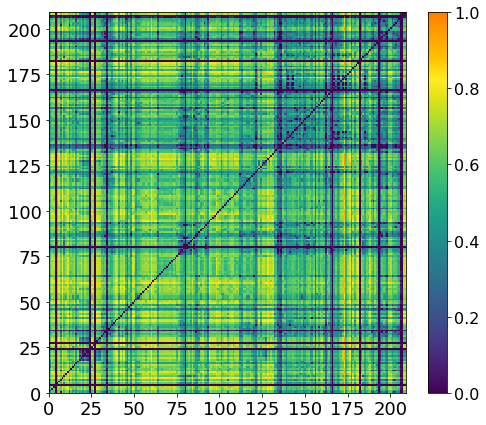

In [ ]:
# Scores distribuition histogram
fig = plt.figure(figsize=(8,7))

ax = fig.add_subplot(111)
dist_mat = squareform(unlab.ravel())
N = dist_mat.shape[0]

top = cm.get_cmap('viridis', 512)
bottom = cm.get_cmap('Wistia', 512)

newcolors = np.vstack((top(np.linspace(0, 1, 812)),
                       bottom(np.linspace(0.2, 1, 180))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

plt.pcolormesh(dist_mat, cmap=  newcmp)

cbar = plt.colorbar(ax=ax)
plt.clim(0,1) 
cbar.ax.tick_params(labelsize=16) 
plt.xlim([0,N])
plt.ylim([0,N])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/deep_scores_ heatmap.png' ,rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

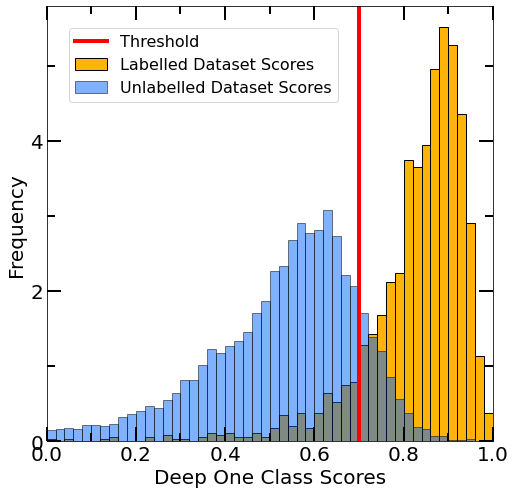

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

_, bins , _ = plt.hist(lab.train_score.values, bins=50, ec='k', histtype='bar', density=True, alpha=1, color='#feb308', label='Labelled Dataset Scores')

_= plt.hist(unlab_final.test_score, bins=bins,density=True, ec='k',alpha=0.5, color='#0165fc', label='Unlabelled Dataset Scores')
#_= plt.hist(val.train_score, bins=bins,density=True, ec='k',alpha=0.5, color='red', label='Unlabelled Dataset Scores')
_ = plt.axvline(x=0.7, label='Threshold', c='r', linewidth=4)

plt.grid(False)
plt.xlim(0, 1.0)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
major_ticks_x = np.arange(0, 1.001, 0.2)
minor_ticks_x = np.arange(0,1.001, 0.1)
major_ticks_y = np.arange(0, 6, 2)
minor_ticks_y = np.arange(0, 6, 1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

plt.legend(prop={'size': 16}, loc=[0.05, 0.78])
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/deep_scores_ histogram.png' ,rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

In [ ]:
# Save the predictions for the pyrene possible pairs
pyr = np.concatenate([dictionary[dictionary.smiles1 == 'c1cc2ccc3cccc4ccc(c1)c2c34'].comb, dictionary[dictionary.smiles2 == 'c1cc2ccc3cccc4ccc(c1)c2c34'].comb])
pyra= unlab_final[unlab_final.Identifier.isin(pyr)]
pyr_dict=[]
for i in pyra.Identifier:
  pyr_dict.append(dict1[i])
pyrene_pairs = pd.concat([pd.DataFrame(pyr_dict, columns=['smiles1', 'smiles2']), pd.DataFrame(pyra.test_score.values, columns=['score'])], axis=1)
pyrene_pairs.to_csv('/content/drive/My Drive/pyrene_pairs_scores_60_60_2.csv', index= False) 
pyrene_pairs[pyrene_pairs.smiles2 == 'c1ccc2c3ccccc3c4ccccc4c2c1']#.to_csv('/content/drive/My Drive/pyrene_pairs_scores_final_80_80.csv', index= False)


smiles1                     smiles2     score
79  c1cc2ccc3cccc4ccc(c1)c2c34  c1ccc2c3ccccc3c4ccccc4c2c1 -0.902672

#Visualize the results

The RDkit library is installed for enabling the visualizations. The molecules are visualized in pairs, e.g the firt two molecules compose the first co-crystal pair. The printed lists are separated into categories, according to the following criteria:\
1) No constrains\
2) Pairs after removing the solvents\
3) Pairs including one of the initial PAHs\
4) Pairs without solvents and heteroatoms\
5) Pairs including heteroatoms\
6) Pairs including 1,6 dicyanoanthracene, the most similar (Tanimoto Similarity) molecule to TCNQ (well known for the electronic properties)\
7) Pyrene-cocrystals (Pyrene was the most predicted co-former) 

In [ ]:
# Install the RDKit library
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

# Append rdkit path to current python system path
%matplotlib inline
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-07-05 12:12:21--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-07-05 12:12:21--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / 

In [ ]:
# import rdkit libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

In [ ]:
# Define a function to remove duplicates

def Remove(duplicate):
  seen = set()
  result = []
  for item in duplicate:
    if item not in seen:
        seen.add(item)
        result.append(item)
        
  return result

In [ ]:
# List including the starting PAHs

initial_molecules=['c1ccc2cc3cc4cc5ccccc5cc4cc3cc2c1',                 # pentacene
                   'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc34',               # picene
                   'c1ccc2c3ccccc3c4ccccc4c2c1',                       # triphenylene
                   'c1ccc2c(c1)ccc3ccccc23',                           # phenanthrene
                   'c1ccc2c(c1)c3cccc4cccc2c34',                       # fluoranthene
                   'c1cc2ccc3ccc4ccc5ccc6ccc1c7c6c5c4c3c27',           #coronene 
                   'c1ccc2c(c1)ccc1cc3cc4cc5c(ccc6ccccc65)cc4cc3cc12', #dibenzo-pentacene
                   'c1cc2ccc3ccc4ccc5ccc1c1c2c3c4c51']                #corannulene 

In [ ]:
threshold = pd.DataFrame(unlab_final.describe().loc['75%'].astype(float)).iloc[0].values[0]
proba_ = unlab_final.sort_values(by = ['test_score'], ascending=True)
top_scored = unlab_final[unlab_final['test_score'] > threshold]
top_scored = top_scored.sort_values(by='test_score', ascending=False)
len(top_scored)

5434

In [ ]:
# Dictionary assinign to each combination of the unlabelled dataset the smiles of the molecular pairs

k2 = top_scored.Identifier
v2= top_scored.test_score
score_dict= {key:value for key, value in zip(k2, v2)}


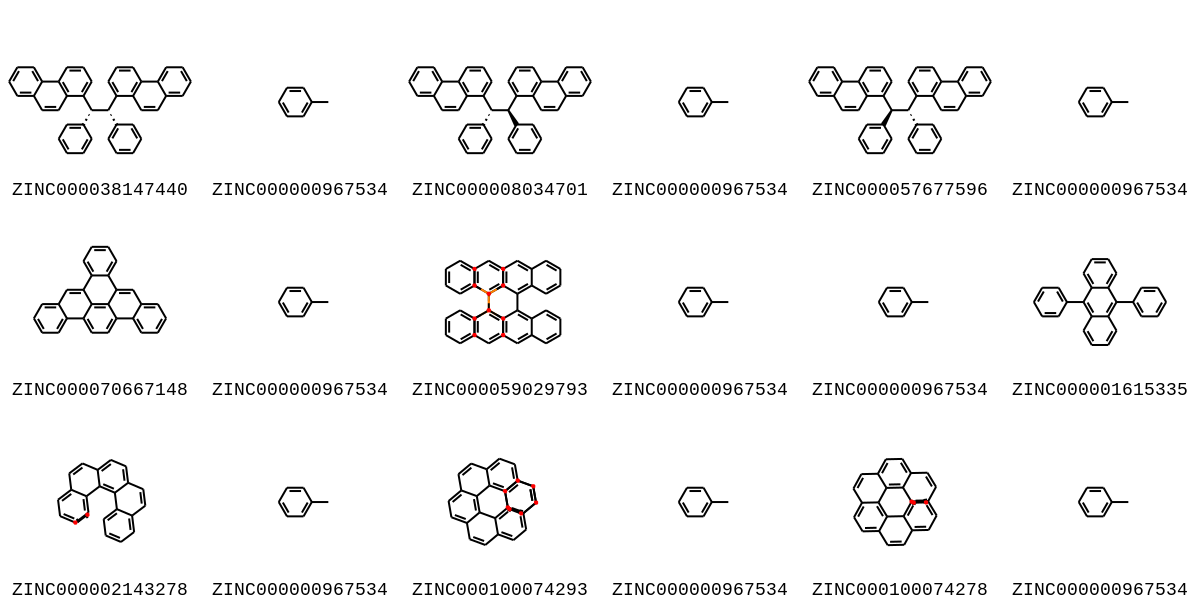

In [ ]:
# Print a list with the ranking with no constrains
lista=[]
score=[]

for i in top_scored.Identifier[:9]:
  lista.append(dict1[i])
  score.append(top_scored[top_scored.Identifier ==i].test_score)
ar=np.array(lista)
ar=ar.tolist()

import itertools

merged = list(itertools.chain(*ar))
Draw.IPythonConsole.drawOptions.legendFontSize = 18
Draw.IPythonConsole.drawOptions.atomLabelFontSize = 12
Draw.IPythonConsole.drawOptions.atomLabelMinFontSize = 70

IPythonConsole.molSize = (500,500)

subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6, subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design/figures/deep_rank.png', "PNG")

In [ ]:
solvents = ['C1Cc2ccccc12', 'Brc1ccccc1', 'c1ccc2cnncc2c1', 'Cc1ccccc1', 'Cc1ccccc1C', 'Clc1ccccc1', 'Clc1ccccc1']
solvates=[]
for x in top_scored['Identifier']:
  if dict1[x][0] in solvents:
    solvates.append(x)
        
  if dict1[x][1] in solvents:
      solvates.append(x)

solvates = Remove(solvates)
len(solvates)
predictions1 = top_scored[~top_scored.Identifier.isin(solvates)]

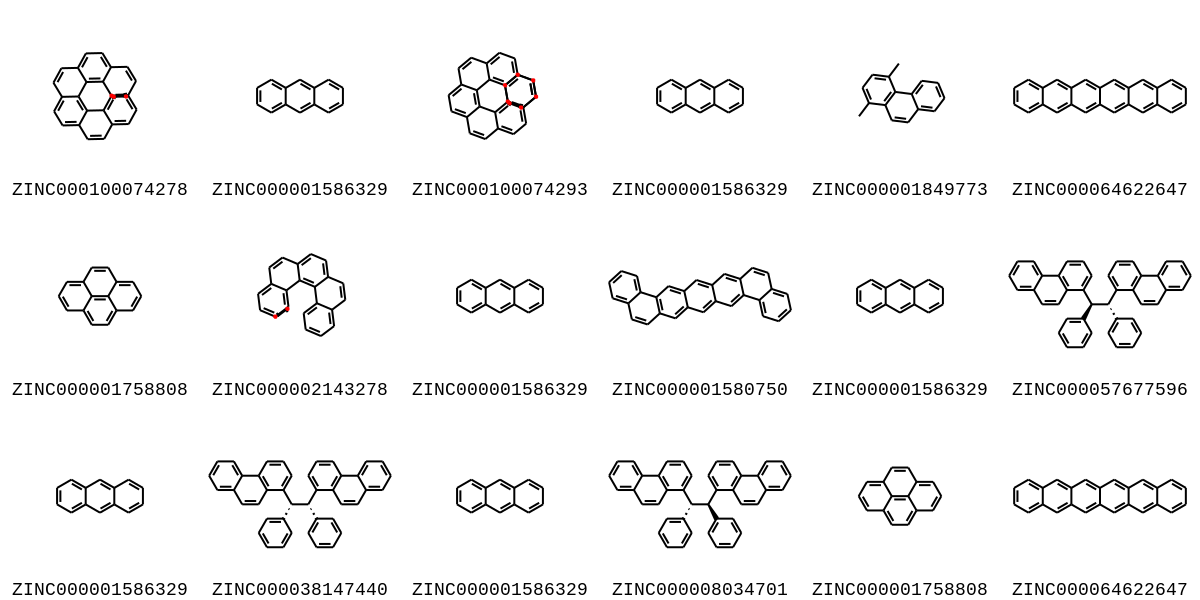

In [ ]:
# Print a list with the ranking after removing the solvents
listaki=[]
score=[]

for i in predictions1.Identifier[:9]:
  listaki.append(dict1[i])
  score.append(top_scored[top_scored.Identifier ==i].test_score)
ar=np.array(listaki)
ar=ar.tolist()

import itertools
merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design/figures/deep_rank_no_solvent.png', "PNG")

In [ ]:
# List with the combinations without heteroatoms
uf = pd.DataFrame(uf.values, columns=df.columns.values[1:])
het=pd.concat([uf_final.Identifier , uf.nHet.iloc[:,0], uf.nHet.iloc[:,1]], axis=1)

#het1 = het[het.nHet==0]
#het2 =het1[het1['nHet.1']!=0]

het3 = het[het.nHet.iloc[:,0]==0]
het4 =het3[het.nHet.iloc[:,1]==0]
#no_het = [x for x in predictions.Identifier.values if x in het2.Identifier.values]
het4
het = [x for x in predictions1.Identifier.values if x not in het4.Identifier.values]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


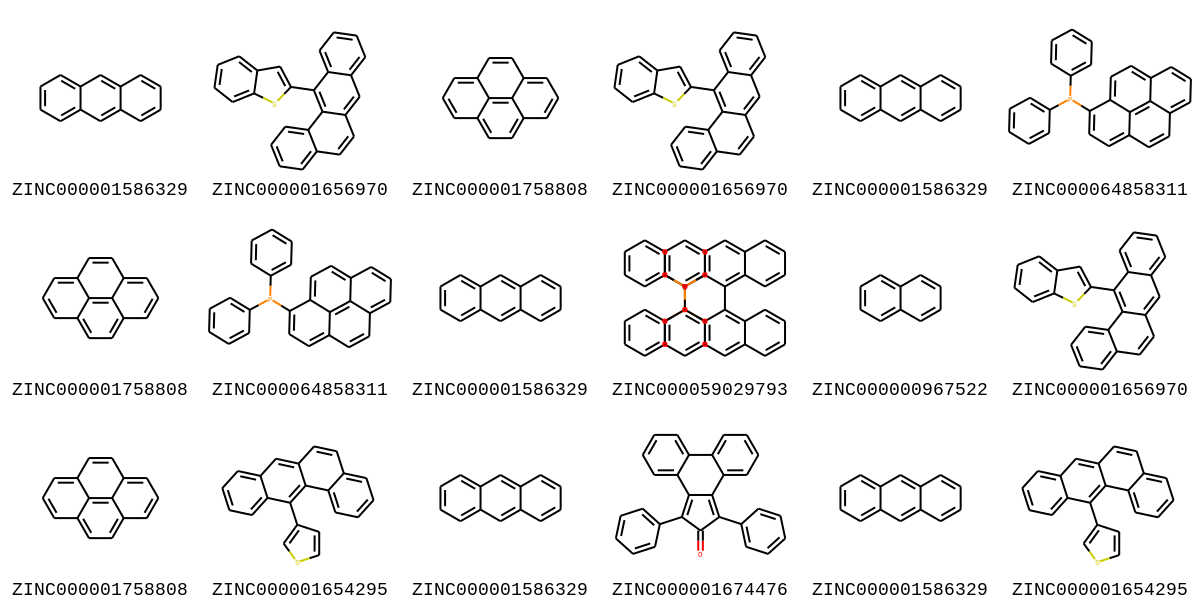

In [ ]:
# List_3: A list with the ranking with heteroatoms
listaki=[]
score=[]

for i in het[:9]:
  listaki.append(dict1[i])
  score.append(top_scored[top_scored.Identifier ==i].test_score)
  
ar=np.array(listaki)
ar=ar.tolist()

import itertools
merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design/figures/deep_no_heteroatoms.png', "PNG")

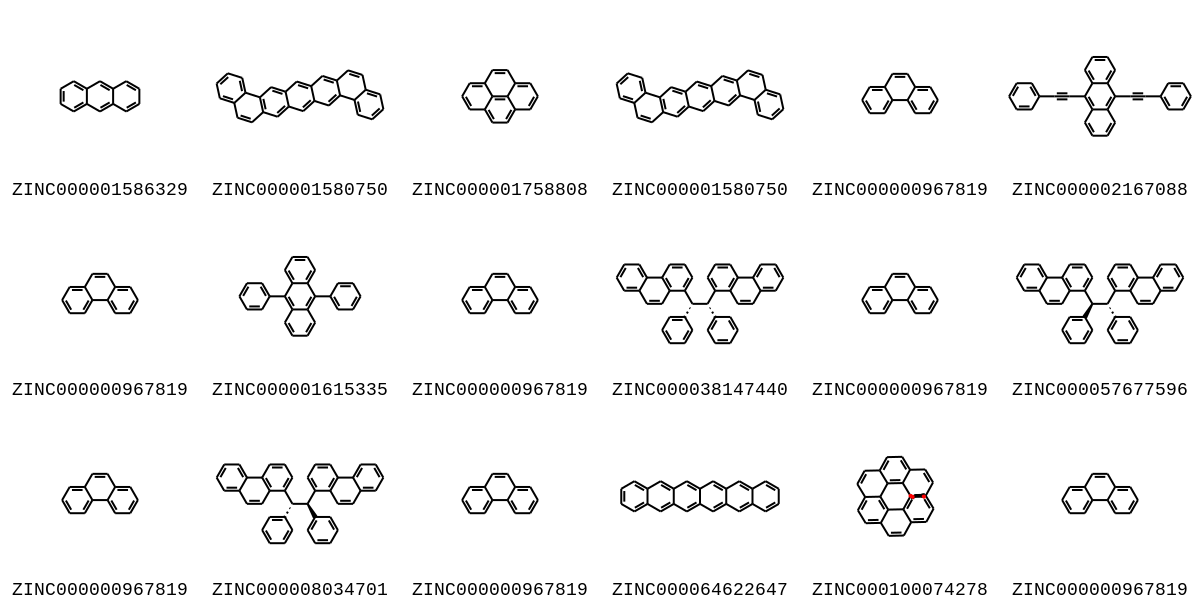

In [ ]:
# List4: Combinations including the starting PAHs
one=[]
for x in predictions1['Identifier']:
  if dict1[x][0] in initial_molecules:
    one.append(x)
         
  else:
    if dict1[x][1] in initial_molecules:
      one.append(x)
one=Remove(one)
listaki=[]
score=[]

for i in one[:9]:
  listaki.append(dict1[i])
  score.append(top_scored[top_scored.Identifier ==i].test_score)
ar=np.array(listaki)
ar=ar.tolist()

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design/figures/deep_initial_PAHs.png', "PNG")

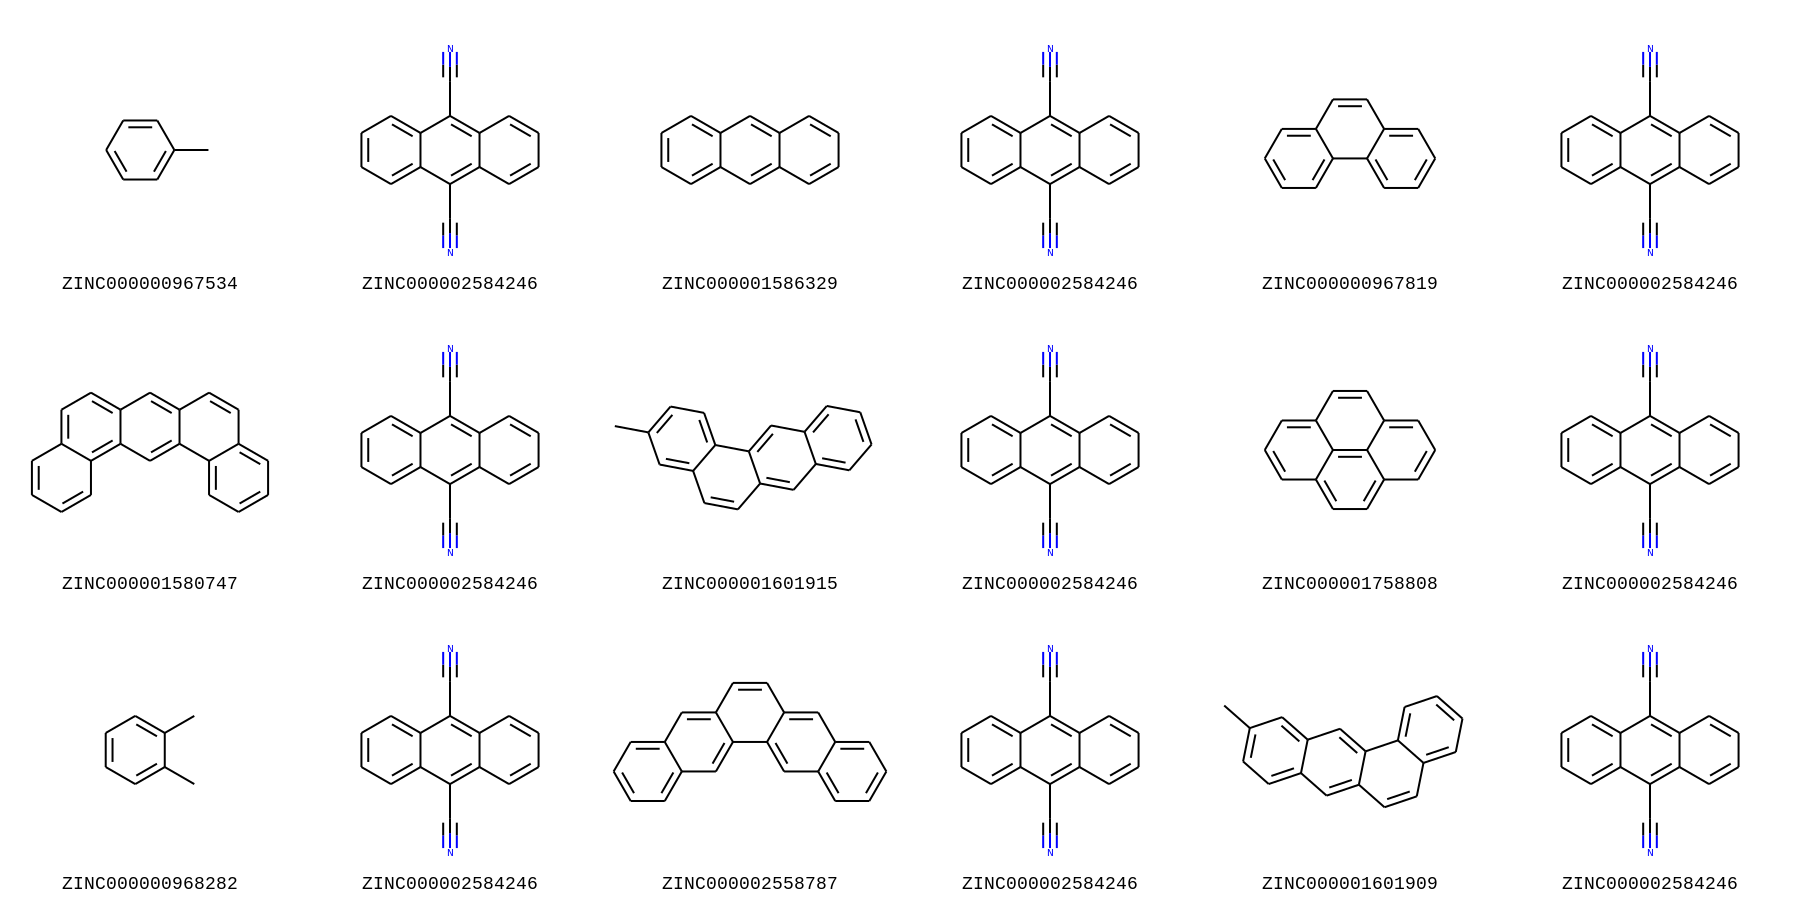

In [ ]:
# Show all the combinatios with  9,10-Anthracenedicarbonitrile 
dicyano=[]
for x in top_scored.Identifier:
  if dict1[x][0] == 'N#Cc1c2ccccc2c(C#N)c3ccccc13':     # if you want to check other molecules just change the two smiles here
    dicyano.append(x)        
  if dict1[x][1] == 'N#Cc1c2ccccc2c(C#N)c3ccccc13':     # and here
    dicyano.append(x)

dicyano= Remove(dicyano)    

listaki=[]
score=[]

for i in dicyano[:]:                     # select the number of the predictions you want to see
  score.append(top_scored[top_scored.Identifier ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools
#IPythonConsole.molSize = (500,500)

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]



img=Draw.MolsToGridImage(subms,molsPerRow=6,legends=[zinc_dict[x] for x in merged], subImgSize=(300,300))#, options=options)
#Draw.IPythonConsole.drawOptions.atomLabelFontSize = 600
img#.save('/content/drive/My Drive/cocrystal_design/figures/deep_dicyano.svg', "PNG")



In [ ]:
score

[10523    0.740392
 Name: test_score, dtype: float32, 21042    0.740232
 Name: test_score, dtype: float32, 1397    0.737046
 Name: test_score, dtype: float32, 1798    0.736989
 Name: test_score, dtype: float32, 11113    0.736248
 Name: test_score, dtype: float32, 10820    0.734499
 Name: test_score, dtype: float32, 15920    0.733047
 Name: test_score, dtype: float32, 18538    0.731871
 Name: test_score, dtype: float32, 10222    0.728657
 Name: test_score, dtype: float32, 16648    0.725339
 Name: test_score, dtype: float32, 2392    0.718657
 Name: test_score, dtype: float32, 15703    0.715582
 Name: test_score, dtype: float32, 21049    0.711134
 Name: test_score, dtype: float32, 16547    0.711076
 Name: test_score, dtype: float32, 9137    0.709339
 Name: test_score, dtype: float32, 15593    0.708674
 Name: test_score, dtype: float32, 9295    0.706442
 Name: test_score, dtype: float32, 10070    0.706057
 Name: test_score, dtype: float32, 11258    0.705543
 Name: test_score, dtype: float3

/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


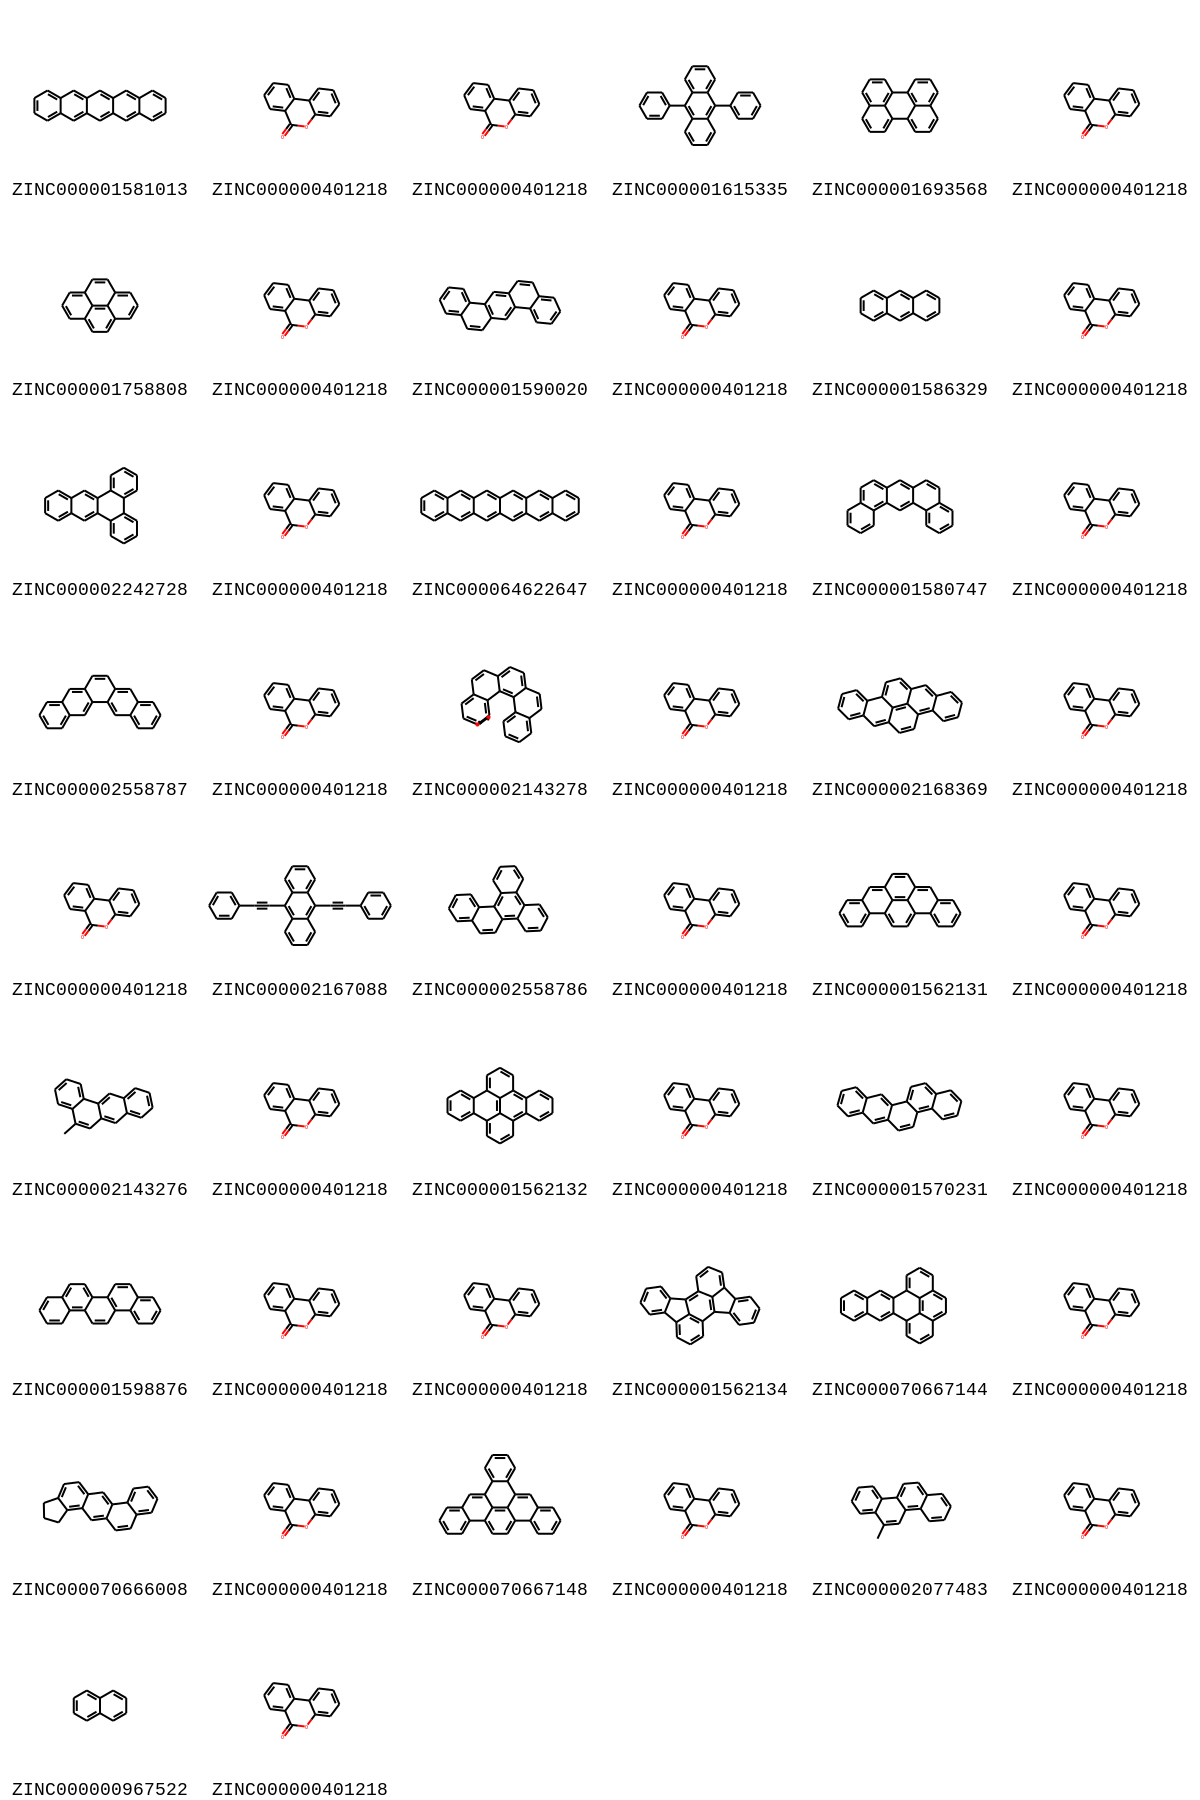

In [ ]:
mol2=[]
for x in predictions1.Identifier:
  if dict1[x][0] == 'O=C1Oc2ccccc2c3ccccc13':     # if you want to check other molecules just change the two smiles here
    mol2.append(x)        
  if dict1[x][1] == 'O=C1Oc2ccccc2c3ccccc13':     # and here
    mol2.append(x)

mol2 = Remove(mol2)    
listaki=[]
score=[]

for i in mol2[:]:                     # select the number of the predictions you want to see
  score.append(top_scored[top_scored.Identifier ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions

#Draw.DrawingOptions.atomLabelFontSize = 55
#DrawingOptions.dotsPerAngstrom = 100
#DrawingOptions.bondLineWidth = 3.0

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]

img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/deep_initial_benzochromenone.png', "PNG")

In [ ]:
score

[10523    0.814443
 Name: test_score, dtype: float32, 18538    0.812195
 Name: test_score, dtype: float32, 16648    0.798974
 Name: test_score, dtype: float32, 1798    0.794503
 Name: test_score, dtype: float32, 11113    0.793779
 Name: test_score, dtype: float32, 10222    0.786686
 Name: test_score, dtype: float32, 10070    0.780699
 Name: test_score, dtype: float32, 18295    0.780533
 Name: test_score, dtype: float32, 18377    0.780533
 Name: test_score, dtype: float32, 18128    0.780533
 Name: test_score, dtype: float32, 11258    0.777917
 Name: test_score, dtype: float32, 15920    0.774896
 Name: test_score, dtype: float32, 21042    0.774134
 Name: test_score, dtype: float32, 15370    0.772837
 Name: test_score, dtype: float32, 2392    0.769174
 Name: test_score, dtype: float32, 15593    0.767768
 Name: test_score, dtype: float32, 11828    0.766685
 Name: test_score, dtype: float32, 16342    0.763684
 Name: test_score, dtype: float32, 18695    0.762623
 Name: test_score, dtype: flo

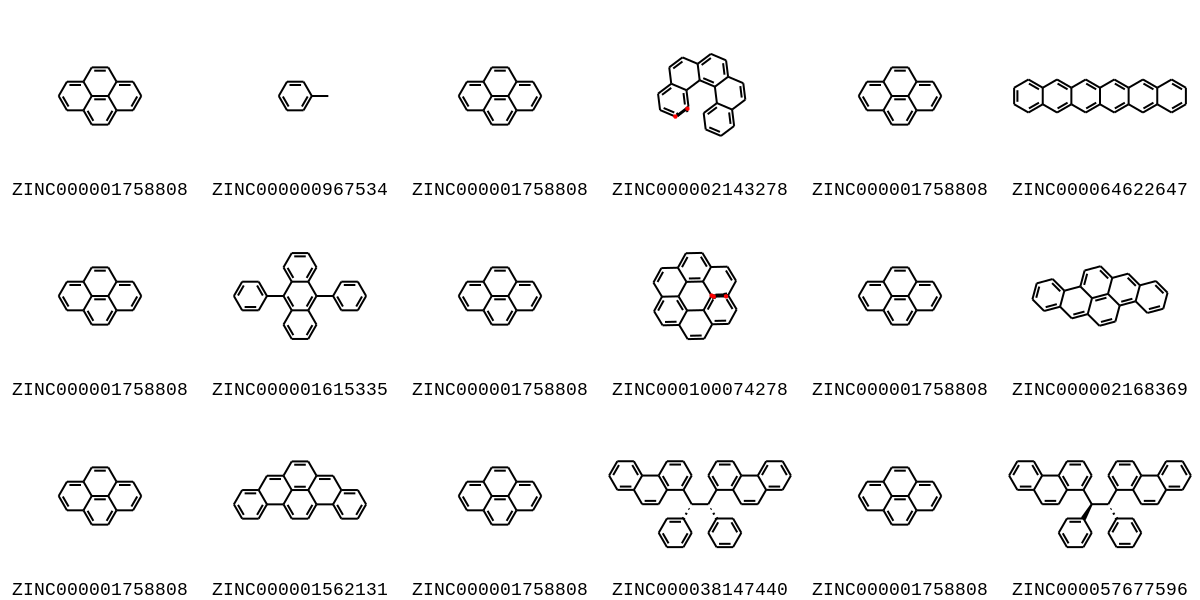

In [ ]:
# Show all the combinatios with pyrene
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

options = DrawingOptions()
options.legendFontSize = 18

pyrene=[]

for x in top_scored.Identifier:
  if dict1[x][0] == 'c1cc2ccc3cccc4ccc(c1)c2c34':
    pyrene.append(x)        
  if dict1[x][1] == 'c1cc2ccc3cccc4ccc(c1)c2c34':
    pyrene.append(x)

pyrene= Remove(pyrene)    

listaki=[]
pyrene_score=[]


for i in pyrene[:9]:                      # select the number of the predictions you want to see
  pyrene_score.append(score_dict[i]) # predictions[predictions.Identifier ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools

merged = list(itertools.chain(*ar))

subms = [Chem.MolFromSmiles(x) for x in merged]
pyrene_img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200), legends=[zinc_dict[x] for x in merged] )
pyrene_img#.save('/content/drive/My Drive/deep_pyrene.png', "PNG")

In [ ]:
pyrene_score

[0.8952230215072632,
 0.8667857646942139,
 0.8640756011009216,
 0.8626813292503357,
 0.8591040372848511,
 0.8586329817771912,
 0.8580498695373535,
 0.8571510314941406,
 0.8571510314941406]

In [ ]:

predictions = list(top_scored['Identifier'])
listaki=[]
for i in predictions[:]:
  listaki.append(dict1[i])

In [ ]:
solvents = ['C1Cc2ccccc12', 'Brc1ccccc1', 'c1ccc2cnncc2c1', 'Cc1ccccc1', 'Cc1ccccc1C']

data2 = pd.DataFrame(listaki)[:].iloc[:, 1]
sol = [x for x in data2 if x in solvents]
data2= pd.DataFrame(sol, columns=['count'])
data2 = pd.DataFrame(data2['count'].value_counts())[:20]
data2

count
Cc1ccccc1       145
Cc1ccccc1C      122
C1Cc2ccccc12     42
Brc1ccccc1       19

In [ ]:
# Count the popularity
data1 = pd.concat([pd.DataFrame(listaki)[:].iloc[:, 0], pd.DataFrame(listaki)[:].iloc[:, 1]])
data1 = pd.DataFrame(listaki)[:].iloc[:, 0]
data1 = [x for x in data1.values if x not in solvents]

data1= pd.DataFrame(data1, columns=['a'])
dat1 = pd.DataFrame(data1['a'].value_counts())[:10]

dat1

a
c1cc2ccc3cccc4ccc(c1)c2c34                153
c1cc2cccc3c4cccc5cccc(c(c1)c23)c45        137
c1ccc2c(c1)ccc3ccc4ccc5ccc6ccccc6c5c4c23  126
c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56      116
c1ccc2c(c1)c3cccc4ccc5cccc2c5c34          113
c1ccc2c(c1)cc3ccc4cc5ccccc5c6ccc2c3c46    106
c1ccc2cc3c4cccc5ccc6cccc(c3cc2c1)c6c45    105
c1ccc2c(c1)ccc3ccc4ccccc4c23              104
c1ccc2c(c1)ccc3ccccc23                    102
c1ccc2cc3ccccc3cc2c1                      101

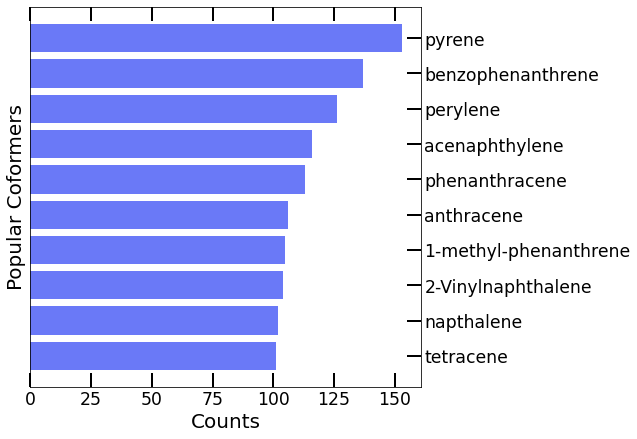

In [ ]:
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False
rcParams['patch.edgecolor'] = 'black'

fig, ax = plt.subplots(figsize=(7,7))
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')



x = ['pyrene',  'benzophenanthrene',  'perylene','acenaphthylene', 'phenanthracene', 'anthracene',        
       '1-methyl-phenanthrene', '2-Vinylnaphthalene', 'napthalene', 'tetracene']

energy = dat1.a
x_pos = [i for i, _ in enumerate(x)]

idx = np.asarray([i for i in range(len(x))])                 
#ax.set_yticks(idx)
ax.yaxis.set_label_position("left")
ax.yaxis.tick_right()

plt.barh(x_pos, energy, color='#6a79f7')
plt.gca().invert_yaxis()
plt.ylabel("Popular Coformers",fontsize=20, fontweight='normal')
plt.xlabel("Counts" ,fontsize=20,  fontweight='normal')

plt.yticks(x_pos, x)

#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/bar_pop.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

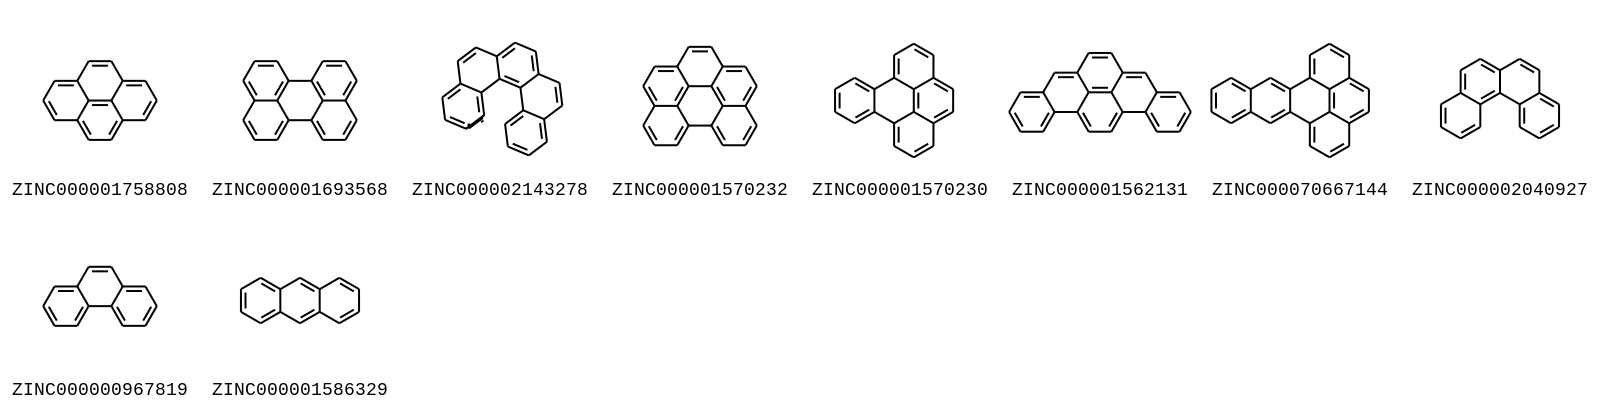

In [ ]:
# Visualize the popular co-formers
smi= dat1.index 
subms1 = [Chem.MolFromSmiles(x) for x in smi]


img=Draw.MolsToGridImage(subms1,molsPerRow=8,subImgSize=(200,200), legends=[zinc_dict[x] for x in smi])
img   

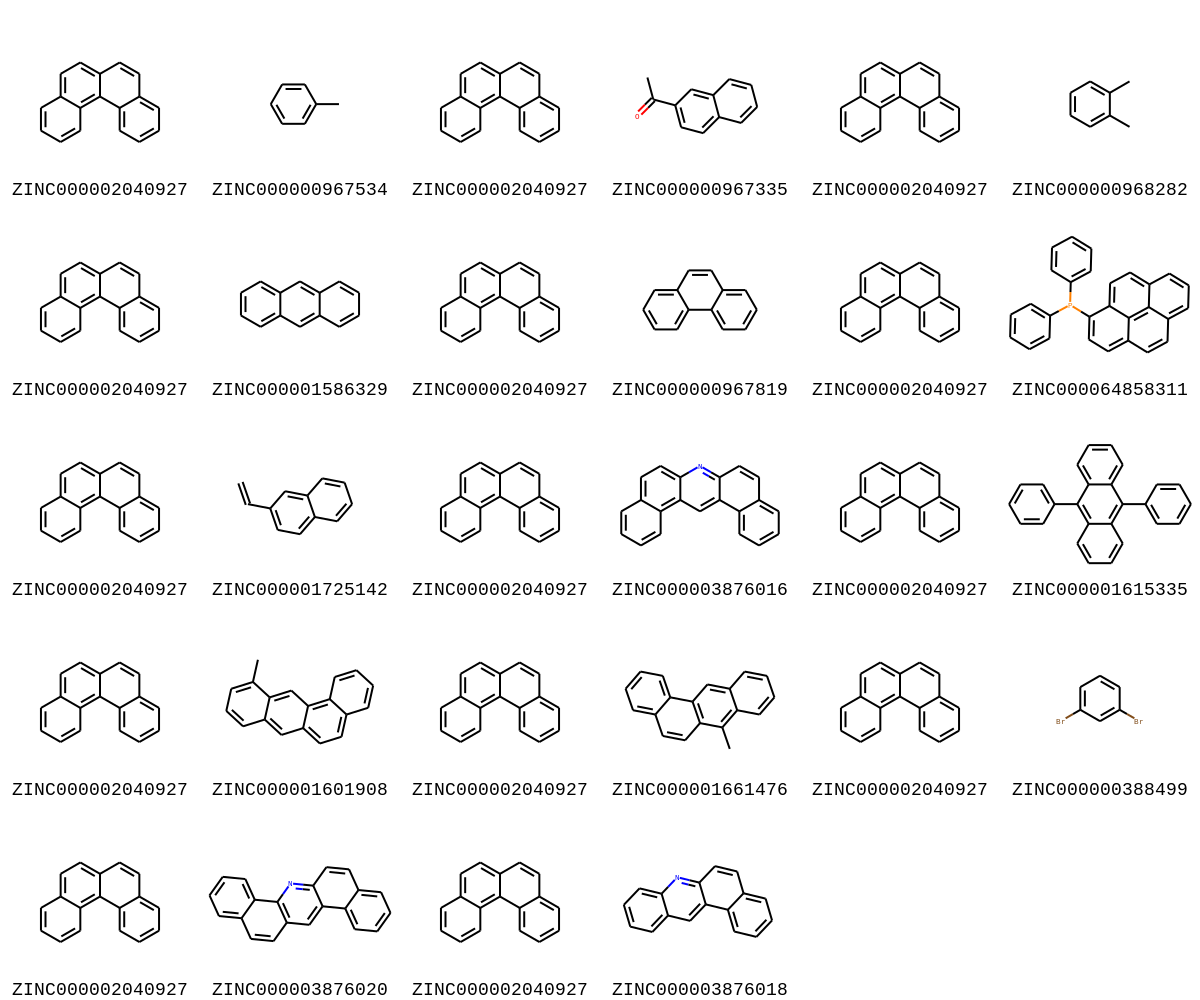

In [ ]:
# Show all the combinatios with pyrene
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

options = DrawingOptions()
options.legendFontSize = 18

pyrene=[]
#pred=[x for x in predictions1.Identifier if x not in ]

for x in top_scored.Identifier:
  if dict1[x][0] == 'c1ccc2c(c1)ccc3ccc4ccccc4c23':
    pyrene.append(x)        
  #if dict1[x][1] == 'c1ccc2c(c1)ccc3ccc4ccccc4c23':
   # pyrene.append(x)

pyrene= Remove(pyrene)    

listaki=[]
pyrene_score=[]


for i in pyrene[:14]:                      # select the number of the predictions you want to see
  pyrene_score.append(score_dict[i]) # predictions[predictions.Identifier ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
pyrene_img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200), legends=[zinc_dict[x] for x in merged] )
pyrene_img#.save('/content/drive/My Drive/deep_popular1.png', "PNG")

In [ ]:
pyrene_score

[0.874030590057373,
 0.874030590057373,
 0.874030590057373,
 0.8660377264022827,
 0.8569129109382629,
 0.8533876538276672,
 0.8530422449111938,
 0.8513883948326111,
 0.8497222661972046,
 0.8490604162216187,
 0.8479151725769043,
 0.8468257188796997,
 0.8463200330734253,
 0.8455288410186768]

In [ ]:
pyrene_score

[0.874030590057373,
 0.874030590057373,
 0.874030590057373,
 0.8660377264022827,
 0.8569129109382629,
 0.8533876538276672,
 0.8530422449111938,
 0.8513883948326111,
 0.8497222661972046,
 0.8490604162216187,
 0.8479151725769043,
 0.8468257188796997,
 0.8463200330734253,
 0.8455288410186768]

In [ ]:
pyrene=[]
for x in predictions[:]:
  if dict1[x][0] == 'c1cc2ccc3cccc4ccc(c1)c2c34':     # if you want to check other molecules just change the two smiles here
    pyrene.append(x)        
  if dict1[x][1] == 'c1cc2ccc3cccc4ccc(c1)c2c34':     # and here
    pyrene.append(x)

pyrene= Remove(pyrene)    
listaki2=[]
pyrene_score=[]

for i in pyrene[:]:       # select the number of the predictions you want to see
  pyrene_score.append(score_dict[i])
  listaki2.append(dict1[i])
   
ar=np.array(listaki2)
ar=ar.tolist()

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
pyrene_img = Draw.MolsToGridImage(subms,molsPerRow=2 ,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])

/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


In [ ]:
df_pyrene  = pd.concat([pd.DataFrame(pyrene, columns=['combination_id']), 
                       pd.DataFrame(pyrene_score, columns=['score'])], axis=1) #  pd.DataFrame(zinc_id, columns=['zinc_id1']), pd.DataFrame(zinc_id2, columns=['zinc_id2']), 
df_pyrene


combination_id     score
0         comb1753  0.878237
1         comb1754  0.878237
2         comb1751  0.878237
3         comb1801  0.870528
4         comb1816  0.858470
..             ...       ...
145       comb1800  0.698221
146       comb1775  0.694306
147       comb1771  0.692254
148       comb1669  0.691276
149       comb1679  0.688808

[150 rows x 2 columns]

In [ ]:
# Set the HTML table properties
td_props = [
  ('font-size', '20px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('border', '1px solid black')
  ]

th_props = [
  ('font-size', '18px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#b6ffbb'),
  ('border', '10px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

In [ ]:
num_of_comb= len(pyrene)
listaki_2 = []
for i in range(num_of_comb):
    y = i * 200
    listaki_2.append(pyrene_img.crop((0, y, 400, y + 200)))


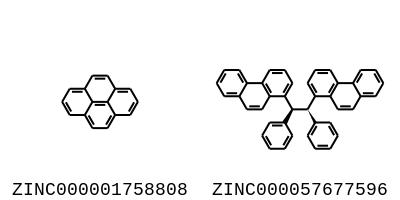
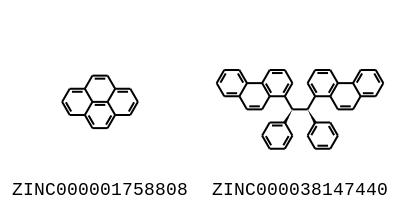
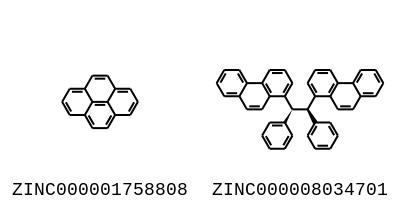
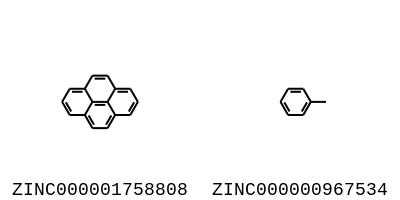
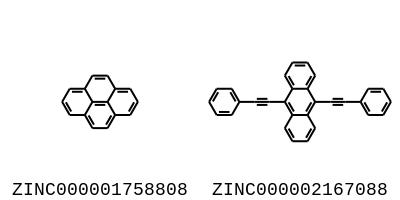

In [ ]:
import glob
import random
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'
images = listaki_2
df_pyrene['molecular pairs'] = images

# convert your links to html tags 
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

html = (df_pyrene.iloc[:,:].head().style
               .set_table_styles(styles)
               .format({'molecular pairs': image_formatter})
               .render())
HTML(html)

#Interpretability

In [ ]:
threshold = pd.DataFrame(unlab_final.describe().loc['75%'].astype(float)).iloc[0].values[0]
proba_ = unlab_final.sort_values(by = ['test_score'], ascending=True)
top_scored = unlab_final[unlab_final['test_score'] > threshold]
top_scored = top_scored.sort_values(by='test_score', ascending=False)
len(top_scored)

5434

In [ ]:
df1=dataset1.iloc[:,2:]
df2=dataset2.iloc[:,2:]
df_concat = pd.concat([df1, df2])
df1 = df1.fillna(df_concat.mean())

df2 = df2.fillna(df_concat.mean())
df1=df1.dropna(axis=1)
df2=df2[df1.columns.values]
df = concat_bidirectional(df1,df2)


In [ ]:
uf1=pd.concat([final_1, final_2], axis =1)
comb=[]
for i in range(1,final_1.shape[0]+1):
  comb.append('comb%s' % i)
uf_final1=pd.concat([pd.DataFrame(comb, columns=['comb']),final_1, final_2 ], axis=1)
#uf_final1

In [ ]:
test_score = unlab_final #pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabelled_deep.csv')
test_score['test_score'][test_score['test_score'] < 0] = 0
unlab = pd.concat([pd.DataFrame(uf_final1.comb.values, columns=['Identifier']), pd.DataFrame(test_score.test_score, columns=['test_score'])], axis=1)
combinations = unlab[unlab.test_score> threshold].Identifier.values
len(combinations) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


5434

In [ ]:
threshold

0.6883517205715179

In [ ]:
test = uf_final1[uf_final1.comb.isin(combinations)]
test_all =  uf_final1[~uf_final1.comb.isin(combinations)]

In [ ]:
#test=test[~test.comb.isin(h2.comb.values)]
#test=test[test.comb != 'comb5466']

In [ ]:
def feature(feat):
  data = pd.concat([pd.DataFrame(df[feat].iloc[:, 0].values, columns=['x']),pd.DataFrame(df[feat].iloc[:, 1].values, columns=['y']) ], axis=1)
  data['label'] = 'labeled'

  data1 = pd.concat([pd.DataFrame(test[feat].iloc[:, 0].values, columns=['x']),pd.DataFrame(test[feat].iloc[:, 1].values, columns=['y']) ], axis=1)
  data1['label'] = 'inliers'

  data2 = pd.concat([pd.DataFrame(test_all[feat].iloc[:, 0].values, columns=['x']),pd.DataFrame(test_all[feat].iloc[:, 1].values, columns=['y']) ], axis=1)
  data2['label'] = 'unlabeled'

  data_all = pd.concat([data, data1, data2])
  return data_all

data_all = feature('Pol')

In [ ]:
data_all = feature('Vx')
hmm = pd.concat([pd.DataFrame(combinations, columns=['comb']), data_all[data_all.label == 'inliers'] ], axis=1)
h1 = hmm[hmm.x>400]
h2= h1[h1.y>400]
h2

comb        x        y    label
5009  comb18549  425.482  443.522  inliers

In [ ]:

data_all = feature('Pol')
hmm = pd.concat([pd.DataFrame(combinations, columns=['comb']), data_all[data_all.label == 'inliers'] ], axis=1)
h1 = hmm[hmm.x>50]
h2= h1[h1.y>50]
h2

comb     x     y    label
1590   comb5537  62.0  58.0  inliers
1654   comb5716  72.0  58.0  inliers
4884  comb17820  58.0  59.0  inliers

In [ ]:
data_all = feature('Se')
hmm = pd.concat([pd.DataFrame(combinations, columns=['comb']), data_all[data_all.label == 'inliers'] ], axis=1)
h1 = hmm[hmm.x>40]
h2= h1[h1.y>40]
h2

comb       x       y    label
5009  comb18549  41.069  42.952  inliers

In [ ]:
# Dictionary assinign to each combination of the unlabelled dataset the smiles of the molecular pairs
dictionary = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/dictionary.csv')
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict1= {key:value for key, value in zip(k1, v1)}
#print(dict1['comb4185'])

In [ ]:
for i in h2.comb:
  print(dict1[i])

['c1ccc2cc3cc4cc5cc6ccccc6cc5cc4cc3cc2c1'
 'c1ccc(cc1)c2c3ccccc3c(c4ccccc4)c5ccccc25']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


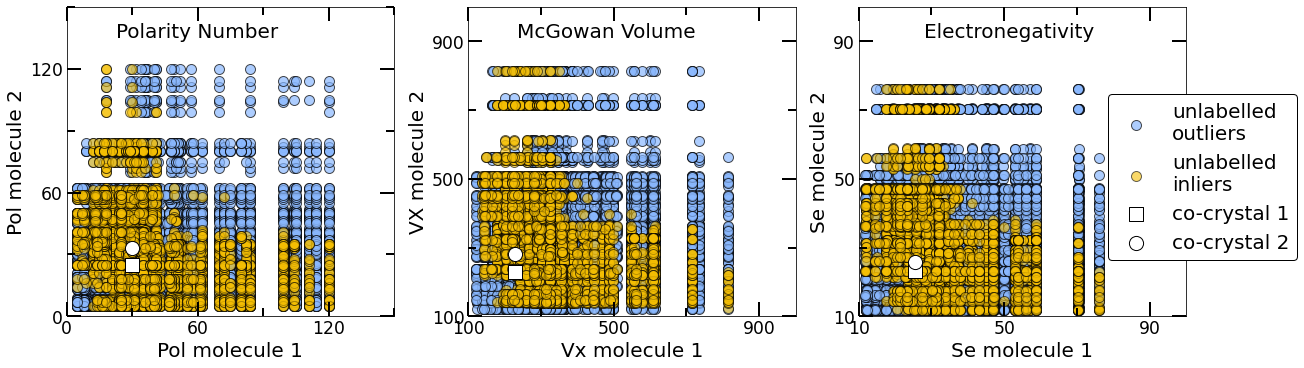

In [ ]:
import matplotlib.font_manager
from matplotlib import cm
from scipy.stats import gaussian_kde
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"
fig, axes = plt.subplots(figsize=(18,5),nrows=1, ncols=3,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
ax0, ax1, ax2= axes.flatten()

top = cm.get_cmap('viridis', 128)
bottom = cm.get_cmap('Wistia', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0.2, 1, 128))))
#newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Polarity
data_all = feature('Pol')
data = data_all[data_all.label == 'unlabeled']
x1=data_all[data_all.label == 'inliers']['x']
y1=data_all[data_all.label == 'inliers']['y']
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
ax0.scatter(data.x, data.y,s=100, alpha=0.7, color='#8ab8fe', edgecolors='black' )#, label = 'Unlabelled')
ax0.text(0.15, 0.9, 'Polarity Number', transform=ax0.transAxes, ha="left" ,fontsize=20)
#plt.scatter(x,y, edgecolors='black', c=z,  cmap=plt.cm.Wistia ,s=200, label = 'Labeled')  #'orange' #'xkcd:tangerine'
#sns.scatterplot(x='x', y='y', data = data_all[data_all.label == 'inliers'],   s=50, alpha=1, c=z , edgecolor='black' ,ax=ax)# , label = 'Highly Scored Part of Unlabelled Dataset') #xkcd:tangerine
ax0.axis(aspect='equal')
ax0.set(adjustable='box')#, aspect='equal')
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.axis('on')
ax0.scatter(x1, y1,   s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers')#, label='Inliers')#plt.cm.Wistia)#, zorder=2)
# Experomental Compounds
ax0.scatter(30, 25, color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
ax0.scatter(30, 33, color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.set_xlabel("Pol molecule 1",fontsize=20)
ax0.set_ylabel("Pol molecule 2",fontsize=20)
ax0.set_xlim(0, 150)
ax0.set_ylim(0, 150)
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction = 'in')
major_ticks_x = np.arange(0, 150.1, 60)
minor_ticks_x = np.arange(0, 150.1, 30)
major_ticks_y = np.arange(0, 150.1, 60)
minor_ticks_y = np.arange(0, 150.1, 30)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)

#Volume
data_all = feature('Vx')
data = data_all[data_all.label  == 'unlabeled']
x1=data_all[data_all.label == 'inliers']['x']
y1=data_all[data_all.label == 'inliers']['y']

#x1y1 = np.vstack([x1,y1])
#z = gaussian_kde(x1y1)(x1y1)
ax1.scatter(data.x, data.y,s=100, alpha=0.7, color='#8ab8fe', edgecolors='black')
ax1.scatter(x1, y1,   s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers') #, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax1.text(0.15, 0.9, 'McGowan Volume', 
        transform=ax1.transAxes, ha="left" ,fontsize=20)
ax1.axis(aspect='equal')
ax1.set(adjustable='box')#, aspect='equal')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.axis('on')
# Experomental COmpounds
ax1.scatter(227.911, 228.115, color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
ax1.scatter(227.911, 281.964, color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.set_xlabel("Vx molecule 1",fontsize=20)
ax1.set_ylabel("VX molecule 2",fontsize=20)
ax1.set_xlim(100, 1000)
ax1.set_ylim(100, 1000)
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True , direction = 'in')
major_ticks_x = np.arange(100, 1000.1, 400)
minor_ticks_x = np.arange(100, 1000.1, 200)
major_ticks_y = np.arange(100, 1000.1, 400)
minor_ticks_y = np.arange(100, 1000.1, 200)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)

#Electronic
data_all = feature('Se')
data = data_all[data_all.label  == 'unlabeled']
x1=data_all[data_all.label == 'inliers']['x']
y1=data_all[data_all.label == 'inliers']['y']
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
ax2.scatter(data.x, data.y,s=100, alpha=0.7, color='#8ab8fe', edgecolors='black', label = 'unlabelled\noutliers' )
ax2.axis(aspect='equal')
ax2.set(adjustable='box')#, aspect='equal')
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.axis('on')
ax2.scatter(x1, y1,  s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='unlabelled\ninliers')

ax2.text(0.2, 0.9, 'Electronegativity', transform=ax2.transAxes, ha="left" ,fontsize=20)
# Experomental Compounds
ax2.scatter(25.418, 23.183, color='white', s=200, label='co-crystal 1',marker = 's', edgecolors='black')
ax2.scatter(25.418, 25.854, color='white', s=200,marker = 'o', label='co-crystal 2',edgecolors='black')         
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.set_xlabel("Se molecule 1",fontsize=20)
ax2.set_ylabel("Se molecule 2",fontsize=20)
ax2.set_xlim(10, 100)
ax2.set_ylim(10, 100)
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(10, 100, 40)
minor_ticks_x = np.arange(10, 100, 20)
major_ticks_y = np.arange(10, 100, 40)
minor_ticks_y = np.arange(10, 100, 20)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)

ax2.set_yticks(minor_ticks_y, minor=True)
#ax2.legend(loc='lower left', bbox_to_anchor= (0.8, 0.45), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
plt.legend( bbox_to_anchor= (0.73, 0.75), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/figure9_unlab_new.png', dpi=600)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


NameError: ignored

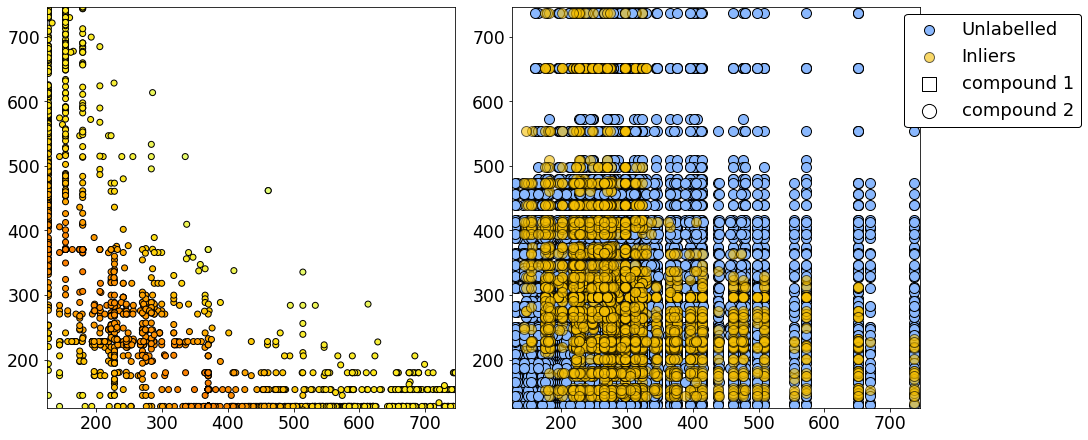

In [ ]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
import matplotlib.font_manager
from matplotlib import rcParams
import matplotlib.pyplot as plt


def feature_distribution(descriptor):
  fig, axes = plt.subplots(figsize=(15,6),nrows=1, ncols=2,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
  ax1, ax0= axes.flatten()
  data_all = feature(descriptor)
  data = data_all[data_all.label == 'unlabeled']
  ax0.scatter(data.x, data.y,s=100, alpha=1, color='#8ab8fe', edgecolors='black' , label = 'Unlabelled')
  ax0.axis(aspect='equal')
  ax0.set(adjustable='box')
  ax0.grid(False)
  ax0.set_facecolor('xkcd:white')
  ax0.spines['bottom'].set_color('black')
  ax0.spines['top'].set_color('black')
  ax0.spines['right'].set_color('black')
  ax0.spines['left'].set_color('black')
  ax0.axis('on')
  ax0.scatter(data_all[data_all.label == 'inliers']['x'], data_all[data_all.label == 'inliers']['y'], s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers')
  
  # Experimental Compounds
  ax0.scatter(uf_final[uf_final.Identifier == 'comb1799'][descriptor].iloc[:, 0], uf_final[uf_final.Identifier == 'comb1799'][descriptor].iloc[:, 1], color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
  ax0.scatter(uf_final[uf_final.Identifier == 'comb1817'][descriptor].iloc[:, 0], uf_final[uf_final.Identifier == 'comb1817'][descriptor].iloc[:, 1], color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
  ax0.grid(False)
  ax0.set_facecolor('xkcd:white')
  ax0.set_xlim(data.min()[0]-5, data.max()[0]+10)
  ax0.set_ylim(data.min()[0]-5, data.max()[0]+10)
  ax0.legend(loc= (0.96, 0.7), ncol=1, fontsize=18, facecolor='white', framealpha=1, edgecolor='black')

  x1=data_all[data_all.label == 'labeled']['x']
  y1=data_all[data_all.label == 'labeled']['y']
  x1y1 = np.vstack([x1,y1])
  z = gaussian_kde(x1y1)(x1y1)
  ax1.scatter(x1,y1, edgecolors='black', c=z,  cmap=plt.cm.Wistia, label='Labeled')
  ax1.set_xlim(data.min()[0]-5, data.max().any()+10)
  ax1.set_ylim(data.min()[0]-5, data.max().any()+10)
  red_circle = Line2D([0], [0], marker='o', color='w', label='Labelled',
                        markerfacecolor='#c87606', markersize=15),
  ax1.legend(handles=red_circle,  loc= (0.55, 0.8), ncol=1, fontsize=18, facecolor='white', framealpha=1, edgecolor='black')


  fig.text(0.5, -0.05, '%s molecule 1'%descriptor, ha='center',fontsize=20 )
  fig.text(-0.02, 0.5, '%s molecule 2'%descriptor, va='center', rotation='vertical', fontsize=20)


  major_ticks_x = np.arange(data.min()[0]-5, data.max()[0]+0.1, data.max().any()/2)
  minor_ticks_x = np.arange(data.min()[0]-5, data.max()[0]+0.1,data.max().any()/4)
  major_ticks_y = np.arange(data.min()[0]-5, data.max()[0]+0.1, data.max().any()/2)
  minor_ticks_y = np.arange(data.min()[0]-5, data.max()[0]+0.1, data.max().any()/4)
  for ax in axes.flatten():
    set_spines(ax)
    set_ticks(ax,major_ticks_x, major_ticks_y, minor_ticks_y, minor_ticks_x )
  #fig.tight_layout(pad=3)


def set_ticks(ax,major_ticks_x, major_ticks_y, minor_ticks_y, minor_ticks_x ):
    ax.tick_params(axis='both', which='both', direction="in", width=2)
    ax.tick_params(axis='both', which='major', direction="in",  length=14)
    ax.tick_params(axis='both', which='minor', length=8,
                   direction="in",  color='black')
    ax.tick_params(axis='both', which='both', bottom=True,
                   top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.xaxis.get_major_ticks()[0].draw = lambda *args:None


def set_spines(ax):
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')



feature_distribution('SAtot')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


NameError: ignored

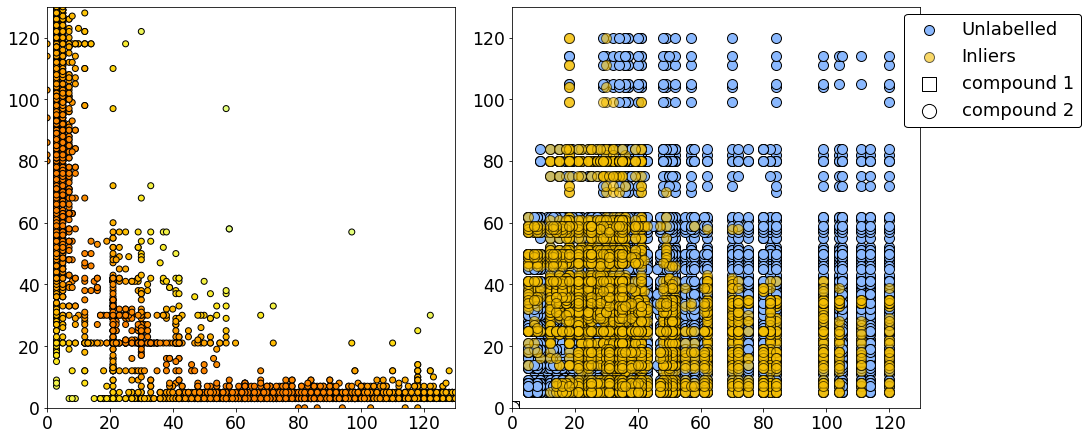

In [ ]:
# Polarity Descriptors
polarity_descr = ['Pol', 'UNIP', 'TPSA(Tot)', 'SAtot']

for i in polarity_descr:
  feature_distribution(i)
  plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


NameError: ignored

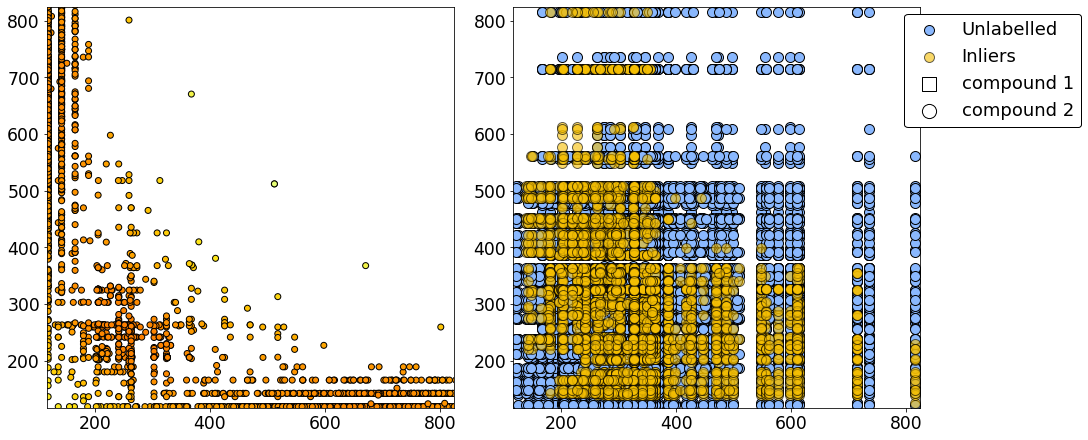

In [ ]:
# Size descriptors
size_descr = ['Vx', 'Sv', 'VvdwMG']

for i in size_descr:
  feature_distribution(i)
  plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


NameError: ignored

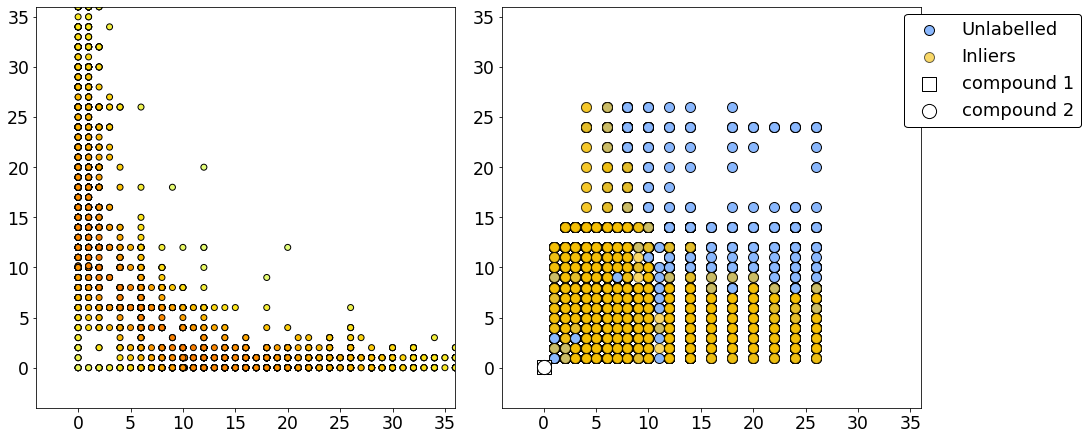

In [ ]:
# Shape descriptors
shape_descr = ['Ram', 'Eta_B' ]

for i in shape_descr:
  feature_distribution(i)
  #plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


NameError: ignored

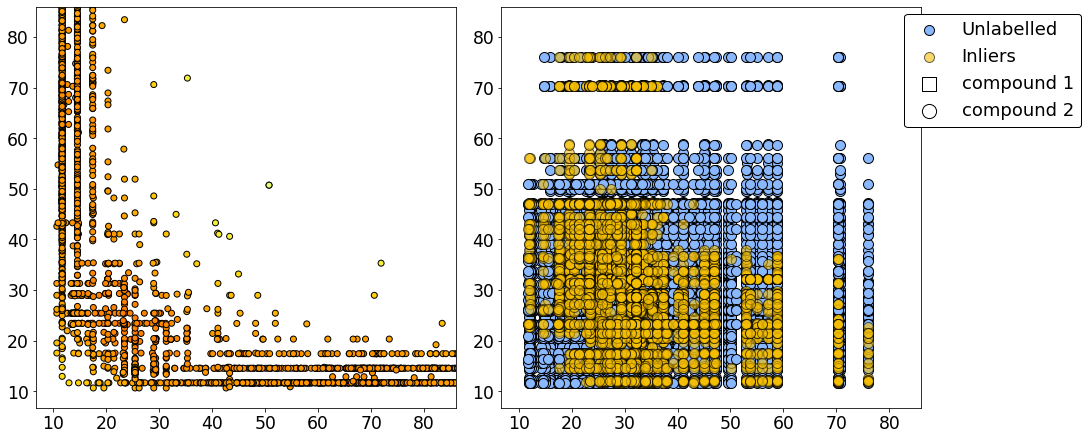

In [ ]:
# Electronic properties descriptors
electr_descr = ['Se', 'Si', 'DELS', 'Sp']

for i in electr_descr:
  feature_distribution(i)
  plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

In [ ]:
%cd /content/drive/My Drive/cocrystal_design-master/figures

/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/figures


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


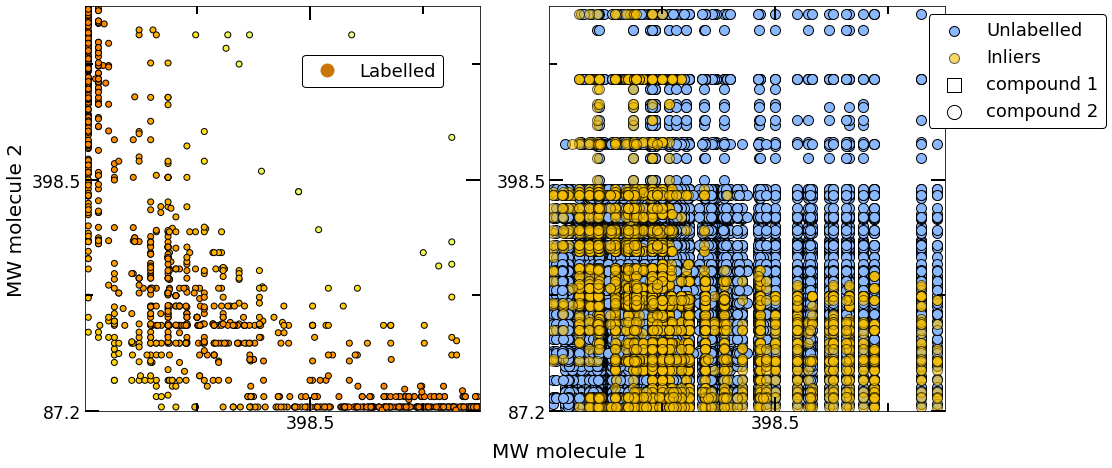

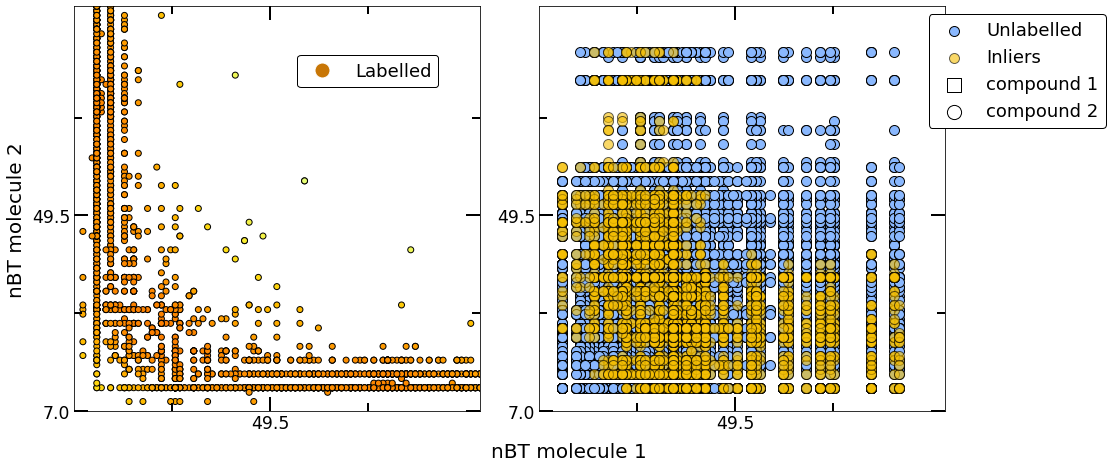

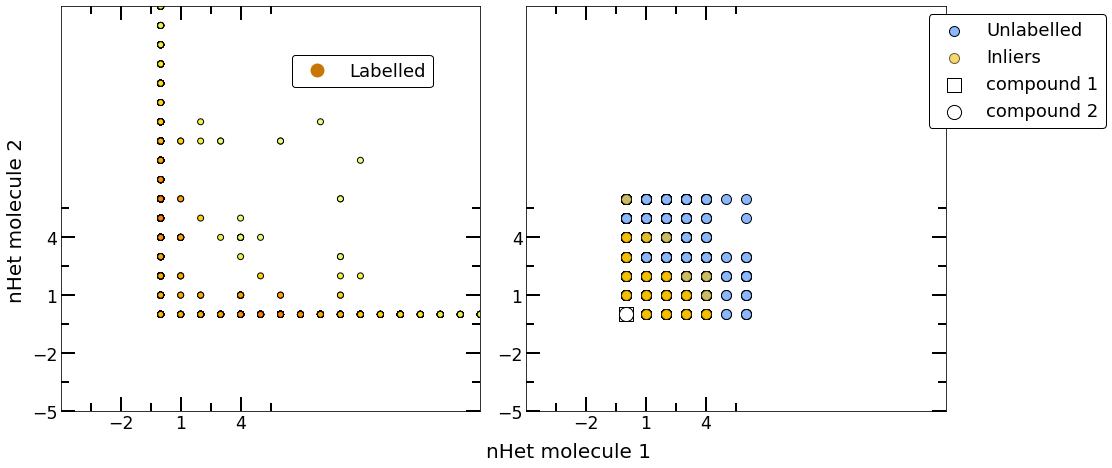

In [ ]:
# General descriptors
general_descr =['MW', 'nBT', 'nHet']

for i in general_descr:
  feature_distribution(i)
  plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

In [ ]:
labelled=df.iloc[:, 1:]

# Evaluation

In [ ]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design-master/models/deep_one_class/src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
#from utils.visualization.plot_images_grid import plot_images_grid
import deepSVDD
from base.base_net import BaseNet


/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class/src/set_transformer
/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class/src


In [ ]:
INPUT_DIM = 3714

class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if data is None:
          self.data=labelled.values.astype('f')

        else:
          #self.data = pd.concat([pd.concat([pd.DataFrame(data).iloc[:, 1857:],pd.DataFrame(data).iloc[:,:1857] ], axis=1),
           #                     pd.concat([pd.DataFrame(data).iloc[:, :1857], pd.DataFrame(data).iloc[:,1857:] ], axis=1)  ]).values.astype('f')
 
          #
          self.data = data.values.astype('f')
        self.labels = np.zeros(self.data.shape[0])
          

    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [ ]:
INPUT_DIM =  1857

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=1857, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=5),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))
        
    def forward(self, x):
      x = torch.split(x, 1857, dim=1)     
      x= torch.stack(x).transpose(0,1) 
      return self.seq(x).squeeze()

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder =  nn.Sequential( nn.Linear(in_features=100, out_features=500), nn.LeakyReLU(),
       nn.Linear(in_features=500, out_features=1000),nn.LeakyReLU(),
        nn.Linear(in_features=1000, out_features=1857),nn.LeakyReLU(),
          nn.Linear(in_features=1857, out_features=3714), nn.Sigmoid())
        
        
        # nn.Sequential(nn.Linear(in_features=100, out_features=3714), nn.Sigmoid())

        self.decoder.apply(init_weights)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()
    #return nn.Sequential()~

def build_network(net_name):
  
  return PairsEncoder()
    #return nn.Sequential()
torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [ ]:

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [ ]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': 0, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'} )

In [ ]:
#df = pd.read_pickle("/content/drive/My Drive/cocrystal_design-master/data/df_labelled_scaled.pkl")
labelled = df.iloc[:, 1:]

In [ ]:
dataset_name = cfg.settings['dataset_name']
#data_path = cfg.settings['data_path']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0
#xp_path = cfg.settings['xp_path']
dataset = Pairs_Dataset('', data=df.iloc[:, 1:])

In [ ]:
torch.manual_seed(0)
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from sklearn import metrics
scores1=[]

def Average(lst): 
    return sum(lst) / len(lst) 
def deep_one_test(trainer, dataset: Pairs_Dataset(''), net: BaseNet, threshold=None):
        logger = logging.getLogger()
        nu = 0.05
        # Set device for network
        device = 'cuda'
        net = net.to(trainer.device)        
        if threshold == None:
          threshold = get_R(trainer, dataset, net, nu)           
        
        #print('Thres:', threshold)
        # Get test data loader
        _, test_loader = dataset.loaders(batch_size=trainer.batch_size, num_workers=trainer.n_jobs_dataloader)

        # Testing
        logger.info('Starting testing...')
        #start_time = time.time()
        idx_label_score = []
        net.eval()
        
        all_scores=[]
        with torch.no_grad():
             
          for data in test_loader:
            inputs, labels, idx = data
                
                #labels = np.zeros(pd.DataFrame(labels).shape[0])
            inputs = inputs.to(trainer.device)
            outputs = net(inputs)
            dist = torch.sum((outputs - trainer.c) ** 2, dim=1)
            if trainer.objective == 'soft-boundary':
              scores = dist - trainer.R ** 2
            else:
             scores = dist.cpu().numpy()
             all_scores.append(scores)
        
        scores = np.concatenate(all_scores)
        #print(scores)
       
        #print('threshold', threshold)
        scores = np.array(scores)
        #print(np.min(scores), np.mean(scores), np.median(scores), np.max(scores))
        
        scores = (scores > threshold ).astype(np.int)
        score = (scores == 0).sum()

        # Compute AUC
        labels = np.zeros_like(scores)
        trainer.test_auc = metrics.accuracy_score(labels, scores, normalize=True)
        logger.info('Test set accuracy: {:.2f}%'.format(100*trainer.test_auc))
        scores1  = (100*trainer.test_auc)

        #print("Average Accuracy: {:.2f}%".format(Average(scores1)))
        #print("Standard Deviation: {:.2f}%".format(np.std(scores1)))
        logger.info('Finished testing.')
        return labels, scores, scores1, threshold

In [ ]:
from optim.ae_trainer import AETrainer
def pretrain(deepSVDD, dataset, optimizer_name: str = 'adam', lr: float = 1e-5, n_epochs: int = 50,
             lr_milestones: tuple = (), batch_size: int = 200, weight_decay: float = 1e-3, device: str = 'cuda',
             n_jobs_dataloader: int = 0):
    """Pretrains the weights for the Deep SVDD network \phi via autoencoder."""

    deepSVDD.ae_net = build_autoencoder(deepSVDD.net_name)
    deepSVDD.ae_optimizer_name = optimizer_name
    deepSVDD.ae_trainer = AETrainer(optimizer_name, lr=lr, n_epochs=n_epochs, lr_milestones=lr_milestones,
                                batch_size=batch_size, weight_decay=weight_decay, device=device,
                                n_jobs_dataloader=n_jobs_dataloader)
    deepSVDD.ae_net = deepSVDD.ae_trainer.train(dataset, deepSVDD.ae_net)
    deepSVDD.init_network_weights_from_pretraining()

In [ ]:
def get_R(trainer, dataset, net, nu):
    net = net.to(trainer.device)
    train_loader, _ = dataset.loaders(batch_size=trainer.batch_size, num_workers=trainer.n_jobs_dataloader)
    
    all_scores = []
    with torch.no_grad():
        for data in train_loader:
            inputs, _, _ = data
            inputs = inputs.to(trainer.device)
            outputs = net(inputs)
            dist = torch.sum((outputs - trainer.c) ** 2, dim=1)
            all_scores.append(dist.cpu().numpy())
            
    scores = np.concatenate(all_scores)
    return np.percentile(scores, 100*(1-nu))

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from random import Random

score_tot=[]

def test_net(train, test):
  dataset = Pairs_Dataset('', train, test, df.iloc[:, 1:])
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  #pretrain(deep_SVDD, dataset, n_epochs= 60) #60
  deep_SVDD.pretrain(dataset, optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,
                   n_epochs = 60 , 
                  lr_milestones=(100,),
                   batch_size=200, 
                   weight_decay=0.5e-3,  
                   device=device,
                   n_jobs_dataloader=0)
    
  pred_train = deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 60,
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
               device=device,
              n_jobs_dataloader=n_jobs_dataloader)
  
  #deep_SVDD.train(dataset,n_epochs= 60)
  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  return scores1


# Perform k-fold cross validation
X_train_val=pd.DataFrame(df.iloc[:, 1:].values)
Random(0).shuffle(X_train_val)
kf = KFold(n_splits = 5,  shuffle=False)#, random_state=0)
kf.get_n_splits(X_train_val)
scores2=[]
 
n = np.linspace(.05, 1.0, 20)    #0.01
set_seed()
for train, test in kf.split(X_train_val):
  scores2=[]
  #Random(0).shuffle(train)
  for i in X_train_val.shape[0]* n:
    print('size:', i)    
    #Random(0).shuffle(train)
    trainX = train[:int(i)]
    scores1 = test_net(trainX, test)
    scores2.append(scores1)
  score_tot.append(scores2)

size: 172.20000000000002


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/60	 Time: 0.020	 Loss: 555.27691650
INFO:root:  Epoch 2/60	 Time: 0.018	 Loss: 543.75744629
INFO:root:  Epoch 3/60	 Time: 0.020	 Loss: 534.80865479
INFO:root:

size: 344.40000000000003


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.039	 Loss: 544.14443970
INFO:root:  Epoch 2/60	 Time: 0.038	 Loss: 526.56173706
INFO:root:  Epoch 3/60	 Time: 0.036	 Loss: 517.00439453
INFO:root:  Epoch 4/60	 Time: 0.036	 Loss: 511.21588135
INFO:root:  Epoch 5/60	 Time: 0.038	 Loss: 505.91345215
INFO:root:  Epoch 6/60	 Time: 0.037	 Loss: 500.15776062
INFO:root:  Epoch 7/60	 Time: 0.036	 Loss: 493.76193237
INFO:root:  Epoch 8/60	 Time: 0.035	 Loss: 486.36370850
INFO:root:  Epoch 9/60	 Time: 0.035	 Loss: 477.84793091
INFO:root:  Epoch 10/60	 Time: 0.037	 Loss: 468.14649963
INFO:root:  Epoch 11/60	 Time: 0.036	 Loss: 458.20742798
INFO:root:  Epoch 12/60	 Time: 0.039	 Loss: 447.56176758
INFO:root:  Epoch 13/60	 Time: 0.040	 Loss: 435.78547668
INFO:root:  Epoch 14/60	 Time: 0.038	 Loss: 423.34640503
INFO:root:  Epoch 15/60	 Time: 0.038	 Loss: 410.80967712
INFO:root:  Epoch 16/60	 Time: 0.037	 Loss: 397.31535339
INFO:root:  Epoch 17/60	 Time: 0.036	 Loss: 383.00004578
INFO:r

size: 516.6


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.058	 Loss: 557.66335042
INFO:root:  Epoch 2/60	 Time: 0.060	 Loss: 528.57468669
INFO:root:  Epoch 3/60	 Time: 0.055	 Loss: 515.96858724
INFO:root:  Epoch 4/60	 Time: 0.055	 Loss: 509.79433187
INFO:root:  Epoch 5/60	 Time: 0.062	 Loss: 503.88996379
INFO:root:  Epoch 6/60	 Time: 0.055	 Loss: 495.99536133
INFO:root:  Epoch 7/60	 Time: 0.054	 Loss: 486.67087809
INFO:root:  Epoch 8/60	 Time: 0.055	 Loss: 475.31266276
INFO:root:  Epoch 9/60	 Time: 0.056	 Loss: 461.34485881
INFO:root:  Epoch 10/60	 Time: 0.055	 Loss: 446.76320394
INFO:root:  Epoch 11/60	 Time: 0.054	 Loss: 429.78720093
INFO:root:  Epoch 12/60	 Time: 0.055	 Loss: 411.23681641
INFO:root:  Epoch 13/60	 Time: 0.057	 Loss: 391.11581421
INFO:root:  Epoch 14/60	 Time: 0.056	 Loss: 370.12539673
INFO:root:  Epoch 15/60	 Time: 0.054	 Loss: 348.43947347
INFO:root:  Epoch 16/60	 Time: 0.053	 Loss: 326.03942871
INFO:root:  Epoch 17/60	 Time: 0.056	 Loss: 302.46340942
INFO:r

size: 688.8000000000001


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.084	 Loss: 551.69999695
INFO:root:  Epoch 2/60	 Time: 0.076	 Loss: 527.80889893
INFO:root:  Epoch 3/60	 Time: 0.077	 Loss: 517.48604584
INFO:root:  Epoch 4/60	 Time: 0.080	 Loss: 508.54350281
INFO:root:  Epoch 5/60	 Time: 0.079	 Loss: 494.59702301
INFO:root:  Epoch 6/60	 Time: 0.075	 Loss: 478.07261658
INFO:root:  Epoch 7/60	 Time: 0.078	 Loss: 458.45465851
INFO:root:  Epoch 8/60	 Time: 0.078	 Loss: 434.71034241
INFO:root:  Epoch 9/60	 Time: 0.088	 Loss: 407.71408844
INFO:root:  Epoch 10/60	 Time: 0.084	 Loss: 378.96360016
INFO:root:  Epoch 11/60	 Time: 0.079	 Loss: 347.68650818
INFO:root:  Epoch 12/60	 Time: 0.074	 Loss: 315.96897125
INFO:root:  Epoch 13/60	 Time: 0.073	 Loss: 284.17172241
INFO:root:  Epoch 14/60	 Time: 0.076	 Loss: 251.15113068
INFO:root:  Epoch 15/60	 Time: 0.074	 Loss: 222.39381027
INFO:root:  Epoch 16/60	 Time: 0.077	 Loss: 193.24128723
INFO:root:  Epoch 17/60	 Time: 0.085	 Loss: 169.88105774
INFO:r

size: 861.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.099	 Loss: 547.51705322
INFO:root:  Epoch 2/60	 Time: 0.096	 Loss: 524.98027344
INFO:root:  Epoch 3/60	 Time: 0.095	 Loss: 515.12080688
INFO:root:  Epoch 4/60	 Time: 0.098	 Loss: 499.91810303
INFO:root:  Epoch 5/60	 Time: 0.090	 Loss: 480.16582031
INFO:root:  Epoch 6/60	 Time: 0.088	 Loss: 454.22777100
INFO:root:  Epoch 7/60	 Time: 0.093	 Loss: 424.24202881
INFO:root:  Epoch 8/60	 Time: 0.094	 Loss: 387.82136841
INFO:root:  Epoch 9/60	 Time: 0.096	 Loss: 349.76213379
INFO:root:  Epoch 10/60	 Time: 0.094	 Loss: 309.71119385
INFO:root:  Epoch 11/60	 Time: 0.092	 Loss: 268.63895264
INFO:root:  Epoch 12/60	 Time: 0.092	 Loss: 230.84298706
INFO:root:  Epoch 13/60	 Time: 0.093	 Loss: 200.93595886
INFO:root:  Epoch 14/60	 Time: 0.096	 Loss: 165.47264709
INFO:root:  Epoch 15/60	 Time: 0.097	 Loss: 140.74913330
INFO:root:  Epoch 16/60	 Time: 0.092	 Loss: 120.32664032
INFO:root:  Epoch 17/60	 Time: 0.090	 Loss: 104.23587036
INFO:r

size: 1033.2


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.123	 Loss: 541.98865763
INFO:root:  Epoch 2/60	 Time: 0.113	 Loss: 522.16272990
INFO:root:  Epoch 3/60	 Time: 0.110	 Loss: 508.12653605
INFO:root:  Epoch 4/60	 Time: 0.111	 Loss: 485.39770508
INFO:root:  Epoch 5/60	 Time: 0.122	 Loss: 456.16695658
INFO:root:  Epoch 6/60	 Time: 0.118	 Loss: 420.74783325
INFO:root:  Epoch 7/60	 Time: 0.116	 Loss: 377.05633036
INFO:root:  Epoch 8/60	 Time: 0.111	 Loss: 331.26497396
INFO:root:  Epoch 9/60	 Time: 0.116	 Loss: 284.41315206
INFO:root:  Epoch 10/60	 Time: 0.117	 Loss: 238.44010162
INFO:root:  Epoch 11/60	 Time: 0.117	 Loss: 196.11922709
INFO:root:  Epoch 12/60	 Time: 0.112	 Loss: 162.05263265
INFO:root:  Epoch 13/60	 Time: 0.123	 Loss: 130.50828044
INFO:root:  Epoch 14/60	 Time: 0.121	 Loss: 108.37382126
INFO:root:  Epoch 15/60	 Time: 0.123	 Loss: 97.66566722
INFO:root:  Epoch 16/60	 Time: 0.115	 Loss: 80.91940308
INFO:root:  Epoch 17/60	 Time: 0.110	 Loss: 72.42240906
INFO:root

size: 1205.3999999999999


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.140	 Loss: 535.12939889
INFO:root:  Epoch 2/60	 Time: 0.142	 Loss: 517.27728707
INFO:root:  Epoch 3/60	 Time: 0.131	 Loss: 491.33326067
INFO:root:  Epoch 4/60	 Time: 0.135	 Loss: 459.69154576
INFO:root:  Epoch 5/60	 Time: 0.135	 Loss: 419.41649519
INFO:root:  Epoch 6/60	 Time: 0.139	 Loss: 370.39622280
INFO:root:  Epoch 7/60	 Time: 0.138	 Loss: 319.90573992
INFO:root:  Epoch 8/60	 Time: 0.128	 Loss: 274.74882289
INFO:root:  Epoch 9/60	 Time: 0.143	 Loss: 218.00606864
INFO:root:  Epoch 10/60	 Time: 0.153	 Loss: 175.70757839
INFO:root:  Epoch 11/60	 Time: 0.140	 Loss: 142.32838658
INFO:root:  Epoch 12/60	 Time: 0.134	 Loss: 122.90940530
INFO:root:  Epoch 13/60	 Time: 0.139	 Loss: 103.02338845
INFO:root:  Epoch 14/60	 Time: 0.142	 Loss: 105.34985134
INFO:root:  Epoch 15/60	 Time: 0.130	 Loss: 93.82818495
INFO:root:  Epoch 16/60	 Time: 0.130	 Loss: 80.75829261
INFO:root:  Epoch 17/60	 Time: 0.144	 Loss: 77.82798059
INFO:root

size: 1377.6


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.155	 Loss: 535.98927525
INFO:root:  Epoch 2/60	 Time: 0.140	 Loss: 516.45159040
INFO:root:  Epoch 3/60	 Time: 0.149	 Loss: 495.57846069
INFO:root:  Epoch 4/60	 Time: 0.151	 Loss: 464.76325335
INFO:root:  Epoch 5/60	 Time: 0.141	 Loss: 424.52025931
INFO:root:  Epoch 6/60	 Time: 0.138	 Loss: 377.31258719
INFO:root:  Epoch 7/60	 Time: 0.147	 Loss: 327.13418143
INFO:root:  Epoch 8/60	 Time: 0.157	 Loss: 277.79396275
INFO:root:  Epoch 9/60	 Time: 0.140	 Loss: 233.16139875
INFO:root:  Epoch 10/60	 Time: 0.143	 Loss: 195.05467442
INFO:root:  Epoch 11/60	 Time: 0.150	 Loss: 164.32821655
INFO:root:  Epoch 12/60	 Time: 0.147	 Loss: 141.09104483
INFO:root:  Epoch 13/60	 Time: 0.140	 Loss: 124.68408639
INFO:root:  Epoch 14/60	 Time: 0.146	 Loss: 114.46701377
INFO:root:  Epoch 15/60	 Time: 0.150	 Loss: 107.77881731
INFO:root:  Epoch 16/60	 Time: 0.147	 Loss: 103.87780871
INFO:root:  Epoch 17/60	 Time: 0.135	 Loss: 100.96173205
INFO:r

size: 1549.8


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.166	 Loss: 545.33980560
INFO:root:  Epoch 2/60	 Time: 0.163	 Loss: 522.13999176
INFO:root:  Epoch 3/60	 Time: 0.171	 Loss: 501.60748672
INFO:root:  Epoch 4/60	 Time: 0.169	 Loss: 467.72103119
INFO:root:  Epoch 5/60	 Time: 0.165	 Loss: 422.49242401
INFO:root:  Epoch 6/60	 Time: 0.178	 Loss: 368.59289169
INFO:root:  Epoch 7/60	 Time: 0.171	 Loss: 312.26083374
INFO:root:  Epoch 8/60	 Time: 0.160	 Loss: 259.26434326
INFO:root:  Epoch 9/60	 Time: 0.168	 Loss: 212.44539261
INFO:root:  Epoch 10/60	 Time: 0.176	 Loss: 177.40732384
INFO:root:  Epoch 11/60	 Time: 0.165	 Loss: 152.69638824
INFO:root:  Epoch 12/60	 Time: 0.171	 Loss: 135.97497845
INFO:root:  Epoch 13/60	 Time: 0.173	 Loss: 126.04957867
INFO:root:  Epoch 14/60	 Time: 0.160	 Loss: 120.38391304
INFO:root:  Epoch 15/60	 Time: 0.162	 Loss: 116.77612877
INFO:root:  Epoch 16/60	 Time: 0.173	 Loss: 114.89462662
INFO:root:  Epoch 17/60	 Time: 0.167	 Loss: 113.24454594
INFO:r

size: 1721.9999999999998


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.206	 Loss: 540.31823052
INFO:root:  Epoch 2/60	 Time: 0.178	 Loss: 516.06485664
INFO:root:  Epoch 3/60	 Time: 0.206	 Loss: 484.70576986
INFO:root:  Epoch 4/60	 Time: 0.198	 Loss: 438.51996867
INFO:root:  Epoch 5/60	 Time: 0.184	 Loss: 379.65332370
INFO:root:  Epoch 6/60	 Time: 0.197	 Loss: 314.67931790
INFO:root:  Epoch 7/60	 Time: 0.199	 Loss: 252.66808912
INFO:root:  Epoch 8/60	 Time: 0.196	 Loss: 203.09305996
INFO:root:  Epoch 9/60	 Time: 0.201	 Loss: 168.55188497
INFO:root:  Epoch 10/60	 Time: 0.185	 Loss: 147.41576470
INFO:root:  Epoch 11/60	 Time: 0.184	 Loss: 135.27239482
INFO:root:  Epoch 12/60	 Time: 0.197	 Loss: 128.66783396
INFO:root:  Epoch 13/60	 Time: 0.184	 Loss: 124.96991899
INFO:root:  Epoch 14/60	 Time: 0.191	 Loss: 122.93510183
INFO:root:  Epoch 15/60	 Time: 0.196	 Loss: 120.88469442
INFO:root:  Epoch 16/60	 Time: 0.182	 Loss: 119.33687676
INFO:root:  Epoch 17/60	 Time: 0.203	 Loss: 118.38043043
INFO:r

size: 1894.1999999999998


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.228	 Loss: 537.76469116
INFO:root:  Epoch 2/60	 Time: 0.210	 Loss: 515.19569397
INFO:root:  Epoch 3/60	 Time: 0.213	 Loss: 479.35012817
INFO:root:  Epoch 4/60	 Time: 0.204	 Loss: 423.75035400
INFO:root:  Epoch 5/60	 Time: 0.228	 Loss: 355.38808594
INFO:root:  Epoch 6/60	 Time: 0.206	 Loss: 287.19051514
INFO:root:  Epoch 7/60	 Time: 0.207	 Loss: 228.64051819
INFO:root:  Epoch 8/60	 Time: 0.217	 Loss: 183.87784424
INFO:root:  Epoch 9/60	 Time: 0.208	 Loss: 156.53827820
INFO:root:  Epoch 10/60	 Time: 0.217	 Loss: 140.31464081
INFO:root:  Epoch 11/60	 Time: 0.206	 Loss: 132.86494064
INFO:root:  Epoch 12/60	 Time: 0.211	 Loss: 128.49049072
INFO:root:  Epoch 13/60	 Time: 0.227	 Loss: 126.00647202
INFO:root:  Epoch 14/60	 Time: 0.230	 Loss: 124.50119629
INFO:root:  Epoch 15/60	 Time: 0.232	 Loss: 123.74432755
INFO:root:  Epoch 16/60	 Time: 0.212	 Loss: 122.08437653
INFO:root:  Epoch 17/60	 Time: 0.215	 Loss: 122.04114761
INFO:r

size: 2066.4


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.239	 Loss: 534.60105202
INFO:root:  Epoch 2/60	 Time: 0.237	 Loss: 501.95371593
INFO:root:  Epoch 3/60	 Time: 0.229	 Loss: 454.71580089
INFO:root:  Epoch 4/60	 Time: 0.235	 Loss: 386.80380526
INFO:root:  Epoch 5/60	 Time: 0.229	 Loss: 311.36588079
INFO:root:  Epoch 6/60	 Time: 0.246	 Loss: 242.68379211
INFO:root:  Epoch 7/60	 Time: 0.227	 Loss: 192.27230003
INFO:root:  Epoch 8/60	 Time: 0.238	 Loss: 159.64070962
INFO:root:  Epoch 9/60	 Time: 0.233	 Loss: 142.95271440
INFO:root:  Epoch 10/60	 Time: 0.239	 Loss: 134.63360041
INFO:root:  Epoch 11/60	 Time: 0.237	 Loss: 130.69189731
INFO:root:  Epoch 12/60	 Time: 0.232	 Loss: 127.60968018
INFO:root:  Epoch 13/60	 Time: 0.242	 Loss: 126.71653609
INFO:root:  Epoch 14/60	 Time: 0.220	 Loss: 124.98212572
INFO:root:  Epoch 15/60	 Time: 0.251	 Loss: 125.06015916
INFO:root:  Epoch 16/60	 Time: 0.230	 Loss: 124.42721003
INFO:root:  Epoch 17/60	 Time: 0.240	 Loss: 123.60930287
INFO:r

size: 2238.6


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.254	 Loss: 540.98439535
INFO:root:  Epoch 2/60	 Time: 0.267	 Loss: 506.90229289
INFO:root:  Epoch 3/60	 Time: 0.265	 Loss: 461.35574087
INFO:root:  Epoch 4/60	 Time: 0.264	 Loss: 393.79180145
INFO:root:  Epoch 5/60	 Time: 0.245	 Loss: 315.60491689
INFO:root:  Epoch 6/60	 Time: 0.264	 Loss: 242.56414286
INFO:root:  Epoch 7/60	 Time: 0.262	 Loss: 188.18459066
INFO:root:  Epoch 8/60	 Time: 0.259	 Loss: 154.46534475
INFO:root:  Epoch 9/60	 Time: 0.244	 Loss: 137.39338430
INFO:root:  Epoch 10/60	 Time: 0.265	 Loss: 129.60831706
INFO:root:  Epoch 11/60	 Time: 0.257	 Loss: 126.35021528
INFO:root:  Epoch 12/60	 Time: 0.256	 Loss: 124.88918368
INFO:root:  Epoch 13/60	 Time: 0.252	 Loss: 123.34848340
INFO:root:  Epoch 14/60	 Time: 0.257	 Loss: 122.15600459
INFO:root:  Epoch 15/60	 Time: 0.262	 Loss: 122.40431658
INFO:root:  Epoch 16/60	 Time: 0.264	 Loss: 121.81518618
INFO:root:  Epoch 17/60	 Time: 0.260	 Loss: 119.88193130
INFO:r

size: 2410.7999999999997


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.286	 Loss: 535.24917837
INFO:root:  Epoch 2/60	 Time: 0.286	 Loss: 502.60291466
INFO:root:  Epoch 3/60	 Time: 0.285	 Loss: 443.63812256
INFO:root:  Epoch 4/60	 Time: 0.292	 Loss: 359.64253822
INFO:root:  Epoch 5/60	 Time: 0.283	 Loss: 272.78984657
INFO:root:  Epoch 6/60	 Time: 0.286	 Loss: 204.06716802
INFO:root:  Epoch 7/60	 Time: 0.288	 Loss: 162.32023386
INFO:root:  Epoch 8/60	 Time: 0.285	 Loss: 142.20465440
INFO:root:  Epoch 9/60	 Time: 0.284	 Loss: 136.09132151
INFO:root:  Epoch 10/60	 Time: 0.274	 Loss: 130.26290307
INFO:root:  Epoch 11/60	 Time: 0.294	 Loss: 128.64691749
INFO:root:  Epoch 12/60	 Time: 0.281	 Loss: 125.56667739
INFO:root:  Epoch 13/60	 Time: 0.291	 Loss: 125.54552636
INFO:root:  Epoch 14/60	 Time: 0.273	 Loss: 121.90018346
INFO:root:  Epoch 15/60	 Time: 0.294	 Loss: 121.73701712
INFO:root:  Epoch 16/60	 Time: 0.280	 Loss: 120.92059854
INFO:root:  Epoch 17/60	 Time: 0.300	 Loss: 123.69957792
INFO:r

size: 2583.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.293	 Loss: 538.05798340
INFO:root:  Epoch 2/60	 Time: 0.299	 Loss: 504.71452449
INFO:root:  Epoch 3/60	 Time: 0.283	 Loss: 448.40769372
INFO:root:  Epoch 4/60	 Time: 0.295	 Loss: 367.92712168
INFO:root:  Epoch 5/60	 Time: 0.287	 Loss: 282.46447284
INFO:root:  Epoch 6/60	 Time: 0.305	 Loss: 211.72466572
INFO:root:  Epoch 7/60	 Time: 0.309	 Loss: 165.64687758
INFO:root:  Epoch 8/60	 Time: 0.304	 Loss: 142.52338938
INFO:root:  Epoch 9/60	 Time: 0.286	 Loss: 132.73967508
INFO:root:  Epoch 10/60	 Time: 0.294	 Loss: 128.39678720
INFO:root:  Epoch 11/60	 Time: 0.296	 Loss: 126.21984394
INFO:root:  Epoch 12/60	 Time: 0.287	 Loss: 124.86223368
INFO:root:  Epoch 13/60	 Time: 0.293	 Loss: 123.87936988
INFO:root:  Epoch 14/60	 Time: 0.298	 Loss: 123.14031865
INFO:root:  Epoch 15/60	 Time: 0.300	 Loss: 122.36842933
INFO:root:  Epoch 16/60	 Time: 0.284	 Loss: 121.83777736
INFO:root:  Epoch 17/60	 Time: 0.299	 Loss: 121.20075402
INFO:r

size: 2755.2


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.322	 Loss: 534.44806780
INFO:root:  Epoch 2/60	 Time: 0.312	 Loss: 494.01689584
INFO:root:  Epoch 3/60	 Time: 0.316	 Loss: 425.32429286
INFO:root:  Epoch 4/60	 Time: 0.319	 Loss: 333.45873369
INFO:root:  Epoch 5/60	 Time: 0.308	 Loss: 245.37053680
INFO:root:  Epoch 6/60	 Time: 0.322	 Loss: 182.03149414
INFO:root:  Epoch 7/60	 Time: 0.306	 Loss: 147.67670223
INFO:root:  Epoch 8/60	 Time: 0.319	 Loss: 133.26573399
INFO:root:  Epoch 9/60	 Time: 0.318	 Loss: 127.98003605
INFO:root:  Epoch 10/60	 Time: 0.312	 Loss: 125.79053770
INFO:root:  Epoch 11/60	 Time: 0.322	 Loss: 124.38650622
INFO:root:  Epoch 12/60	 Time: 0.311	 Loss: 123.32622365
INFO:root:  Epoch 13/60	 Time: 0.317	 Loss: 122.28642327
INFO:root:  Epoch 14/60	 Time: 0.305	 Loss: 121.51779829
INFO:root:  Epoch 15/60	 Time: 0.310	 Loss: 121.16988754
INFO:root:  Epoch 16/60	 Time: 0.303	 Loss: 120.71063668
INFO:root:  Epoch 17/60	 Time: 0.301	 Loss: 120.16961724
INFO:r

size: 2927.4


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.352	 Loss: 532.58229719
INFO:root:  Epoch 2/60	 Time: 0.323	 Loss: 489.84023612
INFO:root:  Epoch 3/60	 Time: 0.310	 Loss: 418.58020455
INFO:root:  Epoch 4/60	 Time: 0.323	 Loss: 327.08809771
INFO:root:  Epoch 5/60	 Time: 0.330	 Loss: 240.77589417
INFO:root:  Epoch 6/60	 Time: 0.312	 Loss: 179.74680001
INFO:root:  Epoch 7/60	 Time: 0.325	 Loss: 146.78153665
INFO:root:  Epoch 8/60	 Time: 0.325	 Loss: 132.64288167
INFO:root:  Epoch 9/60	 Time: 0.331	 Loss: 127.50748662
INFO:root:  Epoch 10/60	 Time: 0.324	 Loss: 125.29182325
INFO:root:  Epoch 11/60	 Time: 0.326	 Loss: 123.89234434
INFO:root:  Epoch 12/60	 Time: 0.324	 Loss: 123.05055019
INFO:root:  Epoch 13/60	 Time: 0.313	 Loss: 122.45450429
INFO:root:  Epoch 14/60	 Time: 0.316	 Loss: 121.89900698
INFO:root:  Epoch 15/60	 Time: 0.318	 Loss: 121.18475124
INFO:root:  Epoch 16/60	 Time: 0.311	 Loss: 120.75787354
INFO:root:  Epoch 17/60	 Time: 0.324	 Loss: 120.50622940
INFO:r

size: 3099.6


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.313	 Loss: 531.64112200
INFO:root:  Epoch 2/60	 Time: 0.318	 Loss: 487.73365566
INFO:root:  Epoch 3/60	 Time: 0.318	 Loss: 409.87057059
INFO:root:  Epoch 4/60	 Time: 0.333	 Loss: 312.63305446
INFO:root:  Epoch 5/60	 Time: 0.307	 Loss: 226.69796208
INFO:root:  Epoch 6/60	 Time: 0.300	 Loss: 172.85370636
INFO:root:  Epoch 7/60	 Time: 0.324	 Loss: 146.57883453
INFO:root:  Epoch 8/60	 Time: 0.309	 Loss: 134.54242543
INFO:root:  Epoch 9/60	 Time: 0.317	 Loss: 129.40180642
INFO:root:  Epoch 10/60	 Time: 0.322	 Loss: 127.03904397
INFO:root:  Epoch 11/60	 Time: 0.316	 Loss: 125.36386762
INFO:root:  Epoch 12/60	 Time: 0.318	 Loss: 124.35154724
INFO:root:  Epoch 13/60	 Time: 0.312	 Loss: 123.00646155
INFO:root:  Epoch 14/60	 Time: 0.324	 Loss: 121.90538352
INFO:root:  Epoch 15/60	 Time: 0.314	 Loss: 121.26571655
INFO:root:  Epoch 16/60	 Time: 0.317	 Loss: 120.77514757
INFO:root:  Epoch 17/60	 Time: 0.310	 Loss: 120.39335850
INFO:r

size: 3271.7999999999997


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.321	 Loss: 535.63732474
INFO:root:  Epoch 2/60	 Time: 0.331	 Loss: 491.87620326
INFO:root:  Epoch 3/60	 Time: 0.304	 Loss: 420.58991568
INFO:root:  Epoch 4/60	 Time: 0.316	 Loss: 326.78012957
INFO:root:  Epoch 5/60	 Time: 0.322	 Loss: 237.23942784
INFO:root:  Epoch 6/60	 Time: 0.310	 Loss: 176.01376779
INFO:root:  Epoch 7/60	 Time: 0.314	 Loss: 145.03444672
INFO:root:  Epoch 8/60	 Time: 0.316	 Loss: 132.70175062
INFO:root:  Epoch 9/60	 Time: 0.323	 Loss: 128.03653499
INFO:root:  Epoch 10/60	 Time: 0.305	 Loss: 125.78282819
INFO:root:  Epoch 11/60	 Time: 0.317	 Loss: 124.28410666
INFO:root:  Epoch 12/60	 Time: 0.319	 Loss: 123.30764825
INFO:root:  Epoch 13/60	 Time: 0.311	 Loss: 122.40770885
INFO:root:  Epoch 14/60	 Time: 0.322	 Loss: 121.49009378
INFO:root:  Epoch 15/60	 Time: 0.312	 Loss: 121.24119840
INFO:root:  Epoch 16/60	 Time: 0.315	 Loss: 120.54215186
INFO:root:  Epoch 17/60	 Time: 0.312	 Loss: 120.10084697
INFO:r

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.306	 Loss: 530.71447754
INFO:root:  Epoch 2/60	 Time: 0.323	 Loss: 484.11618914
INFO:root:  Epoch 3/60	 Time: 0.313	 Loss: 407.92164394
INFO:root:  Epoch 4/60	 Time: 0.317	 Loss: 313.41832624
INFO:root:  Epoch 5/60	 Time: 0.320	 Loss: 227.93512072
INFO:root:  Epoch 6/60	 Time: 0.309	 Loss: 171.90273939
INFO:root:  Epoch 7/60	 Time: 0.322	 Loss: 143.98755319
INFO:root:  Epoch 8/60	 Time: 0.311	 Loss: 132.01922607
INFO:root:  Epoch 9/60	 Time: 0.318	 Loss: 127.37471935
INFO:root:  Epoch 10/60	 Time: 0.317	 Loss: 125.49823815
INFO:root:  Epoch 11/60	 Time: 0.312	 Loss: 124.27190181
INFO:root:  Epoch 12/60	 Time: 0.314	 Loss: 123.46627753
INFO:root:  Epoch 13/60	 Time: 0.316	 Loss: 122.65475682
INFO:root:  Epoch 14/60	 Time: 0.320	 Loss: 121.86224965
INFO:root:  Epoch 15/60	 Time: 0.299	 Loss: 121.38363974
INFO:root:  Epoch 16/60	 Time: 0.328	 Loss: 120.82250759
INFO:root:  Epoch 17/60	 Time: 0.326	 Loss: 120.39307840
INFO:r

size: 172.20000000000002


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.020	 Loss: 538.03894043
INFO:root:  Epoch 2/60	 Time: 0.018	 Loss: 527.50152588
INFO:root:  Epoch 3/60	 Time: 0.018	 Loss: 519.88476562
INFO:root:  Epoch 4/60	 Time: 0.017	 Loss: 514.47344971
INFO:root:  Epoch 5/60	 Time: 0.017	 Loss: 510.65002441
INFO:root:  Epoch 6/60	 Time: 0.018	 Loss: 507.96697998
INFO:root:  Epoch 7/60	 Time: 0.019	 Loss: 505.99816895
INFO:root:  Epoch 8/60	 Time: 0.018	 Loss: 504.35522461
INFO:root:  Epoch 9/60	 Time: 0.017	 Loss: 502.77725220
INFO:root:  Epoch 10/60	 Time: 0.017	 Loss: 501.11373901
INFO:root:  Epoch 11/60	 Time: 0.017	 Loss: 499.26461792
INFO:root:  Epoch 12/60	 Time: 0.018	 Loss: 497.21093750
INFO:root:  Epoch 13/60	 Time: 0.018	 Loss: 494.97393799
INFO:root:  Epoch 14/60	 Time: 0.018	 Loss: 492.52352905
INFO:root:  Epoch 15/60	 Time: 0.019	 Loss: 489.82772827
INFO:root:  Epoch 16/60	 Time: 0.020	 Loss: 486.87036133
INFO:root:  Epoch 17/60	 Time: 0.018	 Loss: 483.65689087
INFO:r

size: 344.40000000000003


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.039	 Loss: 562.77459717
INFO:root:  Epoch 2/60	 Time: 0.037	 Loss: 543.72640991
INFO:root:  Epoch 3/60	 Time: 0.040	 Loss: 532.41720581
INFO:root:  Epoch 4/60	 Time: 0.038	 Loss: 528.44055176
INFO:root:  Epoch 5/60	 Time: 0.037	 Loss: 522.81692505
INFO:root:  Epoch 6/60	 Time: 0.036	 Loss: 518.43887329
INFO:root:  Epoch 7/60	 Time: 0.035	 Loss: 514.07369995
INFO:root:  Epoch 8/60	 Time: 0.036	 Loss: 508.79368591
INFO:root:  Epoch 9/60	 Time: 0.041	 Loss: 504.04449463
INFO:root:  Epoch 10/60	 Time: 0.037	 Loss: 497.36830139
INFO:root:  Epoch 11/60	 Time: 0.038	 Loss: 489.44590759
INFO:root:  Epoch 12/60	 Time: 0.036	 Loss: 481.00376892
INFO:root:  Epoch 13/60	 Time: 0.037	 Loss: 471.44078064
INFO:root:  Epoch 14/60	 Time: 0.038	 Loss: 460.53460693
INFO:root:  Epoch 15/60	 Time: 0.037	 Loss: 449.58236694
INFO:root:  Epoch 16/60	 Time: 0.038	 Loss: 436.49798584
INFO:root:  Epoch 17/60	 Time: 0.036	 Loss: 424.11518860
INFO:r

size: 516.6


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.060	 Loss: 553.00091553
INFO:root:  Epoch 2/60	 Time: 0.055	 Loss: 538.99112956
INFO:root:  Epoch 3/60	 Time: 0.055	 Loss: 531.28792318
INFO:root:  Epoch 4/60	 Time: 0.061	 Loss: 524.18395996
INFO:root:  Epoch 5/60	 Time: 0.056	 Loss: 515.22530111
INFO:root:  Epoch 6/60	 Time: 0.055	 Loss: 503.70944214
INFO:root:  Epoch 7/60	 Time: 0.055	 Loss: 489.78052775
INFO:root:  Epoch 8/60	 Time: 0.054	 Loss: 473.99011230
INFO:root:  Epoch 9/60	 Time: 0.053	 Loss: 456.20390828
INFO:root:  Epoch 10/60	 Time: 0.054	 Loss: 435.89771525
INFO:root:  Epoch 11/60	 Time: 0.054	 Loss: 415.03763835
INFO:root:  Epoch 12/60	 Time: 0.059	 Loss: 391.49171956
INFO:root:  Epoch 13/60	 Time: 0.057	 Loss: 368.11888631
INFO:root:  Epoch 14/60	 Time: 0.057	 Loss: 342.55612183
INFO:root:  Epoch 15/60	 Time: 0.056	 Loss: 318.12656657
INFO:root:  Epoch 16/60	 Time: 0.057	 Loss: 292.55647786
INFO:root:  Epoch 17/60	 Time: 0.058	 Loss: 269.05085246
INFO:r

size: 688.8000000000001


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.077	 Loss: 559.91349792
INFO:root:  Epoch 2/60	 Time: 0.072	 Loss: 542.12092590
INFO:root:  Epoch 3/60	 Time: 0.074	 Loss: 532.80102539
INFO:root:  Epoch 4/60	 Time: 0.074	 Loss: 521.58314514
INFO:root:  Epoch 5/60	 Time: 0.078	 Loss: 506.82999420
INFO:root:  Epoch 6/60	 Time: 0.075	 Loss: 487.93814087
INFO:root:  Epoch 7/60	 Time: 0.078	 Loss: 464.35836792
INFO:root:  Epoch 8/60	 Time: 0.077	 Loss: 438.24908447
INFO:root:  Epoch 9/60	 Time: 0.071	 Loss: 410.36583710
INFO:root:  Epoch 10/60	 Time: 0.072	 Loss: 377.95182800
INFO:root:  Epoch 11/60	 Time: 0.077	 Loss: 345.64005280
INFO:root:  Epoch 12/60	 Time: 0.075	 Loss: 312.62052917
INFO:root:  Epoch 13/60	 Time: 0.076	 Loss: 279.68542480
INFO:root:  Epoch 14/60	 Time: 0.075	 Loss: 248.27550125
INFO:root:  Epoch 15/60	 Time: 0.073	 Loss: 218.87870789
INFO:root:  Epoch 16/60	 Time: 0.077	 Loss: 190.84359360
INFO:root:  Epoch 17/60	 Time: 0.073	 Loss: 168.93239594
INFO:r

size: 861.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.097	 Loss: 562.60548096
INFO:root:  Epoch 2/60	 Time: 0.102	 Loss: 542.02512207
INFO:root:  Epoch 3/60	 Time: 0.104	 Loss: 529.29282227
INFO:root:  Epoch 4/60	 Time: 0.092	 Loss: 512.31103516
INFO:root:  Epoch 5/60	 Time: 0.091	 Loss: 488.95926514
INFO:root:  Epoch 6/60	 Time: 0.094	 Loss: 458.60939941
INFO:root:  Epoch 7/60	 Time: 0.096	 Loss: 423.22677612
INFO:root:  Epoch 8/60	 Time: 0.094	 Loss: 383.29991455
INFO:root:  Epoch 9/60	 Time: 0.095	 Loss: 341.56066895
INFO:root:  Epoch 10/60	 Time: 0.092	 Loss: 298.44893188
INFO:root:  Epoch 11/60	 Time: 0.093	 Loss: 257.87442932
INFO:root:  Epoch 12/60	 Time: 0.099	 Loss: 217.64258118
INFO:root:  Epoch 13/60	 Time: 0.096	 Loss: 183.22580566
INFO:root:  Epoch 14/60	 Time: 0.097	 Loss: 154.78712158
INFO:root:  Epoch 15/60	 Time: 0.097	 Loss: 131.09857483
INFO:root:  Epoch 16/60	 Time: 0.089	 Loss: 113.28358154
INFO:root:  Epoch 17/60	 Time: 0.093	 Loss: 102.90066223
INFO:r

size: 1033.2


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.113	 Loss: 556.33999634
INFO:root:  Epoch 2/60	 Time: 0.116	 Loss: 534.39890544
INFO:root:  Epoch 3/60	 Time: 0.121	 Loss: 519.12212118
INFO:root:  Epoch 4/60	 Time: 0.127	 Loss: 493.71121216
INFO:root:  Epoch 5/60	 Time: 0.115	 Loss: 462.54918925
INFO:root:  Epoch 6/60	 Time: 0.110	 Loss: 422.81789144
INFO:root:  Epoch 7/60	 Time: 0.120	 Loss: 377.31868490
INFO:root:  Epoch 8/60	 Time: 0.116	 Loss: 328.96893311
INFO:root:  Epoch 9/60	 Time: 0.111	 Loss: 276.80995687
INFO:root:  Epoch 10/60	 Time: 0.109	 Loss: 230.51682790
INFO:root:  Epoch 11/60	 Time: 0.115	 Loss: 188.25874837
INFO:root:  Epoch 12/60	 Time: 0.131	 Loss: 152.76605225
INFO:root:  Epoch 13/60	 Time: 0.119	 Loss: 124.75574366
INFO:root:  Epoch 14/60	 Time: 0.112	 Loss: 105.59252675
INFO:root:  Epoch 15/60	 Time: 0.110	 Loss: 95.03957876
INFO:root:  Epoch 16/60	 Time: 0.112	 Loss: 85.60989253
INFO:root:  Epoch 17/60	 Time: 0.118	 Loss: 78.00222015
INFO:root

size: 1205.3999999999999


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.142	 Loss: 546.79066685
INFO:root:  Epoch 2/60	 Time: 0.137	 Loss: 523.17823138
INFO:root:  Epoch 3/60	 Time: 0.146	 Loss: 501.76034546
INFO:root:  Epoch 4/60	 Time: 0.137	 Loss: 470.02083479
INFO:root:  Epoch 5/60	 Time: 0.137	 Loss: 432.46498326
INFO:root:  Epoch 6/60	 Time: 0.136	 Loss: 386.71693638
INFO:root:  Epoch 7/60	 Time: 0.143	 Loss: 339.14797102
INFO:root:  Epoch 8/60	 Time: 0.144	 Loss: 277.70442418
INFO:root:  Epoch 9/60	 Time: 0.133	 Loss: 223.84328352
INFO:root:  Epoch 10/60	 Time: 0.148	 Loss: 183.66721453
INFO:root:  Epoch 11/60	 Time: 0.144	 Loss: 145.28100695
INFO:root:  Epoch 12/60	 Time: 0.133	 Loss: 130.35366603
INFO:root:  Epoch 13/60	 Time: 0.130	 Loss: 102.67305047
INFO:root:  Epoch 14/60	 Time: 0.140	 Loss: 94.69800241
INFO:root:  Epoch 15/60	 Time: 0.142	 Loss: 91.20659092
INFO:root:  Epoch 16/60	 Time: 0.129	 Loss: 85.98543113
INFO:root:  Epoch 17/60	 Time: 0.136	 Loss: 93.40051379
INFO:root:

size: 1377.6


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.152	 Loss: 552.91817801
INFO:root:  Epoch 2/60	 Time: 0.145	 Loss: 528.65782819
INFO:root:  Epoch 3/60	 Time: 0.138	 Loss: 512.26836286
INFO:root:  Epoch 4/60	 Time: 0.152	 Loss: 485.60586112
INFO:root:  Epoch 5/60	 Time: 0.145	 Loss: 449.03894479
INFO:root:  Epoch 6/60	 Time: 0.135	 Loss: 404.32832554
INFO:root:  Epoch 7/60	 Time: 0.146	 Loss: 354.56027658
INFO:root:  Epoch 8/60	 Time: 0.151	 Loss: 304.15945435
INFO:root:  Epoch 9/60	 Time: 0.144	 Loss: 255.83544922
INFO:root:  Epoch 10/60	 Time: 0.136	 Loss: 213.04744611
INFO:root:  Epoch 11/60	 Time: 0.152	 Loss: 178.24511283
INFO:root:  Epoch 12/60	 Time: 0.150	 Loss: 151.58718218
INFO:root:  Epoch 13/60	 Time: 0.133	 Loss: 132.57230486
INFO:root:  Epoch 14/60	 Time: 0.142	 Loss: 120.33151354
INFO:root:  Epoch 15/60	 Time: 0.155	 Loss: 112.44556100
INFO:root:  Epoch 16/60	 Time: 0.147	 Loss: 107.22266933
INFO:root:  Epoch 17/60	 Time: 0.140	 Loss: 104.01496887
INFO:r

size: 1549.8


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.177	 Loss: 553.24755859
INFO:root:  Epoch 2/60	 Time: 0.174	 Loss: 529.68501282
INFO:root:  Epoch 3/60	 Time: 0.156	 Loss: 508.31872559
INFO:root:  Epoch 4/60	 Time: 0.167	 Loss: 473.85271454
INFO:root:  Epoch 5/60	 Time: 0.180	 Loss: 426.82594299
INFO:root:  Epoch 6/60	 Time: 0.155	 Loss: 370.54240036
INFO:root:  Epoch 7/60	 Time: 0.164	 Loss: 311.16040802
INFO:root:  Epoch 8/60	 Time: 0.170	 Loss: 255.78016663
INFO:root:  Epoch 9/60	 Time: 0.153	 Loss: 209.80281639
INFO:root:  Epoch 10/60	 Time: 0.167	 Loss: 174.80137253
INFO:root:  Epoch 11/60	 Time: 0.176	 Loss: 150.11543083
INFO:root:  Epoch 12/60	 Time: 0.172	 Loss: 134.87491417
INFO:root:  Epoch 13/60	 Time: 0.166	 Loss: 125.75588703
INFO:root:  Epoch 14/60	 Time: 0.174	 Loss: 120.63984585
INFO:root:  Epoch 15/60	 Time: 0.169	 Loss: 117.21642876
INFO:root:  Epoch 16/60	 Time: 0.161	 Loss: 115.70992851
INFO:root:  Epoch 17/60	 Time: 0.170	 Loss: 114.12088776
INFO:r

size: 1721.9999999999998


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.188	 Loss: 557.48679606
INFO:root:  Epoch 2/60	 Time: 0.198	 Loss: 528.58865696
INFO:root:  Epoch 3/60	 Time: 0.190	 Loss: 502.51984660
INFO:root:  Epoch 4/60	 Time: 0.188	 Loss: 462.73209975
INFO:root:  Epoch 5/60	 Time: 0.194	 Loss: 409.53567505
INFO:root:  Epoch 6/60	 Time: 0.196	 Loss: 348.42912462
INFO:root:  Epoch 7/60	 Time: 0.196	 Loss: 286.87895033
INFO:root:  Epoch 8/60	 Time: 0.195	 Loss: 232.93056403
INFO:root:  Epoch 9/60	 Time: 0.185	 Loss: 191.51979404
INFO:root:  Epoch 10/60	 Time: 0.189	 Loss: 162.75938246
INFO:root:  Epoch 11/60	 Time: 0.205	 Loss: 145.04720222
INFO:root:  Epoch 12/60	 Time: 0.179	 Loss: 134.50169118
INFO:root:  Epoch 13/60	 Time: 0.188	 Loss: 129.27299330
INFO:root:  Epoch 14/60	 Time: 0.196	 Loss: 125.80453830
INFO:root:  Epoch 15/60	 Time: 0.188	 Loss: 123.93642341
INFO:root:  Epoch 16/60	 Time: 0.200	 Loss: 122.97676595
INFO:root:  Epoch 17/60	 Time: 0.196	 Loss: 121.26975674
INFO:r

size: 1894.1999999999998


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.216	 Loss: 546.54813843
INFO:root:  Epoch 2/60	 Time: 0.205	 Loss: 518.75873108
INFO:root:  Epoch 3/60	 Time: 0.221	 Loss: 481.84244385
INFO:root:  Epoch 4/60	 Time: 0.220	 Loss: 427.76304626
INFO:root:  Epoch 5/60	 Time: 0.214	 Loss: 361.96069031
INFO:root:  Epoch 6/60	 Time: 0.216	 Loss: 293.88905945
INFO:root:  Epoch 7/60	 Time: 0.213	 Loss: 233.77472687
INFO:root:  Epoch 8/60	 Time: 0.227	 Loss: 187.71894836
INFO:root:  Epoch 9/60	 Time: 0.209	 Loss: 158.61549835
INFO:root:  Epoch 10/60	 Time: 0.216	 Loss: 142.26041870
INFO:root:  Epoch 11/60	 Time: 0.223	 Loss: 133.54442749
INFO:root:  Epoch 12/60	 Time: 0.207	 Loss: 128.65678635
INFO:root:  Epoch 13/60	 Time: 0.231	 Loss: 126.21369705
INFO:root:  Epoch 14/60	 Time: 0.212	 Loss: 125.08648453
INFO:root:  Epoch 15/60	 Time: 0.215	 Loss: 123.46572495
INFO:root:  Epoch 16/60	 Time: 0.224	 Loss: 123.26057205
INFO:root:  Epoch 17/60	 Time: 0.205	 Loss: 122.52493591
INFO:r

size: 2066.4


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.233	 Loss: 540.44936856
INFO:root:  Epoch 2/60	 Time: 0.243	 Loss: 510.56055520
INFO:root:  Epoch 3/60	 Time: 0.237	 Loss: 462.70956421
INFO:root:  Epoch 4/60	 Time: 0.234	 Loss: 395.31119052
INFO:root:  Epoch 5/60	 Time: 0.236	 Loss: 319.21463568
INFO:root:  Epoch 6/60	 Time: 0.236	 Loss: 249.55382191
INFO:root:  Epoch 7/60	 Time: 0.238	 Loss: 196.19848494
INFO:root:  Epoch 8/60	 Time: 0.232	 Loss: 162.18084578
INFO:root:  Epoch 9/60	 Time: 0.242	 Loss: 143.00767656
INFO:root:  Epoch 10/60	 Time: 0.236	 Loss: 135.80402998
INFO:root:  Epoch 11/60	 Time: 0.237	 Loss: 131.06442677
INFO:root:  Epoch 12/60	 Time: 0.234	 Loss: 128.88539470
INFO:root:  Epoch 13/60	 Time: 0.238	 Loss: 127.69038044
INFO:root:  Epoch 14/60	 Time: 0.240	 Loss: 125.23627403
INFO:root:  Epoch 15/60	 Time: 0.230	 Loss: 124.65042461
INFO:root:  Epoch 16/60	 Time: 0.241	 Loss: 123.69076261
INFO:root:  Epoch 17/60	 Time: 0.227	 Loss: 122.98115609
INFO:r

size: 2238.6


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.278	 Loss: 542.58917745
INFO:root:  Epoch 2/60	 Time: 0.263	 Loss: 509.52823385
INFO:root:  Epoch 3/60	 Time: 0.253	 Loss: 456.88979848
INFO:root:  Epoch 4/60	 Time: 0.274	 Loss: 380.96754710
INFO:root:  Epoch 5/60	 Time: 0.282	 Loss: 297.89809163
INFO:root:  Epoch 6/60	 Time: 0.267	 Loss: 225.98017756
INFO:root:  Epoch 7/60	 Time: 0.261	 Loss: 176.81395976
INFO:root:  Epoch 8/60	 Time: 0.269	 Loss: 149.90592702
INFO:root:  Epoch 9/60	 Time: 0.262	 Loss: 136.09687551
INFO:root:  Epoch 10/60	 Time: 0.260	 Loss: 129.04328156
INFO:root:  Epoch 11/60	 Time: 0.257	 Loss: 126.44915835
INFO:root:  Epoch 12/60	 Time: 0.265	 Loss: 123.52859116
INFO:root:  Epoch 13/60	 Time: 0.256	 Loss: 121.98552831
INFO:root:  Epoch 14/60	 Time: 0.267	 Loss: 123.65290769
INFO:root:  Epoch 15/60	 Time: 0.262	 Loss: 121.12515704
INFO:root:  Epoch 16/60	 Time: 0.259	 Loss: 120.77624257
INFO:root:  Epoch 17/60	 Time: 0.258	 Loss: 120.07866605
INFO:r

size: 2410.7999999999997


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.296	 Loss: 540.72674561
INFO:root:  Epoch 2/60	 Time: 0.293	 Loss: 503.25567627
INFO:root:  Epoch 3/60	 Time: 0.293	 Loss: 438.15145639
INFO:root:  Epoch 4/60	 Time: 0.289	 Loss: 350.59464205
INFO:root:  Epoch 5/60	 Time: 0.298	 Loss: 263.42206045
INFO:root:  Epoch 6/60	 Time: 0.302	 Loss: 198.65759512
INFO:root:  Epoch 7/60	 Time: 0.299	 Loss: 157.99840017
INFO:root:  Epoch 8/60	 Time: 0.280	 Loss: 137.70788222
INFO:root:  Epoch 9/60	 Time: 0.288	 Loss: 129.38469579
INFO:root:  Epoch 10/60	 Time: 0.276	 Loss: 127.81194775
INFO:root:  Epoch 11/60	 Time: 0.276	 Loss: 124.76113774
INFO:root:  Epoch 12/60	 Time: 0.275	 Loss: 122.87285145
INFO:root:  Epoch 13/60	 Time: 0.281	 Loss: 122.55971938
INFO:root:  Epoch 14/60	 Time: 0.278	 Loss: 120.53763346
INFO:root:  Epoch 15/60	 Time: 0.284	 Loss: 120.97840529
INFO:root:  Epoch 16/60	 Time: 0.274	 Loss: 121.55296678
INFO:root:  Epoch 17/60	 Time: 0.278	 Loss: 120.02818240
INFO:r

size: 2583.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.297	 Loss: 541.21561843
INFO:root:  Epoch 2/60	 Time: 0.286	 Loss: 504.38873291
INFO:root:  Epoch 3/60	 Time: 0.292	 Loss: 441.31678655
INFO:root:  Epoch 4/60	 Time: 0.292	 Loss: 357.02909734
INFO:root:  Epoch 5/60	 Time: 0.294	 Loss: 270.34118183
INFO:root:  Epoch 6/60	 Time: 0.289	 Loss: 201.03115375
INFO:root:  Epoch 7/60	 Time: 0.302	 Loss: 159.14582120
INFO:root:  Epoch 8/60	 Time: 0.284	 Loss: 139.43516658
INFO:root:  Epoch 9/60	 Time: 0.288	 Loss: 131.06587102
INFO:root:  Epoch 10/60	 Time: 0.303	 Loss: 127.23480401
INFO:root:  Epoch 11/60	 Time: 0.297	 Loss: 125.00351598
INFO:root:  Epoch 12/60	 Time: 0.287	 Loss: 123.81784116
INFO:root:  Epoch 13/60	 Time: 0.292	 Loss: 122.96224389
INFO:root:  Epoch 14/60	 Time: 0.297	 Loss: 122.34247589
INFO:root:  Epoch 15/60	 Time: 0.285	 Loss: 121.79342006
INFO:root:  Epoch 16/60	 Time: 0.281	 Loss: 121.32984220
INFO:root:  Epoch 17/60	 Time: 0.289	 Loss: 120.98462149
INFO:r

size: 2755.2


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.318	 Loss: 538.09977504
INFO:root:  Epoch 2/60	 Time: 0.314	 Loss: 497.41125052
INFO:root:  Epoch 3/60	 Time: 0.319	 Loss: 426.69250488
INFO:root:  Epoch 4/60	 Time: 0.316	 Loss: 331.63387844
INFO:root:  Epoch 5/60	 Time: 0.319	 Loss: 241.39224134
INFO:root:  Epoch 6/60	 Time: 0.316	 Loss: 178.73643494
INFO:root:  Epoch 7/60	 Time: 0.311	 Loss: 146.61855207
INFO:root:  Epoch 8/60	 Time: 0.322	 Loss: 133.62412480
INFO:root:  Epoch 9/60	 Time: 0.318	 Loss: 128.39842551
INFO:root:  Epoch 10/60	 Time: 0.319	 Loss: 125.75573077
INFO:root:  Epoch 11/60	 Time: 0.318	 Loss: 124.23604856
INFO:root:  Epoch 12/60	 Time: 0.321	 Loss: 123.07797786
INFO:root:  Epoch 13/60	 Time: 0.311	 Loss: 122.26956722
INFO:root:  Epoch 14/60	 Time: 0.323	 Loss: 121.62418311
INFO:root:  Epoch 15/60	 Time: 0.316	 Loss: 120.91777911
INFO:root:  Epoch 16/60	 Time: 0.330	 Loss: 120.17361450
INFO:root:  Epoch 17/60	 Time: 0.311	 Loss: 119.51696341
INFO:r

size: 2927.4


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.321	 Loss: 539.06885202
INFO:root:  Epoch 2/60	 Time: 0.312	 Loss: 496.59758650
INFO:root:  Epoch 3/60	 Time: 0.320	 Loss: 422.11882673
INFO:root:  Epoch 4/60	 Time: 0.317	 Loss: 324.91122001
INFO:root:  Epoch 5/60	 Time: 0.314	 Loss: 234.75944301
INFO:root:  Epoch 6/60	 Time: 0.312	 Loss: 174.43388476
INFO:root:  Epoch 7/60	 Time: 0.312	 Loss: 145.60119302
INFO:root:  Epoch 8/60	 Time: 0.313	 Loss: 134.25320435
INFO:root:  Epoch 9/60	 Time: 0.322	 Loss: 128.44161333
INFO:root:  Epoch 10/60	 Time: 0.312	 Loss: 125.05683517
INFO:root:  Epoch 11/60	 Time: 0.320	 Loss: 123.25912203
INFO:root:  Epoch 12/60	 Time: 0.316	 Loss: 122.10952486
INFO:root:  Epoch 13/60	 Time: 0.316	 Loss: 121.29064941
INFO:root:  Epoch 14/60	 Time: 0.317	 Loss: 120.78879275
INFO:root:  Epoch 15/60	 Time: 0.307	 Loss: 120.31845856
INFO:root:  Epoch 16/60	 Time: 0.315	 Loss: 119.65876716
INFO:root:  Epoch 17/60	 Time: 0.309	 Loss: 119.34219742
INFO:r

size: 3099.6


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.317	 Loss: 540.18732561
INFO:root:  Epoch 2/60	 Time: 0.322	 Loss: 500.66740853
INFO:root:  Epoch 3/60	 Time: 0.306	 Loss: 432.12080601
INFO:root:  Epoch 4/60	 Time: 0.326	 Loss: 338.29682922
INFO:root:  Epoch 5/60	 Time: 0.307	 Loss: 245.84728677
INFO:root:  Epoch 6/60	 Time: 0.316	 Loss: 180.27936227
INFO:root:  Epoch 7/60	 Time: 0.342	 Loss: 146.78834425
INFO:root:  Epoch 8/60	 Time: 0.309	 Loss: 133.08574513
INFO:root:  Epoch 9/60	 Time: 0.324	 Loss: 127.10923495
INFO:root:  Epoch 10/60	 Time: 0.317	 Loss: 124.51094437
INFO:root:  Epoch 11/60	 Time: 0.315	 Loss: 122.88604518
INFO:root:  Epoch 12/60	 Time: 0.317	 Loss: 121.88970021
INFO:root:  Epoch 13/60	 Time: 0.316	 Loss: 121.15108272
INFO:root:  Epoch 14/60	 Time: 0.330	 Loss: 120.41069085
INFO:root:  Epoch 15/60	 Time: 0.308	 Loss: 119.98029654
INFO:root:  Epoch 16/60	 Time: 0.318	 Loss: 119.32247925
INFO:root:  Epoch 17/60	 Time: 0.323	 Loss: 118.93503026
INFO:r

size: 3271.7999999999997


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.324	 Loss: 542.81236049
INFO:root:  Epoch 2/60	 Time: 0.319	 Loss: 501.12102836
INFO:root:  Epoch 3/60	 Time: 0.327	 Loss: 433.22519357
INFO:root:  Epoch 4/60	 Time: 0.301	 Loss: 337.32597569
INFO:root:  Epoch 5/60	 Time: 0.326	 Loss: 242.58599963
INFO:root:  Epoch 6/60	 Time: 0.320	 Loss: 177.31781333
INFO:root:  Epoch 7/60	 Time: 0.310	 Loss: 144.96666173
INFO:root:  Epoch 8/60	 Time: 0.315	 Loss: 132.17700413
INFO:root:  Epoch 9/60	 Time: 0.309	 Loss: 127.09038925
INFO:root:  Epoch 10/60	 Time: 0.323	 Loss: 124.62474932
INFO:root:  Epoch 11/60	 Time: 0.303	 Loss: 123.29099001
INFO:root:  Epoch 12/60	 Time: 0.320	 Loss: 122.11166927
INFO:root:  Epoch 13/60	 Time: 0.311	 Loss: 121.14580263
INFO:root:  Epoch 14/60	 Time: 0.316	 Loss: 120.43214580
INFO:root:  Epoch 15/60	 Time: 0.328	 Loss: 119.95805195
INFO:root:  Epoch 16/60	 Time: 0.313	 Loss: 119.40864291
INFO:root:  Epoch 17/60	 Time: 0.317	 Loss: 119.07619531
INFO:r

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.324	 Loss: 539.26552909
INFO:root:  Epoch 2/60	 Time: 0.321	 Loss: 498.74824524
INFO:root:  Epoch 3/60	 Time: 0.337	 Loss: 429.49015808
INFO:root:  Epoch 4/60	 Time: 0.321	 Loss: 334.51666478
INFO:root:  Epoch 5/60	 Time: 0.308	 Loss: 242.53682273
INFO:root:  Epoch 6/60	 Time: 0.325	 Loss: 178.61791011
INFO:root:  Epoch 7/60	 Time: 0.310	 Loss: 145.19354139
INFO:root:  Epoch 8/60	 Time: 0.322	 Loss: 132.04922158
INFO:root:  Epoch 9/60	 Time: 0.322	 Loss: 127.10904149
INFO:root:  Epoch 10/60	 Time: 0.311	 Loss: 124.46149499
INFO:root:  Epoch 11/60	 Time: 0.328	 Loss: 123.29500907
INFO:root:  Epoch 12/60	 Time: 0.317	 Loss: 122.14280483
INFO:root:  Epoch 13/60	 Time: 0.322	 Loss: 121.29148919
INFO:root:  Epoch 14/60	 Time: 0.320	 Loss: 120.72460284
INFO:root:  Epoch 15/60	 Time: 0.311	 Loss: 120.13028663
INFO:root:  Epoch 16/60	 Time: 0.331	 Loss: 119.73525674
INFO:root:  Epoch 17/60	 Time: 0.316	 Loss: 119.27418464
INFO:r

size: 172.20000000000002


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.020	 Loss: 547.86212158
INFO:root:  Epoch 2/60	 Time: 0.019	 Loss: 534.59692383
INFO:root:  Epoch 3/60	 Time: 0.018	 Loss: 524.67657471
INFO:root:  Epoch 4/60	 Time: 0.018	 Loss: 517.54663086
INFO:root:  Epoch 5/60	 Time: 0.018	 Loss: 512.41217041
INFO:root:  Epoch 6/60	 Time: 0.018	 Loss: 508.60937500
INFO:root:  Epoch 7/60	 Time: 0.019	 Loss: 505.70220947
INFO:root:  Epoch 8/60	 Time: 0.019	 Loss: 503.42929077
INFO:root:  Epoch 9/60	 Time: 0.019	 Loss: 501.48892212
INFO:root:  Epoch 10/60	 Time: 0.018	 Loss: 499.65032959
INFO:root:  Epoch 11/60	 Time: 0.018	 Loss: 497.79278564
INFO:root:  Epoch 12/60	 Time: 0.018	 Loss: 495.82611084
INFO:root:  Epoch 13/60	 Time: 0.017	 Loss: 493.69168091
INFO:root:  Epoch 14/60	 Time: 0.018	 Loss: 491.38562012
INFO:root:  Epoch 15/60	 Time: 0.017	 Loss: 488.90469360
INFO:root:  Epoch 16/60	 Time: 0.017	 Loss: 486.24374390
INFO:root:  Epoch 17/60	 Time: 0.020	 Loss: 483.39480591
INFO:r

size: 344.40000000000003


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.038	 Loss: 547.96737671
INFO:root:  Epoch 2/60	 Time: 0.035	 Loss: 535.32287598
INFO:root:  Epoch 3/60	 Time: 0.036	 Loss: 528.48660278
INFO:root:  Epoch 4/60	 Time: 0.037	 Loss: 524.52185059
INFO:root:  Epoch 5/60	 Time: 0.041	 Loss: 520.48333740
INFO:root:  Epoch 6/60	 Time: 0.038	 Loss: 516.37731934
INFO:root:  Epoch 7/60	 Time: 0.037	 Loss: 511.59507751
INFO:root:  Epoch 8/60	 Time: 0.040	 Loss: 506.40371704
INFO:root:  Epoch 9/60	 Time: 0.036	 Loss: 499.66297913
INFO:root:  Epoch 10/60	 Time: 0.040	 Loss: 492.39665222
INFO:root:  Epoch 11/60	 Time: 0.036	 Loss: 484.64816284
INFO:root:  Epoch 12/60	 Time: 0.035	 Loss: 475.38029480
INFO:root:  Epoch 13/60	 Time: 0.037	 Loss: 465.37324524
INFO:root:  Epoch 14/60	 Time: 0.037	 Loss: 455.18620300
INFO:root:  Epoch 15/60	 Time: 0.035	 Loss: 443.02627563
INFO:root:  Epoch 16/60	 Time: 0.038	 Loss: 430.46423340
INFO:root:  Epoch 17/60	 Time: 0.037	 Loss: 417.55889893
INFO:r

size: 516.6


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.061	 Loss: 562.96573893
INFO:root:  Epoch 2/60	 Time: 0.055	 Loss: 546.54992676
INFO:root:  Epoch 3/60	 Time: 0.053	 Loss: 538.70340983
INFO:root:  Epoch 4/60	 Time: 0.053	 Loss: 532.79313151
INFO:root:  Epoch 5/60	 Time: 0.055	 Loss: 526.09419759
INFO:root:  Epoch 6/60	 Time: 0.056	 Loss: 519.48714193
INFO:root:  Epoch 7/60	 Time: 0.057	 Loss: 510.42860921
INFO:root:  Epoch 8/60	 Time: 0.054	 Loss: 498.39533488
INFO:root:  Epoch 9/60	 Time: 0.055	 Loss: 484.95399984
INFO:root:  Epoch 10/60	 Time: 0.055	 Loss: 469.29396566
INFO:root:  Epoch 11/60	 Time: 0.054	 Loss: 450.91969808
INFO:root:  Epoch 12/60	 Time: 0.053	 Loss: 430.80768840
INFO:root:  Epoch 13/60	 Time: 0.052	 Loss: 409.93300374
INFO:root:  Epoch 14/60	 Time: 0.053	 Loss: 386.61020915
INFO:root:  Epoch 15/60	 Time: 0.055	 Loss: 363.51313273
INFO:root:  Epoch 16/60	 Time: 0.056	 Loss: 338.19699097
INFO:root:  Epoch 17/60	 Time: 0.057	 Loss: 313.24486287
INFO:r

size: 688.8000000000001


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.083	 Loss: 566.49414062
INFO:root:  Epoch 2/60	 Time: 0.079	 Loss: 545.20277405
INFO:root:  Epoch 3/60	 Time: 0.077	 Loss: 537.64375305
INFO:root:  Epoch 4/60	 Time: 0.077	 Loss: 529.44923401
INFO:root:  Epoch 5/60	 Time: 0.075	 Loss: 515.97427368
INFO:root:  Epoch 6/60	 Time: 0.074	 Loss: 498.79106903
INFO:root:  Epoch 7/60	 Time: 0.078	 Loss: 477.15352631
INFO:root:  Epoch 8/60	 Time: 0.074	 Loss: 452.06832123
INFO:root:  Epoch 9/60	 Time: 0.076	 Loss: 423.79349518
INFO:root:  Epoch 10/60	 Time: 0.076	 Loss: 391.97003174
INFO:root:  Epoch 11/60	 Time: 0.076	 Loss: 359.11988068
INFO:root:  Epoch 12/60	 Time: 0.075	 Loss: 326.88229370
INFO:root:  Epoch 13/60	 Time: 0.070	 Loss: 291.16574860
INFO:root:  Epoch 14/60	 Time: 0.071	 Loss: 258.79971313
INFO:root:  Epoch 15/60	 Time: 0.076	 Loss: 229.38593292
INFO:root:  Epoch 16/60	 Time: 0.077	 Loss: 199.98718262
INFO:root:  Epoch 17/60	 Time: 0.075	 Loss: 175.46171570
INFO:r

size: 861.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.094	 Loss: 557.05347900
INFO:root:  Epoch 2/60	 Time: 0.091	 Loss: 535.59920654
INFO:root:  Epoch 3/60	 Time: 0.090	 Loss: 523.68684082
INFO:root:  Epoch 4/60	 Time: 0.091	 Loss: 507.73272705
INFO:root:  Epoch 5/60	 Time: 0.094	 Loss: 486.05455322
INFO:root:  Epoch 6/60	 Time: 0.096	 Loss: 458.14461060
INFO:root:  Epoch 7/60	 Time: 0.097	 Loss: 424.83731079
INFO:root:  Epoch 8/60	 Time: 0.093	 Loss: 388.42148437
INFO:root:  Epoch 9/60	 Time: 0.091	 Loss: 347.56754761
INFO:root:  Epoch 10/60	 Time: 0.096	 Loss: 307.27969360
INFO:root:  Epoch 11/60	 Time: 0.101	 Loss: 268.28764954
INFO:root:  Epoch 12/60	 Time: 0.097	 Loss: 230.03301392
INFO:root:  Epoch 13/60	 Time: 0.090	 Loss: 197.09030457
INFO:root:  Epoch 14/60	 Time: 0.088	 Loss: 167.07414551
INFO:root:  Epoch 15/60	 Time: 0.092	 Loss: 145.98173828
INFO:root:  Epoch 16/60	 Time: 0.094	 Loss: 124.35739441
INFO:root:  Epoch 17/60	 Time: 0.097	 Loss: 109.16931000
INFO:r

size: 1033.2


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.126	 Loss: 551.06252035
INFO:root:  Epoch 2/60	 Time: 0.120	 Loss: 532.64696248
INFO:root:  Epoch 3/60	 Time: 0.125	 Loss: 519.24688721
INFO:root:  Epoch 4/60	 Time: 0.115	 Loss: 498.14172872
INFO:root:  Epoch 5/60	 Time: 0.111	 Loss: 467.54405212
INFO:root:  Epoch 6/60	 Time: 0.109	 Loss: 431.27798971
INFO:root:  Epoch 7/60	 Time: 0.114	 Loss: 385.14849854
INFO:root:  Epoch 8/60	 Time: 0.120	 Loss: 338.00027466
INFO:root:  Epoch 9/60	 Time: 0.117	 Loss: 289.80001322
INFO:root:  Epoch 10/60	 Time: 0.117	 Loss: 242.98520152
INFO:root:  Epoch 11/60	 Time: 0.115	 Loss: 202.00846863
INFO:root:  Epoch 12/60	 Time: 0.121	 Loss: 164.93733470
INFO:root:  Epoch 13/60	 Time: 0.123	 Loss: 133.02082698
INFO:root:  Epoch 14/60	 Time: 0.109	 Loss: 115.13533020
INFO:root:  Epoch 15/60	 Time: 0.112	 Loss: 94.38575999
INFO:root:  Epoch 16/60	 Time: 0.118	 Loss: 87.28713608
INFO:root:  Epoch 17/60	 Time: 0.121	 Loss: 79.03894297
INFO:root

In [ ]:
# Save the evaluation results for comparison with the standrard models 60-60 no trick hlf layers whole dataset all layers
#only random shuffle
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc  

In [ ]:
# Save the evaluation results for comparison with the standrard models 60-60 no trick hlf layers whole dataset all layers
#only random shuffle
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc  

array([70.32917609, 77.03463057, 85.77311236, 90.82433253, 93.03144092,
       92.47886219, 93.37972964, 94.19305026, 93.11860803, 93.06084821,
       93.55465454, 94.22212003, 93.84471934, 94.36725791, 93.40909474,
       93.67021636, 93.40901036, 93.81548081, 93.87366254, 93.93171769])

In [ ]:
# Save the evaluation results for comparison with the standrard models 60-60 no trick hlf layers whole dataset all layers
Random(0).shuffle(X_train_val)
kf = KFold(n_splits = 5,  shuffle=False)#, random_state=0)
kf.get_n_splits(X_train_val)
scores2=[]

n = np.linspace(.01, 1.0, 20)  
set_seed()
for train, test in kf.split(X_train_val):
  scores2=[]
  #Random(0).shuffle(train)
  for i in X_train_val.shape[0]* n:
    print('size:', i)    
    #Random(0).shuffle(train)


test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc  

array([83.93964964, 93.17641003, 93.11848145, 93.32201202, 93.17691633,
       93.84438181, 93.7861579 , 94.28013299, 93.32184325, 93.43791136,
       93.61224559, 93.37964526, 93.55444358, 94.36700476, 93.32180106,
       93.55406386, 93.37994059, 93.78641104, 93.78657981, 93.87370473])

In [ ]:
# Save the evaluation results for comparison with the standrard models 60-60 no trick all layers one direction with same inputs
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc  

array([88.90944071, 91.84147906, 94.48303068, 94.74436325, 93.32154791,
       93.87362035, 93.11831269, 93.46702332, 92.76981301, 92.94435819,
       93.52486752, 93.14742465, 93.26361933, 93.23463395, 93.64123097,
       93.49592433, 93.20560637, 93.46693894, 93.17624127, 93.32146353])

In [ ]:
# Save the evaluation results for comparison with the standrard models 60-60 no trick all layers one direction with same inputs
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc  

array([82.98938322, 91.69767442, 91.4644422 , 93.26474553, 92.73929896,
       93.55493765, 93.09032693, 93.44084934, 94.02123357, 93.20711156,
       93.08998989, 93.43849006, 94.0776879 , 93.9041119 , 93.49730367,
       93.67323896, 93.14914055, 93.55594877, 93.73003033, 93.49780923])

In [ ]:
deep_svdd_std

array([8.82218579, 2.15391788, 1.37607595, 2.55071829, 1.98492299,
       1.57999078, 1.36290501, 2.36024083, 2.15373797, 1.29810749,
       1.26012483, 1.21024845, 1.24937813, 1.42646609, 1.35069336,
       2.25732479, 1.47991194, 1.88678499, 1.70253236, 1.62002732])

In [ ]:
# Save the evaluation results for comparison with the standrard models 60-60 no trick all layers one direction with same inputs
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc  

array([69.8867543 , 90.30384226, 92.33569262, 92.27755308, 92.45079205,
       92.97371082, 92.79929221, 93.90461746, 93.20694304, 93.61290866,
       93.20643748, 93.55561173, 93.67155376, 93.72952477, 93.38153017,
       93.14846646, 93.55527469, 93.38203573, 94.25261207, 93.43899562])

In [ ]:
deep_svdd_std

array([31.84074098,  2.83211443,  2.42467897,  3.58259746,  1.77219472,
        1.2361955 ,  0.80742345,  1.69436003,  1.00595113,  1.09769083,
        1.12144117,  1.20064237,  1.25665166,  1.16214873,  1.6492299 ,
        0.94029057,  1.06854322,  1.60538369,  1.43153623,  1.41218435])

In [ ]:
# Save the evaluation results for comparison with the standrard models 60-60 no trick half layers one direction with same inputs
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc  

array([81.1892484 , 91.75581395, 91.93023256, 93.03454668, 93.26373441,
       93.61223458, 93.03252444, 93.73003033, 93.43950118, 93.38136164,
       92.85776879, 93.32339063, 93.55443209, 93.84563532, 92.91691945,
       93.206606  , 93.09100101, 93.26457701, 93.67290192, 93.78682171])

In [ ]:
# Save the evaluation results for comparison with the standrard models 100-100 all layers one direction with same inputs
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc  

array([52.20626896, 88.90562858, 89.0190428 , 92.44944388, 91.98550725,
       93.32237951, 93.67138524, 94.65773509, 92.85962251, 93.49696663,
       93.26440849, 93.49578699, 93.96056623, 94.42517695, 93.96090327,
       93.96275699, 93.49730367, 94.48466464, 93.20610044, 93.4379845 ])

In [ ]:
# Save the evaluation results for comparison with the standrard models 100-100 all layers bidirectional
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc  

array([76.51091066, 90.53477402, 91.66676511, 93.61199244, 92.82778378,
       94.19271273, 92.79900935, 94.36692038, 94.04753266, 92.94452695,
       94.19292368, 93.67034293, 93.84433962, 93.08945388, 94.39599014,
       94.10575657, 94.68656124, 94.54133898, 94.54112803, 94.2511476 ])

In [ ]:
deep_svdd_std

array([9.93322327, 3.00839256, 3.07617361, 3.58516981, 0.7202944 ,
       1.16169003, 1.60625783, 1.43282171, 1.42158562, 1.25530725,
       0.88765588, 1.93687534, 0.420226  , 1.25775485, 1.46639608,
       1.07292879, 1.28190157, 1.02181385, 2.02201324, 0.7884144 ])

In [ ]:
# Save the evaluation results for comparison with the standrard models 60-100 full layers  60-100
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc 

array([86.41338052, 92.5669026 , 88.15065723, 92.33299629, 91.34563532,
       92.73913043, 92.6818335 , 93.6132457 , 93.78783283, 93.09049545,
       92.56808224, 94.42500843, 93.78665319, 93.61307718, 94.2504213 ,
       93.84428716, 93.67037412, 94.31007752, 93.55358948, 94.07633974])

In [ ]:
deepsvdd_acc

array([86.41338052, 92.5669026 , 88.15065723, 92.33299629, 91.34563532,
       92.73913043, 92.6818335 , 93.6132457 , 93.78783283, 93.09049545,
       92.56808224, 94.42500843, 93.78665319, 93.61307718, 94.2504213 ,
       93.84428716, 93.67037412, 94.31007752, 93.55358948, 94.07633974])

In [ ]:
# Save the evaluation results for comparison with the standrard models
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc 

array([91.0563    , 94.10600972, 94.39569481, 94.01837851, 94.86076889,
       94.77377055, 94.86051575, 94.9768792 , 94.5701556 , 94.88979647,
       95.03501873, 95.00586458, 94.83148817, 94.62829514, 94.8607267 ,
       95.03480778, 94.88971209, 94.65732271, 95.09290512, 94.97658386])

In [ ]:
deepsvdd_acc  = np.array([91.0563    , 94.10600972, 94.39569481, 94.01837851, 94.86076889,
       94.77377055, 94.86051575, 94.9768792 , 94.5701556 , 94.88979647,
       95.03501873, 95.00586458, 94.83148817, 94.62829514, 94.8607267 ,
       95.03480778, 94.88971209, 94.65732271, 95.09290512, 94.97658386])

In [ ]:
deep_svdd_std = np.array([4.04640204, 1.83870022, 1.3465032 , 1.39731744, 0.93810159,
       1.10052087, 0.97898626, 1.20203587, 1.16383031, 0.94619225,
       0.852332  , 0.8830004 , 1.08895504, 1.24871374, 1.35059608,
       0.82838891, 1.20854345, 1.0199693 , 0.80239519, 0.84554845])

In [ ]:
#final
deep_svdd_std 

array([4.04640204, 1.83870022, 1.3465032 , 1.39731744, 0.93810159,
       1.10052087, 0.97898626, 1.20203587, 1.16383031, 0.94619225,
       0.852332  , 0.8830004 , 1.08895504, 1.24871374, 1.35059608,
       0.82838891, 1.20854345, 1.0199693 , 0.80239519, 0.84554845])

[ 172.2  344.4  516.6  688.8  861.  1033.2 1205.4 1377.6 1549.8 1722.
 1894.2 2066.4 2238.6 2410.8 2583.  2755.2 2927.4 3099.6 3271.8 3444. ]


(0.0, 40.0)

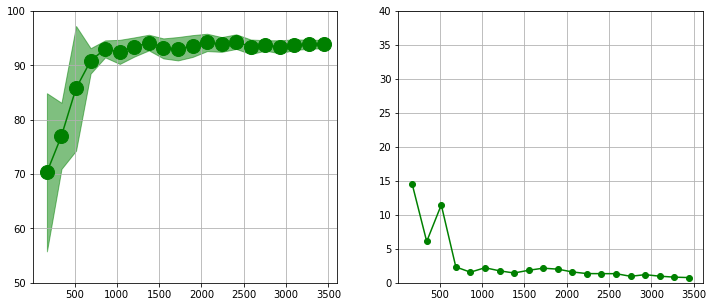

In [ ]:
import matplotlib.pyplot as plt

n = np.linspace(.05, 1.0, 20)

X_train_val= pd.DataFrame(df.iloc[:, 1:].values)   #pd.DataFrame(labelled.iloc[:, :].values)
train_sizes =  X_train_val.shape[0]* n
print(train_sizes)
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)

_, axes = plt.subplots(1, 2, figsize=(12, 5))

#plt.plot(train_sizes, np.mean(score_tot, 0))

# Plot the learning curve for the deep one class network (TPR versus training dataset size)
axes[0].grid()
axes[0].fill_between(train_sizes, 
                    test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.5,
                         color="g")

axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", markersize=14,
                 label="Cross-validation score")

axes[0].set_ylim(50, 100)

# Plot showing the 
axes[1].grid()
axes[1].plot(train_sizes,test_scores_std, 'o-', color="g",
                 label="Cross-validation score")
axes[1].set_ylim(0, 40) 


In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from random import Random

score_tot=[]

def test_net(train, test):
  dataset = Pairs_Dataset('', train, test, df.iloc[:, 1:])
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  pretrain(deep_SVDD, dataset, n_epochs=100)
  pred_train = deep_SVDD.train(dataset,n_epochs=80)
  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  return scores1


# Perform k-fold cross validation
X_train_val=pd.DataFrame(df.iloc[:, 1:].values)
kf = KFold(n_splits = 5,  shuffle=True, random_state=0)
kf.get_n_splits(X_train_val)
scores2=[]

n = np.linspace(.02, 1.0, 20)  
for train, test in kf.split(X_train_val):
  scores2=[]
  Random(0).shuffle(train)
  for i in X_train_val.shape[0]* n:
    print('size:', i)    
    Random(0).shuffle(train)
    trainX = train[:int(i)]
    scores1 = test_net(trainX, test)
    scores2.append(scores1)
  score_tot.append(scores2)

size: 68.88


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/100	 Time: 0.029	 Loss: 580.28302002
INFO:root:  Epoch 2/100	 Time: 0.028	 Loss: 566.15588379
INFO:root:  Epoch 3/100	 Time: 0.026	 Loss: 555.29516602
INFO:ro

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.066	 Loss: 547.52651978
INFO:root:  Epoch 2/100	 Time: 0.071	 Loss: 538.99569702
INFO:root:  Epoch 3/100	 Time: 0.069	 Loss: 533.12304688
INFO:root:  Epoch 4/100	 Time: 0.068	 Loss: 530.10070801
INFO:root:  Epoch 5/100	 Time: 0.077	 Loss: 526.24420166
INFO:root:  Epoch 6/100	 Time: 0.071	 Loss: 518.53829956
INFO:root:  Epoch 7/100	 Time: 0.068	 Loss: 511.94151306
INFO:root:  Epoch 8/100	 Time: 0.075	 Loss: 510.45037842
INFO:root:  Epoch 9/100	 Time: 0.074	 Loss: 498.76885986
INFO:root:  Epoch 10/100	 Time: 0.077	 Loss: 489.06991577
INFO:root:  Epoch 11/100	 Time: 0.075	 Loss: 484.36836243
INFO:root:  Epoch 12/100	 Time: 0.074	 Loss: 476.25440979
INFO:root:  Epoch 13/100	 Time: 0.080	 Loss: 464.44194031
INFO:root:  Epoch 14/100	 Time: 0.076	 Loss: 451.45729065
INFO:root:  Epoch 15/100	 Time: 0.070	 Loss: 440.59982300
INFO:root:  Epoch 16/100	 Time: 0.070	 Loss: 430.13893127
INFO:root:  Epoch 17/100	 Time: 0.069	 Loss: 41

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.113	 Loss: 563.24277751
INFO:root:  Epoch 2/100	 Time: 0.108	 Loss: 537.47676595
INFO:root:  Epoch 3/100	 Time: 0.113	 Loss: 529.78236898
INFO:root:  Epoch 4/100	 Time: 0.116	 Loss: 516.69566854
INFO:root:  Epoch 5/100	 Time: 0.100	 Loss: 516.63236491
INFO:root:  Epoch 6/100	 Time: 0.107	 Loss: 508.42036947
INFO:root:  Epoch 7/100	 Time: 0.103	 Loss: 499.81671143
INFO:root:  Epoch 8/100	 Time: 0.111	 Loss: 486.94302368
INFO:root:  Epoch 9/100	 Time: 0.101	 Loss: 475.84516398
INFO:root:  Epoch 10/100	 Time: 0.112	 Loss: 465.76041667
INFO:root:  Epoch 11/100	 Time: 0.115	 Loss: 447.66963704
INFO:root:  Epoch 12/100	 Time: 0.107	 Loss: 431.35918172
INFO:root:  Epoch 13/100	 Time: 0.115	 Loss: 414.28656006
INFO:root:  Epoch 14/100	 Time: 0.102	 Loss: 394.79587809
INFO:root:  Epoch 15/100	 Time: 0.121	 Loss: 375.16353353
INFO:root:  Epoch 16/100	 Time: 0.120	 Loss: 358.71913656
INFO:root:  Epoch 17/100	 Time: 0.109	 Loss: 33

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.143	 Loss: 543.19650269
INFO:root:  Epoch 2/100	 Time: 0.157	 Loss: 535.75677490
INFO:root:  Epoch 3/100	 Time: 0.132	 Loss: 530.89926147
INFO:root:  Epoch 4/100	 Time: 0.131	 Loss: 511.98907471
INFO:root:  Epoch 5/100	 Time: 0.130	 Loss: 506.34566498
INFO:root:  Epoch 6/100	 Time: 0.128	 Loss: 495.89879608
INFO:root:  Epoch 7/100	 Time: 0.130	 Loss: 468.91006470
INFO:root:  Epoch 8/100	 Time: 0.130	 Loss: 459.35761261
INFO:root:  Epoch 9/100	 Time: 0.136	 Loss: 420.28256226
INFO:root:  Epoch 10/100	 Time: 0.136	 Loss: 405.78860474
INFO:root:  Epoch 11/100	 Time: 0.128	 Loss: 380.02716064
INFO:root:  Epoch 12/100	 Time: 0.133	 Loss: 353.91339111
INFO:root:  Epoch 13/100	 Time: 0.132	 Loss: 319.74649048
INFO:root:  Epoch 14/100	 Time: 0.131	 Loss: 315.87191772
INFO:root:  Epoch 15/100	 Time: 0.134	 Loss: 279.84838104
INFO:root:  Epoch 16/100	 Time: 0.152	 Loss: 264.59986496
INFO:root:  Epoch 17/100	 Time: 0.147	 Loss: 23

size: 779.4315789473684


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.147	 Loss: 552.69697571
INFO:root:  Epoch 2/100	 Time: 0.162	 Loss: 531.98905945
INFO:root:  Epoch 3/100	 Time: 0.161	 Loss: 524.22984314
INFO:root:  Epoch 4/100	 Time: 0.156	 Loss: 515.50171661
INFO:root:  Epoch 5/100	 Time: 0.153	 Loss: 503.74734497
INFO:root:  Epoch 6/100	 Time: 0.144	 Loss: 489.21849060
INFO:root:  Epoch 7/100	 Time: 0.156	 Loss: 471.79904938
INFO:root:  Epoch 8/100	 Time: 0.163	 Loss: 451.84500885
INFO:root:  Epoch 9/100	 Time: 0.145	 Loss: 429.43987274
INFO:root:  Epoch 10/100	 Time: 0.148	 Loss: 405.02418518
INFO:root:  Epoch 11/100	 Time: 0.149	 Loss: 379.11834717
INFO:root:  Epoch 12/100	 Time: 0.168	 Loss: 352.14203644
INFO:root:  Epoch 13/100	 Time: 0.148	 Loss: 324.92714691
INFO:root:  Epoch 14/100	 Time: 0.154	 Loss: 298.17087555
INFO:root:  Epoch 15/100	 Time: 0.175	 Loss: 272.18099213
INFO:root:  Epoch 16/100	 Time: 0.156	 Loss: 248.09893417
INFO:root:  Epoch 17/100	 Time: 0.144	 Loss: 22

size: 957.0694736842105


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.181	 Loss: 556.58238525
INFO:root:  Epoch 2/100	 Time: 0.182	 Loss: 532.07517090
INFO:root:  Epoch 3/100	 Time: 0.190	 Loss: 522.56922607
INFO:root:  Epoch 4/100	 Time: 0.186	 Loss: 510.57368164
INFO:root:  Epoch 5/100	 Time: 0.184	 Loss: 493.91350708
INFO:root:  Epoch 6/100	 Time: 0.186	 Loss: 472.53591309
INFO:root:  Epoch 7/100	 Time: 0.190	 Loss: 446.17254028
INFO:root:  Epoch 8/100	 Time: 0.177	 Loss: 415.99540405
INFO:root:  Epoch 9/100	 Time: 0.184	 Loss: 382.76887817
INFO:root:  Epoch 10/100	 Time: 0.181	 Loss: 347.94304199
INFO:root:  Epoch 11/100	 Time: 0.181	 Loss: 313.12573853
INFO:root:  Epoch 12/100	 Time: 0.177	 Loss: 279.67427979
INFO:root:  Epoch 13/100	 Time: 0.182	 Loss: 248.43644104
INFO:root:  Epoch 14/100	 Time: 0.185	 Loss: 221.15251770
INFO:root:  Epoch 15/100	 Time: 0.181	 Loss: 198.04492798
INFO:root:  Epoch 16/100	 Time: 0.173	 Loss: 178.75680237
INFO:root:  Epoch 17/100	 Time: 0.180	 Loss: 16

size: 1134.7073684210527


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.246	 Loss: 556.29641724
INFO:root:  Epoch 2/100	 Time: 0.237	 Loss: 531.53195190
INFO:root:  Epoch 3/100	 Time: 0.228	 Loss: 521.73870850
INFO:root:  Epoch 4/100	 Time: 0.214	 Loss: 505.44774373
INFO:root:  Epoch 5/100	 Time: 0.233	 Loss: 481.88621012
INFO:root:  Epoch 6/100	 Time: 0.222	 Loss: 451.53598531
INFO:root:  Epoch 7/100	 Time: 0.212	 Loss: 414.68258158
INFO:root:  Epoch 8/100	 Time: 0.220	 Loss: 374.15877787
INFO:root:  Epoch 9/100	 Time: 0.223	 Loss: 331.81130473
INFO:root:  Epoch 10/100	 Time: 0.213	 Loss: 290.72724406
INFO:root:  Epoch 11/100	 Time: 0.213	 Loss: 253.08500671
INFO:root:  Epoch 12/100	 Time: 0.213	 Loss: 220.01894887
INFO:root:  Epoch 13/100	 Time: 0.207	 Loss: 193.43789673
INFO:root:  Epoch 14/100	 Time: 0.228	 Loss: 172.82133993
INFO:root:  Epoch 15/100	 Time: 0.226	 Loss: 158.15502421
INFO:root:  Epoch 16/100	 Time: 0.223	 Loss: 148.96655273
INFO:root:  Epoch 17/100	 Time: 0.226	 Loss: 14

size: 1312.3452631578948


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.271	 Loss: 547.16727121
INFO:root:  Epoch 2/100	 Time: 0.279	 Loss: 526.94836426
INFO:root:  Epoch 3/100	 Time: 0.265	 Loss: 512.15089634
INFO:root:  Epoch 4/100	 Time: 0.254	 Loss: 487.76969692
INFO:root:  Epoch 5/100	 Time: 0.250	 Loss: 454.67528861
INFO:root:  Epoch 6/100	 Time: 0.266	 Loss: 413.35828509
INFO:root:  Epoch 7/100	 Time: 0.251	 Loss: 365.95660400
INFO:root:  Epoch 8/100	 Time: 0.250	 Loss: 316.69199480
INFO:root:  Epoch 9/100	 Time: 0.245	 Loss: 269.25390407
INFO:root:  Epoch 10/100	 Time: 0.261	 Loss: 228.38940212
INFO:root:  Epoch 11/100	 Time: 0.254	 Loss: 194.59644863
INFO:root:  Epoch 12/100	 Time: 0.251	 Loss: 170.42176819
INFO:root:  Epoch 13/100	 Time: 0.283	 Loss: 152.80455889
INFO:root:  Epoch 14/100	 Time: 0.284	 Loss: 141.76772417
INFO:root:  Epoch 15/100	 Time: 0.243	 Loss: 135.19313049
INFO:root:  Epoch 16/100	 Time: 0.244	 Loss: 130.76194981
INFO:root:  Epoch 17/100	 Time: 0.244	 Loss: 12

size: 1489.983157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.320	 Loss: 537.67333984
INFO:root:  Epoch 2/100	 Time: 0.283	 Loss: 517.69921112
INFO:root:  Epoch 3/100	 Time: 0.282	 Loss: 493.67372513
INFO:root:  Epoch 4/100	 Time: 0.283	 Loss: 457.49197388
INFO:root:  Epoch 5/100	 Time: 0.279	 Loss: 410.72576904
INFO:root:  Epoch 6/100	 Time: 0.276	 Loss: 356.98791885
INFO:root:  Epoch 7/100	 Time: 0.288	 Loss: 301.92403412
INFO:root:  Epoch 8/100	 Time: 0.306	 Loss: 251.39710617
INFO:root:  Epoch 9/100	 Time: 0.279	 Loss: 209.90805626
INFO:root:  Epoch 10/100	 Time: 0.325	 Loss: 179.59438896
INFO:root:  Epoch 11/100	 Time: 0.319	 Loss: 158.86003304
INFO:root:  Epoch 12/100	 Time: 0.277	 Loss: 147.52389145
INFO:root:  Epoch 13/100	 Time: 0.283	 Loss: 138.35621834
INFO:root:  Epoch 14/100	 Time: 0.284	 Loss: 133.89597130
INFO:root:  Epoch 15/100	 Time: 0.286	 Loss: 130.62904739
INFO:root:  Epoch 16/100	 Time: 0.302	 Loss: 129.51389694
INFO:root:  Epoch 17/100	 Time: 0.270	 Loss: 12

size: 1667.621052631579


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.314	 Loss: 540.51557753
INFO:root:  Epoch 2/100	 Time: 0.319	 Loss: 517.77663167
INFO:root:  Epoch 3/100	 Time: 0.321	 Loss: 488.70198907
INFO:root:  Epoch 4/100	 Time: 0.334	 Loss: 444.02193536
INFO:root:  Epoch 5/100	 Time: 0.342	 Loss: 386.82763333
INFO:root:  Epoch 6/100	 Time: 0.341	 Loss: 325.77600098
INFO:root:  Epoch 7/100	 Time: 0.313	 Loss: 268.51652527
INFO:root:  Epoch 8/100	 Time: 0.335	 Loss: 219.84432475
INFO:root:  Epoch 9/100	 Time: 0.321	 Loss: 182.81036377
INFO:root:  Epoch 10/100	 Time: 0.324	 Loss: 158.51425849
INFO:root:  Epoch 11/100	 Time: 0.325	 Loss: 143.97761366
INFO:root:  Epoch 12/100	 Time: 0.315	 Loss: 136.09414164
INFO:root:  Epoch 13/100	 Time: 0.318	 Loss: 132.20809089
INFO:root:  Epoch 14/100	 Time: 0.317	 Loss: 128.59520891
INFO:root:  Epoch 15/100	 Time: 0.320	 Loss: 127.72070482
INFO:root:  Epoch 16/100	 Time: 0.325	 Loss: 126.73275418
INFO:root:  Epoch 17/100	 Time: 0.321	 Loss: 12

size: 1845.2589473684209


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.377	 Loss: 536.02106323
INFO:root:  Epoch 2/100	 Time: 0.350	 Loss: 509.53913879
INFO:root:  Epoch 3/100	 Time: 0.347	 Loss: 469.17418518
INFO:root:  Epoch 4/100	 Time: 0.361	 Loss: 412.19952393
INFO:root:  Epoch 5/100	 Time: 0.358	 Loss: 347.12809753
INFO:root:  Epoch 6/100	 Time: 0.353	 Loss: 282.77017517
INFO:root:  Epoch 7/100	 Time: 0.364	 Loss: 226.61354523
INFO:root:  Epoch 8/100	 Time: 0.363	 Loss: 185.89711456
INFO:root:  Epoch 9/100	 Time: 0.357	 Loss: 158.71405945
INFO:root:  Epoch 10/100	 Time: 0.371	 Loss: 143.43761292
INFO:root:  Epoch 11/100	 Time: 0.358	 Loss: 135.07551727
INFO:root:  Epoch 12/100	 Time: 0.372	 Loss: 130.77989120
INFO:root:  Epoch 13/100	 Time: 0.348	 Loss: 127.74611588
INFO:root:  Epoch 14/100	 Time: 0.343	 Loss: 126.34560928
INFO:root:  Epoch 15/100	 Time: 0.351	 Loss: 124.29465256
INFO:root:  Epoch 16/100	 Time: 0.350	 Loss: 125.45769119
INFO:root:  Epoch 17/100	 Time: 0.355	 Loss: 12

size: 2022.896842105263


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.387	 Loss: 538.11410245
INFO:root:  Epoch 2/100	 Time: 0.446	 Loss: 512.08353771
INFO:root:  Epoch 3/100	 Time: 0.430	 Loss: 466.93335516
INFO:root:  Epoch 4/100	 Time: 0.415	 Loss: 400.96362582
INFO:root:  Epoch 5/100	 Time: 0.399	 Loss: 327.26490368
INFO:root:  Epoch 6/100	 Time: 0.456	 Loss: 254.87210777
INFO:root:  Epoch 7/100	 Time: 0.441	 Loss: 199.80708729
INFO:root:  Epoch 8/100	 Time: 0.462	 Loss: 162.13281389
INFO:root:  Epoch 9/100	 Time: 0.422	 Loss: 142.77930104
INFO:root:  Epoch 10/100	 Time: 0.392	 Loss: 134.21217693
INFO:root:  Epoch 11/100	 Time: 0.386	 Loss: 129.79759355
INFO:root:  Epoch 12/100	 Time: 0.386	 Loss: 127.22733238
INFO:root:  Epoch 13/100	 Time: 0.380	 Loss: 125.87920796
INFO:root:  Epoch 14/100	 Time: 0.426	 Loss: 125.26012143
INFO:root:  Epoch 15/100	 Time: 0.385	 Loss: 126.24684975
INFO:root:  Epoch 16/100	 Time: 0.377	 Loss: 125.51639834
INFO:root:  Epoch 17/100	 Time: 0.385	 Loss: 12

size: 2200.5347368421053


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.417	 Loss: 543.22248979
INFO:root:  Epoch 2/100	 Time: 0.394	 Loss: 515.54626742
INFO:root:  Epoch 3/100	 Time: 0.392	 Loss: 477.07479304
INFO:root:  Epoch 4/100	 Time: 0.437	 Loss: 416.32855779
INFO:root:  Epoch 5/100	 Time: 0.416	 Loss: 342.17610030
INFO:root:  Epoch 6/100	 Time: 0.416	 Loss: 270.09268605
INFO:root:  Epoch 7/100	 Time: 0.422	 Loss: 212.13371832
INFO:root:  Epoch 8/100	 Time: 0.416	 Loss: 172.29219610
INFO:root:  Epoch 9/100	 Time: 0.421	 Loss: 148.90341187
INFO:root:  Epoch 10/100	 Time: 0.427	 Loss: 136.97357871
INFO:root:  Epoch 11/100	 Time: 0.389	 Loss: 131.30023471
INFO:root:  Epoch 12/100	 Time: 0.437	 Loss: 128.09590149
INFO:root:  Epoch 13/100	 Time: 0.418	 Loss: 126.07828799
INFO:root:  Epoch 14/100	 Time: 0.442	 Loss: 124.86088493
INFO:root:  Epoch 15/100	 Time: 0.436	 Loss: 124.04887737
INFO:root:  Epoch 16/100	 Time: 0.450	 Loss: 123.46627183
INFO:root:  Epoch 17/100	 Time: 0.395	 Loss: 12

size: 2378.1726315789474


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.429	 Loss: 540.63656108
INFO:root:  Epoch 2/100	 Time: 0.427	 Loss: 509.33926137
INFO:root:  Epoch 3/100	 Time: 0.434	 Loss: 457.38229116
INFO:root:  Epoch 4/100	 Time: 0.432	 Loss: 381.09394328
INFO:root:  Epoch 5/100	 Time: 0.425	 Loss: 298.27349345
INFO:root:  Epoch 6/100	 Time: 0.460	 Loss: 227.92743683
INFO:root:  Epoch 7/100	 Time: 0.461	 Loss: 179.07923635
INFO:root:  Epoch 8/100	 Time: 0.462	 Loss: 150.62599055
INFO:root:  Epoch 9/100	 Time: 0.494	 Loss: 137.06754494
INFO:root:  Epoch 10/100	 Time: 0.454	 Loss: 131.21735891
INFO:root:  Epoch 11/100	 Time: 0.425	 Loss: 128.19581540
INFO:root:  Epoch 12/100	 Time: 0.483	 Loss: 126.07813581
INFO:root:  Epoch 13/100	 Time: 0.487	 Loss: 124.88631312
INFO:root:  Epoch 14/100	 Time: 0.504	 Loss: 124.05368614
INFO:root:  Epoch 15/100	 Time: 0.463	 Loss: 123.32715543
INFO:root:  Epoch 16/100	 Time: 0.443	 Loss: 122.82361221
INFO:root:  Epoch 17/100	 Time: 0.464	 Loss: 12

size: 2555.8105263157895


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.495	 Loss: 530.98364727
INFO:root:  Epoch 2/100	 Time: 0.479	 Loss: 492.87899311
INFO:root:  Epoch 3/100	 Time: 0.481	 Loss: 425.11881197
INFO:root:  Epoch 4/100	 Time: 0.447	 Loss: 336.82316707
INFO:root:  Epoch 5/100	 Time: 0.502	 Loss: 251.69599680
INFO:root:  Epoch 6/100	 Time: 0.560	 Loss: 188.88279959
INFO:root:  Epoch 7/100	 Time: 0.503	 Loss: 153.04493009
INFO:root:  Epoch 8/100	 Time: 0.453	 Loss: 137.06951670
INFO:root:  Epoch 9/100	 Time: 0.498	 Loss: 130.82120749
INFO:root:  Epoch 10/100	 Time: 0.568	 Loss: 127.41534600
INFO:root:  Epoch 11/100	 Time: 0.520	 Loss: 125.71282137
INFO:root:  Epoch 12/100	 Time: 0.479	 Loss: 124.70727656
INFO:root:  Epoch 13/100	 Time: 0.492	 Loss: 123.85813904
INFO:root:  Epoch 14/100	 Time: 0.465	 Loss: 123.47271376
INFO:root:  Epoch 15/100	 Time: 0.484	 Loss: 122.82311894
INFO:root:  Epoch 16/100	 Time: 0.470	 Loss: 122.48475999
INFO:root:  Epoch 17/100	 Time: 0.505	 Loss: 12

size: 2733.4484210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.539	 Loss: 539.17529297
INFO:root:  Epoch 2/100	 Time: 0.531	 Loss: 494.06537955
INFO:root:  Epoch 3/100	 Time: 0.508	 Loss: 425.50946917
INFO:root:  Epoch 4/100	 Time: 0.503	 Loss: 335.03000968
INFO:root:  Epoch 5/100	 Time: 0.518	 Loss: 248.47451019
INFO:root:  Epoch 6/100	 Time: 0.533	 Loss: 186.04294913
INFO:root:  Epoch 7/100	 Time: 0.490	 Loss: 152.14616503
INFO:root:  Epoch 8/100	 Time: 0.501	 Loss: 137.06884657
INFO:root:  Epoch 9/100	 Time: 0.489	 Loss: 131.22500992
INFO:root:  Epoch 10/100	 Time: 0.526	 Loss: 128.15251323
INFO:root:  Epoch 11/100	 Time: 0.527	 Loss: 126.47215543
INFO:root:  Epoch 12/100	 Time: 0.502	 Loss: 125.10488401
INFO:root:  Epoch 13/100	 Time: 0.543	 Loss: 124.12265614
INFO:root:  Epoch 14/100	 Time: 0.529	 Loss: 123.77124895
INFO:root:  Epoch 15/100	 Time: 0.512	 Loss: 122.84402738
INFO:root:  Epoch 16/100	 Time: 0.516	 Loss: 122.55453328
INFO:root:  Epoch 17/100	 Time: 0.513	 Loss: 12

size: 2911.0863157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.570	 Loss: 531.52818080
INFO:root:  Epoch 2/100	 Time: 0.569	 Loss: 489.97472273
INFO:root:  Epoch 3/100	 Time: 0.495	 Loss: 418.39335632
INFO:root:  Epoch 4/100	 Time: 0.514	 Loss: 325.95972770
INFO:root:  Epoch 5/100	 Time: 0.504	 Loss: 238.46458653
INFO:root:  Epoch 6/100	 Time: 0.510	 Loss: 177.55284882
INFO:root:  Epoch 7/100	 Time: 0.558	 Loss: 146.53420803
INFO:root:  Epoch 8/100	 Time: 0.573	 Loss: 133.96041162
INFO:root:  Epoch 9/100	 Time: 0.519	 Loss: 129.15649905
INFO:root:  Epoch 10/100	 Time: 0.521	 Loss: 126.86387961
INFO:root:  Epoch 11/100	 Time: 0.565	 Loss: 125.47755378
INFO:root:  Epoch 12/100	 Time: 0.569	 Loss: 124.67236437
INFO:root:  Epoch 13/100	 Time: 0.534	 Loss: 123.83556693
INFO:root:  Epoch 14/100	 Time: 0.552	 Loss: 123.21270970
INFO:root:  Epoch 15/100	 Time: 0.505	 Loss: 122.50055695
INFO:root:  Epoch 16/100	 Time: 0.524	 Loss: 122.21620723
INFO:root:  Epoch 17/100	 Time: 0.505	 Loss: 12

size: 3088.724210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.509	 Loss: 534.25981358
INFO:root:  Epoch 2/100	 Time: 0.513	 Loss: 493.41124398
INFO:root:  Epoch 3/100	 Time: 0.509	 Loss: 421.71879796
INFO:root:  Epoch 4/100	 Time: 0.502	 Loss: 327.55059814
INFO:root:  Epoch 5/100	 Time: 0.512	 Loss: 238.59473637
INFO:root:  Epoch 6/100	 Time: 0.507	 Loss: 177.27113342
INFO:root:  Epoch 7/100	 Time: 0.555	 Loss: 147.17251369
INFO:root:  Epoch 8/100	 Time: 0.555	 Loss: 134.35007368
INFO:root:  Epoch 9/100	 Time: 0.511	 Loss: 128.95082637
INFO:root:  Epoch 10/100	 Time: 0.510	 Loss: 126.50516020
INFO:root:  Epoch 11/100	 Time: 0.501	 Loss: 125.06583132
INFO:root:  Epoch 12/100	 Time: 0.505	 Loss: 123.99767303
INFO:root:  Epoch 13/100	 Time: 0.510	 Loss: 123.42524665
INFO:root:  Epoch 14/100	 Time: 0.500	 Loss: 122.63717651
INFO:root:  Epoch 15/100	 Time: 0.493	 Loss: 122.17783792
INFO:root:  Epoch 16/100	 Time: 0.514	 Loss: 121.84628623
INFO:root:  Epoch 17/100	 Time: 0.517	 Loss: 12

size: 3266.362105263158


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.509	 Loss: 532.46554565
INFO:root:  Epoch 2/100	 Time: 0.491	 Loss: 486.67917960
INFO:root:  Epoch 3/100	 Time: 0.549	 Loss: 414.32699367
INFO:root:  Epoch 4/100	 Time: 0.538	 Loss: 322.83103943
INFO:root:  Epoch 5/100	 Time: 0.506	 Loss: 237.86444310
INFO:root:  Epoch 6/100	 Time: 0.512	 Loss: 178.41042328
INFO:root:  Epoch 7/100	 Time: 0.525	 Loss: 146.97567858
INFO:root:  Epoch 8/100	 Time: 0.505	 Loss: 134.25507791
INFO:root:  Epoch 9/100	 Time: 0.534	 Loss: 129.34695980
INFO:root:  Epoch 10/100	 Time: 0.509	 Loss: 126.80017962
INFO:root:  Epoch 11/100	 Time: 0.551	 Loss: 125.19809723
INFO:root:  Epoch 12/100	 Time: 0.535	 Loss: 124.26717377
INFO:root:  Epoch 13/100	 Time: 0.508	 Loss: 123.53396334
INFO:root:  Epoch 14/100	 Time: 0.549	 Loss: 122.94410433
INFO:root:  Epoch 15/100	 Time: 0.511	 Loss: 122.47177941
INFO:root:  Epoch 16/100	 Time: 0.542	 Loss: 121.97276361
INFO:root:  Epoch 17/100	 Time: 0.604	 Loss: 12

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.520	 Loss: 527.38284956
INFO:root:  Epoch 2/100	 Time: 0.563	 Loss: 479.94611468
INFO:root:  Epoch 3/100	 Time: 0.590	 Loss: 404.06503950
INFO:root:  Epoch 4/100	 Time: 0.543	 Loss: 312.16097369
INFO:root:  Epoch 5/100	 Time: 0.520	 Loss: 229.54917254
INFO:root:  Epoch 6/100	 Time: 0.507	 Loss: 173.81399318
INFO:root:  Epoch 7/100	 Time: 0.526	 Loss: 145.32800402
INFO:root:  Epoch 8/100	 Time: 0.613	 Loss: 133.54902594
INFO:root:  Epoch 9/100	 Time: 0.549	 Loss: 128.64511272
INFO:root:  Epoch 10/100	 Time: 0.498	 Loss: 126.26159123
INFO:root:  Epoch 11/100	 Time: 0.506	 Loss: 124.90536717
INFO:root:  Epoch 12/100	 Time: 0.506	 Loss: 124.08693423
INFO:root:  Epoch 13/100	 Time: 0.514	 Loss: 123.49161966
INFO:root:  Epoch 14/100	 Time: 0.518	 Loss: 122.93228040
INFO:root:  Epoch 15/100	 Time: 0.518	 Loss: 122.36919730
INFO:root:  Epoch 16/100	 Time: 0.503	 Loss: 122.03941781
INFO:root:  Epoch 17/100	 Time: 0.503	 Loss: 12

size: 68.88


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.028	 Loss: 571.23016357
INFO:root:  Epoch 2/100	 Time: 0.025	 Loss: 560.57635498
INFO:root:  Epoch 3/100	 Time: 0.029	 Loss: 552.18920898
INFO:root:  Epoch 4/100	 Time: 0.028	 Loss: 546.00183105
INFO:root:  Epoch 5/100	 Time: 0.027	 Loss: 541.57183838
INFO:root:  Epoch 6/100	 Time: 0.026	 Loss: 538.44628906
INFO:root:  Epoch 7/100	 Time: 0.026	 Loss: 536.21990967
INFO:root:  Epoch 8/100	 Time: 0.025	 Loss: 534.45086670
INFO:root:  Epoch 9/100	 Time: 0.025	 Loss: 532.86590576
INFO:root:  Epoch 10/100	 Time: 0.025	 Loss: 531.31420898
INFO:root:  Epoch 11/100	 Time: 0.029	 Loss: 529.67004395
INFO:root:  Epoch 12/100	 Time: 0.026	 Loss: 527.85430908
INFO:root:  Epoch 13/100	 Time: 0.029	 Loss: 525.87097168
INFO:root:  Epoch 14/100	 Time: 0.030	 Loss: 523.72149658
INFO:root:  Epoch 15/100	 Time: 0.027	 Loss: 521.40985107
INFO:root:  Epoch 16/100	 Time: 0.026	 Loss: 518.95770264
INFO:root:  Epoch 17/100	 Time: 0.028	 Loss: 51

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.070	 Loss: 568.61523438
INFO:root:  Epoch 2/100	 Time: 0.061	 Loss: 548.76885986
INFO:root:  Epoch 3/100	 Time: 0.060	 Loss: 538.98910522
INFO:root:  Epoch 4/100	 Time: 0.061	 Loss: 533.37991333
INFO:root:  Epoch 5/100	 Time: 0.063	 Loss: 527.79553223
INFO:root:  Epoch 6/100	 Time: 0.065	 Loss: 528.35607910
INFO:root:  Epoch 7/100	 Time: 0.063	 Loss: 521.93569946
INFO:root:  Epoch 8/100	 Time: 0.064	 Loss: 516.88961792
INFO:root:  Epoch 9/100	 Time: 0.058	 Loss: 510.61929321
INFO:root:  Epoch 10/100	 Time: 0.057	 Loss: 504.53747559
INFO:root:  Epoch 11/100	 Time: 0.065	 Loss: 498.67668152
INFO:root:  Epoch 12/100	 Time: 0.067	 Loss: 490.19941711
INFO:root:  Epoch 13/100	 Time: 0.071	 Loss: 480.71568298
INFO:root:  Epoch 14/100	 Time: 0.058	 Loss: 470.66549683
INFO:root:  Epoch 15/100	 Time: 0.057	 Loss: 464.83319092
INFO:root:  Epoch 16/100	 Time: 0.058	 Loss: 453.27484131
INFO:root:  Epoch 17/100	 Time: 0.062	 Loss: 44

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.101	 Loss: 558.52128092
INFO:root:  Epoch 2/100	 Time: 0.112	 Loss: 541.54184977
INFO:root:  Epoch 3/100	 Time: 0.106	 Loss: 530.08766683
INFO:root:  Epoch 4/100	 Time: 0.096	 Loss: 520.40350342
INFO:root:  Epoch 5/100	 Time: 0.098	 Loss: 519.64624023
INFO:root:  Epoch 6/100	 Time: 0.104	 Loss: 507.93047078
INFO:root:  Epoch 7/100	 Time: 0.096	 Loss: 498.81003825
INFO:root:  Epoch 8/100	 Time: 0.096	 Loss: 489.94027710
INFO:root:  Epoch 9/100	 Time: 0.100	 Loss: 476.46318563
INFO:root:  Epoch 10/100	 Time: 0.097	 Loss: 460.70252482
INFO:root:  Epoch 11/100	 Time: 0.096	 Loss: 442.06693522
INFO:root:  Epoch 12/100	 Time: 0.095	 Loss: 425.13685099
INFO:root:  Epoch 13/100	 Time: 0.096	 Loss: 406.06072998
INFO:root:  Epoch 14/100	 Time: 0.100	 Loss: 389.41668701
INFO:root:  Epoch 15/100	 Time: 0.111	 Loss: 365.18878174
INFO:root:  Epoch 16/100	 Time: 0.114	 Loss: 346.89048258
INFO:root:  Epoch 17/100	 Time: 0.116	 Loss: 32

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.140	 Loss: 546.48478699
INFO:root:  Epoch 2/100	 Time: 0.145	 Loss: 542.67160034
INFO:root:  Epoch 3/100	 Time: 0.136	 Loss: 525.78280640
INFO:root:  Epoch 4/100	 Time: 0.130	 Loss: 545.05253601
INFO:root:  Epoch 5/100	 Time: 0.122	 Loss: 522.57095337
INFO:root:  Epoch 6/100	 Time: 0.129	 Loss: 515.67794037
INFO:root:  Epoch 7/100	 Time: 0.139	 Loss: 486.30261230
INFO:root:  Epoch 8/100	 Time: 0.137	 Loss: 485.67378235
INFO:root:  Epoch 9/100	 Time: 0.144	 Loss: 470.78102112
INFO:root:  Epoch 10/100	 Time: 0.136	 Loss: 445.62152863
INFO:root:  Epoch 11/100	 Time: 0.143	 Loss: 415.20793152
INFO:root:  Epoch 12/100	 Time: 0.158	 Loss: 375.90075684
INFO:root:  Epoch 13/100	 Time: 0.157	 Loss: 370.32070923
INFO:root:  Epoch 14/100	 Time: 0.129	 Loss: 341.75803375
INFO:root:  Epoch 15/100	 Time: 0.129	 Loss: 317.11123657
INFO:root:  Epoch 16/100	 Time: 0.137	 Loss: 283.89520264
INFO:root:  Epoch 17/100	 Time: 0.135	 Loss: 26

size: 779.4315789473684


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.147	 Loss: 547.40800476
INFO:root:  Epoch 2/100	 Time: 0.148	 Loss: 533.14311218
INFO:root:  Epoch 3/100	 Time: 0.140	 Loss: 525.00082397
INFO:root:  Epoch 4/100	 Time: 0.144	 Loss: 515.57026672
INFO:root:  Epoch 5/100	 Time: 0.156	 Loss: 502.82154083
INFO:root:  Epoch 6/100	 Time: 0.151	 Loss: 486.65322113
INFO:root:  Epoch 7/100	 Time: 0.147	 Loss: 467.35959625
INFO:root:  Epoch 8/100	 Time: 0.142	 Loss: 445.04521942
INFO:root:  Epoch 9/100	 Time: 0.162	 Loss: 420.24716949
INFO:root:  Epoch 10/100	 Time: 0.172	 Loss: 393.63822937
INFO:root:  Epoch 11/100	 Time: 0.166	 Loss: 365.97778320
INFO:root:  Epoch 12/100	 Time: 0.169	 Loss: 337.75237274
INFO:root:  Epoch 13/100	 Time: 0.146	 Loss: 309.93424225
INFO:root:  Epoch 14/100	 Time: 0.143	 Loss: 283.20647430
INFO:root:  Epoch 15/100	 Time: 0.147	 Loss: 258.07077408
INFO:root:  Epoch 16/100	 Time: 0.146	 Loss: 235.17972946
INFO:root:  Epoch 17/100	 Time: 0.141	 Loss: 21

size: 957.0694736842105


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.183	 Loss: 555.77479248
INFO:root:  Epoch 2/100	 Time: 0.178	 Loss: 533.37866211
INFO:root:  Epoch 3/100	 Time: 0.176	 Loss: 523.79912109
INFO:root:  Epoch 4/100	 Time: 0.184	 Loss: 512.44512329
INFO:root:  Epoch 5/100	 Time: 0.179	 Loss: 496.29296875
INFO:root:  Epoch 6/100	 Time: 0.180	 Loss: 475.39271851
INFO:root:  Epoch 7/100	 Time: 0.174	 Loss: 450.35097656
INFO:root:  Epoch 8/100	 Time: 0.235	 Loss: 421.05643921
INFO:root:  Epoch 9/100	 Time: 0.189	 Loss: 388.95776978
INFO:root:  Epoch 10/100	 Time: 0.196	 Loss: 355.38984375
INFO:root:  Epoch 11/100	 Time: 0.198	 Loss: 321.09752808
INFO:root:  Epoch 12/100	 Time: 0.199	 Loss: 287.86953125
INFO:root:  Epoch 13/100	 Time: 0.204	 Loss: 256.84655762
INFO:root:  Epoch 14/100	 Time: 0.172	 Loss: 229.03596191
INFO:root:  Epoch 15/100	 Time: 0.201	 Loss: 205.13458862
INFO:root:  Epoch 16/100	 Time: 0.208	 Loss: 185.02687073
INFO:root:  Epoch 17/100	 Time: 0.185	 Loss: 16

size: 1134.7073684210527


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.224	 Loss: 547.59951782
INFO:root:  Epoch 2/100	 Time: 0.220	 Loss: 530.30873617
INFO:root:  Epoch 3/100	 Time: 0.213	 Loss: 518.86778768
INFO:root:  Epoch 4/100	 Time: 0.219	 Loss: 499.81624858
INFO:root:  Epoch 5/100	 Time: 0.231	 Loss: 473.60460917
INFO:root:  Epoch 6/100	 Time: 0.239	 Loss: 440.06659953
INFO:root:  Epoch 7/100	 Time: 0.235	 Loss: 401.46661377
INFO:root:  Epoch 8/100	 Time: 0.236	 Loss: 360.17058818
INFO:root:  Epoch 9/100	 Time: 0.236	 Loss: 318.40596008
INFO:root:  Epoch 10/100	 Time: 0.253	 Loss: 278.59744263
INFO:root:  Epoch 11/100	 Time: 0.245	 Loss: 242.91864522
INFO:root:  Epoch 12/100	 Time: 0.235	 Loss: 211.65791575
INFO:root:  Epoch 13/100	 Time: 0.210	 Loss: 187.13780212
INFO:root:  Epoch 14/100	 Time: 0.212	 Loss: 167.57749685
INFO:root:  Epoch 15/100	 Time: 0.239	 Loss: 153.61897786
INFO:root:  Epoch 16/100	 Time: 0.210	 Loss: 144.15214030
INFO:root:  Epoch 17/100	 Time: 0.211	 Loss: 13

size: 1312.3452631578948


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.247	 Loss: 547.42185756
INFO:root:  Epoch 2/100	 Time: 0.248	 Loss: 523.47457450
INFO:root:  Epoch 3/100	 Time: 0.267	 Loss: 506.41997419
INFO:root:  Epoch 4/100	 Time: 0.255	 Loss: 479.70032610
INFO:root:  Epoch 5/100	 Time: 0.274	 Loss: 445.67306083
INFO:root:  Epoch 6/100	 Time: 0.244	 Loss: 404.01906041
INFO:root:  Epoch 7/100	 Time: 0.249	 Loss: 356.91028704
INFO:root:  Epoch 8/100	 Time: 0.280	 Loss: 309.18091692
INFO:root:  Epoch 9/100	 Time: 0.287	 Loss: 263.64498029
INFO:root:  Epoch 10/100	 Time: 0.251	 Loss: 224.31214905
INFO:root:  Epoch 11/100	 Time: 0.250	 Loss: 193.33386884
INFO:root:  Epoch 12/100	 Time: 0.247	 Loss: 169.82638332
INFO:root:  Epoch 13/100	 Time: 0.257	 Loss: 153.81718881
INFO:root:  Epoch 14/100	 Time: 0.258	 Loss: 144.15424020
INFO:root:  Epoch 15/100	 Time: 0.242	 Loss: 137.67344884
INFO:root:  Epoch 16/100	 Time: 0.240	 Loss: 133.68877738
INFO:root:  Epoch 17/100	 Time: 0.247	 Loss: 13

size: 1489.983157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.288	 Loss: 551.95206451
INFO:root:  Epoch 2/100	 Time: 0.295	 Loss: 525.65034485
INFO:root:  Epoch 3/100	 Time: 0.280	 Loss: 507.60701370
INFO:root:  Epoch 4/100	 Time: 0.274	 Loss: 479.26982880
INFO:root:  Epoch 5/100	 Time: 0.302	 Loss: 439.00096512
INFO:root:  Epoch 6/100	 Time: 0.314	 Loss: 389.57304001
INFO:root:  Epoch 7/100	 Time: 0.314	 Loss: 334.80604172
INFO:root:  Epoch 8/100	 Time: 0.329	 Loss: 280.88632584
INFO:root:  Epoch 9/100	 Time: 0.302	 Loss: 232.82699203
INFO:root:  Epoch 10/100	 Time: 0.292	 Loss: 194.49148178
INFO:root:  Epoch 11/100	 Time: 0.294	 Loss: 167.46150589
INFO:root:  Epoch 12/100	 Time: 0.294	 Loss: 151.12615013
INFO:root:  Epoch 13/100	 Time: 0.280	 Loss: 140.20392609
INFO:root:  Epoch 14/100	 Time: 0.284	 Loss: 134.08370399
INFO:root:  Epoch 15/100	 Time: 0.287	 Loss: 130.81884861
INFO:root:  Epoch 16/100	 Time: 0.285	 Loss: 129.10846138
INFO:root:  Epoch 17/100	 Time: 0.279	 Loss: 12

size: 1667.621052631579


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.362	 Loss: 545.64475505
INFO:root:  Epoch 2/100	 Time: 0.319	 Loss: 518.01590983
INFO:root:  Epoch 3/100	 Time: 0.346	 Loss: 489.36703152
INFO:root:  Epoch 4/100	 Time: 0.312	 Loss: 446.38054403
INFO:root:  Epoch 5/100	 Time: 0.380	 Loss: 390.34383477
INFO:root:  Epoch 6/100	 Time: 0.330	 Loss: 328.87687174
INFO:root:  Epoch 7/100	 Time: 0.313	 Loss: 270.39998711
INFO:root:  Epoch 8/100	 Time: 0.322	 Loss: 221.09546238
INFO:root:  Epoch 9/100	 Time: 0.340	 Loss: 184.46482510
INFO:root:  Epoch 10/100	 Time: 0.341	 Loss: 160.74014791
INFO:root:  Epoch 11/100	 Time: 0.348	 Loss: 147.46543884
INFO:root:  Epoch 12/100	 Time: 0.321	 Loss: 140.38899231
INFO:root:  Epoch 13/100	 Time: 0.322	 Loss: 135.35174052
INFO:root:  Epoch 14/100	 Time: 0.324	 Loss: 132.09284719
INFO:root:  Epoch 15/100	 Time: 0.316	 Loss: 131.23297373
INFO:root:  Epoch 16/100	 Time: 0.308	 Loss: 129.61568366
INFO:root:  Epoch 17/100	 Time: 0.318	 Loss: 12

size: 1845.2589473684209


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.370	 Loss: 535.25175781
INFO:root:  Epoch 2/100	 Time: 0.359	 Loss: 509.76179810
INFO:root:  Epoch 3/100	 Time: 0.379	 Loss: 472.19785461
INFO:root:  Epoch 4/100	 Time: 0.378	 Loss: 416.52193909
INFO:root:  Epoch 5/100	 Time: 0.363	 Loss: 350.29038391
INFO:root:  Epoch 6/100	 Time: 0.368	 Loss: 283.64971161
INFO:root:  Epoch 7/100	 Time: 0.377	 Loss: 226.60199432
INFO:root:  Epoch 8/100	 Time: 0.374	 Loss: 182.34553986
INFO:root:  Epoch 9/100	 Time: 0.360	 Loss: 154.81109009
INFO:root:  Epoch 10/100	 Time: 0.349	 Loss: 141.68687286
INFO:root:  Epoch 11/100	 Time: 0.347	 Loss: 134.78948975
INFO:root:  Epoch 12/100	 Time: 0.353	 Loss: 131.46469955
INFO:root:  Epoch 13/100	 Time: 0.340	 Loss: 129.62822189
INFO:root:  Epoch 14/100	 Time: 0.359	 Loss: 127.26182556
INFO:root:  Epoch 15/100	 Time: 0.371	 Loss: 127.21163101
INFO:root:  Epoch 16/100	 Time: 0.400	 Loss: 126.16800079
INFO:root:  Epoch 17/100	 Time: 0.387	 Loss: 12

size: 2022.896842105263


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.375	 Loss: 539.35449219
INFO:root:  Epoch 2/100	 Time: 0.392	 Loss: 510.01667924
INFO:root:  Epoch 3/100	 Time: 0.379	 Loss: 468.14376831
INFO:root:  Epoch 4/100	 Time: 0.390	 Loss: 405.66439542
INFO:root:  Epoch 5/100	 Time: 0.386	 Loss: 332.41197066
INFO:root:  Epoch 6/100	 Time: 0.391	 Loss: 264.88066795
INFO:root:  Epoch 7/100	 Time: 0.427	 Loss: 209.51545577
INFO:root:  Epoch 8/100	 Time: 0.375	 Loss: 171.89289579
INFO:root:  Epoch 9/100	 Time: 0.401	 Loss: 149.49630182
INFO:root:  Epoch 10/100	 Time: 0.462	 Loss: 137.45803972
INFO:root:  Epoch 11/100	 Time: 0.401	 Loss: 132.54019165
INFO:root:  Epoch 12/100	 Time: 0.378	 Loss: 129.98618386
INFO:root:  Epoch 13/100	 Time: 0.369	 Loss: 127.72048395
INFO:root:  Epoch 14/100	 Time: 0.444	 Loss: 128.45501640
INFO:root:  Epoch 15/100	 Time: 0.381	 Loss: 127.31477079
INFO:root:  Epoch 16/100	 Time: 0.427	 Loss: 125.74318626
INFO:root:  Epoch 17/100	 Time: 0.424	 Loss: 12

size: 2200.5347368421053


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.425	 Loss: 541.95540550
INFO:root:  Epoch 2/100	 Time: 0.434	 Loss: 512.60358498
INFO:root:  Epoch 3/100	 Time: 0.398	 Loss: 470.16242842
INFO:root:  Epoch 4/100	 Time: 0.386	 Loss: 407.89343539
INFO:root:  Epoch 5/100	 Time: 0.417	 Loss: 333.05694858
INFO:root:  Epoch 6/100	 Time: 0.414	 Loss: 259.75045083
INFO:root:  Epoch 7/100	 Time: 0.404	 Loss: 201.68098866
INFO:root:  Epoch 8/100	 Time: 0.422	 Loss: 164.42455361
INFO:root:  Epoch 9/100	 Time: 0.431	 Loss: 145.35611517
INFO:root:  Epoch 10/100	 Time: 0.445	 Loss: 136.49372170
INFO:root:  Epoch 11/100	 Time: 0.409	 Loss: 132.15571317
INFO:root:  Epoch 12/100	 Time: 0.419	 Loss: 129.62370023
INFO:root:  Epoch 13/100	 Time: 0.400	 Loss: 127.79314284
INFO:root:  Epoch 14/100	 Time: 0.412	 Loss: 126.64227364
INFO:root:  Epoch 15/100	 Time: 0.398	 Loss: 125.94091311
INFO:root:  Epoch 16/100	 Time: 0.434	 Loss: 125.11748088
INFO:root:  Epoch 17/100	 Time: 0.432	 Loss: 12

size: 2378.1726315789474


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.424	 Loss: 542.59075419
INFO:root:  Epoch 2/100	 Time: 0.449	 Loss: 507.50654856
INFO:root:  Epoch 3/100	 Time: 0.427	 Loss: 459.30130259
INFO:root:  Epoch 4/100	 Time: 0.441	 Loss: 388.75513458
INFO:root:  Epoch 5/100	 Time: 0.432	 Loss: 308.74787649
INFO:root:  Epoch 6/100	 Time: 0.442	 Loss: 236.43173726
INFO:root:  Epoch 7/100	 Time: 0.439	 Loss: 183.92618434
INFO:root:  Epoch 8/100	 Time: 0.435	 Loss: 153.84929657
INFO:root:  Epoch 9/100	 Time: 0.436	 Loss: 139.40494665
INFO:root:  Epoch 10/100	 Time: 0.434	 Loss: 132.80991109
INFO:root:  Epoch 11/100	 Time: 0.448	 Loss: 129.47837257
INFO:root:  Epoch 12/100	 Time: 0.419	 Loss: 127.43200938
INFO:root:  Epoch 13/100	 Time: 0.433	 Loss: 126.25569598
INFO:root:  Epoch 14/100	 Time: 0.435	 Loss: 125.50374158
INFO:root:  Epoch 15/100	 Time: 0.426	 Loss: 124.65532176
INFO:root:  Epoch 16/100	 Time: 0.470	 Loss: 124.11610476
INFO:root:  Epoch 17/100	 Time: 0.474	 Loss: 12

size: 2555.8105263157895


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.487	 Loss: 529.77416523
INFO:root:  Epoch 2/100	 Time: 0.466	 Loss: 489.30150193
INFO:root:  Epoch 3/100	 Time: 0.496	 Loss: 419.45666504
INFO:root:  Epoch 4/100	 Time: 0.478	 Loss: 333.00331937
INFO:root:  Epoch 5/100	 Time: 0.487	 Loss: 252.50429241
INFO:root:  Epoch 6/100	 Time: 0.498	 Loss: 192.21305143
INFO:root:  Epoch 7/100	 Time: 0.491	 Loss: 155.94466811
INFO:root:  Epoch 8/100	 Time: 0.568	 Loss: 138.96624404
INFO:root:  Epoch 9/100	 Time: 0.506	 Loss: 131.63039985
INFO:root:  Epoch 10/100	 Time: 0.474	 Loss: 128.45517085
INFO:root:  Epoch 11/100	 Time: 0.513	 Loss: 126.81279344
INFO:root:  Epoch 12/100	 Time: 0.475	 Loss: 125.59036666
INFO:root:  Epoch 13/100	 Time: 0.485	 Loss: 124.70309800
INFO:root:  Epoch 14/100	 Time: 0.477	 Loss: 124.08413051
INFO:root:  Epoch 15/100	 Time: 0.474	 Loss: 123.62895848
INFO:root:  Epoch 16/100	 Time: 0.451	 Loss: 123.21366178
INFO:root:  Epoch 17/100	 Time: 0.466	 Loss: 12

size: 2733.4484210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.501	 Loss: 541.23530797
INFO:root:  Epoch 2/100	 Time: 0.554	 Loss: 498.87054661
INFO:root:  Epoch 3/100	 Time: 0.535	 Loss: 431.05152893
INFO:root:  Epoch 4/100	 Time: 0.525	 Loss: 338.76380266
INFO:root:  Epoch 5/100	 Time: 0.520	 Loss: 247.32362911
INFO:root:  Epoch 6/100	 Time: 0.506	 Loss: 181.90498134
INFO:root:  Epoch 7/100	 Time: 0.518	 Loss: 148.53737313
INFO:root:  Epoch 8/100	 Time: 0.509	 Loss: 135.16459547
INFO:root:  Epoch 9/100	 Time: 0.507	 Loss: 130.06928689
INFO:root:  Epoch 10/100	 Time: 0.605	 Loss: 127.69734355
INFO:root:  Epoch 11/100	 Time: 0.528	 Loss: 126.43254035
INFO:root:  Epoch 12/100	 Time: 0.499	 Loss: 125.30982917
INFO:root:  Epoch 13/100	 Time: 0.513	 Loss: 124.57387052
INFO:root:  Epoch 14/100	 Time: 0.554	 Loss: 124.09251731
INFO:root:  Epoch 15/100	 Time: 0.515	 Loss: 123.75286538
INFO:root:  Epoch 16/100	 Time: 0.491	 Loss: 123.16635404
INFO:root:  Epoch 17/100	 Time: 0.527	 Loss: 12

size: 2911.0863157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.549	 Loss: 540.76448277
INFO:root:  Epoch 2/100	 Time: 0.602	 Loss: 505.05023629
INFO:root:  Epoch 3/100	 Time: 0.550	 Loss: 440.30877904
INFO:root:  Epoch 4/100	 Time: 0.518	 Loss: 348.21479579
INFO:root:  Epoch 5/100	 Time: 0.494	 Loss: 256.19528634
INFO:root:  Epoch 6/100	 Time: 0.496	 Loss: 188.57328796
INFO:root:  Epoch 7/100	 Time: 0.521	 Loss: 151.49030522
INFO:root:  Epoch 8/100	 Time: 0.491	 Loss: 135.51505824
INFO:root:  Epoch 9/100	 Time: 0.497	 Loss: 130.01482010
INFO:root:  Epoch 10/100	 Time: 0.510	 Loss: 127.73693303
INFO:root:  Epoch 11/100	 Time: 0.548	 Loss: 126.36904253
INFO:root:  Epoch 12/100	 Time: 0.497	 Loss: 125.18781281
INFO:root:  Epoch 13/100	 Time: 0.573	 Loss: 124.45880617
INFO:root:  Epoch 14/100	 Time: 0.538	 Loss: 124.06038720
INFO:root:  Epoch 15/100	 Time: 0.528	 Loss: 123.44072560
INFO:root:  Epoch 16/100	 Time: 0.572	 Loss: 123.12379674
INFO:root:  Epoch 17/100	 Time: 0.540	 Loss: 12

size: 3088.724210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.506	 Loss: 531.71042960
INFO:root:  Epoch 2/100	 Time: 0.545	 Loss: 487.17255293
INFO:root:  Epoch 3/100	 Time: 0.518	 Loss: 412.67976597
INFO:root:  Epoch 4/100	 Time: 0.516	 Loss: 318.89107840
INFO:root:  Epoch 5/100	 Time: 0.559	 Loss: 233.27260045
INFO:root:  Epoch 6/100	 Time: 0.515	 Loss: 175.59783609
INFO:root:  Epoch 7/100	 Time: 0.491	 Loss: 146.83335985
INFO:root:  Epoch 8/100	 Time: 0.495	 Loss: 134.97564806
INFO:root:  Epoch 9/100	 Time: 0.569	 Loss: 129.95675387
INFO:root:  Epoch 10/100	 Time: 0.505	 Loss: 127.51006317
INFO:root:  Epoch 11/100	 Time: 0.486	 Loss: 126.14549255
INFO:root:  Epoch 12/100	 Time: 0.492	 Loss: 125.18862479
INFO:root:  Epoch 13/100	 Time: 0.486	 Loss: 124.39617538
INFO:root:  Epoch 14/100	 Time: 0.489	 Loss: 123.73714937
INFO:root:  Epoch 15/100	 Time: 0.489	 Loss: 123.23576028
INFO:root:  Epoch 16/100	 Time: 0.513	 Loss: 122.66359711
INFO:root:  Epoch 17/100	 Time: 0.505	 Loss: 12

size: 3266.362105263158


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.495	 Loss: 536.40483311
INFO:root:  Epoch 2/100	 Time: 0.495	 Loss: 496.01332964
INFO:root:  Epoch 3/100	 Time: 0.493	 Loss: 423.91116551
INFO:root:  Epoch 4/100	 Time: 0.548	 Loss: 327.09626116
INFO:root:  Epoch 5/100	 Time: 0.545	 Loss: 236.11309923
INFO:root:  Epoch 6/100	 Time: 0.498	 Loss: 175.01511056
INFO:root:  Epoch 7/100	 Time: 0.493	 Loss: 145.31714630
INFO:root:  Epoch 8/100	 Time: 0.501	 Loss: 133.95398167
INFO:root:  Epoch 9/100	 Time: 0.519	 Loss: 129.54273605
INFO:root:  Epoch 10/100	 Time: 0.511	 Loss: 127.42143086
INFO:root:  Epoch 11/100	 Time: 0.524	 Loss: 126.24799837
INFO:root:  Epoch 12/100	 Time: 0.483	 Loss: 125.26398359
INFO:root:  Epoch 13/100	 Time: 0.488	 Loss: 124.47202791
INFO:root:  Epoch 14/100	 Time: 0.570	 Loss: 123.81797627
INFO:root:  Epoch 15/100	 Time: 0.484	 Loss: 123.39481844
INFO:root:  Epoch 16/100	 Time: 0.505	 Loss: 123.08324705
INFO:root:  Epoch 17/100	 Time: 0.513	 Loss: 12

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.553	 Loss: 534.97326224
INFO:root:  Epoch 2/100	 Time: 0.510	 Loss: 495.42773438
INFO:root:  Epoch 3/100	 Time: 0.535	 Loss: 423.68348040
INFO:root:  Epoch 4/100	 Time: 0.589	 Loss: 329.95446559
INFO:root:  Epoch 5/100	 Time: 0.504	 Loss: 242.14630236
INFO:root:  Epoch 6/100	 Time: 0.503	 Loss: 181.21528516
INFO:root:  Epoch 7/100	 Time: 0.517	 Loss: 149.75727626
INFO:root:  Epoch 8/100	 Time: 0.505	 Loss: 136.37286486
INFO:root:  Epoch 9/100	 Time: 0.558	 Loss: 130.86685780
INFO:root:  Epoch 10/100	 Time: 0.560	 Loss: 128.50948116
INFO:root:  Epoch 11/100	 Time: 0.576	 Loss: 126.58366176
INFO:root:  Epoch 12/100	 Time: 0.566	 Loss: 125.21671622
INFO:root:  Epoch 13/100	 Time: 0.520	 Loss: 124.42776544
INFO:root:  Epoch 14/100	 Time: 0.524	 Loss: 123.92807497
INFO:root:  Epoch 15/100	 Time: 0.499	 Loss: 123.38325609
INFO:root:  Epoch 16/100	 Time: 0.541	 Loss: 122.99587413
INFO:root:  Epoch 17/100	 Time: 0.503	 Loss: 12

size: 68.88


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.028	 Loss: 571.44091797
INFO:root:  Epoch 2/100	 Time: 0.024	 Loss: 558.61077881
INFO:root:  Epoch 3/100	 Time: 0.025	 Loss: 548.93316650
INFO:root:  Epoch 4/100	 Time: 0.026	 Loss: 542.27789307
INFO:root:  Epoch 5/100	 Time: 0.025	 Loss: 538.18286133
INFO:root:  Epoch 6/100	 Time: 0.025	 Loss: 535.80560303
INFO:root:  Epoch 7/100	 Time: 0.025	 Loss: 534.28283691
INFO:root:  Epoch 8/100	 Time: 0.025	 Loss: 533.02191162
INFO:root:  Epoch 9/100	 Time: 0.025	 Loss: 531.76391602
INFO:root:  Epoch 10/100	 Time: 0.025	 Loss: 530.46539307
INFO:root:  Epoch 11/100	 Time: 0.026	 Loss: 529.11755371
INFO:root:  Epoch 12/100	 Time: 0.025	 Loss: 527.69805908
INFO:root:  Epoch 13/100	 Time: 0.027	 Loss: 526.14636230
INFO:root:  Epoch 14/100	 Time: 0.025	 Loss: 524.38439941
INFO:root:  Epoch 15/100	 Time: 0.025	 Loss: 522.37615967
INFO:root:  Epoch 16/100	 Time: 0.025	 Loss: 520.10845947
INFO:root:  Epoch 17/100	 Time: 0.025	 Loss: 51

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.065	 Loss: 571.29016113
INFO:root:  Epoch 2/100	 Time: 0.058	 Loss: 548.74533081
INFO:root:  Epoch 3/100	 Time: 0.057	 Loss: 541.33486938
INFO:root:  Epoch 4/100	 Time: 0.058	 Loss: 533.58486938
INFO:root:  Epoch 5/100	 Time: 0.058	 Loss: 531.11444092
INFO:root:  Epoch 6/100	 Time: 0.056	 Loss: 526.63876343
INFO:root:  Epoch 7/100	 Time: 0.058	 Loss: 521.28277588
INFO:root:  Epoch 8/100	 Time: 0.058	 Loss: 519.41748047
INFO:root:  Epoch 9/100	 Time: 0.058	 Loss: 514.31564331
INFO:root:  Epoch 10/100	 Time: 0.058	 Loss: 509.75886536
INFO:root:  Epoch 11/100	 Time: 0.060	 Loss: 499.05799866
INFO:root:  Epoch 12/100	 Time: 0.060	 Loss: 494.46807861
INFO:root:  Epoch 13/100	 Time: 0.060	 Loss: 488.39280701
INFO:root:  Epoch 14/100	 Time: 0.063	 Loss: 475.35496521
INFO:root:  Epoch 15/100	 Time: 0.071	 Loss: 465.59214783
INFO:root:  Epoch 16/100	 Time: 0.064	 Loss: 454.86448669
INFO:root:  Epoch 17/100	 Time: 0.067	 Loss: 44

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.096	 Loss: 553.60974121
INFO:root:  Epoch 2/100	 Time: 0.093	 Loss: 534.10483805
INFO:root:  Epoch 3/100	 Time: 0.090	 Loss: 526.09881592
INFO:root:  Epoch 4/100	 Time: 0.093	 Loss: 516.73926799
INFO:root:  Epoch 5/100	 Time: 0.093	 Loss: 510.28878784
INFO:root:  Epoch 6/100	 Time: 0.092	 Loss: 497.56625366
INFO:root:  Epoch 7/100	 Time: 0.100	 Loss: 488.91868083
INFO:root:  Epoch 8/100	 Time: 0.100	 Loss: 477.63003540
INFO:root:  Epoch 9/100	 Time: 0.106	 Loss: 464.24361165
INFO:root:  Epoch 10/100	 Time: 0.104	 Loss: 445.35266113
INFO:root:  Epoch 11/100	 Time: 0.100	 Loss: 426.28459676
INFO:root:  Epoch 12/100	 Time: 0.094	 Loss: 411.75257365
INFO:root:  Epoch 13/100	 Time: 0.091	 Loss: 389.13706462
INFO:root:  Epoch 14/100	 Time: 0.092	 Loss: 365.25366211
INFO:root:  Epoch 15/100	 Time: 0.093	 Loss: 347.90010579
INFO:root:  Epoch 16/100	 Time: 0.094	 Loss: 327.61204020
INFO:root:  Epoch 17/100	 Time: 0.099	 Loss: 30

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.153	 Loss: 565.93011475
INFO:root:  Epoch 2/100	 Time: 0.137	 Loss: 545.82446289
INFO:root:  Epoch 3/100	 Time: 0.132	 Loss: 529.41822815
INFO:root:  Epoch 4/100	 Time: 0.128	 Loss: 514.90425110
INFO:root:  Epoch 5/100	 Time: 0.135	 Loss: 518.58409119
INFO:root:  Epoch 6/100	 Time: 0.133	 Loss: 498.02980042
INFO:root:  Epoch 7/100	 Time: 0.132	 Loss: 480.12748718
INFO:root:  Epoch 8/100	 Time: 0.139	 Loss: 467.90712738
INFO:root:  Epoch 9/100	 Time: 0.136	 Loss: 447.52022552
INFO:root:  Epoch 10/100	 Time: 0.131	 Loss: 423.03868103
INFO:root:  Epoch 11/100	 Time: 0.129	 Loss: 385.70124817
INFO:root:  Epoch 12/100	 Time: 0.129	 Loss: 361.65589142
INFO:root:  Epoch 13/100	 Time: 0.133	 Loss: 338.32561493
INFO:root:  Epoch 14/100	 Time: 0.136	 Loss: 320.38873291
INFO:root:  Epoch 15/100	 Time: 0.134	 Loss: 293.70290375
INFO:root:  Epoch 16/100	 Time: 0.166	 Loss: 252.12288666
INFO:root:  Epoch 17/100	 Time: 0.146	 Loss: 24

size: 779.4315789473684


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.164	 Loss: 556.67864990
INFO:root:  Epoch 2/100	 Time: 0.177	 Loss: 533.10081482
INFO:root:  Epoch 3/100	 Time: 0.144	 Loss: 524.92828369
INFO:root:  Epoch 4/100	 Time: 0.153	 Loss: 515.59545135
INFO:root:  Epoch 5/100	 Time: 0.151	 Loss: 503.23553467
INFO:root:  Epoch 6/100	 Time: 0.140	 Loss: 487.96907043
INFO:root:  Epoch 7/100	 Time: 0.141	 Loss: 470.01947021
INFO:root:  Epoch 8/100	 Time: 0.140	 Loss: 449.53441620
INFO:root:  Epoch 9/100	 Time: 0.143	 Loss: 426.63871765
INFO:root:  Epoch 10/100	 Time: 0.139	 Loss: 401.83998871
INFO:root:  Epoch 11/100	 Time: 0.147	 Loss: 375.64408112
INFO:root:  Epoch 12/100	 Time: 0.150	 Loss: 348.48219299
INFO:root:  Epoch 13/100	 Time: 0.146	 Loss: 321.36758423
INFO:root:  Epoch 14/100	 Time: 0.160	 Loss: 294.91138458
INFO:root:  Epoch 15/100	 Time: 0.165	 Loss: 269.58499146
INFO:root:  Epoch 16/100	 Time: 0.163	 Loss: 245.92506409
INFO:root:  Epoch 17/100	 Time: 0.158	 Loss: 22

size: 957.0694736842105


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.182	 Loss: 548.89238281
INFO:root:  Epoch 2/100	 Time: 0.183	 Loss: 529.03587646
INFO:root:  Epoch 3/100	 Time: 0.183	 Loss: 518.20465088
INFO:root:  Epoch 4/100	 Time: 0.180	 Loss: 503.55875244
INFO:root:  Epoch 5/100	 Time: 0.181	 Loss: 484.12383423
INFO:root:  Epoch 6/100	 Time: 0.171	 Loss: 459.98435669
INFO:root:  Epoch 7/100	 Time: 0.171	 Loss: 431.77092896
INFO:root:  Epoch 8/100	 Time: 0.186	 Loss: 400.23687134
INFO:root:  Epoch 9/100	 Time: 0.186	 Loss: 366.19385376
INFO:root:  Epoch 10/100	 Time: 0.174	 Loss: 331.43958130
INFO:root:  Epoch 11/100	 Time: 0.180	 Loss: 297.43642578
INFO:root:  Epoch 12/100	 Time: 0.186	 Loss: 265.22285767
INFO:root:  Epoch 13/100	 Time: 0.196	 Loss: 235.86595154
INFO:root:  Epoch 14/100	 Time: 0.184	 Loss: 211.03881836
INFO:root:  Epoch 15/100	 Time: 0.180	 Loss: 190.00569153
INFO:root:  Epoch 16/100	 Time: 0.177	 Loss: 173.16228943
INFO:root:  Epoch 17/100	 Time: 0.175	 Loss: 16

size: 1134.7073684210527


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.211	 Loss: 552.00465902
INFO:root:  Epoch 2/100	 Time: 0.210	 Loss: 528.68754069
INFO:root:  Epoch 3/100	 Time: 0.212	 Loss: 516.15383403
INFO:root:  Epoch 4/100	 Time: 0.208	 Loss: 497.64369710
INFO:root:  Epoch 5/100	 Time: 0.213	 Loss: 471.98454793
INFO:root:  Epoch 6/100	 Time: 0.210	 Loss: 440.55853780
INFO:root:  Epoch 7/100	 Time: 0.211	 Loss: 403.51005046
INFO:root:  Epoch 8/100	 Time: 0.217	 Loss: 363.46680196
INFO:root:  Epoch 9/100	 Time: 0.214	 Loss: 322.68068949
INFO:root:  Epoch 10/100	 Time: 0.213	 Loss: 284.00247192
INFO:root:  Epoch 11/100	 Time: 0.209	 Loss: 248.05282593
INFO:root:  Epoch 12/100	 Time: 0.207	 Loss: 217.58629862
INFO:root:  Epoch 13/100	 Time: 0.238	 Loss: 192.96192424
INFO:root:  Epoch 14/100	 Time: 0.240	 Loss: 174.15617879
INFO:root:  Epoch 15/100	 Time: 0.225	 Loss: 160.66752625
INFO:root:  Epoch 16/100	 Time: 0.242	 Loss: 150.42692566
INFO:root:  Epoch 17/100	 Time: 0.213	 Loss: 14

size: 1312.3452631578948


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.269	 Loss: 557.90657261
INFO:root:  Epoch 2/100	 Time: 0.264	 Loss: 530.43561663
INFO:root:  Epoch 3/100	 Time: 0.260	 Loss: 516.36625017
INFO:root:  Epoch 4/100	 Time: 0.266	 Loss: 494.27690778
INFO:root:  Epoch 5/100	 Time: 0.263	 Loss: 463.48369925
INFO:root:  Epoch 6/100	 Time: 0.259	 Loss: 423.76278251
INFO:root:  Epoch 7/100	 Time: 0.260	 Loss: 377.72701590
INFO:root:  Epoch 8/100	 Time: 0.258	 Loss: 328.67779105
INFO:root:  Epoch 9/100	 Time: 0.255	 Loss: 280.21952602
INFO:root:  Epoch 10/100	 Time: 0.242	 Loss: 236.89550999
INFO:root:  Epoch 11/100	 Time: 0.243	 Loss: 200.92107064
INFO:root:  Epoch 12/100	 Time: 0.264	 Loss: 174.25147792
INFO:root:  Epoch 13/100	 Time: 0.251	 Loss: 155.97919573
INFO:root:  Epoch 14/100	 Time: 0.258	 Loss: 144.29215567
INFO:root:  Epoch 15/100	 Time: 0.244	 Loss: 137.57070487
INFO:root:  Epoch 16/100	 Time: 0.262	 Loss: 132.26605225
INFO:root:  Epoch 17/100	 Time: 0.261	 Loss: 12

size: 1489.983157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.290	 Loss: 540.25816345
INFO:root:  Epoch 2/100	 Time: 0.286	 Loss: 521.31484985
INFO:root:  Epoch 3/100	 Time: 0.304	 Loss: 497.40339661
INFO:root:  Epoch 4/100	 Time: 0.280	 Loss: 462.11081696
INFO:root:  Epoch 5/100	 Time: 0.280	 Loss: 415.94307709
INFO:root:  Epoch 6/100	 Time: 0.289	 Loss: 364.23662186
INFO:root:  Epoch 7/100	 Time: 0.292	 Loss: 310.14986038
INFO:root:  Epoch 8/100	 Time: 0.305	 Loss: 258.95898819
INFO:root:  Epoch 9/100	 Time: 0.296	 Loss: 215.18102455
INFO:root:  Epoch 10/100	 Time: 0.290	 Loss: 181.83017159
INFO:root:  Epoch 11/100	 Time: 0.326	 Loss: 159.23390961
INFO:root:  Epoch 12/100	 Time: 0.307	 Loss: 144.75814629
INFO:root:  Epoch 13/100	 Time: 0.286	 Loss: 136.33698654
INFO:root:  Epoch 14/100	 Time: 0.282	 Loss: 131.65753746
INFO:root:  Epoch 15/100	 Time: 0.341	 Loss: 128.68939686
INFO:root:  Epoch 16/100	 Time: 0.287	 Loss: 126.79928875
INFO:root:  Epoch 17/100	 Time: 0.281	 Loss: 12

size: 1667.621052631579


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.341	 Loss: 545.25074599
INFO:root:  Epoch 2/100	 Time: 0.309	 Loss: 521.28989665
INFO:root:  Epoch 3/100	 Time: 0.339	 Loss: 493.20928616
INFO:root:  Epoch 4/100	 Time: 0.309	 Loss: 448.36741808
INFO:root:  Epoch 5/100	 Time: 0.311	 Loss: 389.67617798
INFO:root:  Epoch 6/100	 Time: 0.313	 Loss: 327.42947727
INFO:root:  Epoch 7/100	 Time: 0.324	 Loss: 267.11873542
INFO:root:  Epoch 8/100	 Time: 0.318	 Loss: 217.09374491
INFO:root:  Epoch 9/100	 Time: 0.316	 Loss: 181.01013184
INFO:root:  Epoch 10/100	 Time: 0.316	 Loss: 155.80897692
INFO:root:  Epoch 11/100	 Time: 0.315	 Loss: 141.77520582
INFO:root:  Epoch 12/100	 Time: 0.321	 Loss: 134.51921082
INFO:root:  Epoch 13/100	 Time: 0.333	 Loss: 130.87157016
INFO:root:  Epoch 14/100	 Time: 0.373	 Loss: 129.02734545
INFO:root:  Epoch 15/100	 Time: 0.331	 Loss: 127.28618452
INFO:root:  Epoch 16/100	 Time: 0.316	 Loss: 126.54040612
INFO:root:  Epoch 17/100	 Time: 0.305	 Loss: 12

size: 1845.2589473684209


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.371	 Loss: 545.43901367
INFO:root:  Epoch 2/100	 Time: 0.334	 Loss: 515.85541992
INFO:root:  Epoch 3/100	 Time: 0.336	 Loss: 482.38814392
INFO:root:  Epoch 4/100	 Time: 0.360	 Loss: 429.58824768
INFO:root:  Epoch 5/100	 Time: 0.345	 Loss: 365.46597290
INFO:root:  Epoch 6/100	 Time: 0.357	 Loss: 298.13517151
INFO:root:  Epoch 7/100	 Time: 0.371	 Loss: 238.51906738
INFO:root:  Epoch 8/100	 Time: 0.348	 Loss: 194.43305817
INFO:root:  Epoch 9/100	 Time: 0.347	 Loss: 164.56857147
INFO:root:  Epoch 10/100	 Time: 0.399	 Loss: 146.27243347
INFO:root:  Epoch 11/100	 Time: 0.391	 Loss: 137.57018127
INFO:root:  Epoch 12/100	 Time: 0.389	 Loss: 130.98853531
INFO:root:  Epoch 13/100	 Time: 0.353	 Loss: 129.80111237
INFO:root:  Epoch 14/100	 Time: 0.352	 Loss: 127.16052475
INFO:root:  Epoch 15/100	 Time: 0.380	 Loss: 126.35660019
INFO:root:  Epoch 16/100	 Time: 0.352	 Loss: 126.35115585
INFO:root:  Epoch 17/100	 Time: 0.363	 Loss: 12

size: 2022.896842105263


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.378	 Loss: 542.84003240
INFO:root:  Epoch 2/100	 Time: 0.374	 Loss: 513.34413841
INFO:root:  Epoch 3/100	 Time: 0.375	 Loss: 474.01509233
INFO:root:  Epoch 4/100	 Time: 0.399	 Loss: 412.26540583
INFO:root:  Epoch 5/100	 Time: 0.382	 Loss: 337.51115001
INFO:root:  Epoch 6/100	 Time: 0.408	 Loss: 264.08763400
INFO:root:  Epoch 7/100	 Time: 0.380	 Loss: 207.08671431
INFO:root:  Epoch 8/100	 Time: 0.371	 Loss: 166.62195518
INFO:root:  Epoch 9/100	 Time: 0.424	 Loss: 145.82619130
INFO:root:  Epoch 10/100	 Time: 0.381	 Loss: 135.44681965
INFO:root:  Epoch 11/100	 Time: 0.405	 Loss: 131.55809229
INFO:root:  Epoch 12/100	 Time: 0.383	 Loss: 129.65601280
INFO:root:  Epoch 13/100	 Time: 0.367	 Loss: 126.74211537
INFO:root:  Epoch 14/100	 Time: 0.422	 Loss: 126.79912498
INFO:root:  Epoch 15/100	 Time: 0.381	 Loss: 124.55634863
INFO:root:  Epoch 16/100	 Time: 0.387	 Loss: 124.41957300
INFO:root:  Epoch 17/100	 Time: 0.376	 Loss: 12

size: 2200.5347368421053


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.416	 Loss: 539.82891291
INFO:root:  Epoch 2/100	 Time: 0.403	 Loss: 510.00094882
INFO:root:  Epoch 3/100	 Time: 0.440	 Loss: 466.25817316
INFO:root:  Epoch 4/100	 Time: 0.405	 Loss: 403.65292913
INFO:root:  Epoch 5/100	 Time: 0.392	 Loss: 330.64023382
INFO:root:  Epoch 6/100	 Time: 0.402	 Loss: 260.98311962
INFO:root:  Epoch 7/100	 Time: 0.396	 Loss: 204.85869390
INFO:root:  Epoch 8/100	 Time: 0.390	 Loss: 167.04814564
INFO:root:  Epoch 9/100	 Time: 0.427	 Loss: 146.10488475
INFO:root:  Epoch 10/100	 Time: 0.413	 Loss: 136.00465948
INFO:root:  Epoch 11/100	 Time: 0.397	 Loss: 131.16307207
INFO:root:  Epoch 12/100	 Time: 0.400	 Loss: 128.53419772
INFO:root:  Epoch 13/100	 Time: 0.417	 Loss: 126.94640281
INFO:root:  Epoch 14/100	 Time: 0.393	 Loss: 125.65298462
INFO:root:  Epoch 15/100	 Time: 0.383	 Loss: 124.43314778
INFO:root:  Epoch 16/100	 Time: 0.421	 Loss: 123.63156059
INFO:root:  Epoch 17/100	 Time: 0.448	 Loss: 12

size: 2378.1726315789474


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.644	 Loss: 541.86355082
INFO:root:  Epoch 2/100	 Time: 0.431	 Loss: 509.29641215
INFO:root:  Epoch 3/100	 Time: 0.441	 Loss: 459.33673350
INFO:root:  Epoch 4/100	 Time: 0.481	 Loss: 385.30040741
INFO:root:  Epoch 5/100	 Time: 0.465	 Loss: 301.77346039
INFO:root:  Epoch 6/100	 Time: 0.461	 Loss: 227.98269399
INFO:root:  Epoch 7/100	 Time: 0.439	 Loss: 176.67672094
INFO:root:  Epoch 8/100	 Time: 0.478	 Loss: 148.74873225
INFO:root:  Epoch 9/100	 Time: 0.447	 Loss: 136.25450770
INFO:root:  Epoch 10/100	 Time: 0.441	 Loss: 130.91848882
INFO:root:  Epoch 11/100	 Time: 0.438	 Loss: 128.49437396
INFO:root:  Epoch 12/100	 Time: 0.470	 Loss: 127.12267558
INFO:root:  Epoch 13/100	 Time: 0.469	 Loss: 126.16179848
INFO:root:  Epoch 14/100	 Time: 0.449	 Loss: 125.43588257
INFO:root:  Epoch 15/100	 Time: 0.437	 Loss: 124.74746831
INFO:root:  Epoch 16/100	 Time: 0.445	 Loss: 124.20766385
INFO:root:  Epoch 17/100	 Time: 0.440	 Loss: 12

size: 2555.8105263157895


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.467	 Loss: 532.56440617
INFO:root:  Epoch 2/100	 Time: 0.486	 Loss: 490.55758902
INFO:root:  Epoch 3/100	 Time: 0.470	 Loss: 426.13501211
INFO:root:  Epoch 4/100	 Time: 0.474	 Loss: 343.30190336
INFO:root:  Epoch 5/100	 Time: 0.474	 Loss: 260.41455900
INFO:root:  Epoch 6/100	 Time: 0.468	 Loss: 196.10599342
INFO:root:  Epoch 7/100	 Time: 0.452	 Loss: 157.38933035
INFO:root:  Epoch 8/100	 Time: 0.459	 Loss: 138.96836794
INFO:root:  Epoch 9/100	 Time: 0.467	 Loss: 131.58498969
INFO:root:  Epoch 10/100	 Time: 0.466	 Loss: 128.25928791
INFO:root:  Epoch 11/100	 Time: 0.460	 Loss: 125.98640618
INFO:root:  Epoch 12/100	 Time: 0.447	 Loss: 124.61986659
INFO:root:  Epoch 13/100	 Time: 0.470	 Loss: 123.78721853
INFO:root:  Epoch 14/100	 Time: 0.448	 Loss: 123.19529665
INFO:root:  Epoch 15/100	 Time: 0.472	 Loss: 122.85563894
INFO:root:  Epoch 16/100	 Time: 0.457	 Loss: 122.27536950
INFO:root:  Epoch 17/100	 Time: 0.458	 Loss: 12

size: 2733.4484210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.524	 Loss: 542.23970686
INFO:root:  Epoch 2/100	 Time: 0.522	 Loss: 506.36877223
INFO:root:  Epoch 3/100	 Time: 0.516	 Loss: 442.23119027
INFO:root:  Epoch 4/100	 Time: 0.522	 Loss: 349.60532706
INFO:root:  Epoch 5/100	 Time: 0.528	 Loss: 256.58941432
INFO:root:  Epoch 6/100	 Time: 0.528	 Loss: 188.05206408
INFO:root:  Epoch 7/100	 Time: 0.566	 Loss: 150.94576917
INFO:root:  Epoch 8/100	 Time: 0.510	 Loss: 135.80085155
INFO:root:  Epoch 9/100	 Time: 0.510	 Loss: 130.19321060
INFO:root:  Epoch 10/100	 Time: 0.522	 Loss: 127.67580577
INFO:root:  Epoch 11/100	 Time: 0.500	 Loss: 126.20045526
INFO:root:  Epoch 12/100	 Time: 0.496	 Loss: 124.80786514
INFO:root:  Epoch 13/100	 Time: 0.492	 Loss: 124.23117774
INFO:root:  Epoch 14/100	 Time: 0.519	 Loss: 123.47090476
INFO:root:  Epoch 15/100	 Time: 0.539	 Loss: 122.96184867
INFO:root:  Epoch 16/100	 Time: 0.518	 Loss: 122.51397923
INFO:root:  Epoch 17/100	 Time: 0.507	 Loss: 12

size: 2911.0863157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.514	 Loss: 527.53788321
INFO:root:  Epoch 2/100	 Time: 0.513	 Loss: 479.20064872
INFO:root:  Epoch 3/100	 Time: 0.519	 Loss: 399.39869690
INFO:root:  Epoch 4/100	 Time: 0.523	 Loss: 304.00806754
INFO:root:  Epoch 5/100	 Time: 0.524	 Loss: 220.32170541
INFO:root:  Epoch 6/100	 Time: 0.583	 Loss: 166.85161264
INFO:root:  Epoch 7/100	 Time: 0.536	 Loss: 142.23073905
INFO:root:  Epoch 8/100	 Time: 0.536	 Loss: 132.91467994
INFO:root:  Epoch 9/100	 Time: 0.506	 Loss: 129.06153652
INFO:root:  Epoch 10/100	 Time: 0.573	 Loss: 126.68690981
INFO:root:  Epoch 11/100	 Time: 0.522	 Loss: 125.05525099
INFO:root:  Epoch 12/100	 Time: 0.559	 Loss: 124.10966437
INFO:root:  Epoch 13/100	 Time: 0.509	 Loss: 123.44179371
INFO:root:  Epoch 14/100	 Time: 0.586	 Loss: 122.98602295
INFO:root:  Epoch 15/100	 Time: 0.544	 Loss: 122.70233699
INFO:root:  Epoch 16/100	 Time: 0.543	 Loss: 122.14699718
INFO:root:  Epoch 17/100	 Time: 0.501	 Loss: 12

size: 3088.724210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.558	 Loss: 537.39640590
INFO:root:  Epoch 2/100	 Time: 0.509	 Loss: 499.24188014
INFO:root:  Epoch 3/100	 Time: 0.504	 Loss: 430.66001456
INFO:root:  Epoch 4/100	 Time: 0.517	 Loss: 338.55169896
INFO:root:  Epoch 5/100	 Time: 0.504	 Loss: 249.13723973
INFO:root:  Epoch 6/100	 Time: 0.572	 Loss: 185.17673274
INFO:root:  Epoch 7/100	 Time: 0.541	 Loss: 150.70827920
INFO:root:  Epoch 8/100	 Time: 0.538	 Loss: 135.70859964
INFO:root:  Epoch 9/100	 Time: 0.503	 Loss: 130.20344271
INFO:root:  Epoch 10/100	 Time: 0.498	 Loss: 128.26956667
INFO:root:  Epoch 11/100	 Time: 0.494	 Loss: 126.58148738
INFO:root:  Epoch 12/100	 Time: 0.498	 Loss: 125.27735792
INFO:root:  Epoch 13/100	 Time: 0.496	 Loss: 124.52066258
INFO:root:  Epoch 14/100	 Time: 0.499	 Loss: 123.97716904
INFO:root:  Epoch 15/100	 Time: 0.535	 Loss: 123.39921951
INFO:root:  Epoch 16/100	 Time: 0.521	 Loss: 122.91584069
INFO:root:  Epoch 17/100	 Time: 0.497	 Loss: 12

size: 3266.362105263158


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.488	 Loss: 535.94856916
INFO:root:  Epoch 2/100	 Time: 0.504	 Loss: 494.37281581
INFO:root:  Epoch 3/100	 Time: 0.512	 Loss: 423.07783290
INFO:root:  Epoch 4/100	 Time: 0.531	 Loss: 328.84560285
INFO:root:  Epoch 5/100	 Time: 0.504	 Loss: 239.26326752
INFO:root:  Epoch 6/100	 Time: 0.496	 Loss: 177.55335018
INFO:root:  Epoch 7/100	 Time: 0.573	 Loss: 147.16144671
INFO:root:  Epoch 8/100	 Time: 0.558	 Loss: 134.60173253
INFO:root:  Epoch 9/100	 Time: 0.484	 Loss: 129.17531858
INFO:root:  Epoch 10/100	 Time: 0.515	 Loss: 126.86516462
INFO:root:  Epoch 11/100	 Time: 0.512	 Loss: 125.52260590
INFO:root:  Epoch 12/100	 Time: 0.515	 Loss: 124.70097678
INFO:root:  Epoch 13/100	 Time: 0.604	 Loss: 123.81083080
INFO:root:  Epoch 14/100	 Time: 0.591	 Loss: 123.46316528
INFO:root:  Epoch 15/100	 Time: 0.545	 Loss: 122.78929629
INFO:root:  Epoch 16/100	 Time: 0.502	 Loss: 122.39830617
INFO:root:  Epoch 17/100	 Time: 0.489	 Loss: 12

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.503	 Loss: 539.82728795
INFO:root:  Epoch 2/100	 Time: 0.486	 Loss: 497.96672494
INFO:root:  Epoch 3/100	 Time: 0.498	 Loss: 427.19237191
INFO:root:  Epoch 4/100	 Time: 0.483	 Loss: 331.65973118
INFO:root:  Epoch 5/100	 Time: 0.501	 Loss: 241.35124643
INFO:root:  Epoch 6/100	 Time: 0.490	 Loss: 179.52516610
INFO:root:  Epoch 7/100	 Time: 0.515	 Loss: 148.22934723
INFO:root:  Epoch 8/100	 Time: 0.507	 Loss: 135.75098746
INFO:root:  Epoch 9/100	 Time: 0.492	 Loss: 130.66640636
INFO:root:  Epoch 10/100	 Time: 0.500	 Loss: 127.77163587
INFO:root:  Epoch 11/100	 Time: 0.505	 Loss: 125.97135598
INFO:root:  Epoch 12/100	 Time: 0.510	 Loss: 124.93586567
INFO:root:  Epoch 13/100	 Time: 0.537	 Loss: 124.02360426
INFO:root:  Epoch 14/100	 Time: 0.530	 Loss: 123.55186953
INFO:root:  Epoch 15/100	 Time: 0.502	 Loss: 123.09265573
INFO:root:  Epoch 16/100	 Time: 0.509	 Loss: 122.79919761
INFO:root:  Epoch 17/100	 Time: 0.511	 Loss: 12

size: 68.88


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.036	 Loss: 573.49627686
INFO:root:  Epoch 2/100	 Time: 0.027	 Loss: 562.29498291
INFO:root:  Epoch 3/100	 Time: 0.025	 Loss: 553.61962891
INFO:root:  Epoch 4/100	 Time: 0.026	 Loss: 547.17694092
INFO:root:  Epoch 5/100	 Time: 0.027	 Loss: 542.39984131
INFO:root:  Epoch 6/100	 Time: 0.027	 Loss: 538.84356689
INFO:root:  Epoch 7/100	 Time: 0.025	 Loss: 536.07812500
INFO:root:  Epoch 8/100	 Time: 0.026	 Loss: 533.74005127
INFO:root:  Epoch 9/100	 Time: 0.024	 Loss: 531.66333008
INFO:root:  Epoch 10/100	 Time: 0.024	 Loss: 529.79333496
INFO:root:  Epoch 11/100	 Time: 0.025	 Loss: 528.05975342
INFO:root:  Epoch 12/100	 Time: 0.029	 Loss: 526.30816650
INFO:root:  Epoch 13/100	 Time: 0.028	 Loss: 524.46783447
INFO:root:  Epoch 14/100	 Time: 0.029	 Loss: 522.46459961
INFO:root:  Epoch 15/100	 Time: 0.030	 Loss: 520.24945068
INFO:root:  Epoch 16/100	 Time: 0.030	 Loss: 517.81561279
INFO:root:  Epoch 17/100	 Time: 0.026	 Loss: 51

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.064	 Loss: 562.73266602
INFO:root:  Epoch 2/100	 Time: 0.065	 Loss: 547.54861450
INFO:root:  Epoch 3/100	 Time: 0.060	 Loss: 540.81152344
INFO:root:  Epoch 4/100	 Time: 0.059	 Loss: 534.50164795
INFO:root:  Epoch 5/100	 Time: 0.062	 Loss: 530.18600464
INFO:root:  Epoch 6/100	 Time: 0.061	 Loss: 525.84973145
INFO:root:  Epoch 7/100	 Time: 0.061	 Loss: 520.58370972
INFO:root:  Epoch 8/100	 Time: 0.061	 Loss: 519.84280396
INFO:root:  Epoch 9/100	 Time: 0.064	 Loss: 511.75569153
INFO:root:  Epoch 10/100	 Time: 0.061	 Loss: 506.96536255
INFO:root:  Epoch 11/100	 Time: 0.062	 Loss: 499.66290283
INFO:root:  Epoch 12/100	 Time: 0.060	 Loss: 488.58880615
INFO:root:  Epoch 13/100	 Time: 0.061	 Loss: 478.79400635
INFO:root:  Epoch 14/100	 Time: 0.062	 Loss: 468.72134399
INFO:root:  Epoch 15/100	 Time: 0.066	 Loss: 458.25187683
INFO:root:  Epoch 16/100	 Time: 0.062	 Loss: 447.10539246
INFO:root:  Epoch 17/100	 Time: 0.062	 Loss: 43

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.104	 Loss: 563.41485596
INFO:root:  Epoch 2/100	 Time: 0.103	 Loss: 539.45204671
INFO:root:  Epoch 3/100	 Time: 0.100	 Loss: 529.06213379
INFO:root:  Epoch 4/100	 Time: 0.108	 Loss: 524.99635824
INFO:root:  Epoch 5/100	 Time: 0.098	 Loss: 514.41725667
INFO:root:  Epoch 6/100	 Time: 0.107	 Loss: 509.38696289
INFO:root:  Epoch 7/100	 Time: 0.114	 Loss: 497.63130697
INFO:root:  Epoch 8/100	 Time: 0.112	 Loss: 489.44858805
INFO:root:  Epoch 9/100	 Time: 0.109	 Loss: 478.19463094
INFO:root:  Epoch 10/100	 Time: 0.091	 Loss: 464.50780233
INFO:root:  Epoch 11/100	 Time: 0.099	 Loss: 448.02534993
INFO:root:  Epoch 12/100	 Time: 0.107	 Loss: 429.04817708
INFO:root:  Epoch 13/100	 Time: 0.106	 Loss: 409.67206828
INFO:root:  Epoch 14/100	 Time: 0.113	 Loss: 390.41564941
INFO:root:  Epoch 15/100	 Time: 0.098	 Loss: 369.18246460
INFO:root:  Epoch 16/100	 Time: 0.104	 Loss: 351.14058431
INFO:root:  Epoch 17/100	 Time: 0.094	 Loss: 33

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.140	 Loss: 570.22389221
INFO:root:  Epoch 2/100	 Time: 0.125	 Loss: 530.48367310
INFO:root:  Epoch 3/100	 Time: 0.129	 Loss: 533.17091370
INFO:root:  Epoch 4/100	 Time: 0.138	 Loss: 520.11755371
INFO:root:  Epoch 5/100	 Time: 0.135	 Loss: 495.88188171
INFO:root:  Epoch 6/100	 Time: 0.132	 Loss: 493.04842377
INFO:root:  Epoch 7/100	 Time: 0.156	 Loss: 471.65033722
INFO:root:  Epoch 8/100	 Time: 0.147	 Loss: 450.10578156
INFO:root:  Epoch 9/100	 Time: 0.142	 Loss: 436.02514648
INFO:root:  Epoch 10/100	 Time: 0.141	 Loss: 425.80025482
INFO:root:  Epoch 11/100	 Time: 0.132	 Loss: 389.17807007
INFO:root:  Epoch 12/100	 Time: 0.134	 Loss: 358.21763611
INFO:root:  Epoch 13/100	 Time: 0.161	 Loss: 346.47167969
INFO:root:  Epoch 14/100	 Time: 0.161	 Loss: 313.43157196
INFO:root:  Epoch 15/100	 Time: 0.159	 Loss: 279.20672989
INFO:root:  Epoch 16/100	 Time: 0.141	 Loss: 261.62177277
INFO:root:  Epoch 17/100	 Time: 0.139	 Loss: 26

size: 779.4315789473684


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.144	 Loss: 548.25643921
INFO:root:  Epoch 2/100	 Time: 0.141	 Loss: 532.53509521
INFO:root:  Epoch 3/100	 Time: 0.145	 Loss: 524.61929321
INFO:root:  Epoch 4/100	 Time: 0.142	 Loss: 515.02482605
INFO:root:  Epoch 5/100	 Time: 0.141	 Loss: 502.25862885
INFO:root:  Epoch 6/100	 Time: 0.143	 Loss: 486.68736267
INFO:root:  Epoch 7/100	 Time: 0.144	 Loss: 468.30613708
INFO:root:  Epoch 8/100	 Time: 0.151	 Loss: 447.34610748
INFO:root:  Epoch 9/100	 Time: 0.153	 Loss: 424.11445618
INFO:root:  Epoch 10/100	 Time: 0.144	 Loss: 399.35390472
INFO:root:  Epoch 11/100	 Time: 0.152	 Loss: 373.37875366
INFO:root:  Epoch 12/100	 Time: 0.142	 Loss: 346.78475952
INFO:root:  Epoch 13/100	 Time: 0.146	 Loss: 320.64020538
INFO:root:  Epoch 14/100	 Time: 0.145	 Loss: 294.96434784
INFO:root:  Epoch 15/100	 Time: 0.148	 Loss: 270.65547943
INFO:root:  Epoch 16/100	 Time: 0.144	 Loss: 248.00544357
INFO:root:  Epoch 17/100	 Time: 0.143	 Loss: 22

size: 957.0694736842105


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.211	 Loss: 554.05186768
INFO:root:  Epoch 2/100	 Time: 0.214	 Loss: 531.15101318
INFO:root:  Epoch 3/100	 Time: 0.183	 Loss: 521.16369629
INFO:root:  Epoch 4/100	 Time: 0.183	 Loss: 508.13687744
INFO:root:  Epoch 5/100	 Time: 0.193	 Loss: 489.91899414
INFO:root:  Epoch 6/100	 Time: 0.206	 Loss: 466.76984253
INFO:root:  Epoch 7/100	 Time: 0.205	 Loss: 439.03847656
INFO:root:  Epoch 8/100	 Time: 0.201	 Loss: 407.80414429
INFO:root:  Epoch 9/100	 Time: 0.183	 Loss: 374.11395264
INFO:root:  Epoch 10/100	 Time: 0.181	 Loss: 338.64812012
INFO:root:  Epoch 11/100	 Time: 0.189	 Loss: 303.78874512
INFO:root:  Epoch 12/100	 Time: 0.200	 Loss: 270.78165894
INFO:root:  Epoch 13/100	 Time: 0.185	 Loss: 240.24678955
INFO:root:  Epoch 14/100	 Time: 0.185	 Loss: 213.71581726
INFO:root:  Epoch 15/100	 Time: 0.170	 Loss: 191.71672974
INFO:root:  Epoch 16/100	 Time: 0.180	 Loss: 174.20661621
INFO:root:  Epoch 17/100	 Time: 0.180	 Loss: 16

size: 1134.7073684210527


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.244	 Loss: 551.88674927
INFO:root:  Epoch 2/100	 Time: 0.241	 Loss: 532.24288940
INFO:root:  Epoch 3/100	 Time: 0.282	 Loss: 520.08492025
INFO:root:  Epoch 4/100	 Time: 0.229	 Loss: 502.53486125
INFO:root:  Epoch 5/100	 Time: 0.219	 Loss: 478.01445516
INFO:root:  Epoch 6/100	 Time: 0.211	 Loss: 447.13567607
INFO:root:  Epoch 7/100	 Time: 0.211	 Loss: 411.15225728
INFO:root:  Epoch 8/100	 Time: 0.202	 Loss: 371.97090149
INFO:root:  Epoch 9/100	 Time: 0.209	 Loss: 331.78740438
INFO:root:  Epoch 10/100	 Time: 0.215	 Loss: 292.58283997
INFO:root:  Epoch 11/100	 Time: 0.241	 Loss: 255.96471914
INFO:root:  Epoch 12/100	 Time: 0.226	 Loss: 224.44235484
INFO:root:  Epoch 13/100	 Time: 0.216	 Loss: 199.31242371
INFO:root:  Epoch 14/100	 Time: 0.222	 Loss: 179.20093536
INFO:root:  Epoch 15/100	 Time: 0.212	 Loss: 164.38533783
INFO:root:  Epoch 16/100	 Time: 0.209	 Loss: 154.00855001
INFO:root:  Epoch 17/100	 Time: 0.224	 Loss: 14

size: 1312.3452631578948


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.278	 Loss: 547.15422712
INFO:root:  Epoch 2/100	 Time: 0.247	 Loss: 527.94278390
INFO:root:  Epoch 3/100	 Time: 0.262	 Loss: 512.81354196
INFO:root:  Epoch 4/100	 Time: 0.242	 Loss: 488.24023002
INFO:root:  Epoch 5/100	 Time: 0.241	 Loss: 454.09270368
INFO:root:  Epoch 6/100	 Time: 0.240	 Loss: 411.01618740
INFO:root:  Epoch 7/100	 Time: 0.250	 Loss: 362.73909651
INFO:root:  Epoch 8/100	 Time: 0.254	 Loss: 313.91004726
INFO:root:  Epoch 9/100	 Time: 0.261	 Loss: 267.51986258
INFO:root:  Epoch 10/100	 Time: 0.251	 Loss: 226.83558219
INFO:root:  Epoch 11/100	 Time: 0.260	 Loss: 194.52852086
INFO:root:  Epoch 12/100	 Time: 0.260	 Loss: 170.52304077
INFO:root:  Epoch 13/100	 Time: 0.262	 Loss: 154.35831560
INFO:root:  Epoch 14/100	 Time: 0.251	 Loss: 143.78442601
INFO:root:  Epoch 15/100	 Time: 0.255	 Loss: 137.35627093
INFO:root:  Epoch 16/100	 Time: 0.249	 Loss: 133.42427281
INFO:root:  Epoch 17/100	 Time: 0.253	 Loss: 13

size: 1489.983157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.297	 Loss: 545.32751465
INFO:root:  Epoch 2/100	 Time: 0.267	 Loss: 526.53932190
INFO:root:  Epoch 3/100	 Time: 0.274	 Loss: 508.69664764
INFO:root:  Epoch 4/100	 Time: 0.288	 Loss: 476.47375870
INFO:root:  Epoch 5/100	 Time: 0.272	 Loss: 432.38278198
INFO:root:  Epoch 6/100	 Time: 0.274	 Loss: 378.53267670
INFO:root:  Epoch 7/100	 Time: 0.277	 Loss: 321.90933609
INFO:root:  Epoch 8/100	 Time: 0.301	 Loss: 269.29631996
INFO:root:  Epoch 9/100	 Time: 0.284	 Loss: 224.28210258
INFO:root:  Epoch 10/100	 Time: 0.288	 Loss: 188.88562393
INFO:root:  Epoch 11/100	 Time: 0.286	 Loss: 165.01421165
INFO:root:  Epoch 12/100	 Time: 0.282	 Loss: 149.64346313
INFO:root:  Epoch 13/100	 Time: 0.285	 Loss: 140.95045471
INFO:root:  Epoch 14/100	 Time: 0.297	 Loss: 136.66204834
INFO:root:  Epoch 15/100	 Time: 0.312	 Loss: 132.39743614
INFO:root:  Epoch 16/100	 Time: 0.311	 Loss: 130.59655571
INFO:root:  Epoch 17/100	 Time: 0.300	 Loss: 12

size: 1667.621052631579


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.348	 Loss: 545.98049588
INFO:root:  Epoch 2/100	 Time: 0.343	 Loss: 517.15437486
INFO:root:  Epoch 3/100	 Time: 0.340	 Loss: 485.29488118
INFO:root:  Epoch 4/100	 Time: 0.311	 Loss: 439.56722683
INFO:root:  Epoch 5/100	 Time: 0.306	 Loss: 382.85559760
INFO:root:  Epoch 6/100	 Time: 0.321	 Loss: 323.59621514
INFO:root:  Epoch 7/100	 Time: 0.362	 Loss: 266.92613898
INFO:root:  Epoch 8/100	 Time: 0.353	 Loss: 220.12974209
INFO:root:  Epoch 9/100	 Time: 0.314	 Loss: 184.88690525
INFO:root:  Epoch 10/100	 Time: 0.316	 Loss: 161.59852770
INFO:root:  Epoch 11/100	 Time: 0.322	 Loss: 148.12462870
INFO:root:  Epoch 12/100	 Time: 0.354	 Loss: 139.63140530
INFO:root:  Epoch 13/100	 Time: 0.326	 Loss: 134.37348599
INFO:root:  Epoch 14/100	 Time: 0.321	 Loss: 131.57166545
INFO:root:  Epoch 15/100	 Time: 0.325	 Loss: 129.32659912
INFO:root:  Epoch 16/100	 Time: 0.324	 Loss: 128.05614641
INFO:root:  Epoch 17/100	 Time: 0.332	 Loss: 12

size: 1845.2589473684209


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.345	 Loss: 543.21832886
INFO:root:  Epoch 2/100	 Time: 0.362	 Loss: 519.85388489
INFO:root:  Epoch 3/100	 Time: 0.346	 Loss: 487.65534058
INFO:root:  Epoch 4/100	 Time: 0.340	 Loss: 435.12754517
INFO:root:  Epoch 5/100	 Time: 0.364	 Loss: 368.79441833
INFO:root:  Epoch 6/100	 Time: 0.356	 Loss: 299.11164551
INFO:root:  Epoch 7/100	 Time: 0.361	 Loss: 238.28832245
INFO:root:  Epoch 8/100	 Time: 0.378	 Loss: 192.35769653
INFO:root:  Epoch 9/100	 Time: 0.359	 Loss: 161.64330902
INFO:root:  Epoch 10/100	 Time: 0.392	 Loss: 144.33910522
INFO:root:  Epoch 11/100	 Time: 0.373	 Loss: 136.86429749
INFO:root:  Epoch 12/100	 Time: 0.383	 Loss: 131.91580734
INFO:root:  Epoch 13/100	 Time: 0.366	 Loss: 130.33261948
INFO:root:  Epoch 14/100	 Time: 0.349	 Loss: 129.04456863
INFO:root:  Epoch 15/100	 Time: 0.339	 Loss: 127.64631119
INFO:root:  Epoch 16/100	 Time: 0.372	 Loss: 126.96704941
INFO:root:  Epoch 17/100	 Time: 0.393	 Loss: 12

size: 2022.896842105263


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.468	 Loss: 530.77830644
INFO:root:  Epoch 2/100	 Time: 0.407	 Loss: 499.99731168
INFO:root:  Epoch 3/100	 Time: 0.402	 Loss: 450.46023837
INFO:root:  Epoch 4/100	 Time: 0.399	 Loss: 384.20109974
INFO:root:  Epoch 5/100	 Time: 0.411	 Loss: 310.99748369
INFO:root:  Epoch 6/100	 Time: 0.398	 Loss: 245.52204479
INFO:root:  Epoch 7/100	 Time: 0.435	 Loss: 193.74780273
INFO:root:  Epoch 8/100	 Time: 0.383	 Loss: 163.29283003
INFO:root:  Epoch 9/100	 Time: 0.379	 Loss: 144.90492942
INFO:root:  Epoch 10/100	 Time: 0.391	 Loss: 136.14686862
INFO:root:  Epoch 11/100	 Time: 0.380	 Loss: 131.82863548
INFO:root:  Epoch 12/100	 Time: 0.379	 Loss: 130.00017201
INFO:root:  Epoch 13/100	 Time: 0.411	 Loss: 128.89177218
INFO:root:  Epoch 14/100	 Time: 0.428	 Loss: 126.52427951
INFO:root:  Epoch 15/100	 Time: 0.401	 Loss: 125.17518338
INFO:root:  Epoch 16/100	 Time: 0.430	 Loss: 125.10056513
INFO:root:  Epoch 17/100	 Time: 0.389	 Loss: 12

size: 2200.5347368421053


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.412	 Loss: 541.45088889
INFO:root:  Epoch 2/100	 Time: 0.397	 Loss: 515.36714311
INFO:root:  Epoch 3/100	 Time: 0.396	 Loss: 475.23905529
INFO:root:  Epoch 4/100	 Time: 0.417	 Loss: 412.97370494
INFO:root:  Epoch 5/100	 Time: 0.461	 Loss: 337.34829434
INFO:root:  Epoch 6/100	 Time: 0.426	 Loss: 264.13933910
INFO:root:  Epoch 7/100	 Time: 0.463	 Loss: 206.58445740
INFO:root:  Epoch 8/100	 Time: 0.462	 Loss: 169.35403997
INFO:root:  Epoch 9/100	 Time: 0.404	 Loss: 149.21710483
INFO:root:  Epoch 10/100	 Time: 0.412	 Loss: 139.69827409
INFO:root:  Epoch 11/100	 Time: 0.437	 Loss: 134.70329285
INFO:root:  Epoch 12/100	 Time: 0.438	 Loss: 131.23868700
INFO:root:  Epoch 13/100	 Time: 0.436	 Loss: 128.98940971
INFO:root:  Epoch 14/100	 Time: 0.419	 Loss: 127.69690358
INFO:root:  Epoch 15/100	 Time: 0.421	 Loss: 126.78268016
INFO:root:  Epoch 16/100	 Time: 0.403	 Loss: 126.09119138
INFO:root:  Epoch 17/100	 Time: 0.411	 Loss: 12

size: 2378.1726315789474


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.449	 Loss: 535.51435852
INFO:root:  Epoch 2/100	 Time: 0.422	 Loss: 498.24753571
INFO:root:  Epoch 3/100	 Time: 0.437	 Loss: 441.94322713
INFO:root:  Epoch 4/100	 Time: 0.451	 Loss: 365.38180542
INFO:root:  Epoch 5/100	 Time: 0.438	 Loss: 284.79049810
INFO:root:  Epoch 6/100	 Time: 0.431	 Loss: 217.57748667
INFO:root:  Epoch 7/100	 Time: 0.419	 Loss: 172.79880015
INFO:root:  Epoch 8/100	 Time: 0.452	 Loss: 148.57220459
INFO:root:  Epoch 9/100	 Time: 0.431	 Loss: 137.35469437
INFO:root:  Epoch 10/100	 Time: 0.461	 Loss: 132.61849594
INFO:root:  Epoch 11/100	 Time: 0.416	 Loss: 129.84136327
INFO:root:  Epoch 12/100	 Time: 0.436	 Loss: 128.21979396
INFO:root:  Epoch 13/100	 Time: 0.429	 Loss: 127.01754697
INFO:root:  Epoch 14/100	 Time: 0.430	 Loss: 126.01849620
INFO:root:  Epoch 15/100	 Time: 0.449	 Loss: 125.27966499
INFO:root:  Epoch 16/100	 Time: 0.502	 Loss: 124.74740982
INFO:root:  Epoch 17/100	 Time: 0.464	 Loss: 12

size: 2555.8105263157895


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.465	 Loss: 534.20221886
INFO:root:  Epoch 2/100	 Time: 0.528	 Loss: 497.98102041
INFO:root:  Epoch 3/100	 Time: 0.533	 Loss: 435.07076557
INFO:root:  Epoch 4/100	 Time: 0.542	 Loss: 351.20310387
INFO:root:  Epoch 5/100	 Time: 0.513	 Loss: 267.75735708
INFO:root:  Epoch 6/100	 Time: 0.469	 Loss: 202.02310885
INFO:root:  Epoch 7/100	 Time: 0.459	 Loss: 161.49241990
INFO:root:  Epoch 8/100	 Time: 0.477	 Loss: 142.18054434
INFO:root:  Epoch 9/100	 Time: 0.500	 Loss: 134.80390343
INFO:root:  Epoch 10/100	 Time: 0.516	 Loss: 131.52636601
INFO:root:  Epoch 11/100	 Time: 0.509	 Loss: 129.35725696
INFO:root:  Epoch 12/100	 Time: 0.517	 Loss: 127.62133789
INFO:root:  Epoch 13/100	 Time: 0.465	 Loss: 126.49490415
INFO:root:  Epoch 14/100	 Time: 0.471	 Loss: 125.83186340
INFO:root:  Epoch 15/100	 Time: 0.480	 Loss: 125.29169464
INFO:root:  Epoch 16/100	 Time: 0.474	 Loss: 124.78909830
INFO:root:  Epoch 17/100	 Time: 0.478	 Loss: 12

size: 2733.4484210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.499	 Loss: 541.69385202
INFO:root:  Epoch 2/100	 Time: 0.535	 Loss: 502.82710702
INFO:root:  Epoch 3/100	 Time: 0.518	 Loss: 438.05723354
INFO:root:  Epoch 4/100	 Time: 0.508	 Loss: 347.04287502
INFO:root:  Epoch 5/100	 Time: 0.510	 Loss: 255.73891776
INFO:root:  Epoch 6/100	 Time: 0.493	 Loss: 189.12702615
INFO:root:  Epoch 7/100	 Time: 0.484	 Loss: 152.66244398
INFO:root:  Epoch 8/100	 Time: 0.486	 Loss: 137.22415815
INFO:root:  Epoch 9/100	 Time: 0.497	 Loss: 131.53896931
INFO:root:  Epoch 10/100	 Time: 0.521	 Loss: 128.76622118
INFO:root:  Epoch 11/100	 Time: 0.498	 Loss: 127.29973984
INFO:root:  Epoch 12/100	 Time: 0.540	 Loss: 126.63365228
INFO:root:  Epoch 13/100	 Time: 0.500	 Loss: 125.79804884
INFO:root:  Epoch 14/100	 Time: 0.496	 Loss: 125.05212239
INFO:root:  Epoch 15/100	 Time: 0.513	 Loss: 124.83583287
INFO:root:  Epoch 16/100	 Time: 0.572	 Loss: 124.24702399
INFO:root:  Epoch 17/100	 Time: 0.551	 Loss: 12

size: 2911.0863157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.522	 Loss: 536.74584525
INFO:root:  Epoch 2/100	 Time: 0.491	 Loss: 494.77689689
INFO:root:  Epoch 3/100	 Time: 0.496	 Loss: 422.92646354
INFO:root:  Epoch 4/100	 Time: 0.497	 Loss: 327.95743234
INFO:root:  Epoch 5/100	 Time: 0.515	 Loss: 239.14985330
INFO:root:  Epoch 6/100	 Time: 0.531	 Loss: 179.05905478
INFO:root:  Epoch 7/100	 Time: 0.561	 Loss: 148.77069092
INFO:root:  Epoch 8/100	 Time: 0.564	 Loss: 136.23507254
INFO:root:  Epoch 9/100	 Time: 0.531	 Loss: 131.17721394
INFO:root:  Epoch 10/100	 Time: 0.501	 Loss: 128.80087171
INFO:root:  Epoch 11/100	 Time: 0.496	 Loss: 127.33693150
INFO:root:  Epoch 12/100	 Time: 0.501	 Loss: 126.46842248
INFO:root:  Epoch 13/100	 Time: 0.523	 Loss: 125.61791829
INFO:root:  Epoch 14/100	 Time: 0.528	 Loss: 124.98087910
INFO:root:  Epoch 15/100	 Time: 0.558	 Loss: 124.28579548
INFO:root:  Epoch 16/100	 Time: 0.544	 Loss: 124.04398019
INFO:root:  Epoch 17/100	 Time: 0.545	 Loss: 12

size: 3088.724210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.499	 Loss: 535.35374233
INFO:root:  Epoch 2/100	 Time: 0.497	 Loss: 489.85471017
INFO:root:  Epoch 3/100	 Time: 0.507	 Loss: 416.75890895
INFO:root:  Epoch 4/100	 Time: 0.533	 Loss: 325.58674404
INFO:root:  Epoch 5/100	 Time: 0.580	 Loss: 241.08883558
INFO:root:  Epoch 6/100	 Time: 0.497	 Loss: 180.45788247
INFO:root:  Epoch 7/100	 Time: 0.494	 Loss: 148.49144963
INFO:root:  Epoch 8/100	 Time: 0.546	 Loss: 135.83739471
INFO:root:  Epoch 9/100	 Time: 0.537	 Loss: 130.77863203
INFO:root:  Epoch 10/100	 Time: 0.507	 Loss: 128.58018657
INFO:root:  Epoch 11/100	 Time: 0.503	 Loss: 127.20150975
INFO:root:  Epoch 12/100	 Time: 0.552	 Loss: 126.25714929
INFO:root:  Epoch 13/100	 Time: 0.568	 Loss: 125.48425511
INFO:root:  Epoch 14/100	 Time: 0.494	 Loss: 124.87369265
INFO:root:  Epoch 15/100	 Time: 0.499	 Loss: 124.34610803
INFO:root:  Epoch 16/100	 Time: 0.558	 Loss: 123.97287641
INFO:root:  Epoch 17/100	 Time: 0.530	 Loss: 12

size: 3266.362105263158


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.557	 Loss: 535.04698835
INFO:root:  Epoch 2/100	 Time: 0.572	 Loss: 493.76453727
INFO:root:  Epoch 3/100	 Time: 0.540	 Loss: 421.54819815
INFO:root:  Epoch 4/100	 Time: 0.497	 Loss: 328.69276210
INFO:root:  Epoch 5/100	 Time: 0.562	 Loss: 241.14407349
INFO:root:  Epoch 6/100	 Time: 0.559	 Loss: 179.85264587
INFO:root:  Epoch 7/100	 Time: 0.521	 Loss: 148.30262211
INFO:root:  Epoch 8/100	 Time: 0.517	 Loss: 136.17092896
INFO:root:  Epoch 9/100	 Time: 0.508	 Loss: 131.00007738
INFO:root:  Epoch 10/100	 Time: 0.512	 Loss: 128.58918871
INFO:root:  Epoch 11/100	 Time: 0.500	 Loss: 127.16415787
INFO:root:  Epoch 12/100	 Time: 0.544	 Loss: 126.24604198
INFO:root:  Epoch 13/100	 Time: 0.524	 Loss: 125.46129118
INFO:root:  Epoch 14/100	 Time: 0.494	 Loss: 124.94385910
INFO:root:  Epoch 15/100	 Time: 0.588	 Loss: 124.44133105
INFO:root:  Epoch 16/100	 Time: 0.529	 Loss: 123.87871769
INFO:root:  Epoch 17/100	 Time: 0.504	 Loss: 12

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.503	 Loss: 541.11155483
INFO:root:  Epoch 2/100	 Time: 0.496	 Loss: 503.47542245
INFO:root:  Epoch 3/100	 Time: 0.504	 Loss: 437.01460702
INFO:root:  Epoch 4/100	 Time: 0.523	 Loss: 342.97192165
INFO:root:  Epoch 5/100	 Time: 0.512	 Loss: 250.87442780
INFO:root:  Epoch 6/100	 Time: 0.511	 Loss: 185.13377489
INFO:root:  Epoch 7/100	 Time: 0.550	 Loss: 149.69113377
INFO:root:  Epoch 8/100	 Time: 0.558	 Loss: 135.35425895
INFO:root:  Epoch 9/100	 Time: 0.533	 Loss: 130.33515767
INFO:root:  Epoch 10/100	 Time: 0.584	 Loss: 128.31078066
INFO:root:  Epoch 11/100	 Time: 0.505	 Loss: 126.82172557
INFO:root:  Epoch 12/100	 Time: 0.496	 Loss: 125.94478771
INFO:root:  Epoch 13/100	 Time: 0.532	 Loss: 125.15053122
INFO:root:  Epoch 14/100	 Time: 0.488	 Loss: 124.63304847
INFO:root:  Epoch 15/100	 Time: 0.541	 Loss: 124.08764321
INFO:root:  Epoch 16/100	 Time: 0.539	 Loss: 123.62046923
INFO:root:  Epoch 17/100	 Time: 0.491	 Loss: 12

size: 68.88


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.031	 Loss: 592.79333496
INFO:root:  Epoch 2/100	 Time: 0.032	 Loss: 578.68902588
INFO:root:  Epoch 3/100	 Time: 0.025	 Loss: 567.27331543
INFO:root:  Epoch 4/100	 Time: 0.034	 Loss: 558.39904785
INFO:root:  Epoch 5/100	 Time: 0.030	 Loss: 551.79266357
INFO:root:  Epoch 6/100	 Time: 0.028	 Loss: 547.10443115
INFO:root:  Epoch 7/100	 Time: 0.031	 Loss: 543.80963135
INFO:root:  Epoch 8/100	 Time: 0.031	 Loss: 541.42181396
INFO:root:  Epoch 9/100	 Time: 0.027	 Loss: 539.61431885
INFO:root:  Epoch 10/100	 Time: 0.026	 Loss: 538.10833740
INFO:root:  Epoch 11/100	 Time: 0.027	 Loss: 536.61846924
INFO:root:  Epoch 12/100	 Time: 0.024	 Loss: 535.02368164
INFO:root:  Epoch 13/100	 Time: 0.025	 Loss: 533.28973389
INFO:root:  Epoch 14/100	 Time: 0.027	 Loss: 531.40093994
INFO:root:  Epoch 15/100	 Time: 0.027	 Loss: 529.33746338
INFO:root:  Epoch 16/100	 Time: 0.026	 Loss: 527.09069824
INFO:root:  Epoch 17/100	 Time: 0.031	 Loss: 52

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.080	 Loss: 564.51321411
INFO:root:  Epoch 2/100	 Time: 0.059	 Loss: 545.22320557
INFO:root:  Epoch 3/100	 Time: 0.061	 Loss: 538.98498535
INFO:root:  Epoch 4/100	 Time: 0.059	 Loss: 530.07919312
INFO:root:  Epoch 5/100	 Time: 0.059	 Loss: 526.71688843
INFO:root:  Epoch 6/100	 Time: 0.068	 Loss: 523.92483521
INFO:root:  Epoch 7/100	 Time: 0.063	 Loss: 520.46423340
INFO:root:  Epoch 8/100	 Time: 0.063	 Loss: 515.63388062
INFO:root:  Epoch 9/100	 Time: 0.061	 Loss: 509.16549683
INFO:root:  Epoch 10/100	 Time: 0.061	 Loss: 502.86392212
INFO:root:  Epoch 11/100	 Time: 0.063	 Loss: 497.40667725
INFO:root:  Epoch 12/100	 Time: 0.065	 Loss: 487.54269409
INFO:root:  Epoch 13/100	 Time: 0.060	 Loss: 476.01135254
INFO:root:  Epoch 14/100	 Time: 0.064	 Loss: 467.31831360
INFO:root:  Epoch 15/100	 Time: 0.065	 Loss: 458.35046387
INFO:root:  Epoch 16/100	 Time: 0.061	 Loss: 445.65304565
INFO:root:  Epoch 17/100	 Time: 0.063	 Loss: 43

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.114	 Loss: 577.65183512
INFO:root:  Epoch 2/100	 Time: 0.093	 Loss: 551.30419922
INFO:root:  Epoch 3/100	 Time: 0.093	 Loss: 536.33380127
INFO:root:  Epoch 4/100	 Time: 0.096	 Loss: 529.73870850
INFO:root:  Epoch 5/100	 Time: 0.107	 Loss: 530.14457194
INFO:root:  Epoch 6/100	 Time: 0.107	 Loss: 525.25510661
INFO:root:  Epoch 7/100	 Time: 0.093	 Loss: 514.28310140
INFO:root:  Epoch 8/100	 Time: 0.100	 Loss: 506.31673177
INFO:root:  Epoch 9/100	 Time: 0.094	 Loss: 499.45430501
INFO:root:  Epoch 10/100	 Time: 0.099	 Loss: 485.18014526
INFO:root:  Epoch 11/100	 Time: 0.096	 Loss: 471.15679932
INFO:root:  Epoch 12/100	 Time: 0.094	 Loss: 459.45277913
INFO:root:  Epoch 13/100	 Time: 0.097	 Loss: 440.70380656
INFO:root:  Epoch 14/100	 Time: 0.097	 Loss: 424.67447917
INFO:root:  Epoch 15/100	 Time: 0.093	 Loss: 401.11439006
INFO:root:  Epoch 16/100	 Time: 0.093	 Loss: 383.75740560
INFO:root:  Epoch 17/100	 Time: 0.101	 Loss: 36

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.134	 Loss: 538.55760193
INFO:root:  Epoch 2/100	 Time: 0.138	 Loss: 538.10633850
INFO:root:  Epoch 3/100	 Time: 0.135	 Loss: 513.16285706
INFO:root:  Epoch 4/100	 Time: 0.137	 Loss: 505.92466736
INFO:root:  Epoch 5/100	 Time: 0.135	 Loss: 512.86882782
INFO:root:  Epoch 6/100	 Time: 0.136	 Loss: 497.23256683
INFO:root:  Epoch 7/100	 Time: 0.150	 Loss: 477.29547119
INFO:root:  Epoch 8/100	 Time: 0.148	 Loss: 452.11886597
INFO:root:  Epoch 9/100	 Time: 0.148	 Loss: 434.44171906
INFO:root:  Epoch 10/100	 Time: 0.147	 Loss: 411.93795013
INFO:root:  Epoch 11/100	 Time: 0.160	 Loss: 373.89051819
INFO:root:  Epoch 12/100	 Time: 0.146	 Loss: 346.22561646
INFO:root:  Epoch 13/100	 Time: 0.142	 Loss: 364.99485779
INFO:root:  Epoch 14/100	 Time: 0.142	 Loss: 314.75854492
INFO:root:  Epoch 15/100	 Time: 0.148	 Loss: 286.19179535
INFO:root:  Epoch 16/100	 Time: 0.134	 Loss: 265.79256439
INFO:root:  Epoch 17/100	 Time: 0.137	 Loss: 23

size: 779.4315789473684


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.175	 Loss: 557.79412842
INFO:root:  Epoch 2/100	 Time: 0.166	 Loss: 537.32086182
INFO:root:  Epoch 3/100	 Time: 0.163	 Loss: 529.40312195
INFO:root:  Epoch 4/100	 Time: 0.172	 Loss: 522.08424377
INFO:root:  Epoch 5/100	 Time: 0.170	 Loss: 512.39611816
INFO:root:  Epoch 6/100	 Time: 0.157	 Loss: 499.47434998
INFO:root:  Epoch 7/100	 Time: 0.161	 Loss: 483.21498108
INFO:root:  Epoch 8/100	 Time: 0.150	 Loss: 463.85169220
INFO:root:  Epoch 9/100	 Time: 0.148	 Loss: 441.54498291
INFO:root:  Epoch 10/100	 Time: 0.143	 Loss: 416.88170624
INFO:root:  Epoch 11/100	 Time: 0.143	 Loss: 390.56910706
INFO:root:  Epoch 12/100	 Time: 0.150	 Loss: 363.09783173
INFO:root:  Epoch 13/100	 Time: 0.162	 Loss: 335.40777588
INFO:root:  Epoch 14/100	 Time: 0.178	 Loss: 308.15278625
INFO:root:  Epoch 15/100	 Time: 0.162	 Loss: 282.19578552
INFO:root:  Epoch 16/100	 Time: 0.165	 Loss: 258.01331329
INFO:root:  Epoch 17/100	 Time: 0.157	 Loss: 23

size: 957.0694736842105


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.176	 Loss: 546.36639404
INFO:root:  Epoch 2/100	 Time: 0.173	 Loss: 528.92474365
INFO:root:  Epoch 3/100	 Time: 0.178	 Loss: 518.42224121
INFO:root:  Epoch 4/100	 Time: 0.177	 Loss: 504.36596680
INFO:root:  Epoch 5/100	 Time: 0.184	 Loss: 484.58223877
INFO:root:  Epoch 6/100	 Time: 0.176	 Loss: 460.31964722
INFO:root:  Epoch 7/100	 Time: 0.175	 Loss: 431.23107910
INFO:root:  Epoch 8/100	 Time: 0.177	 Loss: 398.95286865
INFO:root:  Epoch 9/100	 Time: 0.177	 Loss: 364.28863525
INFO:root:  Epoch 10/100	 Time: 0.194	 Loss: 329.10775146
INFO:root:  Epoch 11/100	 Time: 0.180	 Loss: 294.92453003
INFO:root:  Epoch 12/100	 Time: 0.188	 Loss: 262.72953186
INFO:root:  Epoch 13/100	 Time: 0.174	 Loss: 233.85643921
INFO:root:  Epoch 14/100	 Time: 0.173	 Loss: 208.19987488
INFO:root:  Epoch 15/100	 Time: 0.192	 Loss: 187.41234131
INFO:root:  Epoch 16/100	 Time: 0.186	 Loss: 170.74779663
INFO:root:  Epoch 17/100	 Time: 0.178	 Loss: 15

size: 1134.7073684210527


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.223	 Loss: 560.26298014
INFO:root:  Epoch 2/100	 Time: 0.221	 Loss: 529.33684285
INFO:root:  Epoch 3/100	 Time: 0.243	 Loss: 517.09789530
INFO:root:  Epoch 4/100	 Time: 0.256	 Loss: 499.84591166
INFO:root:  Epoch 5/100	 Time: 0.235	 Loss: 476.94637044
INFO:root:  Epoch 6/100	 Time: 0.221	 Loss: 447.10005697
INFO:root:  Epoch 7/100	 Time: 0.231	 Loss: 411.53750610
INFO:root:  Epoch 8/100	 Time: 0.206	 Loss: 371.86024475
INFO:root:  Epoch 9/100	 Time: 0.210	 Loss: 330.73749797
INFO:root:  Epoch 10/100	 Time: 0.227	 Loss: 289.88288879
INFO:root:  Epoch 11/100	 Time: 0.212	 Loss: 252.77779134
INFO:root:  Epoch 12/100	 Time: 0.235	 Loss: 220.96900686
INFO:root:  Epoch 13/100	 Time: 0.208	 Loss: 194.81495667
INFO:root:  Epoch 14/100	 Time: 0.219	 Loss: 174.72542826
INFO:root:  Epoch 15/100	 Time: 0.225	 Loss: 160.02183787
INFO:root:  Epoch 16/100	 Time: 0.218	 Loss: 149.05623372
INFO:root:  Epoch 17/100	 Time: 0.244	 Loss: 14

size: 1312.3452631578948


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.273	 Loss: 549.68211147
INFO:root:  Epoch 2/100	 Time: 0.285	 Loss: 524.92409842
INFO:root:  Epoch 3/100	 Time: 0.266	 Loss: 507.19956752
INFO:root:  Epoch 4/100	 Time: 0.277	 Loss: 479.93236433
INFO:root:  Epoch 5/100	 Time: 0.313	 Loss: 444.71101597
INFO:root:  Epoch 6/100	 Time: 0.315	 Loss: 402.32851737
INFO:root:  Epoch 7/100	 Time: 0.262	 Loss: 355.12422834
INFO:root:  Epoch 8/100	 Time: 0.265	 Loss: 306.72941807
INFO:root:  Epoch 9/100	 Time: 0.247	 Loss: 261.38439069
INFO:root:  Epoch 10/100	 Time: 0.257	 Loss: 221.74814061
INFO:root:  Epoch 11/100	 Time: 0.255	 Loss: 190.66540745
INFO:root:  Epoch 12/100	 Time: 0.277	 Loss: 167.78271048
INFO:root:  Epoch 13/100	 Time: 0.262	 Loss: 152.71643284
INFO:root:  Epoch 14/100	 Time: 0.287	 Loss: 142.96091134
INFO:root:  Epoch 15/100	 Time: 0.257	 Loss: 136.18379647
INFO:root:  Epoch 16/100	 Time: 0.269	 Loss: 132.29332297
INFO:root:  Epoch 17/100	 Time: 0.266	 Loss: 13

size: 1489.983157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.290	 Loss: 541.31056976
INFO:root:  Epoch 2/100	 Time: 0.281	 Loss: 519.37972641
INFO:root:  Epoch 3/100	 Time: 0.298	 Loss: 493.47362900
INFO:root:  Epoch 4/100	 Time: 0.282	 Loss: 455.52426147
INFO:root:  Epoch 5/100	 Time: 0.299	 Loss: 407.61144257
INFO:root:  Epoch 6/100	 Time: 0.354	 Loss: 353.61710739
INFO:root:  Epoch 7/100	 Time: 0.349	 Loss: 299.12582397
INFO:root:  Epoch 8/100	 Time: 0.314	 Loss: 249.25358582
INFO:root:  Epoch 9/100	 Time: 0.318	 Loss: 208.37965775
INFO:root:  Epoch 10/100	 Time: 0.282	 Loss: 179.05984497
INFO:root:  Epoch 11/100	 Time: 0.329	 Loss: 158.66179276
INFO:root:  Epoch 12/100	 Time: 0.287	 Loss: 145.94458771
INFO:root:  Epoch 13/100	 Time: 0.296	 Loss: 137.88214874
INFO:root:  Epoch 14/100	 Time: 0.308	 Loss: 134.35650063
INFO:root:  Epoch 15/100	 Time: 0.281	 Loss: 131.70001984
INFO:root:  Epoch 16/100	 Time: 0.287	 Loss: 129.58248997
INFO:root:  Epoch 17/100	 Time: 0.287	 Loss: 12

size: 1667.621052631579


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.307	 Loss: 542.69547526
INFO:root:  Epoch 2/100	 Time: 0.326	 Loss: 519.44540066
INFO:root:  Epoch 3/100	 Time: 0.312	 Loss: 490.18326823
INFO:root:  Epoch 4/100	 Time: 0.305	 Loss: 443.34701538
INFO:root:  Epoch 5/100	 Time: 0.313	 Loss: 383.97063531
INFO:root:  Epoch 6/100	 Time: 0.355	 Loss: 319.77945964
INFO:root:  Epoch 7/100	 Time: 0.367	 Loss: 259.10200331
INFO:root:  Epoch 8/100	 Time: 0.342	 Loss: 210.34730530
INFO:root:  Epoch 9/100	 Time: 0.313	 Loss: 176.16588169
INFO:root:  Epoch 10/100	 Time: 0.313	 Loss: 154.82573276
INFO:root:  Epoch 11/100	 Time: 0.337	 Loss: 143.18113878
INFO:root:  Epoch 12/100	 Time: 0.332	 Loss: 135.95131090
INFO:root:  Epoch 13/100	 Time: 0.332	 Loss: 132.49796465
INFO:root:  Epoch 14/100	 Time: 0.342	 Loss: 130.79137166
INFO:root:  Epoch 15/100	 Time: 0.346	 Loss: 129.06585948
INFO:root:  Epoch 16/100	 Time: 0.318	 Loss: 127.77532959
INFO:root:  Epoch 17/100	 Time: 0.334	 Loss: 12

size: 1845.2589473684209


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.354	 Loss: 539.88616943
INFO:root:  Epoch 2/100	 Time: 0.347	 Loss: 514.20916443
INFO:root:  Epoch 3/100	 Time: 0.359	 Loss: 478.49265137
INFO:root:  Epoch 4/100	 Time: 0.352	 Loss: 425.32902527
INFO:root:  Epoch 5/100	 Time: 0.344	 Loss: 359.38457642
INFO:root:  Epoch 6/100	 Time: 0.361	 Loss: 291.92676392
INFO:root:  Epoch 7/100	 Time: 0.355	 Loss: 232.91892242
INFO:root:  Epoch 8/100	 Time: 0.385	 Loss: 189.46682129
INFO:root:  Epoch 9/100	 Time: 0.351	 Loss: 160.02938385
INFO:root:  Epoch 10/100	 Time: 0.344	 Loss: 144.57541962
INFO:root:  Epoch 11/100	 Time: 0.369	 Loss: 134.97783279
INFO:root:  Epoch 12/100	 Time: 0.352	 Loss: 131.16196136
INFO:root:  Epoch 13/100	 Time: 0.361	 Loss: 128.85292969
INFO:root:  Epoch 14/100	 Time: 0.371	 Loss: 128.02919235
INFO:root:  Epoch 15/100	 Time: 0.353	 Loss: 126.77022934
INFO:root:  Epoch 16/100	 Time: 0.353	 Loss: 125.70765991
INFO:root:  Epoch 17/100	 Time: 0.349	 Loss: 12

size: 2022.896842105263


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.473	 Loss: 540.76337225
INFO:root:  Epoch 2/100	 Time: 0.396	 Loss: 507.16353815
INFO:root:  Epoch 3/100	 Time: 0.376	 Loss: 461.16971657
INFO:root:  Epoch 4/100	 Time: 0.398	 Loss: 396.95547485
INFO:root:  Epoch 5/100	 Time: 0.390	 Loss: 322.46111228
INFO:root:  Epoch 6/100	 Time: 0.384	 Loss: 252.88138372
INFO:root:  Epoch 7/100	 Time: 0.390	 Loss: 200.30080067
INFO:root:  Epoch 8/100	 Time: 0.396	 Loss: 168.37557151
INFO:root:  Epoch 9/100	 Time: 0.395	 Loss: 146.58195634
INFO:root:  Epoch 10/100	 Time: 0.384	 Loss: 136.45088057
INFO:root:  Epoch 11/100	 Time: 0.377	 Loss: 130.58714849
INFO:root:  Epoch 12/100	 Time: 0.401	 Loss: 128.62792275
INFO:root:  Epoch 13/100	 Time: 0.440	 Loss: 127.91854512
INFO:root:  Epoch 14/100	 Time: 0.433	 Loss: 126.76821206
INFO:root:  Epoch 15/100	 Time: 0.384	 Loss: 124.53977620
INFO:root:  Epoch 16/100	 Time: 0.388	 Loss: 125.86451860
INFO:root:  Epoch 17/100	 Time: 0.388	 Loss: 12

size: 2200.5347368421053


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.435	 Loss: 540.17037132
INFO:root:  Epoch 2/100	 Time: 0.387	 Loss: 511.74147172
INFO:root:  Epoch 3/100	 Time: 0.423	 Loss: 469.45500599
INFO:root:  Epoch 4/100	 Time: 0.399	 Loss: 407.37415383
INFO:root:  Epoch 5/100	 Time: 0.399	 Loss: 333.87305520
INFO:root:  Epoch 6/100	 Time: 0.403	 Loss: 263.21475775
INFO:root:  Epoch 7/100	 Time: 0.394	 Loss: 207.06893089
INFO:root:  Epoch 8/100	 Time: 0.405	 Loss: 168.87098555
INFO:root:  Epoch 9/100	 Time: 0.407	 Loss: 147.23459695
INFO:root:  Epoch 10/100	 Time: 0.441	 Loss: 136.75925654
INFO:root:  Epoch 11/100	 Time: 0.394	 Loss: 131.87082811
INFO:root:  Epoch 12/100	 Time: 0.394	 Loss: 129.16648449
INFO:root:  Epoch 13/100	 Time: 0.413	 Loss: 127.33281985
INFO:root:  Epoch 14/100	 Time: 0.396	 Loss: 126.11050970
INFO:root:  Epoch 15/100	 Time: 0.389	 Loss: 125.42112801
INFO:root:  Epoch 16/100	 Time: 0.390	 Loss: 124.73189683
INFO:root:  Epoch 17/100	 Time: 0.389	 Loss: 12

size: 2378.1726315789474


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.425	 Loss: 537.98796590
INFO:root:  Epoch 2/100	 Time: 0.444	 Loss: 505.64279429
INFO:root:  Epoch 3/100	 Time: 0.483	 Loss: 453.38465373
INFO:root:  Epoch 4/100	 Time: 0.468	 Loss: 378.26128642
INFO:root:  Epoch 5/100	 Time: 0.424	 Loss: 295.75671641
INFO:root:  Epoch 6/100	 Time: 0.453	 Loss: 225.28002040
INFO:root:  Epoch 7/100	 Time: 0.443	 Loss: 177.87106450
INFO:root:  Epoch 8/100	 Time: 0.440	 Loss: 151.29857254
INFO:root:  Epoch 9/100	 Time: 0.444	 Loss: 138.80469259
INFO:root:  Epoch 10/100	 Time: 0.420	 Loss: 132.88865852
INFO:root:  Epoch 11/100	 Time: 0.452	 Loss: 129.58853849
INFO:root:  Epoch 12/100	 Time: 0.473	 Loss: 127.46312841
INFO:root:  Epoch 13/100	 Time: 0.456	 Loss: 126.16608111
INFO:root:  Epoch 14/100	 Time: 0.497	 Loss: 125.43720309
INFO:root:  Epoch 15/100	 Time: 0.466	 Loss: 124.76225471
INFO:root:  Epoch 16/100	 Time: 0.459	 Loss: 124.14922078
INFO:root:  Epoch 17/100	 Time: 0.460	 Loss: 12

size: 2555.8105263157895


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.498	 Loss: 538.23381629
INFO:root:  Epoch 2/100	 Time: 0.539	 Loss: 498.62806584
INFO:root:  Epoch 3/100	 Time: 0.522	 Loss: 437.65603872
INFO:root:  Epoch 4/100	 Time: 0.475	 Loss: 354.08569571
INFO:root:  Epoch 5/100	 Time: 0.461	 Loss: 267.65716083
INFO:root:  Epoch 6/100	 Time: 0.456	 Loss: 200.28069012
INFO:root:  Epoch 7/100	 Time: 0.474	 Loss: 159.42987061
INFO:root:  Epoch 8/100	 Time: 0.457	 Loss: 140.08343036
INFO:root:  Epoch 9/100	 Time: 0.492	 Loss: 132.30823282
INFO:root:  Epoch 10/100	 Time: 0.490	 Loss: 129.19064038
INFO:root:  Epoch 11/100	 Time: 0.470	 Loss: 127.53931779
INFO:root:  Epoch 12/100	 Time: 0.468	 Loss: 126.21080369
INFO:root:  Epoch 13/100	 Time: 0.468	 Loss: 125.37709339
INFO:root:  Epoch 14/100	 Time: 0.508	 Loss: 124.66509306
INFO:root:  Epoch 15/100	 Time: 0.517	 Loss: 124.26786980
INFO:root:  Epoch 16/100	 Time: 0.484	 Loss: 123.61212862
INFO:root:  Epoch 17/100	 Time: 0.483	 Loss: 12

size: 2733.4484210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.529	 Loss: 533.97188895
INFO:root:  Epoch 2/100	 Time: 0.500	 Loss: 493.43253871
INFO:root:  Epoch 3/100	 Time: 0.496	 Loss: 420.34680394
INFO:root:  Epoch 4/100	 Time: 0.496	 Loss: 325.90178789
INFO:root:  Epoch 5/100	 Time: 0.530	 Loss: 239.34331839
INFO:root:  Epoch 6/100	 Time: 0.572	 Loss: 180.35595376
INFO:root:  Epoch 7/100	 Time: 0.531	 Loss: 149.38400051
INFO:root:  Epoch 8/100	 Time: 0.520	 Loss: 135.97697013
INFO:root:  Epoch 9/100	 Time: 0.509	 Loss: 130.38425664
INFO:root:  Epoch 10/100	 Time: 0.550	 Loss: 127.86985016
INFO:root:  Epoch 11/100	 Time: 0.515	 Loss: 126.14380918
INFO:root:  Epoch 12/100	 Time: 0.562	 Loss: 125.03862653
INFO:root:  Epoch 13/100	 Time: 0.517	 Loss: 124.25127084
INFO:root:  Epoch 14/100	 Time: 0.506	 Loss: 123.77283314
INFO:root:  Epoch 15/100	 Time: 0.520	 Loss: 123.23251070
INFO:root:  Epoch 16/100	 Time: 0.517	 Loss: 122.68581227
INFO:root:  Epoch 17/100	 Time: 0.502	 Loss: 12

size: 2911.0863157894737


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.558	 Loss: 534.15052141
INFO:root:  Epoch 2/100	 Time: 0.536	 Loss: 488.68616595
INFO:root:  Epoch 3/100	 Time: 0.529	 Loss: 417.72480992
INFO:root:  Epoch 4/100	 Time: 0.551	 Loss: 326.62431553
INFO:root:  Epoch 5/100	 Time: 0.582	 Loss: 239.66808537
INFO:root:  Epoch 6/100	 Time: 0.518	 Loss: 179.09221867
INFO:root:  Epoch 7/100	 Time: 0.518	 Loss: 148.03502110
INFO:root:  Epoch 8/100	 Time: 0.514	 Loss: 135.02322497
INFO:root:  Epoch 9/100	 Time: 0.502	 Loss: 130.11693192
INFO:root:  Epoch 10/100	 Time: 0.517	 Loss: 127.83341490
INFO:root:  Epoch 11/100	 Time: 0.502	 Loss: 126.40803582
INFO:root:  Epoch 12/100	 Time: 0.520	 Loss: 125.46044704
INFO:root:  Epoch 13/100	 Time: 0.545	 Loss: 124.57454245
INFO:root:  Epoch 14/100	 Time: 0.516	 Loss: 123.81737300
INFO:root:  Epoch 15/100	 Time: 0.517	 Loss: 123.38684409
INFO:root:  Epoch 16/100	 Time: 0.608	 Loss: 122.99101257
INFO:root:  Epoch 17/100	 Time: 0.557	 Loss: 12

size: 3088.724210526316


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.552	 Loss: 536.04272461
INFO:root:  Epoch 2/100	 Time: 0.537	 Loss: 496.89101955
INFO:root:  Epoch 3/100	 Time: 0.532	 Loss: 425.08551679
INFO:root:  Epoch 4/100	 Time: 0.545	 Loss: 328.10441153
INFO:root:  Epoch 5/100	 Time: 0.557	 Loss: 237.07308524
INFO:root:  Epoch 6/100	 Time: 0.555	 Loss: 175.77590288
INFO:root:  Epoch 7/100	 Time: 0.574	 Loss: 145.61360822
INFO:root:  Epoch 8/100	 Time: 0.581	 Loss: 134.25025177
INFO:root:  Epoch 9/100	 Time: 0.530	 Loss: 130.14881570
INFO:root:  Epoch 10/100	 Time: 0.549	 Loss: 127.40454483
INFO:root:  Epoch 11/100	 Time: 0.521	 Loss: 125.85291617
INFO:root:  Epoch 12/100	 Time: 0.567	 Loss: 124.86516571
INFO:root:  Epoch 13/100	 Time: 0.534	 Loss: 124.16367504
INFO:root:  Epoch 14/100	 Time: 0.575	 Loss: 123.57571030
INFO:root:  Epoch 15/100	 Time: 0.542	 Loss: 123.07050923
INFO:root:  Epoch 16/100	 Time: 0.568	 Loss: 122.81277575
INFO:root:  Epoch 17/100	 Time: 0.529	 Loss: 12

size: 3266.362105263158


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.610	 Loss: 539.45900181
INFO:root:  Epoch 2/100	 Time: 0.528	 Loss: 499.33923994
INFO:root:  Epoch 3/100	 Time: 0.565	 Loss: 430.40602112
INFO:root:  Epoch 4/100	 Time: 0.503	 Loss: 338.66733878
INFO:root:  Epoch 5/100	 Time: 0.510	 Loss: 249.24543544
INFO:root:  Epoch 6/100	 Time: 0.497	 Loss: 186.01408931
INFO:root:  Epoch 7/100	 Time: 0.528	 Loss: 151.55433655
INFO:root:  Epoch 8/100	 Time: 0.509	 Loss: 136.13877051
INFO:root:  Epoch 9/100	 Time: 0.522	 Loss: 130.33909770
INFO:root:  Epoch 10/100	 Time: 0.566	 Loss: 128.01892417
INFO:root:  Epoch 11/100	 Time: 0.547	 Loss: 126.48626545
INFO:root:  Epoch 12/100	 Time: 0.521	 Loss: 125.23252705
INFO:root:  Epoch 13/100	 Time: 0.511	 Loss: 124.46775218
INFO:root:  Epoch 14/100	 Time: 0.504	 Loss: 123.83610644
INFO:root:  Epoch 15/100	 Time: 0.520	 Loss: 123.24420275
INFO:root:  Epoch 16/100	 Time: 0.555	 Loss: 123.12329592
INFO:root:  Epoch 17/100	 Time: 0.522	 Loss: 12

size: 3444.0


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/100	 Time: 0.542	 Loss: 540.35620553
INFO:root:  Epoch 2/100	 Time: 0.553	 Loss: 498.59174674
INFO:root:  Epoch 3/100	 Time: 0.490	 Loss: 431.69313703
INFO:root:  Epoch 4/100	 Time: 0.513	 Loss: 342.13104684
INFO:root:  Epoch 5/100	 Time: 0.506	 Loss: 254.67284938
INFO:root:  Epoch 6/100	 Time: 0.536	 Loss: 190.67416709
INFO:root:  Epoch 7/100	 Time: 0.499	 Loss: 154.76039777
INFO:root:  Epoch 8/100	 Time: 0.538	 Loss: 138.47973415
INFO:root:  Epoch 9/100	 Time: 0.579	 Loss: 131.72929328
INFO:root:  Epoch 10/100	 Time: 0.525	 Loss: 128.59173094
INFO:root:  Epoch 11/100	 Time: 0.511	 Loss: 126.89489964
INFO:root:  Epoch 12/100	 Time: 0.535	 Loss: 125.93130439
INFO:root:  Epoch 13/100	 Time: 0.550	 Loss: 125.07403891
INFO:root:  Epoch 14/100	 Time: 0.555	 Loss: 124.53438350
INFO:root:  Epoch 15/100	 Time: 0.520	 Loss: 123.90528924
INFO:root:  Epoch 16/100	 Time: 0.521	 Loss: 123.37731389
INFO:root:  Epoch 17/100	 Time: 0.506	 Loss: 12

In [ ]:
# Save the evaluation results for comparison with the standrard models
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc 

In [ ]:
#final
deep_svdd_std

In [ ]:
import matplotlib.pyplot as plt

n = np.linspace(.05, 1.0, 20)

X_train_val= pd.DataFrame(df.iloc[:, 1:].values)   #pd.DataFrame(labelled.iloc[:, :].values)
train_sizes =  X_train_val.shape[0]* n
print(train_sizes)
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)

_, axes = plt.subplots(1, 2, figsize=(12, 5))

#plt.plot(train_sizes, np.mean(score_tot, 0))

# Plot the learning curve for the deep one class network (TPR versus training dataset size)
axes[0].grid()
axes[0].fill_between(train_sizes, 
                    test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.5,
                         color="g")

axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", markersize=14,
                 label="Cross-validation score")

axes[0].set_ylim(50, 100)

# Plot showing the 
axes[1].grid()
axes[1].plot(train_sizes,test_scores_std, 'o-', color="g",
                 label="Cross-validation score")
axes[1].set_ylim(0, 40) 


In [ ]:
# Save the evaluation results for comparison with the standrard models
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc 

array([83.50849732, 93.58254295, 92.65378709, 92.36330037, 93.2632818 ,
       93.96066088, 93.52507848, 94.07634928, 93.81539643, 94.22165592,
       93.08869443, 93.8150589 , 94.19275492, 94.25089445, 93.84400209,
       94.19296588, 93.84429743, 94.33768184, 94.04774361, 94.22199345])

In [ ]:
#final
deep_svdd_std

array([4.32366479, 2.00135216, 1.21703893, 1.42813927, 2.04698972,
       1.22605824, 2.17695746, 1.65458272, 1.22641448, 1.24063684,
       1.82030323, 0.97169933, 1.25880993, 0.98251924, 1.2627486 ,
       1.33587351, 1.4534208 , 1.16642399, 0.95321682, 1.44615099])

In [ ]:
import matplotlib.pyplot as plt

n = np.linspace(.05, 1.0, 20)

X_train_val= pd.DataFrame(df.iloc[:, 1:].values)   #pd.DataFrame(labelled.iloc[:, :].values)
train_sizes =  X_train_val.shape[0]* n
print(train_sizes)
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)

_, axes = plt.subplots(1, 2, figsize=(12, 5))

#plt.plot(train_sizes, np.mean(score_tot, 0))

# Plot the learning curve for the deep one class network (TPR versus training dataset size)
axes[0].grid()
axes[0].fill_between(train_sizes, 
                    test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.5,
                         color="g")

axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", markersize=14,
                 label="Cross-validation score")

axes[0].set_ylim(50, 100)

# Plot showing the 
axes[1].grid()
axes[1].plot(train_sizes,test_scores_std, 'o-', color="g",
                 label="Cross-validation score")
axes[1].set_ylim(0, 40) 


NameError: ignored

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from random import Random

score_tot=[]

def test_net(train, test):
  dataset = Pairs_Dataset('', train, test, df.iloc[:, 1:])
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  #pretrain(deep_SVDD, dataset, n_epochs=60)
  deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,
                   n_epochs = 60 , #100,
                   lr_milestones=(100,),
                   batch_size=200, 
                   weight_decay=0.5e-3,  
                   device=device,
                   n_jobs_dataloader=0)
  pred_train =  pred_train = deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 60,
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=n_jobs_dataloader)
  #deep_SVDD.train(dataset,n_epochs=60)
  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  return scores1

# Perform k-fold cross validation
X_train_val=pd.DataFrame(df.iloc[:, 1:].values)
kf = KFold(n_splits = 5,  shuffle=True, random_state=0)
kf.get_n_splits(X_train_val)
scores2=[]

n = np.linspace(.02, 1.0, 20)  
for train, test in kf.split(X_train_val):
  scores2=[]
  Random(0).shuffle(train)
  for i in X_train_val.shape[0]* n:
    print('size:', i)    
    Random(0).shuffle(train)
    trainX = train[:int(i)]
    scores1 = test_net(trainX, test)
    scores2.append(scores1)
  score_tot.append(scores2)

size: 68.88


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/60	 Time: 0.021	 Loss: 573.37957764
INFO:root:  Epoch 2/60	 Time: 0.020	 Loss: 562.01873779
INFO:root:  Epoch 3/60	 Time: 0.018	 Loss: 553.25286865
INFO:root:

size: 246.5178947368421


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.048	 Loss: 557.52157593
INFO:root:  Epoch 2/60	 Time: 0.048	 Loss: 544.97729492
INFO:root:  Epoch 3/60	 Time: 0.047	 Loss: 538.69522095
INFO:root:  Epoch 4/60	 Time: 0.042	 Loss: 530.20846558
INFO:root:  Epoch 5/60	 Time: 0.042	 Loss: 525.32928467
INFO:root:  Epoch 6/60	 Time: 0.049	 Loss: 521.76177979
INFO:root:  Epoch 7/60	 Time: 0.048	 Loss: 518.75622559
INFO:root:  Epoch 8/60	 Time: 0.047	 Loss: 512.62438965
INFO:root:  Epoch 9/60	 Time: 0.051	 Loss: 506.67536926
INFO:root:  Epoch 10/60	 Time: 0.043	 Loss: 495.99954224
INFO:root:  Epoch 11/60	 Time: 0.041	 Loss: 492.93919373
INFO:root:  Epoch 12/60	 Time: 0.045	 Loss: 481.87431335
INFO:root:  Epoch 13/60	 Time: 0.042	 Loss: 473.99168396
INFO:root:  Epoch 14/60	 Time: 0.043	 Loss: 462.97961426
INFO:root:  Epoch 15/60	 Time: 0.041	 Loss: 451.05145264
INFO:root:  Epoch 16/60	 Time: 0.041	 Loss: 440.15573120
INFO:root:  Epoch 17/60	 Time: 0.042	 Loss: 428.37348938
INFO:r

size: 424.1557894736842


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.069	 Loss: 558.74094645
INFO:root:  Epoch 2/60	 Time: 0.066	 Loss: 539.14548747
INFO:root:  Epoch 3/60	 Time: 0.069	 Loss: 531.75508626
INFO:root:  Epoch 4/60	 Time: 0.068	 Loss: 527.31144206
INFO:root:  Epoch 5/60	 Time: 0.067	 Loss: 518.27339681
INFO:root:  Epoch 6/60	 Time: 0.066	 Loss: 510.61352539
INFO:root:  Epoch 7/60	 Time: 0.073	 Loss: 501.03604126
INFO:root:  Epoch 8/60	 Time: 0.073	 Loss: 488.16201782
INFO:root:  Epoch 9/60	 Time: 0.073	 Loss: 477.19363403
INFO:root:  Epoch 10/60	 Time: 0.067	 Loss: 463.09732056
INFO:root:  Epoch 11/60	 Time: 0.068	 Loss: 441.89427694
INFO:root:  Epoch 12/60	 Time: 0.066	 Loss: 428.84531657
INFO:root:  Epoch 13/60	 Time: 0.068	 Loss: 405.07579549
INFO:root:  Epoch 14/60	 Time: 0.067	 Loss: 385.15520223
INFO:root:  Epoch 15/60	 Time: 0.069	 Loss: 366.27170817
INFO:root:  Epoch 16/60	 Time: 0.074	 Loss: 341.99279785
INFO:root:  Epoch 17/60	 Time: 0.074	 Loss: 322.59122721
INFO:r

size: 601.7936842105262


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.094	 Loss: 551.34135437
INFO:root:  Epoch 2/60	 Time: 0.093	 Loss: 540.35795593
INFO:root:  Epoch 3/60	 Time: 0.098	 Loss: 522.77346802
INFO:root:  Epoch 4/60	 Time: 0.100	 Loss: 517.20876312
INFO:root:  Epoch 5/60	 Time: 0.090	 Loss: 502.40475464
INFO:root:  Epoch 6/60	 Time: 0.091	 Loss: 488.09413910
INFO:root:  Epoch 7/60	 Time: 0.091	 Loss: 459.37213135
INFO:root:  Epoch 8/60	 Time: 0.091	 Loss: 461.99160767
INFO:root:  Epoch 9/60	 Time: 0.091	 Loss: 423.73889923
INFO:root:  Epoch 10/60	 Time: 0.091	 Loss: 398.29883575
INFO:root:  Epoch 11/60	 Time: 0.104	 Loss: 395.13509369
INFO:root:  Epoch 12/60	 Time: 0.091	 Loss: 342.43339539
INFO:root:  Epoch 13/60	 Time: 0.098	 Loss: 320.05615234
INFO:root:  Epoch 14/60	 Time: 0.098	 Loss: 295.82796478
INFO:root:  Epoch 15/60	 Time: 0.092	 Loss: 276.91831207
INFO:root:  Epoch 16/60	 Time: 0.092	 Loss: 261.41278076
INFO:root:  Epoch 17/60	 Time: 0.090	 Loss: 244.47318649
INFO:r

IndexError: ignored

In [ ]:
def test_net(train):
  dataset = Pairs_Dataset('', data=train) # Pairs_Dataset('', train, test, df.iloc[:1722, 1:])
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  pretrain(deep_SVDD, dataset, n_epochs=60)   #10
  pred_train = deep_SVDD.train(dataset,n_epochs=60)
  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  return scores1


X_train, X_test= train_test_split( df.iloc[:, 1:],  test_size=0.1, random_state=42)
scores1 = test_net(X_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/60	 Time: 0.592	 Loss: 527.14202309
INFO:root:  Epoch 2/60	 Time: 0.590	 Loss: 471.13271332
INFO:root:  Epoch 3/60	 Time: 0.584	 Loss: 376.18155861
INFO:root:

In [ ]:
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [ ]:
from sklearn.model_selection import train_test_split
#X_train, X_test= train_test_split( df.iloc[:, 1:],  test_size=0.1, random_state=42)
def test_net(train, test):
  dataset = Pairs_Dataset('', train, test, df.iloc[:1722, 1:])
  deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], 0.000001)
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,
                   n_epochs = 60 , #100,
                   lr_milestones=(100,),
                   batch_size=200, 
                   weight_decay=0.5e-3,  
                   device=device,
                   n_jobs_dataloader=0)
  pred_train = deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 60,
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=n_jobs_dataloader)
  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  #return scores1
  return deep_SVDD

scores_lab = []
scores2 = []
scores_unlab=[]
#train, test= train_test_split(df.iloc[:1722, 1:],  test_size=0.05, random_state=0)
#uf_final=uf_final.fillna(0)
df=df.fillna(0)
for i in range(1):     
  
  #train, test = np.arange(1722), np.arange(0)
  #train, test = np.arange(1722), np.arange(172  1,1722)
  
  train, test= train_test_split(df.iloc[:1722, 1:],  test_size=0.01, random_state=None)
  deep_SVDD = test_net(train.index, test.index)
  #scores1 = test_net(train, test)
  scores1 = test_net(train.index, test.index)
  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
  unlab = score(deep_SVDD, uf_final.iloc[:,1:].values).cpu().detach().numpy()*-1
  #scores1
  scores2.append(scores1)
  scores_lab.append(lab)
  scores_unlab.append(unlab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/60	 Time: 0.217	 Loss: 548.32187907
INFO:root:  Epoch 2/60	 Time: 0.227	 Loss: 519.75371297
INFO:root:  Epoch 3/60	 Time: 0.217	 Loss: 492.18303426
INFO:root:

In [ ]:
#lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
#unlab = score(deep_SVDD, uf_final.iloc[:,1:].values).cpu().detach().numpy()*-1

In [ ]:
scores2

[95.00580720092915]

In [ ]:
# Scoring the labelled and unlabelled data
from sklearn.preprocessing import MinMaxScaler
y_scaler1 = MinMaxScaler()
lab = np.mean(scores_lab, 0)  # score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 #np.mean(scores_lab, 0) #
#lab=  y_scaler1.fit_transform(lab.reshape(-1,1))
#uf_final= uf_final.fillna(0)
#unlab = score(deep_SVDD, uf_final.iloc[:,2:].values).cpu().detach().numpy()*-1
#unlab = y_scaler1.transform(unlab.reshape(-1,1))
lab=pd.DataFrame(lab, columns=['train_score'])
#unlab_final=pd.concat([uf_final['Identifier'], pd.DataFrame(unlab, columns=['test_score'] )], axis=1)

NameError: ignored

In [ ]:
lab.describe()

train_score
count  1722.000000
mean      0.836039
std       0.115080
min       0.000000
25%       0.793988
50%       0.861398
75%       0.910886
max       1.000000

In [ ]:
#uf_final= uf_final.fillna(0)
unlab = np.mean(scores_unlab, 0) #score(deep_SVDD, uf_final.iloc[:,1:].values).cpu().detach().numpy()*-1
unlab = y_scaler1.transform(unlab.reshape(-1,1))
unlab_final=pd.concat([uf_final['Identifier'], pd.DataFrame(unlab, columns=['test_score'] )], axis=1)

In [ ]:
unlab_final.describe()

test_score
count  21736.000000
mean      -0.296154
std        0.332842
min       -2.486514
25%       -0.463305
50%       -0.259354
75%       -0.070411
max        0.364779

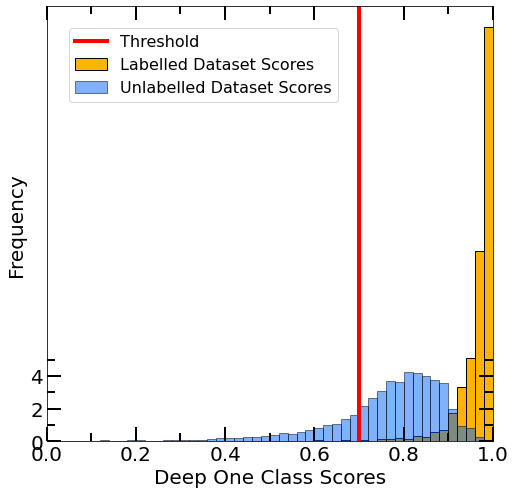

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

_, bins , _ = plt.hist(lab.train_score.values, bins=50, ec='k', histtype='bar', density=True, alpha=1, color='#feb308', label='Labelled Dataset Scores')

_= plt.hist(unlab_final.test_score, bins=bins,density=True, ec='k',alpha=0.5, color='#0165fc', label='Unlabelled Dataset Scores')
_ = plt.axvline(x=0.7, label='Threshold', c='r', linewidth=4)

plt.grid(False)
plt.xlim(0, 1.0)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
major_ticks_x = np.arange(0, 1.001, 0.2)
minor_ticks_x = np.arange(0,1.001, 0.1)
major_ticks_y = np.arange(0, 6, 2)
minor_ticks_y = np.arange(0, 6, 1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

plt.legend(prop={'size': 16}, loc=[0.05, 0.78])
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/deep_scores_ histogram.png' ,rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

n = np.linspace(.05, 1.0, 20)

X_train_val= pd.DataFrame(df.iloc[:, 1:].values)   #pd.DataFrame(labelled.iloc[:, :].values)
train_sizes =  X_train_val.shape[0]* n
print(train_sizes)
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)

_, axes = plt.subplots(1, 2, figsize=(12, 5))

#plt.plot(train_sizes, np.mean(score_tot, 0))

# Plot the learning curve for the deep one class network (TPR versus training dataset size)
axes[0].grid()
axes[0].fill_between(train_sizes, 
                    test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.5,
                         color="g")

axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", markersize=14,
                 label="Cross-validation score")

axes[0].set_ylim(50, 100)

# Plot showing the 
axes[1].grid()
axes[1].plot(train_sizes,test_scores_std, 'o-', color="g",
                 label="Cross-validation score")
axes[1].set_ylim(0, 40) 


[ 172.2  344.4  516.6  688.8  861.  1033.2 1205.4 1377.6 1549.8 1722.
 1894.2 2066.4 2238.6 2410.8 2583.  2755.2 2927.4 3099.6 3271.8 3444. ]


NameError: ignored

[ 172.2  344.4  516.6  688.8  861.  1033.2 1205.4 1377.6 1549.8 1722.
 1894.2 2066.4 2238.6 2410.8 2583.  2755.2 2927.4 3099.6 3271.8 3444. ]


(0.0, 40.0)

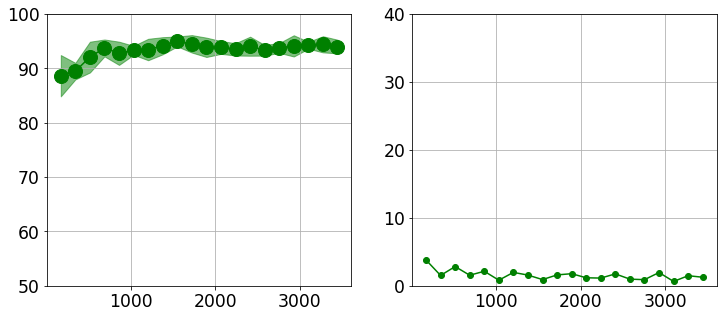

In [ ]:
import matplotlib.pyplot as plt

n = np.linspace(.05, 1.0, 20)

X_train_val= pd.DataFrame(df.iloc[:, 1:].values)   #pd.DataFrame(labelled.iloc[:, :].values)
train_sizes =  X_train_val.shape[0]* n
print(train_sizes)
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)

_, axes = plt.subplots(1, 2, figsize=(12, 5))

#plt.plot(train_sizes, np.mean(score_tot, 0))

# Plot the learning curve for the deep one class network (TPR versus training dataset size)
axes[0].grid()
axes[0].fill_between(train_sizes, 
                    test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.5,
                         color="g")

axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", markersize=14,
                 label="Cross-validation score")

axes[0].set_ylim(50, 100)

# Plot showing the 
axes[1].grid()
axes[1].plot(train_sizes,test_scores_std, 'o-', color="g",
                 label="Cross-validation score")
axes[1].set_ylim(0, 40) 


In [ ]:
# Save the evaluation results for comparison with the standrard models
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc 

array([88.64793938, 89.48935937, 92.07374186, 93.75734128, 92.76943329,
       93.32184325, 93.46668579, 94.16385392, 94.94759847, 94.51214264,
       93.8728609 , 93.84455058, 93.49626186, 94.07601175, 93.32171668,
       93.75746785, 94.13436224, 94.25093665, 94.42501772, 94.01804098])

In [ ]:
#final
deep_svdd_std

array([3.80195104, 1.52427282, 2.83192378, 1.55475729, 2.14042582,
       0.82519055, 1.97380151, 1.574675  , 0.91599351, 1.60433318,
       1.78094485, 1.18038488, 1.13535189, 1.75284229, 0.98009146,
       0.90277655, 1.95417155, 0.63935072, 1.48493679, 1.25996773])

In [ ]:
# Save the evaluation results for comparison with the standrard models
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std
deepsvdd_acc 

array([86.44175921, 90.06885611, 91.26059   , 93.64139974, 93.06004658,
       93.43829109, 93.37922334, 93.96044993, 93.26294427, 94.65732271,
       93.75713032, 93.37901239, 93.5832602 , 93.96028116, 93.75700375,
       94.30886522, 94.10563   , 94.3089918 , 93.87281871, 94.27962669])

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from random import Random

score_tot=[]

def test_net(train, test):
  dataset = Pairs_Dataset('', train, test, df.iloc[:, 1:])
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  deep_SVDD.pretrain(dataset, optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,
                   n_epochs = 60 , 
                  lr_milestones=(100,),
                   batch_size=200, 
                   weight_decay=0.5e-3,  
                   device=device,
                   n_jobs_dataloader=0)
  pred_train = deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 60,
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
               device=device,
              n_jobs_dataloader=n_jobs_dataloader)
  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  return scores1

# Perform k-fold cross validation
X_train_val=pd.DataFrame(df.iloc[:, 1:].values)
Random(0).shuffle(X_train_val)
kf = KFold(n_splits = 5,  shuffle=False)#, random_state=0)
kf.get_n_splits(X_train_val)
scores2=[]

for train, test in kf.split(X_train_val):
  scores2=[]
  scores1 = test_net(train, test)
  print(scores1)
scores2.append(scores1.ravel())

#score_mean = np.mean(scores2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/60	 Time: 0.309	 Loss: 534.94649833
INFO:root:  Epoch 2/60	 Time: 0.302	 Loss: 495.75268119
INFO:root:  Epoch 3/60	 Time: 0.297	 Loss: 427.18026297
INFO:root:

92.45283018867924


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.306	 Loss: 540.12435913
INFO:root:  Epoch 2/60	 Time: 0.308	 Loss: 498.64732143
INFO:root:  Epoch 3/60	 Time: 0.299	 Loss: 426.46806989
INFO:root:  Epoch 4/60	 Time: 0.297	 Loss: 331.43663243
INFO:root:  Epoch 5/60	 Time: 0.304	 Loss: 241.19132015
INFO:root:  Epoch 6/60	 Time: 0.293	 Loss: 179.36568560
INFO:root:  Epoch 7/60	 Time: 0.294	 Loss: 148.11908504
INFO:root:  Epoch 8/60	 Time: 0.301	 Loss: 135.09830311
INFO:root:  Epoch 9/60	 Time: 0.298	 Loss: 129.40059171
INFO:root:  Epoch 10/60	 Time: 0.299	 Loss: 125.99250031
INFO:root:  Epoch 11/60	 Time: 0.295	 Loss: 123.81317248
INFO:root:  Epoch 12/60	 Time: 0.306	 Loss: 122.56383678
INFO:root:  Epoch 13/60	 Time: 0.301	 Loss: 121.25243814
INFO:root:  Epoch 14/60	 Time: 0.297	 Loss: 120.48744692
INFO:root:  Epoch 15/60	 Time: 0.308	 Loss: 119.96994836
INFO:root:  Epoch 16/60	 Time: 0.301	 Loss: 119.46612603
INFO:root:  Epoch 17/60	 Time: 0.296	 Loss: 119.12514332
INFO:r

94.04934687953556


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.302	 Loss: 535.70302473
INFO:root:  Epoch 2/60	 Time: 0.301	 Loss: 493.06122916
INFO:root:  Epoch 3/60	 Time: 0.305	 Loss: 420.34829276
INFO:root:  Epoch 4/60	 Time: 0.293	 Loss: 327.29086522
INFO:root:  Epoch 5/60	 Time: 0.296	 Loss: 240.53625379
INFO:root:  Epoch 6/60	 Time: 0.308	 Loss: 180.45477404
INFO:root:  Epoch 7/60	 Time: 0.300	 Loss: 149.59143066
INFO:root:  Epoch 8/60	 Time: 0.296	 Loss: 136.84726388
INFO:root:  Epoch 9/60	 Time: 0.298	 Loss: 131.52047130
INFO:root:  Epoch 10/60	 Time: 0.300	 Loss: 128.93164716
INFO:root:  Epoch 11/60	 Time: 0.294	 Loss: 127.58468192
INFO:root:  Epoch 12/60	 Time: 0.299	 Loss: 126.50750678
INFO:root:  Epoch 13/60	 Time: 0.291	 Loss: 125.60423715
INFO:root:  Epoch 14/60	 Time: 0.293	 Loss: 124.95969936
INFO:root:  Epoch 15/60	 Time: 0.310	 Loss: 124.52045495
INFO:root:  Epoch 16/60	 Time: 0.305	 Loss: 124.10385459
INFO:root:  Epoch 17/60	 Time: 0.298	 Loss: 123.70220947
INFO:r

93.03338171262699


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.296	 Loss: 531.10772705
INFO:root:  Epoch 2/60	 Time: 0.299	 Loss: 491.34774780
INFO:root:  Epoch 3/60	 Time: 0.297	 Loss: 415.07859148
INFO:root:  Epoch 4/60	 Time: 0.299	 Loss: 317.19032070
INFO:root:  Epoch 5/60	 Time: 0.298	 Loss: 229.96301923
INFO:root:  Epoch 6/60	 Time: 0.294	 Loss: 171.40038845
INFO:root:  Epoch 7/60	 Time: 0.293	 Loss: 141.05707223
INFO:root:  Epoch 8/60	 Time: 0.296	 Loss: 128.68707275
INFO:root:  Epoch 9/60	 Time: 0.298	 Loss: 123.75348064
INFO:root:  Epoch 10/60	 Time: 0.291	 Loss: 121.19424547
INFO:root:  Epoch 11/60	 Time: 0.319	 Loss: 119.62470082
INFO:root:  Epoch 12/60	 Time: 0.326	 Loss: 118.63376617
INFO:root:  Epoch 13/60	 Time: 0.335	 Loss: 117.87630899
INFO:root:  Epoch 14/60	 Time: 0.323	 Loss: 117.29388700
INFO:root:  Epoch 15/60	 Time: 0.324	 Loss: 116.71791131
INFO:root:  Epoch 16/60	 Time: 0.325	 Loss: 116.04648209
INFO:root:  Epoch 17/60	 Time: 0.327	 Loss: 115.65207563
INFO:r

94.92017416545718


INFO:root:Starting pretraining...
INFO:root:  Epoch 1/60	 Time: 0.297	 Loss: 536.98272705
INFO:root:  Epoch 2/60	 Time: 0.306	 Loss: 490.07710048
INFO:root:  Epoch 3/60	 Time: 0.291	 Loss: 416.75365121
INFO:root:  Epoch 4/60	 Time: 0.309	 Loss: 321.04955619
INFO:root:  Epoch 5/60	 Time: 0.295	 Loss: 232.32781764
INFO:root:  Epoch 6/60	 Time: 0.297	 Loss: 172.83572824
INFO:root:  Epoch 7/60	 Time: 0.302	 Loss: 142.62444523
INFO:root:  Epoch 8/60	 Time: 0.319	 Loss: 129.61179079
INFO:root:  Epoch 9/60	 Time: 0.351	 Loss: 124.52925600
INFO:root:  Epoch 10/60	 Time: 0.287	 Loss: 122.24495697
INFO:root:  Epoch 11/60	 Time: 0.302	 Loss: 121.00174168
INFO:root:  Epoch 12/60	 Time: 0.299	 Loss: 119.98189981
INFO:root:  Epoch 13/60	 Time: 0.301	 Loss: 119.30558014
INFO:root:  Epoch 14/60	 Time: 0.304	 Loss: 118.04516820
INFO:root:  Epoch 15/60	 Time: 0.304	 Loss: 117.57308143
INFO:root:  Epoch 16/60	 Time: 0.308	 Loss: 116.91449138
INFO:root:  Epoch 17/60	 Time: 0.298	 Loss: 116.40139280
INFO:r

93.8953488372093


In [ ]:
scores2

[array([94.18604651])]

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from random import Random

# Perform k-fold cross validation
import random
X_train_val=pd.DataFrame(df.iloc[:1722, 1:].values)
kf_score=[]
kf = KFold(n_splits = 5,  shuffle=True, random_state=0)
kf.get_n_splits(X_train_val)
scores2=[]

for train, test in kf.split(X_train_val):
  dataset = Pairs_Dataset('', train, test)  
  Random(0).shuffle(train)
  #deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], 1e-4)
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  #pretrain(deep_SVDD, dataset, n_epochs=60, lr=1e-5)
  #pred_train = deep_SVDD.train(dataset,n_epochs= 60,  lr=1e-5)
  deep_SVDD.pretrain(dataset, optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,
                   n_epochs = 60 )#, 
                #   lr_milestones=(100,),
                 #  batch_size=200, 
                  # weight_decay=0.5e-3,  
                   #device=device,
                   #n_jobs_dataloader=0)

  pred_train = deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 60)#,
               # lr_milestones=cfg.settings['lr_milestone'],
               # batch_size=cfg.settings['batch_size'],
               # weight_decay=cfg.settings['weight_decay'],
               # device=device,
              #n_jobs_dataloader=n_jobs_dataloader)

  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  scores2.append(scores1)
  score_mean = np.mean(scores2)
kf_score.append(scores2)
scores2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/60	 Time: 0.240	 Loss: 541.16866788
INFO:root:  Epoch 2/60	 Time: 0.232	 Loss: 506.97067538
INFO:root:  Epoch 3/60	 Time: 0.256	 Loss: 456.33312156
INFO:root:

[87.2463768115942,
 90.72463768115942,
 94.76744186046511,
 92.15116279069767,
 92.15116279069767]

In [ ]:
# Print Deep Neural Network kfold Accuracy 60-60  all layers
print(np.mean(scores2, 0))
print(np.std(scores2, 0))
scores2

91.40815638692281
2.4566856933520835


[87.2463768115942,
 90.72463768115942,
 94.76744186046511,
 92.15116279069767,
 92.15116279069767]

In [ ]:
# Print Deep Neural Network kfold Accuracy 60-60  all layers
print(np.mean(scores2, 0))
print(np.std(scores2, 0))
scores2

94.30839231547017
1.4196511615494336


[93.33333333333333,
 96.23188405797102,
 95.05813953488372,
 94.76744186046511,
 92.15116279069767]

In [ ]:
# Print Deep Neural Network kfold Accuracy 90-100 all layers
print(np.mean(scores2, 0))
print(np.std(scores2, 0))
scores2

94.65722952477249
0.8730760584180209


[93.6231884057971,
 95.94202898550725,
 93.8953488372093,
 95.34883720930233,
 94.47674418604652]

In [ ]:
# Print Deep Neural Network kfold Accuracy 80-100 all layers
print(np.mean(scores2, 0))
print(np.std(scores2, 0))
scores2

94.25109538254131
1.1668932088114774


[93.33333333333333,
 94.78260869565217,
 92.44186046511628,
 95.34883720930233,
 95.34883720930233]

In [ ]:
# Print Deep Neural Network kfold Accuracy 100-80 all layers
print(np.mean(scores2, 0))
print(np.std(scores2, 0))
scores2

93.38018200202225
1.6336309333105783


[91.01449275362319,
 95.07246376811594,
 93.02325581395348,
 95.34883720930233,
 92.44186046511628]

In [ ]:
# Print Deep Neural Network kfold Accuracy 80-80 all layers
print(np.mean(scores2, 0))
print(np.std(scores2, 0))
scores2

93.90276373441185
1.869581759476564


[91.01449275362319,
 96.23188405797102,
 93.31395348837209,
 95.63953488372093,
 93.31395348837209]

In [ ]:
# Print Deep Neural Network kfold Accuracy 100/100 all layers
print(np.mean(scores2, 0))
print(np.std(scores2, 0))
scores2

94.13481631277384
0.9597293819789633


[92.7536231884058,
 95.3623188405797,
 93.8953488372093,
 95.05813953488372,
 93.6046511627907]

In [ ]:
# Print Deep Neural Network kfold Accuracy 100/100
print(np.mean(scores2, 0))
print(np.std(scores2, 0))
scores2

94.54111897539602
1.2106849710931626


[93.6231884057971,
 95.65217391304348,
 92.73255813953489,
 94.76744186046511,
 95.93023255813954]

In [ ]:
# Print Deep Neural Network kfold Accuracy 100/80
print(np.mean(scores2, 0))
print(np.std(scores2, 0))
scores2

94.3675429726997
1.6354041870702496


[91.88405797101449,
 95.94202898550725,
 93.02325581395348,
 95.93023255813954,
 95.05813953488372]

# Ratios and shapley

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.


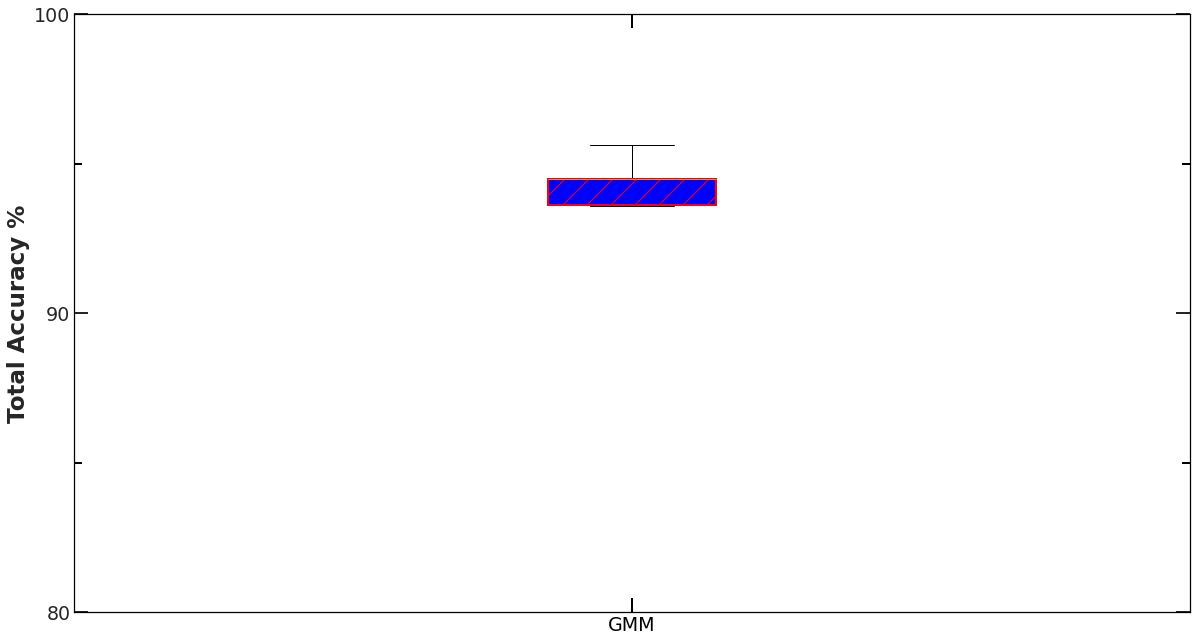

In [ ]:
# Box plot with scores
#Import the accuracies table 

# Accuracy on the known data 

#model_acc = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/kfold_accuracy.csv')
data1 =scores2# val_list#[0]
# [model_acc.GMM , model_acc.kNN ,model_acc.HBOS  ,model_acc.Feat_bag ,model_acc.Iforest ,model_acc.OCSVM ,model_acc.LOF ,model_acc.CBLOF ,model_acc.Ensemble ,model_acc.DeepSVDD ]
import seaborn as sns
sns.set(rc={'figure.figsize':(20 ,11)})
sns.set_style("whitegrid", {'axes.grid' : False})

fig1, ax1 = plt.subplots()
ax1.set_ylim(80, 100)
#ax1.set_yticks([80, 90 ,100])
ax1.set_xticklabels(['GMM', ' kNN', 'HBOS', 'Feature\nBagging',   'Iforest', 'OCSVM',  'LOF', 'CBLOF', 'Ensemble', 'DeepSVDD' ])
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_y = np.arange(80, 100.1, 10)
minor_ticks_y = np.arange(80, 100.1, 5)

ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)

red_square = dict(markerfacecolor='r', marker='s')
bp0=ax1.boxplot(data1, patch_artist=True , showfliers=True, whis='range', vert=True,  flierprops=red_square)

for box in bp0['boxes']:
    # change outline color
    box.set(color='red', linewidth=2)
    # change fill color
    box.set(facecolor = 'blue' )
    # change hatch
    box.set(hatch = '/')
#plt.xlabel('One class classification models',  fontsize=18)
plt.ylabel('Total Accuracy %', fontsize=23 )
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
#plt.title('AUC=%.3f,   F1-score=%.3f' % (auc, f1) ,fontsize=18)
ax1.xaxis.label.set_color('black')
ax1.tick_params(axis='x', colors='black')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')

In [ ]:
# Import the datasets

dataset1 = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/coformers1.csv')
dataset2 = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/coformers2.csv')
dataset1.head()

# Dataset with ratios
dictionar=pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/cocrystal_ratios.csv')
keys = dictionar.iloc[:, 0].values
values = dictionar.iloc[:, 3:7].values
d = {key:value for key, value in zip(keys, values)}

In [ ]:
# Assign to each combination their molecular ratio and their Z number
ratios=[]
for x in dataset2['Identifier'].values:
  ratios.append(d[x])  
ratio=pd.DataFrame(ratios, columns=['Z', 'mol1', 'mol2', 'ratios'])  
rat=pd.concat([dataset2 ,ratio], axis=1)
dataset = rat.drop(['mol1', 'mol2'], axis=1)
d2=dataset.drop(['Identifier', 'NAME'], axis=1)
d1= dataset1.insert(loc=2, column='NAME2', value=dataset['NAME'])
dataset_ratios=pd.concat([dataset1, d2], axis=1)


In [ ]:
# Standarize the dataset
# Standarize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
#X_scaler = StandardScaler()

df_concat = pd.concat([df1, df2])
df_concat = df_concat.drop_duplicates(keep='first')
numerical_cols = df_concat.columns[:]
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)

numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1_scaled,df2_scaled)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df_ratios = pd.concat([df, pd.concat([dataset['ratios'], dataset['ratios']])], axis=1)
df_ratios.tail()

Identifier        MW       AMW  ...  Infective-80  Infective-50  ratios
1717    AFOTIB_  0.007336  0.048022  ...      0.000000      0.000000     1/3
1718    CIQNIC_  0.007336  0.048022  ...      0.000000      0.000000     1/2
1719    DIVZUG_  0.007336  0.048022  ...      0.000000      0.000000     1/2
1720    PIQTOB_  0.007336  0.048022  ...      0.145605      0.014594     1/2
1721    RAWXEU_  0.002560  0.075504  ...      0.000000      0.000000     1/2

[5 rows x 3716 columns]

In [ ]:
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

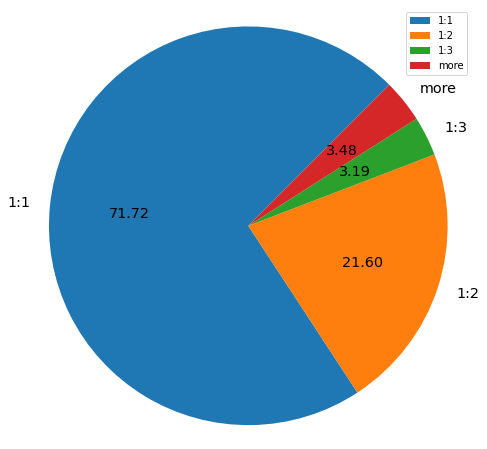

In [ ]:
# Count the molecular ratios of the co-crystals in the training set and visualization in a pie chart

import matplotlib.pyplot as plotter
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

counts = dataset_ratios.ratios.value_counts() #dataset_ratios.ratios.value_counts()
# The slice names of a population distribution pie chart
pieLabels = '1:1', '1:2', '1:3', 'more'

# Population data
populationShare  = (counts.values[0], counts.values[1], counts.values[2], dataset_ratios.shape[0]-counts.values[0] -counts.values[1]- counts.values[2])
figureObject, axesObject = plotter.subplots()

# Draw the pie chart
axesObject.pie(populationShare, labels=pieLabels,  autopct='%1.2f', startangle=45,  textprops={'size': 'x-large'}, radius=0.5)
axesObject.axis('equal')
plotter.figure
plotter.legend()
#plotter.savefig('pie-chart.eps')
plotter.show()

(-0.1, 0.1)

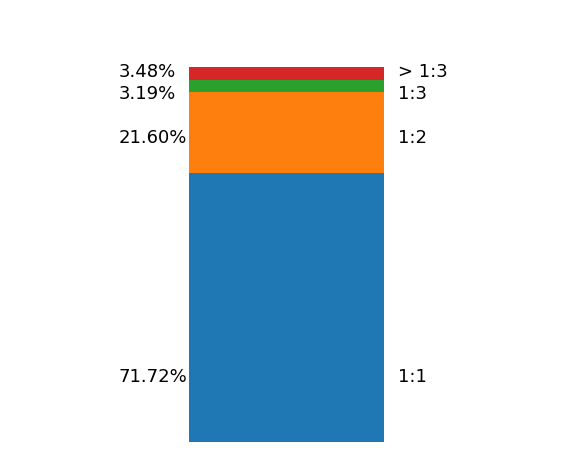

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Labels = '1:1', '1:2', '1:3', 'more'
df1 = pd.concat([pd.DataFrame(Labels, columns=['ratio']) ,pd.DataFrame(populationShare, columns=['count'])], axis=1)
freq = pd.Series(df1['count'])
fig,ax = plt.subplots(figsize=(10,8))
fig.patch.set_visible(False)
ax.axis('off')
freq.to_frame().T.plot.bar(stacked=True, width=0.07, ax=ax)
ax.get_legend().remove()
ax.text(0.04, 300, s='1:1', va='center', fontsize=18)
ax.text(0.04, 1400, s='1:2', va='center', fontsize=18)
ax.text(0.04, 1600, s='1:3', va='center', fontsize=18)
ax.text(0.04, 1700, s='> 1:3', va='center', fontsize=18)

# Add the percentages
ax.text(-0.06, 300, s='71.72%', va='center', fontsize=18)
ax.text(-0.06, 1400, s='21.60%', va='center', fontsize=18)
ax.text(-0.06, 1600, s='3.19%', va='center', fontsize=18)
ax.text(-0.06, 1700, s='3.48%', va='center', fontsize=18)
ax.set_ylabel('Counts')
ax.set_xlabel('Co-crystal Ratios')
ax.set_ylim(0, 2000)
ax.set_xlim(-0.1, 0.1)

#plt.savefig('barch.svg')

In [ ]:
ratios = df_ratios.ratios
ratios[ratios != '1'] = 1
ratios[ratios == '1'] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Predict the ratios
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
df=df.fillna(0)
net = deep_SVDD.net.to(device)
X= df.iloc[:,1:].values
X = torch.FloatTensor(X).to(device)
y1 = net(X)

X= y1.cpu().detach().numpy()


y= ratios# df_ratios.iloc[:, -1].values #

y = y.apply(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
from imblearn.over_sampling import SMOTE

smote =SMOTE('minority', k_neighbors=5, random_state=0)

X_sm, y_sm= smote.fit_sample(X, y)#, random=0)
print(X_sm.shape, y_sm.shape)
print(X.shape)


X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.35)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(4940, 100) (4940,)
(3444, 100)


In [ ]:
from hyperopt import tpe
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
import xgboost as xgb
from hyperopt import hp
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


def objective(space):
    #warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree'],
                            objective='binary:logistic',
                            nthread=2, scale_pos_weight=1,
                            seed=0)
    
    #classifier.fit(X_train, y_train)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    classifier.fit(X_train, y_train, early_stopping_rounds=15, eval_metric="auc", eval_set=eval_set, verbose=True)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return{'loss':1-accuracy, 'status': STATUS_OK }  #CrossValMean


space ={ 'max_depth' : hp.quniform('max_depth', 5, 10, 1),
    'learning_rate' : hp.quniform('learning_rate', 0.1, 0.2, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(10, 50, 1)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}
trials = Trials()



#clf = XGBClassifier(learning_rate=0.15, n_estimators=35, max_depth=8,
                  #      min_child_weight=1, gamma=0.08, subsample=0.9, colsample_bytree=0.84,
                    #    objective='binary:logistic', nthread=2, scale_pos_weight=1, seed=0)  


rstate = np.random.RandomState(0) 
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials, rstate=rstate)

print("Best: ", best)

INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt


  0%|          | 0/30 [00:00<?, ?it/s, best loss: ?]

INFO:hyperopt.tpe:tpe_transform took 0.003332 seconds
INFO:hyperopt.tpe:TPE using 0 trials


[0]	validation_0-auc:0.718934	validation_1-auc:0.625341

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.744537	validation_1-auc:0.664703

[2]	validation_0-auc:0.780513	validation_1-auc:0.703282

[3]	validation_0-auc:0.810736	validation_1-auc:0.73354

[4]	validation_0-auc:0.829821	validation_1-auc:0.751462

[5]	validation_0-auc:0.858424	validation_1-auc:0.760513

[6]	validation_0-auc:0.867797	validation_1-auc:0.77123

[7]	validation_0-auc:0.876959	validation_1-auc:0.780939

[8]	validation_0-auc:0.888533	validation_1-auc:0.797987

[9]	validation_0-auc:0.905137	validation_1-auc:0.809847

[10]	validation_0-auc:0.913968	validation_1-auc:0.820027

[11]	validation_0-auc:0.919832	validation_1-auc:0.825491

[12]	validation_0-auc:0.923327	validation_1-auc:0.825566

[13]	validation_0-auc:0.930343	validation_1-auc:0.837037

[14]	validation_0-auc:0.933532	validation

INFO:hyperopt.tpe:tpe_transform took 0.003642 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.161943


[0]	validation_0-auc:0.689519	validation_1-auc:0.629353

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.775125	validation_1-auc:0.681344

[2]	validation_0-auc:0.822489	validation_1-auc:0.716709

[3]	validation_0-auc:0.867011	validation_1-auc:0.76058

[4]	validation_0-auc:0.885757	validation_1-auc:0.776501

[5]	validation_0-auc:0.913499	validation_1-auc:0.798082

[6]	validation_0-auc:0.929696	validation_1-auc:0.812346

[7]	validation_0-auc:0.94364	validation_1-auc:0.830389

[8]	validation_0-auc:0.956164	validation_1-auc:0.848179

[9]	validation_0-auc:0.963146	validation_1-auc:0.85294

[10]	validation_0-auc:0.968406	validation_1-auc:0.860296

[11]	validation_0-auc:0.972317	validation_1-auc:0.865031

[12]	validation_0-auc:0.973123	validation_1-auc:0.868996

[13]	validation_0-auc:0.975679	validation_1-auc:0.874253

[14]	validation_0-auc:0.979738	validation_

INFO:hyperopt.tpe:tpe_transform took 0.003808 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.119722


[0]	validation_0-auc:0.682329	validation_1-auc:0.620927

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.745623	validation_1-auc:0.675289

[2]	validation_0-auc:0.776005	validation_1-auc:0.703011

[3]	validation_0-auc:0.807307	validation_1-auc:0.718712

[4]	validation_0-auc:0.824088	validation_1-auc:0.727465

[5]	validation_0-auc:0.841404	validation_1-auc:0.743047

[6]	validation_0-auc:0.846693	validation_1-auc:0.749097

[7]	validation_0-auc:0.851644	validation_1-auc:0.754413

[8]	validation_0-auc:0.864616	validation_1-auc:0.764372

[9]	validation_0-auc:0.874571	validation_1-auc:0.776353

[10]	validation_0-auc:0.884612	validation_1-auc:0.78546

[11]	validation_0-auc:0.892338	validation_1-auc:0.790989

[12]	validation_0-auc:0.896442	validation_1-auc:0.795815

[13]	validation_0-auc:0.901051	validation_1-auc:0.800386

[14]	validation_0-auc:0.908693	validatio

INFO:hyperopt.tpe:tpe_transform took 0.003734 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.119722


[0]	validation_0-auc:0.805658	validation_1-auc:0.690822

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.884812	validation_1-auc:0.755593

[2]	validation_0-auc:0.919436	validation_1-auc:0.801881

[3]	validation_0-auc:0.949805	validation_1-auc:0.838786

[4]	validation_0-auc:0.96649	validation_1-auc:0.870516

[5]	validation_0-auc:0.975815	validation_1-auc:0.887533

[6]	validation_0-auc:0.978738	validation_1-auc:0.896707

[7]	validation_0-auc:0.981715	validation_1-auc:0.904019

[8]	validation_0-auc:0.987166	validation_1-auc:0.917096

[9]	validation_0-auc:0.989557	validation_1-auc:0.923203

[10]	validation_0-auc:0.991888	validation_1-auc:0.932844

[11]	validation_0-auc:0.9932	validation_1-auc:0.935118

[12]	validation_0-auc:0.993626	validation_1-auc:0.936977

[13]	validation_0-auc:0.995179	validation_1-auc:0.941226

[14]	validation_0-auc:0.996362	validation_

INFO:hyperopt.tpe:tpe_transform took 0.003783 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.082707


[0]	validation_0-auc:0.653101	validation_1-auc:0.61675

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.70155	validation_1-auc:0.652324

[2]	validation_0-auc:0.752134	validation_1-auc:0.687625

[3]	validation_0-auc:0.790146	validation_1-auc:0.709922

[4]	validation_0-auc:0.812917	validation_1-auc:0.733102

[5]	validation_0-auc:0.836395	validation_1-auc:0.755043

[6]	validation_0-auc:0.851978	validation_1-auc:0.758708

[7]	validation_0-auc:0.86117	validation_1-auc:0.774419

[8]	validation_0-auc:0.874568	validation_1-auc:0.783724

[9]	validation_0-auc:0.881712	validation_1-auc:0.791649

[10]	validation_0-auc:0.895711	validation_1-auc:0.807447

[11]	validation_0-auc:0.903523	validation_1-auc:0.814517

[12]	validation_0-auc:0.906965	validation_1-auc:0.817904

[13]	validation_0-auc:0.912298	validation_1-auc:0.818548

[14]	validation_0-auc:0.9176	validation_1-

INFO:hyperopt.tpe:tpe_transform took 0.003481 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.082707


[0]	validation_0-auc:0.685989	validation_1-auc:0.626205

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.765737	validation_1-auc:0.690588

[2]	validation_0-auc:0.794374	validation_1-auc:0.715821

[3]	validation_0-auc:0.819335	validation_1-auc:0.741785

[4]	validation_0-auc:0.843472	validation_1-auc:0.765438

[5]	validation_0-auc:0.85936	validation_1-auc:0.769446

[6]	validation_0-auc:0.876268	validation_1-auc:0.780791

[7]	validation_0-auc:0.885131	validation_1-auc:0.7919

[8]	validation_0-auc:0.8976	validation_1-auc:0.802778

[9]	validation_0-auc:0.903801	validation_1-auc:0.809273

[10]	validation_0-auc:0.911159	validation_1-auc:0.818399

[11]	validation_0-auc:0.91859	validation_1-auc:0.827594

[12]	validation_0-auc:0.921921	validation_1-auc:0.83115

[13]	validation_0-auc:0.926367	validation_1-auc:0.83299

[14]	validation_0-auc:0.934121	validation_1-auc

INFO:hyperopt.tpe:tpe_transform took 0.005177 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.082707


[0]	validation_0-auc:0.78922	validation_1-auc:0.690686

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.891272	validation_1-auc:0.779016

[2]	validation_0-auc:0.941218	validation_1-auc:0.835605

[3]	validation_0-auc:0.961006	validation_1-auc:0.8645

[4]	validation_0-auc:0.966592	validation_1-auc:0.875811

[5]	validation_0-auc:0.973791	validation_1-auc:0.885534

[6]	validation_0-auc:0.979152	validation_1-auc:0.897222

[7]	validation_0-auc:0.983141	validation_1-auc:0.904638

[8]	validation_0-auc:0.985663	validation_1-auc:0.914428

[9]	validation_0-auc:0.987144	validation_1-auc:0.917983

[10]	validation_0-auc:0.988102	validation_1-auc:0.92106

[11]	validation_0-auc:0.989938	validation_1-auc:0.927167

[12]	validation_0-auc:0.99102	validation_1-auc:0.926657

[13]	validation_0-auc:0.991913	validation_1-auc:0.929053

[14]	validation_0-auc:0.992179	validation_1-

INFO:hyperopt.tpe:tpe_transform took 0.003528 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.082707


[0]	validation_0-auc:0.818621	validation_1-auc:0.742438

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.922397	validation_1-auc:0.814375

[2]	validation_0-auc:0.956414	validation_1-auc:0.856662

[3]	validation_0-auc:0.970549	validation_1-auc:0.878706

[4]	validation_0-auc:0.980682	validation_1-auc:0.90192

[5]	validation_0-auc:0.983736	validation_1-auc:0.906939

[6]	validation_0-auc:0.987788	validation_1-auc:0.916932

[7]	validation_0-auc:0.991461	validation_1-auc:0.92816

[8]	validation_0-auc:0.993178	validation_1-auc:0.933082

[9]	validation_0-auc:0.994722	validation_1-auc:0.938026

[10]	validation_0-auc:0.9955	validation_1-auc:0.942009

[11]	validation_0-auc:0.99641	validation_1-auc:0.945946

[12]	validation_0-auc:0.996981	validation_1-auc:0.94905

[13]	validation_0-auc:0.9975	validation_1-auc:0.95176

[14]	validation_0-auc:0.997521	validation_1-auc:

INFO:hyperopt.tpe:tpe_transform took 0.003368 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.069404


[0]	validation_0-auc:0.748717	validation_1-auc:0.662092

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.821539	validation_1-auc:0.713961

[2]	validation_0-auc:0.888995	validation_1-auc:0.775811

[3]	validation_0-auc:0.909518	validation_1-auc:0.796827

[4]	validation_0-auc:0.928105	validation_1-auc:0.810925

[5]	validation_0-auc:0.938197	validation_1-auc:0.821288

[6]	validation_0-auc:0.94661	validation_1-auc:0.835767

[7]	validation_0-auc:0.952427	validation_1-auc:0.843038

[8]	validation_0-auc:0.958865	validation_1-auc:0.852214

[9]	validation_0-auc:0.966487	validation_1-auc:0.859523

[10]	validation_0-auc:0.970692	validation_1-auc:0.867907

[11]	validation_0-auc:0.973634	validation_1-auc:0.875049

[12]	validation_0-auc:0.977429	validation_1-auc:0.882281

[13]	validation_0-auc:0.979818	validation_1-auc:0.885266

[14]	validation_0-auc:0.981953	validatio

INFO:hyperopt.tpe:tpe_transform took 0.003799 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.069404


[0]	validation_0-auc:0.664626	validation_1-auc:0.633893

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.689563	validation_1-auc:0.649993

[2]	validation_0-auc:0.727235	validation_1-auc:0.680908

[3]	validation_0-auc:0.755287	validation_1-auc:0.702005

[4]	validation_0-auc:0.774645	validation_1-auc:0.709753

[5]	validation_0-auc:0.790711	validation_1-auc:0.720278

[6]	validation_0-auc:0.799712	validation_1-auc:0.730351

[7]	validation_0-auc:0.811079	validation_1-auc:0.737694

[8]	validation_0-auc:0.822808	validation_1-auc:0.756024

[9]	validation_0-auc:0.829411	validation_1-auc:0.758525

[10]	validation_0-auc:0.836325	validation_1-auc:0.75868

[11]	validation_0-auc:0.847042	validation_1-auc:0.770463

[12]	validation_0-auc:0.852455	validation_1-auc:0.769951

[13]	validation_0-auc:0.859236	validation_1-auc:0.778376

[14]	validation_0-auc:0.872953	validatio

INFO:hyperopt.tpe:tpe_transform took 0.003310 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.069404


[0]	validation_0-auc:0.784702	validation_1-auc:0.674063

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.836286	validation_1-auc:0.716714

[2]	validation_0-auc:0.885702	validation_1-auc:0.758474

[3]	validation_0-auc:0.917411	validation_1-auc:0.798685

[4]	validation_0-auc:0.927481	validation_1-auc:0.816944

[5]	validation_0-auc:0.947021	validation_1-auc:0.844325

[6]	validation_0-auc:0.955974	validation_1-auc:0.85734

[7]	validation_0-auc:0.960841	validation_1-auc:0.863764

[8]	validation_0-auc:0.966152	validation_1-auc:0.874481

[9]	validation_0-auc:0.972421	validation_1-auc:0.885254

[10]	validation_0-auc:0.978167	validation_1-auc:0.893532

[11]	validation_0-auc:0.981138	validation_1-auc:0.898545

[12]	validation_0-auc:0.982022	validation_1-auc:0.90122

[13]	validation_0-auc:0.983778	validation_1-auc:0.906259

[14]	validation_0-auc:0.986694	validation

INFO:hyperopt.tpe:tpe_transform took 0.003918 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.069404


[0]	validation_0-auc:0.74221	validation_1-auc:0.645216

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.845676	validation_1-auc:0.732349

[2]	validation_0-auc:0.884713	validation_1-auc:0.777855

[3]	validation_0-auc:0.920634	validation_1-auc:0.817571

[4]	validation_0-auc:0.931139	validation_1-auc:0.832893

[5]	validation_0-auc:0.944105	validation_1-auc:0.848183

[6]	validation_0-auc:0.95389	validation_1-auc:0.859241

[7]	validation_0-auc:0.963468	validation_1-auc:0.875053

[8]	validation_0-auc:0.971287	validation_1-auc:0.890242

[9]	validation_0-auc:0.975257	validation_1-auc:0.895294

[10]	validation_0-auc:0.98151	validation_1-auc:0.904636

[11]	validation_0-auc:0.98306	validation_1-auc:0.909413

[12]	validation_0-auc:0.984818	validation_1-auc:0.911865

[13]	validation_0-auc:0.986752	validation_1-auc:0.917253

[14]	validation_0-auc:0.988403	validation_1

INFO:hyperopt.tpe:tpe_transform took 0.003853 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.069404


[0]	validation_0-auc:0.816269	validation_1-auc:0.725124

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.879838	validation_1-auc:0.779543

[2]	validation_0-auc:0.924185	validation_1-auc:0.822283

[3]	validation_0-auc:0.954651	validation_1-auc:0.856387

[4]	validation_0-auc:0.97069	validation_1-auc:0.883721

[5]	validation_0-auc:0.979947	validation_1-auc:0.896166

[6]	validation_0-auc:0.984933	validation_1-auc:0.909897

[7]	validation_0-auc:0.990058	validation_1-auc:0.92254

[8]	validation_0-auc:0.992977	validation_1-auc:0.931983

[9]	validation_0-auc:0.994949	validation_1-auc:0.939613

[10]	validation_0-auc:0.995607	validation_1-auc:0.943161

[11]	validation_0-auc:0.996788	validation_1-auc:0.947185

[12]	validation_0-auc:0.99781	validation_1-auc:0.952965

[13]	validation_0-auc:0.998327	validation_1-auc:0.956735

[14]	validation_0-auc:0.998592	validation_

INFO:hyperopt.tpe:tpe_transform took 0.003516 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 0.069404


[0]	validation_0-auc:0.713805	validation_1-auc:0.659609

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.773997	validation_1-auc:0.704378

[2]	validation_0-auc:0.805212	validation_1-auc:0.724791

[3]	validation_0-auc:0.842953	validation_1-auc:0.749315

[4]	validation_0-auc:0.862071	validation_1-auc:0.775694

[5]	validation_0-auc:0.887095	validation_1-auc:0.80324

[6]	validation_0-auc:0.898784	validation_1-auc:0.808046

[7]	validation_0-auc:0.905504	validation_1-auc:0.814786

[8]	validation_0-auc:0.915567	validation_1-auc:0.819489

[9]	validation_0-auc:0.926322	validation_1-auc:0.829749

[10]	validation_0-auc:0.935666	validation_1-auc:0.83824

[11]	validation_0-auc:0.941897	validation_1-auc:0.845155

[12]	validation_0-auc:0.943917	validation_1-auc:0.847398

[13]	validation_0-auc:0.949062	validation_1-auc:0.855443

[14]	validation_0-auc:0.953764	validation

INFO:hyperopt.tpe:tpe_transform took 0.003794 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 0.069404


[0]	validation_0-auc:0.729133	validation_1-auc:0.638256

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.776067	validation_1-auc:0.692177

[2]	validation_0-auc:0.836341	validation_1-auc:0.73608

[3]	validation_0-auc:0.86819	validation_1-auc:0.765261

[4]	validation_0-auc:0.886403	validation_1-auc:0.777776

[5]	validation_0-auc:0.906728	validation_1-auc:0.797789

[6]	validation_0-auc:0.914644	validation_1-auc:0.808121

[7]	validation_0-auc:0.922435	validation_1-auc:0.820637

[8]	validation_0-auc:0.929624	validation_1-auc:0.82605

[9]	validation_0-auc:0.933389	validation_1-auc:0.834907

[10]	validation_0-auc:0.94085	validation_1-auc:0.841638

[11]	validation_0-auc:0.944764	validation_1-auc:0.847947

[12]	validation_0-auc:0.949033	validation_1-auc:0.85506

[13]	validation_0-auc:0.953113	validation_1-auc:0.858948

[14]	validation_0-auc:0.956063	validation_1-

INFO:hyperopt.tpe:tpe_transform took 0.003738 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 0.069404


[0]	validation_0-auc:0.690813	validation_1-auc:0.657196

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.758623	validation_1-auc:0.689709

[2]	validation_0-auc:0.794066	validation_1-auc:0.718261

[3]	validation_0-auc:0.83084	validation_1-auc:0.742448

[4]	validation_0-auc:0.849131	validation_1-auc:0.754105

[5]	validation_0-auc:0.863542	validation_1-auc:0.765936

[6]	validation_0-auc:0.878745	validation_1-auc:0.780509

[7]	validation_0-auc:0.888869	validation_1-auc:0.792283

[8]	validation_0-auc:0.90147	validation_1-auc:0.810945

[9]	validation_0-auc:0.909079	validation_1-auc:0.823909

[10]	validation_0-auc:0.91659	validation_1-auc:0.827347

[11]	validation_0-auc:0.923732	validation_1-auc:0.835818

[12]	validation_0-auc:0.929174	validation_1-auc:0.835402

[13]	validation_0-auc:0.939004	validation_1-auc:0.845007

[14]	validation_0-auc:0.944532	validation_

INFO:hyperopt.tpe:tpe_transform took 0.005211 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 0.069404


[0]	validation_0-auc:0.762827	validation_1-auc:0.67309

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.8524	validation_1-auc:0.748182

[2]	validation_0-auc:0.894756	validation_1-auc:0.786311

[3]	validation_0-auc:0.906751	validation_1-auc:0.804027

[4]	validation_0-auc:0.923748	validation_1-auc:0.820024

[5]	validation_0-auc:0.92889	validation_1-auc:0.831738

[6]	validation_0-auc:0.944177	validation_1-auc:0.850508

[7]	validation_0-auc:0.951938	validation_1-auc:0.860814

[8]	validation_0-auc:0.963019	validation_1-auc:0.872538

[9]	validation_0-auc:0.965883	validation_1-auc:0.877248

[10]	validation_0-auc:0.968746	validation_1-auc:0.883775

[11]	validation_0-auc:0.971474	validation_1-auc:0.886867

[12]	validation_0-auc:0.975051	validation_1-auc:0.894364

[13]	validation_0-auc:0.9765	validation_1-auc:0.897013

[14]	validation_0-auc:0.977961	validation_1-a

INFO:hyperopt.tpe:tpe_transform took 0.004743 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 0.069404


[0]	validation_0-auc:0.805942	validation_1-auc:0.703774

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.91272	validation_1-auc:0.785606

[2]	validation_0-auc:0.944381	validation_1-auc:0.821757

[3]	validation_0-auc:0.966689	validation_1-auc:0.848929

[4]	validation_0-auc:0.978224	validation_1-auc:0.868653

[5]	validation_0-auc:0.986032	validation_1-auc:0.886895

[6]	validation_0-auc:0.988113	validation_1-auc:0.896145

[7]	validation_0-auc:0.991389	validation_1-auc:0.905545

[8]	validation_0-auc:0.993999	validation_1-auc:0.915452

[9]	validation_0-auc:0.99529	validation_1-auc:0.922567

[10]	validation_0-auc:0.995968	validation_1-auc:0.928061

[11]	validation_0-auc:0.996321	validation_1-auc:0.931522

[12]	validation_0-auc:0.997311	validation_1-auc:0.938065

[13]	validation_0-auc:0.997828	validation_1-auc:0.942018

[14]	validation_0-auc:0.9979	validation_1

INFO:hyperopt.tpe:tpe_transform took 0.006265 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 0.069404


[0]	validation_0-auc:0.715301	validation_1-auc:0.658953

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.764648	validation_1-auc:0.712213

[2]	validation_0-auc:0.80341	validation_1-auc:0.73813

[3]	validation_0-auc:0.839581	validation_1-auc:0.760117

[4]	validation_0-auc:0.861995	validation_1-auc:0.770763

[5]	validation_0-auc:0.876834	validation_1-auc:0.787729

[6]	validation_0-auc:0.890282	validation_1-auc:0.797938

[7]	validation_0-auc:0.89725	validation_1-auc:0.803646

[8]	validation_0-auc:0.905995	validation_1-auc:0.813793

[9]	validation_0-auc:0.915972	validation_1-auc:0.826311

[10]	validation_0-auc:0.925183	validation_1-auc:0.83313

[11]	validation_0-auc:0.932943	validation_1-auc:0.835773

[12]	validation_0-auc:0.93695	validation_1-auc:0.840356

[13]	validation_0-auc:0.941877	validation_1-auc:0.846829

[14]	validation_0-auc:0.946754	validation_1-

INFO:hyperopt.tpe:tpe_transform took 0.003489 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 0.069404


[0]	validation_0-auc:0.77971	validation_1-auc:0.664967

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.834283	validation_1-auc:0.723599

[2]	validation_0-auc:0.908921	validation_1-auc:0.809983

[3]	validation_0-auc:0.936571	validation_1-auc:0.843344

[4]	validation_0-auc:0.951406	validation_1-auc:0.868211

[5]	validation_0-auc:0.966154	validation_1-auc:0.891414

[6]	validation_0-auc:0.970446	validation_1-auc:0.899536

[7]	validation_0-auc:0.977987	validation_1-auc:0.912113

[8]	validation_0-auc:0.981902	validation_1-auc:0.919598

[9]	validation_0-auc:0.986066	validation_1-auc:0.926397

[10]	validation_0-auc:0.987992	validation_1-auc:0.931344

[11]	validation_0-auc:0.990266	validation_1-auc:0.934152

[12]	validation_0-auc:0.991163	validation_1-auc:0.934765

[13]	validation_0-auc:0.991532	validation_1-auc:0.938867

[14]	validation_0-auc:0.991991	validatio

INFO:hyperopt.tpe:tpe_transform took 0.004073 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 0.069404


[0]	validation_0-auc:0.914603	validation_1-auc:0.794551

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.972215	validation_1-auc:0.879403

[2]	validation_0-auc:0.988362	validation_1-auc:0.908194

[3]	validation_0-auc:0.992156	validation_1-auc:0.92543

[4]	validation_0-auc:0.99574	validation_1-auc:0.937364

[5]	validation_0-auc:0.99698	validation_1-auc:0.942431

[6]	validation_0-auc:0.998335	validation_1-auc:0.949497

[7]	validation_0-auc:0.998876	validation_1-auc:0.955741

[8]	validation_0-auc:0.999169	validation_1-auc:0.960479

[9]	validation_0-auc:0.999437	validation_1-auc:0.962693

[10]	validation_0-auc:0.999497	validation_1-auc:0.963379

[11]	validation_0-auc:0.999587	validation_1-auc:0.965196

[12]	validation_0-auc:0.999684	validation_1-auc:0.96785

[13]	validation_0-auc:0.999817	validation_1-auc:0.969637

[14]	validation_0-auc:0.999826	validation_1

INFO:hyperopt.tpe:tpe_transform took 0.003507 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 0.053788


[0]	validation_0-auc:0.888003	validation_1-auc:0.750014

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.95711	validation_1-auc:0.843858

[2]	validation_0-auc:0.982155	validation_1-auc:0.880485

[3]	validation_0-auc:0.989361	validation_1-auc:0.905233

[4]	validation_0-auc:0.995988	validation_1-auc:0.930473

[5]	validation_0-auc:0.997259	validation_1-auc:0.940504

[6]	validation_0-auc:0.998463	validation_1-auc:0.945202

[7]	validation_0-auc:0.999175	validation_1-auc:0.951713

[8]	validation_0-auc:0.999407	validation_1-auc:0.954873

[9]	validation_0-auc:0.999537	validation_1-auc:0.958815

[10]	validation_0-auc:0.999688	validation_1-auc:0.961406

[11]	validation_0-auc:0.999782	validation_1-auc:0.964898

[12]	validation_0-auc:0.999832	validation_1-auc:0.964598

[13]	validation_0-auc:0.99991	validation_1-auc:0.966317

[14]	validation_0-auc:0.999941	validation

INFO:hyperopt.tpe:tpe_transform took 0.003432 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 0.053788


[0]	validation_0-auc:0.749542	validation_1-auc:0.666328

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.843798	validation_1-auc:0.733374

[2]	validation_0-auc:0.876107	validation_1-auc:0.756897

[3]	validation_0-auc:0.899635	validation_1-auc:0.79101

[4]	validation_0-auc:0.925531	validation_1-auc:0.820941

[5]	validation_0-auc:0.944245	validation_1-auc:0.845871

[6]	validation_0-auc:0.956829	validation_1-auc:0.861356

[7]	validation_0-auc:0.964563	validation_1-auc:0.869508

[8]	validation_0-auc:0.971895	validation_1-auc:0.877323

[9]	validation_0-auc:0.978662	validation_1-auc:0.888232

[10]	validation_0-auc:0.98061	validation_1-auc:0.893623

[11]	validation_0-auc:0.981478	validation_1-auc:0.89507

[12]	validation_0-auc:0.982957	validation_1-auc:0.900455

[13]	validation_0-auc:0.983183	validation_1-auc:0.901262

[14]	validation_0-auc:0.984857	validation_

INFO:hyperopt.tpe:tpe_transform took 0.003312 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 0.053788


[0]	validation_0-auc:0.707096	validation_1-auc:0.636692

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.813454	validation_1-auc:0.712072

[2]	validation_0-auc:0.853059	validation_1-auc:0.749372

[3]	validation_0-auc:0.874529	validation_1-auc:0.774984

[4]	validation_0-auc:0.901761	validation_1-auc:0.806363

[5]	validation_0-auc:0.921954	validation_1-auc:0.82659

[6]	validation_0-auc:0.935855	validation_1-auc:0.84097

[7]	validation_0-auc:0.944557	validation_1-auc:0.844477

[8]	validation_0-auc:0.952449	validation_1-auc:0.857176

[9]	validation_0-auc:0.963815	validation_1-auc:0.874591

[10]	validation_0-auc:0.966136	validation_1-auc:0.876893

[11]	validation_0-auc:0.969263	validation_1-auc:0.878824

[12]	validation_0-auc:0.973147	validation_1-auc:0.883864

[13]	validation_0-auc:0.975285	validation_1-auc:0.888549

[14]	validation_0-auc:0.976069	validation

INFO:hyperopt.tpe:tpe_transform took 0.003398 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 0.053788


[0]	validation_0-auc:0.803972	validation_1-auc:0.715979

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.876915	validation_1-auc:0.774648

[2]	validation_0-auc:0.918468	validation_1-auc:0.814506

[3]	validation_0-auc:0.942705	validation_1-auc:0.8442

[4]	validation_0-auc:0.958657	validation_1-auc:0.870224

[5]	validation_0-auc:0.969381	validation_1-auc:0.883631

[6]	validation_0-auc:0.977185	validation_1-auc:0.904677

[7]	validation_0-auc:0.984701	validation_1-auc:0.919253

[8]	validation_0-auc:0.986927	validation_1-auc:0.92213

[9]	validation_0-auc:0.990959	validation_1-auc:0.929865

[10]	validation_0-auc:0.992231	validation_1-auc:0.933252

[11]	validation_0-auc:0.993082	validation_1-auc:0.935814

[12]	validation_0-auc:0.993948	validation_1-auc:0.939024

[13]	validation_0-auc:0.994916	validation_1-auc:0.940716

[14]	validation_0-auc:0.995846	validation_

INFO:hyperopt.tpe:tpe_transform took 0.003340 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 0.053788


[0]	validation_0-auc:0.918034	validation_1-auc:0.80351

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.973043	validation_1-auc:0.86563

[2]	validation_0-auc:0.989855	validation_1-auc:0.907905

[3]	validation_0-auc:0.994688	validation_1-auc:0.927387

[4]	validation_0-auc:0.997854	validation_1-auc:0.939943

[5]	validation_0-auc:0.998405	validation_1-auc:0.944285

[6]	validation_0-auc:0.998843	validation_1-auc:0.948488

[7]	validation_0-auc:0.999496	validation_1-auc:0.958116

[8]	validation_0-auc:0.999551	validation_1-auc:0.960413

[9]	validation_0-auc:0.999663	validation_1-auc:0.964679

[10]	validation_0-auc:0.999778	validation_1-auc:0.967196

[11]	validation_0-auc:0.999749	validation_1-auc:0.968376

[12]	validation_0-auc:0.99973	validation_1-auc:0.969532

 87%|████████▋ | 26/30 [00:17<00:02,  1.59it/s, best loss: 0.05378831694621167]

INFO:hyperopt.tpe:tpe_transform took 0.003952 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 0.053788


[0]	validation_0-auc:0.711673	validation_1-auc:0.643718

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.801547	validation_1-auc:0.708588

[2]	validation_0-auc:0.844738	validation_1-auc:0.753599

[3]	validation_0-auc:0.864571	validation_1-auc:0.782181

[4]	validation_0-auc:0.884724	validation_1-auc:0.790986

[5]	validation_0-auc:0.901751	validation_1-auc:0.808665

[6]	validation_0-auc:0.917595	validation_1-auc:0.824046

[7]	validation_0-auc:0.927356	validation_1-auc:0.828844

[8]	validation_0-auc:0.933442	validation_1-auc:0.834993

[9]	validation_0-auc:0.943189	validation_1-auc:0.841232

[10]	validation_0-auc:0.953311	validation_1-auc:0.852871

[11]	validation_0-auc:0.959642	validation_1-auc:0.860864

[12]	validation_0-auc:0.962845	validation_1-auc:0.864697

[13]	validation_0-auc:0.965831	validation_1-auc:0.871685

[14]	validation_0-auc:0.966882	validati

INFO:hyperopt.tpe:tpe_transform took 0.005171 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 0.053788


[0]	validation_0-auc:0.850022	validation_1-auc:0.731751

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.934574	validation_1-auc:0.810579

[2]	validation_0-auc:0.967443	validation_1-auc:0.864869

[3]	validation_0-auc:0.97537	validation_1-auc:0.887861

[4]	validation_0-auc:0.98536	validation_1-auc:0.907225

[5]	validation_0-auc:0.990433	validation_1-auc:0.921196

[6]	validation_0-auc:0.993456	validation_1-auc:0.929864

[7]	validation_0-auc:0.994497	validation_1-auc:0.933912

[8]	validation_0-auc:0.99571	validation_1-auc:0.940319

[9]	validation_0-auc:0.996283	validation_1-auc:0.943564

[10]	validation_0-auc:0.996699	validation_1-auc:0.947074

[11]	validation_0-auc:0.997189	validation_1-auc:0.948644

[12]	validation_0-auc:0.997378	validation_1-auc:0.950277

[13]	validation_0-auc:0.99758	validation_1-auc:0.952739

 93%|█████████▎| 28/30 [00:17<00:01,  1.99i

INFO:hyperopt.tpe:tpe_transform took 0.003522 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 0.053788


[0]	validation_0-auc:0.772106	validation_1-auc:0.684033

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.870654	validation_1-auc:0.760041

[2]	validation_0-auc:0.90216	validation_1-auc:0.797075

[3]	validation_0-auc:0.933148	validation_1-auc:0.827078

[4]	validation_0-auc:0.938804	validation_1-auc:0.840211

[5]	validation_0-auc:0.955178	validation_1-auc:0.860101

[6]	validation_0-auc:0.965787	validation_1-auc:0.871034

[7]	validation_0-auc:0.973794	validation_1-auc:0.882303

[8]	validation_0-auc:0.978616	validation_1-auc:0.890064

[9]	validation_0-auc:0.984061	validation_1-auc:0.902549

[10]	validation_0-auc:0.986637	validation_1-auc:0.9096

[11]	validation_0-auc:0.988945	validation_1-auc:0.91575

[12]	validation_0-auc:0.990948	validation_1-auc:0.92315

[13]	validation_0-auc:0.992961	validation_1-auc:0.928311

[14]	validation_0-auc:0.993263	validation_1-

INFO:hyperopt.tpe:tpe_transform took 0.004761 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 0.053788


[0]	validation_0-auc:0.771574	validation_1-auc:0.650932

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.


Will train until validation_1-auc hasn't improved in 15 rounds.

[1]	validation_0-auc:0.826777	validation_1-auc:0.693387

[2]	validation_0-auc:0.875868	validation_1-auc:0.74466

[3]	validation_0-auc:0.905843	validation_1-auc:0.785755

[4]	validation_0-auc:0.918141	validation_1-auc:0.798813

[5]	validation_0-auc:0.933644	validation_1-auc:0.820775

[6]	validation_0-auc:0.945228	validation_1-auc:0.840763

[7]	validation_0-auc:0.954393	validation_1-auc:0.851951

[8]	validation_0-auc:0.962817	validation_1-auc:0.864833

[9]	validation_0-auc:0.971507	validation_1-auc:0.875589

[10]	validation_0-auc:0.980629	validation_1-auc:0.891081

[11]	validation_0-auc:0.982448	validation_1-auc:0.892899

[12]	validation_0-auc:0.984548	validation_1-auc:0.898062

[13]	validation_0-auc:0.987396	validation_1-auc:0.902745

[14]	validation_0-auc:0.988478	validatio

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
clf = XGBClassifier(learning_rate=best['learning_rate'], n_estimators=best['n_estimators'], max_depth= int(best['max_depth']),  #
                        min_child_weight=best['min_child_weight'],  gamma=best['gamma'], subsample=best['subsample'],  colsample_bytree=best['colsample_bytree'],
                        objective='binary:logistic', nthread=2, scale_pos_weight=1, seed=0)  
eval_set = [(X_train, y_train), (X_test, y_test)]
#clf.fit(X_train, y_train, eval_metric='auc')
clf.fit(X_train, y_train, early_stopping_rounds=15, eval_metric="auc", eval_set=eval_set, verbose=True)
y_pred = clf.predict(X_test)                     

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[0]	validation_0-auc:0.914603	validation_1-auc:0.794551
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.972215	validation_1-auc:0.879403
[2]	validation_0-auc:0.988362	validation_1-auc:0.908194
[3]	validation_0-auc:0.992156	validation_1-auc:0.92543
[4]	validation_0-auc:0.99574	validation_1-auc:0.937364
[5]	validation_0-auc:0.99698	validation_1-auc:0.942431
[6]	validation_0-auc:0.998335	validation_1-auc:0.949497
[7]	validation_0-auc:0.998876	validation_1-auc:0.955741
[8]	validation_0-auc:0.999169	validation_1-auc:0.960479
[9]	validation_0-auc:0.999437	validation_1-auc:0.962693
[10]	validation_0-auc:0.999497	validation_1-auc:0.963379
[11]	validation_0-auc:0.999587	validation_1-auc:0.965196
[12]	validation_0-auc:0.999684	validation_1-auc:0.96785
[13]	validation_0-auc:0.999817	validation_1-auc:0.969637
[14]	validation_0-auc:0.999826	validation_1-auc:0.970151
[1

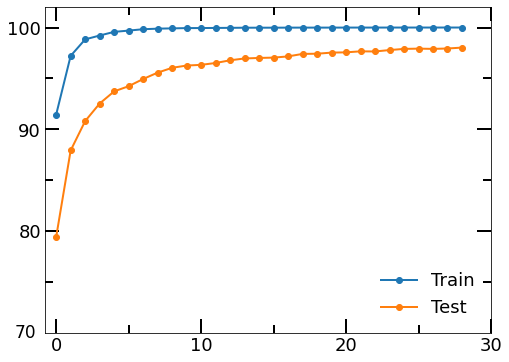

In [ ]:
# Plot the most important features 
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib import rcParams
import matplotlib.font_manager
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"

results = clf.evals_result()
x_axis = range(0, 29)
fig, ax = plt.subplots(figsize=(8,6))
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
ax.set_xlim(-0.8, 30)
ax.set_ylim(70, 102)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 31, 10)
minor_ticks_x = np.arange(0,31, 5)
major_ticks_y = np.arange(70, 101, 10)
minor_ticks_y = np.arange(70, 101, 5)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

ax.plot(x_axis, np.array(results['validation_0']['auc'])*100, label='Train', linewidth=2, marker='o')
ax.plot(x_axis, np.array(results['validation_1']['auc'])*100, label='Test', linewidth=2, marker='o')
ax.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax.text(-0.066, -0.015, '70', transform=ax.transAxes, fontsize= 17)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=18, loc="lower right", framealpha=0)

#ax.set_ylim([0.74, 1.01])
#plt.ylabel('AUC', fontsize=18)
#plt.xlabel('Epochs', fontsize=18 )
#plt.title('XGBoost AUC (Bidirectional Representation)', fontsize=18)
#plt.savefig('AUC_no_Setr.svg')

In [ ]:
#deep_unlab = uf_final#pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/unlabelled_deep.csv')
top= top_scored #pd.concat([uf_final.Identifier ,pd.DataFrame(deep_unlab.test_score.values, columns=['score'])], axis=1)

c=pd.DataFrame(top.describe().loc['75%'].astype(float)).iloc[0].values[0]
proba_ = top.sort_values(by = ['test_score'], ascending=True)
b = top[top['test_score'] > threshold]
# Predicted inliers (top quantile)
len(b)

5434

In [ ]:
pred1 = uf_final[uf_final.Identifier.isin(b.Identifier)]
pred1

Identifier        MW       AMW  ...  Neoplastic-50  Infective-80  Infective-50
4          comb5  0.058642  0.121090  ...            0.0           1.0           0.0
5          comb6  0.058642  0.121090  ...            0.0           1.0           0.0
7          comb8  0.058642  0.121090  ...            0.0           1.0           0.0
8          comb9  0.058642  0.121090  ...            0.0           1.0           0.0
9         comb10  0.058642  0.121090  ...            0.0           1.0           0.0
...          ...       ...       ...  ...            ...           ...           ...
21595  comb21596  0.045446  0.110584  ...            0.0           1.0           0.0
21661  comb21662  0.069658  0.089206  ...            0.0           0.0           0.0
21669  comb21670  0.069658  0.089206  ...            0.0           0.0           0.0
21703  comb21704  0.105611  0.106707  ...            0.0           1.0           0.0
21729  comb21730  0.074796  0.082761  ...            0.0           0.0           0.0

[5434 rows x 3715 columns]

In [ ]:
clf = XGBClassifier(learning_rate=0.15, n_estimators=35, max_depth=10,
                        min_child_weight=3, gamma=0.01, subsample=0.9, colsample_bytree=0.43,
                        objective='binary:logistic', nthread=2, scale_pos_weight=1, seed=0)  

NameError: ignored

In [ ]:
from xgboost import XGBClassifier
clf = XGBClassifier(learning_rate=0.13, n_estimators=31, max_depth=10,
                        min_child_weight=3, gamma=0.01, subsample=0.9, colsample_bytree=0.43,
                        objective='binary:logistic', nthread=2, scale_pos_weight=1, seed=0) 

In [ ]:
clf = XGBClassifier(learning_rate=0.13, n_estimators=35, max_depth=10,
                        min_child_weight=3, gamma=0.01, subsample=0.9, colsample_bytree=0.43,
                        objective='binary:logistic', nthread=2, scale_pos_weight=1, seed=0) 
eval_set = [(X_train, y_train), (X_test, y_test)]
#clf.fit(X_train, y_train, eval_metric='auc')
clf.fit(X_train, y_train, early_stopping_rounds=15, eval_metric="auc", eval_set=eval_set, verbose=True)
y_pred = clf.predict(X_test)                     


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[0]	validation_0-auc:0.901182	validation_1-auc:0.790086
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.954882	validation_1-auc:0.855998
[2]	validation_0-auc:0.974397	validation_1-auc:0.893005
[3]	validation_0-auc:0.98614	validation_1-auc:0.90463
[4]	validation_0-auc:0.99132	validation_1-auc:0.922536
[5]	validation_0-auc:0.994228	validation_1-auc:0.936425
[6]	validation_0-auc:0.9953	validation_1-auc:0.940289
[7]	validation_0-auc:0.996685	validation_1-auc:0.949537
[8]	validation_0-auc:0.997752	validation_1-auc:0.954405
[9]	validation_0-auc:0.998524	validation_1-auc:0.96007
[10]	validation_0-auc:0.998873	validation_1-auc:0.964263
[11]	validation_0-auc:0.99913	validation_1-auc:0.96729
[12]	validation_0-auc:0.999444	validation_1-auc:0.968831
[13]	validation_0-auc:0.999504	validation_1-auc:0.96919
[14]	validation_0-auc:0.999478	validation_1-auc:0.969673
[15]	va

In [ ]:
from xgboost import XGBClassifier
clf = XGBClassifier(learning_rate=0.29, n_estimators=31, max_depth=11,
                        min_child_weight=1, gamma=0.15, subsample=0.99, colsample_bytree=0.84,
                        objective='binary:logistic', nthread=2, scale_pos_weight=1, seed=0)  
eval_set = [(X_train, y_train), (X_test, y_test)]
#clf.fit(X_train, y_train, eval_metric='auc')
clf.fit(X_train, y_train, early_stopping_rounds=15, eval_metric="auc", eval_set=eval_set, verbose=True)
y_pred = clf.predict(X_test)                     

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[0]	validation_0-auc:0.939041	validation_1-auc:0.81044
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.984963	validation_1-auc:0.894859
[2]	validation_0-auc:0.998205	validation_1-auc:0.939848
[3]	validation_0-auc:0.999448	validation_1-auc:0.951545
[4]	validation_0-auc:0.999708	validation_1-auc:0.963766
[5]	validation_0-auc:0.999961	validation_1-auc:0.969878
[6]	validation_0-auc:0.999996	validation_1-auc:0.974014
[7]	validation_0-auc:1	validation_1-auc:0.976237
[8]	validation_0-auc:1	validation_1-auc:0.976682
[9]	validation_0-auc:1	validation_1-auc:0.978418
[10]	validation_0-auc:1	validation_1-auc:0.979625
[11]	validation_0-auc:1	validation_1-auc:0.980816
[12]	validation_0-auc:1	validation_1-auc:0.981737
[13]	validation_0-auc:1	validation_1-auc:0.982332
[14]	validation_0-auc:1	validation_1-auc:0.983327
[15]	validation_0-auc:1	validation_1-auc:0.98398
[16]	v

In [ ]:
net = deep_SVDD.net.to(device)
X_pred= pred1.iloc[:,1:].values
X_pred = torch.FloatTensor(X_pred).to(device)
y_pred = net(X_pred)

X_pred= y_pred.cpu().detach().numpy()
k=clf.predict(X_pred)

In [ ]:
pred_ratios = pd.concat([pd.DataFrame(pred1.Identifier.values, columns=['Identifier']), pd.DataFrame(k, columns=['ratio'])], axis=1)
experimental = ['comb1799', 'comb1817']
exp_pred_ratios = pred_ratios[pred_ratios.Identifier.isin(experimental)]
smiles = []
for i in exp_pred_ratios.Identifier.values:
  smiles.append('.'.join(dict1[i]))
exp_pred_ratios = pd.concat([pd.DataFrame(exp_pred_ratios.values, columns=exp_pred_ratios.columns.values), pd.DataFrame(smiles, columns=['smiles'])], axis=1)
exp_pred_ratios

Identifier ratio                                             smiles
0   comb1799     1  c1cc2ccc3cccc4ccc(c1)c2c34.O=C1Oc2ccccc2c3ccccc13
1   comb1817     0  c1cc2ccc3cccc4ccc(c1)c2c34.N#Cc1c2ccccc2c(C#N)...

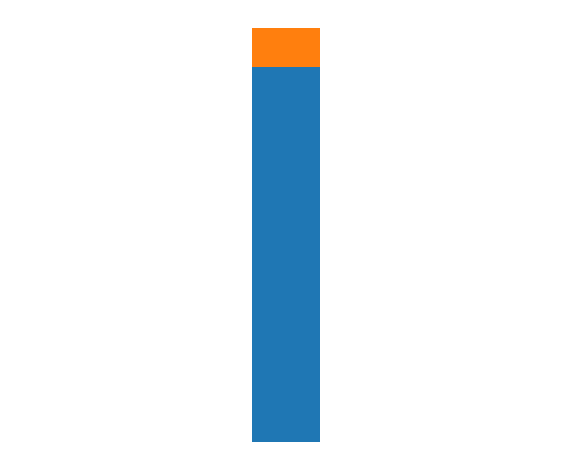

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
unlab_ratios = pd.DataFrame(k, columns=['ratio'])
counts = unlab_ratios.ratio.value_counts()
populationShare  = (counts[0], counts[1])
df1 = pd.concat([pd.DataFrame([0,1], columns=['ratio']) ,pd.DataFrame(populationShare, columns=['count'])], axis=1)
freq = pd.Series(df1['count'])
fig,ax = plt.subplots(figsize=(10,8))
fig.patch.set_visible(False)
freq.to_frame().T.plot.bar(stacked=True, width=0.07, ax=ax)


ax.axis('off')
ax.get_legend().remove()
#ax.text(0.04, 1900, s='1:1', va='center', fontsize=18)
#ax.text(0.04, 4882, s='>1:1', va='center', fontsize=18)


# Add the percentages
#ax.text(-0.11,  1900, s='88.44%', va='center', fontsize=18)
#ax.text(-0.11,  4882, s='11.56%', va='center', fontsize=18)

#ax.set_ylabel('Counts')
#ax.set_xlabel('Co-crystal Ratios')
#ax.set_ylim(0, 2000)
#ax.set_xlim(-0.1, 0.1)
#ax.xaxis.set_ticks(np.arange(0, 2000, 100))
#plt.savefig('bar-chart_un.svg')

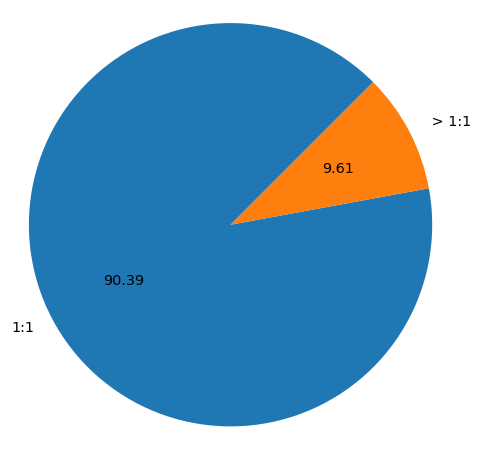

In [ ]:

# Count the molecular ratios of the co-crystals in the training set and visualization in a pie chart

import matplotlib.pyplot as plotter
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

unlab_ratios = pd.DataFrame(k, columns=['ratio'])
counts = unlab_ratios.ratio.value_counts()

# The slice names of a population distribution pie chart
pieLabels = '1:1', ' > 1:1'

# Population data
populationShare  = populationShare  = (counts[0], counts[1])
figureObject, axesObject = plotter.subplots()

# Draw the pie chart
axesObject.pie(populationShare, labels=pieLabels,  autopct='%1.2f', startangle=45,  textprops={'size': 'x-large'}, radius=0.5)
axesObject.axis('equal')
plotter.figure
#plotter.legend()
plotter.savefig('pie-chart_un.svg')
plotter.show()

In [ ]:
deep_unlab = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/unlabelled_deep.csv')

In [ ]:
ens = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/ensemble_scores.csv')
ens

Unnamed: 0       ens
0               0  0.637739
1               1  0.453821
2               2  0.920375
3               3  0.573707
4               4  0.423337
...           ...       ...
23453       23453  0.706052
23454       23454  0.674192
23455       23455  0.673352
23456       23456  0.662063
23457       23457  0.704153

[23458 rows x 2 columns]

In [ ]:
ens.iloc[3444:, :].ens.shape

(20014,)

Unnamed: 0  test_score
0               0    0.488232
1               1    0.671460
2               2    0.665352
3               3   -0.194888
4               4    0.675012
...           ...         ...
21731       21731   -2.493923
21732       21732    0.482610
21733       21733   -2.032796
21734       21734    0.232237
21735       21735    0.427417

[21736 rows x 2 columns]

ValueError: ignored

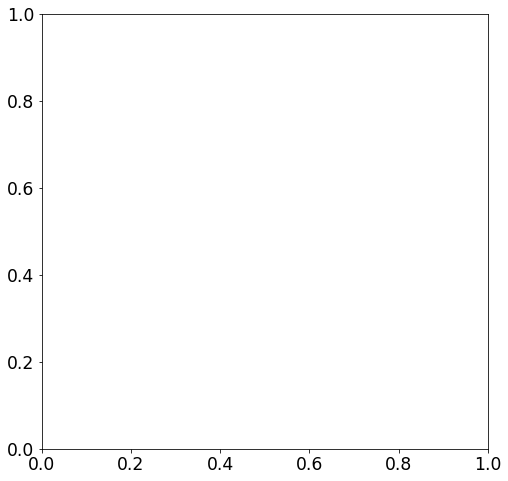

In [ ]:
plt.plot(deep_unlab.test_score, unlab_final.test_score, range=[0,1])
plt.xlim(0,1)

In [ ]:
!pip install shap

     |████████████████████████████████| 273 kB 4.6 MB/s 
     |████████████████████████████████| 25.9 MB 92 kB/s 
     |████████████████████████████████| 6.8 MB 89.9 MB/s 
     |████████████████████████████████| 300 kB 73.0 MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp37-cp37m-linux_x86_64.whl size=399273 sha256=9f706541af041a4db7846577dcb29b6f71e6d95cd9258cbe87a79136c359984c
  Stored in directory: /root/.cache/pip/wheels/c3/e0/82/26cebc699e23c6a1b9963981e1a10ed7de75db012f4af12428
Successfully built shap


In [ ]:

class  CocryNet(nn.Module):
    def __init__(self, net, R, C):
      
        super().__init__()
        self.net = net
        self.R = torch.Tensor([R]).to("cuda")
        self.C = torch.Tensor([C]).to("cuda")

    def forward(self, x):
        #x = torch.FloatTensor(x).cpu().to(device)
        outputs = self.net(x)
        dist = torch.sum((outputs - self.C) ** 2, dim=1)
        scores = (dist - self.R ** 2)*-1
        lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
        M= lab.max()
        m= lab.min()
        scores = (scores - m)/(M-m)
        return scores.unsqueeze(1)
shapNet = CocryNet(deep_SVDD.net, deep_SVDD.R, deep_SVDD.c)

In [ ]:
# Add the '_1' and '_2' at the end of each descriptor to denote the possition of the molecule in the vector
df1=dataset1.iloc[:,3:]
labels1 = df1.rename(columns=lambda x: f"{x}_1")
labels2 = df1.rename(columns=lambda x: f"{x}_2")
dataset1_labels = labels1.columns.values
dataset2_labels = labels2.columns.values

cols = np.concatenate((dataset1_labels, dataset2_labels))
len(cols)


3714

In [ ]:
# Interpretability of the whole bidirectional dataset
import shap

import numpy as np

# select a set of background examples to take an expectation over
device = 'cuda'
background = torch.FloatTensor(df.iloc[:, 1:].values).to(device)
model = shapNet#.to(device)

# explain predictions of the model on the training set
e = shap.GradientExplainer(model, background)#, link = 'logit')      

#e = shap.KernelExplainer(model, background)
shap_values = e.shap_values(background, rseed=0, ranked_outputs=10)

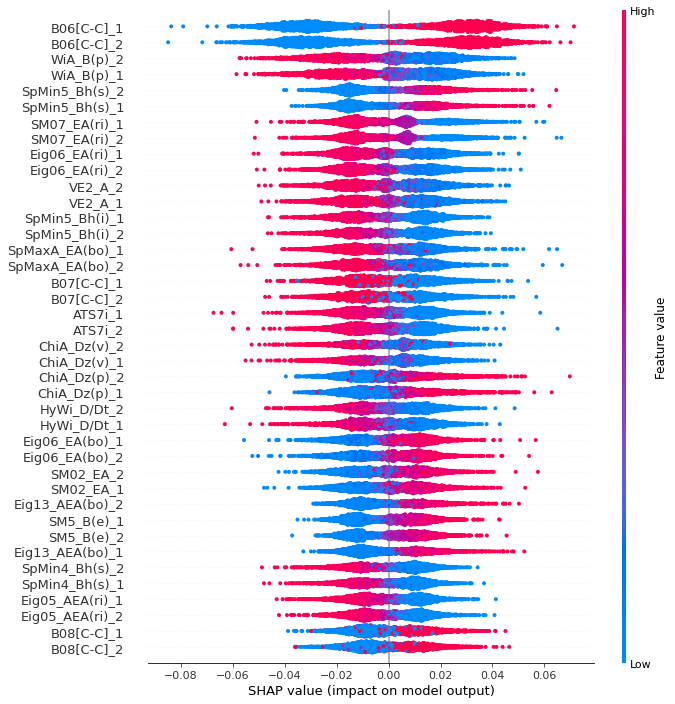

In [ ]:
# Plot the most important features 

X = pd.DataFrame(df.iloc[:, 1:].values, columns=cols) 

shap.summary_plot(shap_values, X ,  color_bar=True, plot_size=(10,12), layered_violin_max_num_bins=30, class_names=None, max_display=40,  show=False)

#plt.savefig('shap_lab.svg')